**<h2>Computing Water Potential Energy Surface Using Behler and Parinello Symmetry Functions** 

Importing relevant packages from PyTorch

In [1]:
"""
Created on Sat May 15 17:34:55 2021
@author: Katerina Karoni
"""
import torch                        # Torch is an open-source machine learning library, a scientific computing framework,
                                       #and a script language
import torch.nn as nn
import torch.nn.functional as F     # Convolution Functions
import torch.optim as optim         # Package implementing various optimization algorithms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms  #The torchvision package consists of popular datasets, model 
                                              #architectures, and common image transformations for computer vision
from torch.utils.data import DataLoader, TensorDataset       #Data loading utility class
from torch import Tensor
import pandas as pd

import numpy as np
import random
import os
import ase
from ase import Atoms
from ase.io import read

Loading the data (energies and geometries) for 1000 water molecule configurations in .xyz form

In [2]:
energies = np.genfromtxt('./water/energies.txt')
print("Energies file has",np.shape(energies),"entries")
#geometry_data =  read('./water/structures.xyz',index=':')
#print("Geometry file has",np.shape(geometry_data),"entries")
#print(geometry_data[0])
#geometry_data = np.array(geometry_data)

Energies file has (1000,) entries


In [3]:
# see https://education.molssi.org/python-data-analysis/01-numpy-arrays/index.html
#https://stackoverflow.com/questions/23353585/got-1-columns-instead-of-error-in-numpy

file_location = os.path.join('water', 'structures.xyz')
xyz_file = np.genfromtxt(fname=file_location, skip_header=2, dtype='unicode',invalid_raise = False)
# where invalid_raise = False was used to skip all lines in the xyz file that only have one column
symbols = xyz_file[:,0]
coordinates = (xyz_file[:,1:-1])
coordinates = coordinates.astype(np.float)

#print(symbols)
#print(coordinates)

<ipython-input-3-c38e52de7b08>:5: ConversionWarning: Some errors were detected !
    Line #6 (got 1 columns instead of 5)
    Line #11 (got 1 columns instead of 5)
    Line #16 (got 1 columns instead of 5)
    Line #21 (got 1 columns instead of 5)
    Line #26 (got 1 columns instead of 5)
    Line #31 (got 1 columns instead of 5)
    Line #36 (got 1 columns instead of 5)
    Line #41 (got 1 columns instead of 5)
    Line #46 (got 1 columns instead of 5)
    Line #51 (got 1 columns instead of 5)
    Line #56 (got 1 columns instead of 5)
    Line #61 (got 1 columns instead of 5)
    Line #66 (got 1 columns instead of 5)
    Line #71 (got 1 columns instead of 5)
    Line #76 (got 1 columns instead of 5)
    Line #81 (got 1 columns instead of 5)
    Line #86 (got 1 columns instead of 5)
    Line #91 (got 1 columns instead of 5)
    Line #96 (got 1 columns instead of 5)
    Line #101 (got 1 columns instead of 5)
    Line #106 (got 1 columns instead of 5)
    Line #111 (got 1 columns instead

In [4]:
## Alternatively loading the data in .npy form
# # The data was downloaded from http://www.quantum-machine.org/datasets/ (Densities dataset--> water.zip)
# # The data includes energies, densities and structure for water molecules
# #For each dataset, structures are given in with positions in Bohr and the energies are given in kcal/mol 
# energy_data = np.load('./water_102/dft_energies.npy')
# print("Energies file has",np.shape(energy_data),"entries")
# geometry_data =  np.load('./water-2/water_102/structures.npy')
# print("Geometry file has",np.shape(geometry_data),"entries")
# print(type(energy_data))
# print(type(geometry_data))

In [5]:
print(np.shape(coordinates))
print(type(coordinates))
print(coordinates[0])
print(coordinates[1])
print(coordinates[2])

print('gfjkhgfjhgfkgh')
print(coordinates[3])
print(coordinates[4])
print(coordinates[5])

print(energies[0])
# There is 1000 water molecules and each of them consists of 3 atoms, so we have 3000 atoms in total and each
# of them has 3 coordinates.
# Thus the coordinates array has 3000 lines, each of them corresponding to one atom (the first three lines
# correspopnd to the first water molecule) and 3 columns corresponding to the x, y and z coordinates respectively.

(3000, 3)
<class 'numpy.ndarray'>
[0.         0.769767   0.55746937]
[ 0.         -0.71017975  0.50340914]
[ 0.         -0.0037242  -0.06630491]
gfjkhgfjhgfkgh
[0.         0.77715107 0.59586089]
[ 0.         -0.77642641  0.59515778]
[ 0.000000e+00 -4.529000e-05 -7.443867e-02]
-13815.2523726009


**<h2>Cutoff Function** 
    $$f_c(R_{ij}) = 
    \begin{cases}
        0.5 \times \big[\cos\big(\frac{\pi R_{ij}}{R_c}\big)+1\big]  & \text{for } R_{ij} \leq R_c\\
        0  & \text{for } R_{ij} > R_c
    \end{cases}
    $$
    
In the Behler and Parinello paper the Cutoff radius $R_c$ was taken to be $6$  Ångströms, or 11.3384 Bohr radii. (Remember, 1 Ångström is $10^{-10}$m)

In [6]:
def fc(R,Rc):
    if R <= Rc:
        fcutoff = 0.5 * (np.cos(np.pi*R/Rc)+1)
    else:
        fcutoff = 0
    return fcutoff

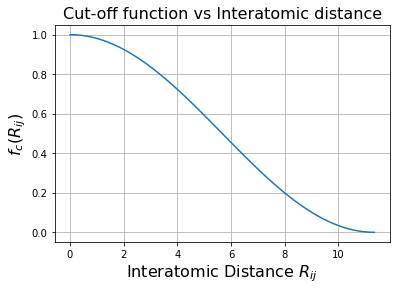

In [7]:
# Plotting fc as a function of interatomic distance Rij

Rc  = 11.3384 # Bohr

Rij     = np.linspace(0,Rc)
fcutoff = np.zeros(np.size(Rij))

for i in range(np.size(Rij)):
    fcutoff[i] = fc(Rij[i],Rc)

plt.plot(Rij,fcutoff)
plt.title('Cut-off function vs Interatomic distance', fontsize=16)
plt.xlabel('Interatomic Distance $R_{ij}$', fontsize=16)
plt.ylabel('$f_c(R_{ij})$', fontsize=16)
plt.grid()

**<h2>Pairwise Distances**

$$Dp = \begin{bmatrix} R_{00} & R_{01} & R_{02} \\ R_{10} & R_{11} & R_{12} \\ R_{20} & R_{21} & R_{22} \end{bmatrix} = \begin{bmatrix} 0 & R_{01} & R_{02} \\ R_{01} & 0 & R_{12} \\ R_{02} & R_{12} & 0 \end{bmatrix} $$

In [8]:
i = 0                                # i-th water molecule
coord = coordinates[3*i:3*(i+1),:]   # Let's take the coordinates of the ith water molecule in our dataset and compute
                                     # pairwise distances between all of its 3 atom

def pairwise_distances(coord):                       # we pass in the coordinates of the 3 atoms in the water molecule
    pairwise_dist_matrix = np.zeros(np.shape(coord))       # Initialise the matrix
    N = len(coord)
    for i in range(0,N-1):
#        print('i=',i)
        for j in range(i+1,N):
#            print(j)
#            pairwise_dist_matrix[i][j] = \
#            np.sqrt(  (coord[i][0] - coord[j][0] )**2 + (coord[i][1] - coord[j][1] )**2 +(coord[i][2] - coord[j][2] )**2   )
            pairwise_dist_matrix[i][j] =  np.sqrt(sum( (coord[i,:] - coord[j,:])**2 ))
            pairwise_dist_matrix[j][i] = pairwise_dist_matrix[i][j]

    return pairwise_dist_matrix

Dp = pairwise_distances(coord)
print(Dp)



[[0.         1.48093379 0.99367147]
 [1.48093379 0.         0.9075536 ]
 [0.99367147 0.9075536  0.        ]]


**<h2>From Cartesian to Generalised Coordinates**

**<h3>Radial Symmetry Functions**
    
<h3>$$G_i^1 = \sum_{j \neq i}^{\text{all}} e^{-\eta (R_{ij}-R_s)^2} f_c (R_{ij})$$

In [9]:
heta = 0.1
Rs   = 0
N    = len(coord)


def radial_BP_symm_func(Dp,N,heta,Rs):
    G_mu1 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)
    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(0,i):
            G_mu1[i] = G_mu1[i] + np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
        for j in range(i+1,N):
            G_mu1[i] = G_mu1[i] +  np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
    return G_mu1

Gmu1 = radial_BP_symm_func(Dp,N,heta,Rs)
print(Gmu1)

[1.65865495 1.67618952 1.79537284]


**<h3> Angular Symmetry Functions**

$$G_i^2 = 2^{1-\zeta} \sum_{j,k \neq i}^{\text{all}} (1+\lambda \cos \theta_{ijk})^\zeta \times e^{-\eta (R_{ij}^2+R_{ik}^2+R_{jk}^2 )} f_c (R_{ij})f_c (R_{ik})f_c (R_{jk})$$
    
with parameters $\lambda = +1, -1$, $\eta$ and $\zeta$

In [10]:
lambdaa = 1     #1
zeta    = 0.2
heta    = 0.1

N = len(coord)

def angular_BP_symm_func(coord,Dp,N,heta,Rs,lambdaa,zeta):
    G_mu2 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)

    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(N):           
            for k in range(N):
                if j != i and k !=i:
                    R_vec_ij = coord[i,:] - coord[j,:]
                    R_vec_jk = coord[i,:] - coord[k,:]
                    cos_theta_ijk  = np.dot(R_vec_ij, R_vec_jk)/(Dp[i][j]*Dp[i][k])
                    G_mu2[i]   = G_mu2[i] + (  1 + lambdaa * cos_theta_ijk )**zeta  \
                                * np.exp( -heta * (Dp[i][j]**2 + Dp[i][k]**2 + Dp[j][k]**2) ) \
                                * fc(Dp[i][j],Rc) * fc(Dp[i][k],Rc) * fc(Dp[j][k],Rc)            
        G_mu2[i]   = 2**(1-zeta) * G_mu2[i] 
    return G_mu2

Gmu2 = angular_BP_symm_func(coord,Dp,N,heta,Rs,lambdaa,zeta)
print(Gmu2)

[5.19473151 5.24520024 5.28298916]


In [11]:
np.cos(180)

-0.5984600690578581

**<h2>Training and Test Set**

In [12]:
a = np.ones(4)
print(a)

[1. 1. 1. 1.]


In [13]:
N                    = 3           # number of atoms per molecule
number_of_features   = 48           # number of features (symmetry functions) for each atom (we create one radial)
                                   # and one angular, but can create more by vaying the parameters η, λ, ζ, Rs etc.

heta   = np.linspace(0.01, 0.5, num=number_of_features)
random.shuffle(heta)

Rs     = np.linspace(0, 1, num=number_of_features)
random.shuffle(Rs)

lambdaa = np.ones(number_of_features)
random.shuffle(lambdaa)

zeta    = np.linspace(0, 0.5, num=number_of_features)
random.shuffle(zeta)


data_size            = 1000        # We have 1000 water molecule conformations
training_set_size    = 900



    
G = np.zeros((len(coordinates), number_of_features))  # we have 3000x2 features (2 symm funcs for ech of the 3000 atoms in the dataset)

for i in range(data_size):
    coord = coordinates[N*i:N*(i+1),:]
    Dp    = pairwise_distances(coord)
    for j in range(0,number_of_features,2):
        G[N*i:N*(i+1),j]   = radial_BP_symm_func(Dp,N,heta[j],Rs[j])     
        G[N*i:N*(i+1),j+1] = angular_BP_symm_func(coord,Dp,N,heta[j],Rs[j],lambdaa[j],zeta[j])
    
# Computing variance and mean on the training data only!
G_train = G[:training_set_size,:]
var  = np.var(G_train,axis=0)
mean = np.mean(G_train,axis=0)

# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(G)[0]):
    for j in range(np.shape(G)[1]):
        G[i,j] = (G[i,j]-mean[j])/var[j]   


data_set = np.vsplit(G,1000)     # Going from a (3000,2) np.array to a (1000,3,2) list
#data_set = np.random.permutation(training_set)
data_set = torch.FloatTensor(data_set)          # Going from a (1000,3,2) list to a a (1000,3,2) tensor

# print(data_set[0])
# print(data_set[0][1][1])
labels = torch.FloatTensor(energies)            # turning energies into a (1000) tensor

# Splitting the dataset into training and test set
training_set         = data_set[:training_set_size]
test_set             = data_set[training_set_size:]

train_labels         = labels[:training_set_size]
test_labels          = labels[training_set_size:]

# Dataset
dataset = TensorDataset(training_set, train_labels)
#print(dataset[0])

# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                           shuffle=False, num_workers=2, drop_last=False) # ?????

print(np.shape(training_set))

torch.Size([900, 3, 48])


In [14]:
print(G)

[[ -4.6478239   -0.43796558 -26.29832891 ...  -0.51141851  -5.52448445
    0.21134741]
 [ -2.40609692   0.45622357 -14.39586474 ...   0.46928698  -3.5879843
    1.43908672]
 [ 12.27044203   3.66615993  74.96196067 ...   3.69857043  16.9343591
    3.40340208]
 ...
 [ -9.45942912  -3.75004008 -57.6545479  ...  -3.83972362 -12.86415159
   -4.49793115]
 [ -7.35200739  -2.937905   -46.15939365 ...  -2.95785971 -10.73195519
   -3.36929762]
 [  8.63330645   0.68931582  55.39738115 ...   0.67820362  13.538337
   -0.39902764]]


In [15]:
a = np.array([[1.0,2.0],[3.0,4.0],[5.0,6.0]])
# for i in range(3):
#     a[i,0] = a[i,0]/(sum(a[:,0])/3)
# print(a)

b = (sum(a[:,0])/3)
print(b)
print(type(b))
a[0,0] = a[0,0]/b
print(a)

3.0
<class 'numpy.float64'>
[[0.33333333 2.        ]
 [3.         4.        ]
 [5.         6.        ]]


**<h2>Building Neural Network Architecture**

In [16]:
class Subnets(nn.Module):
    def __init__(self):
        super(Subnets, self).__init__()
        self.fc1 = nn.Linear(48, 40)        # where fc stands for fully connected 
        self.fc2 = nn.Linear(40, 40)        
        self.fc3 = nn.Linear(40, 1)
#         self.fc4 = nn.Linear(10, 8)
#         self.fc5 = nn.Linear(8, 6)
#         self.fc6 = nn.Linear(6, 4)
#         self.fc7 = nn.Linear(4, 2)
#         self.fc8 = nn.Linear(2, 1)


    def forward(self, x):
        x = torch.tanh(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
        x = torch.tanh(self.fc2(x))
#         x = torch.tanh(self.fc3(x))
#         x = torch.tanh(self.fc4(x))
#         x = torch.tanh(self.fc5(x))
#         x = torch.tanh(self.fc6(x))
#         x = torch.tanh(self.fc7(x))
        x = self.fc3(x)                   # Using a linear function (identity function) for the subnet output layers
        return x

class BPNN(nn.Module):
    def __init__(self):
        super(BPNN, self).__init__()
        self.network1 = Subnets()
        self.network2 = Subnets()
        self.network3 = Subnets()
        
#        self.fc_out = nn.Linear(3, 1)      # should this be defined here, given that we are not trying to optimise
        
    def forward(self, x1, x2, x3):
        x1 = self.network1(x1)
        x2 = self.network2(x2)
        x3 = self.network3(x3)
        
#         print(x1)
#         print(x2)
#         print(x3)
        
        x = torch.cat((x1, x2, x3), 0) 
        x = torch.sum(x)                   #??????????????????????????? try average pooling?
        x = torch.reshape(x,[1])
        return x

    
model = BPNN()
N = 1
x1, x2, x3 = training_set[0]
print('x1',x1)
print('x2',x2)
print('x3',x3)


output = model(x1, x2, x3)
print('output')
print(output)


# print(model)

# print('Network1')

# print('layer 1')
# print('weights')
# print(model.network1.fc1.weight)
# print('biases')
# print(model.network1.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network1.fc2.weight)
# print('biases')
# print(model.network1.fc2.bias)

# print('Network2')

# print('layer 1')
# print('weights')
# print(model.network2.fc1.weight)
# print('biases')
# print(model.network2.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network2.fc2.weight)
# print('biases')
# print(model.network2.fc2.bias)

# print('Network3')

# print('layer 1')
# print('weights')
# print(model.network3.fc1.weight)
# print('biases')
# print(model.network3.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network3.fc2.weight)
# print('biases')
# print(model.network3.fc2.bias)



x1 tensor([-4.6478e+00, -4.3797e-01, -2.6298e+01,  2.7297e+00, -3.2666e+00,
        -1.3510e+00, -5.2987e+00, -7.5633e-01, -1.3526e+01,  2.8776e+00,
        -3.5690e+00, -1.2040e+00, -3.7941e+00, -1.1340e+00, -1.4099e+01,
        -6.4752e-01, -4.7959e+00, -6.2878e-01, -4.8374e+00, -7.7548e-01,
        -8.1570e+00, -7.0027e-03, -3.6950e+00, -8.8470e-01, -3.4594e+00,
        -1.3052e+00, -4.2762e+00, -8.1133e-01, -7.8489e+00, -4.0618e-01,
        -3.5475e+00, -1.0617e+00, -4.7363e+00, -4.2019e-01, -3.6075e+00,
        -9.8979e-01, -7.9677e+00,  1.4320e+00, -3.8525e+00, -1.2742e+00,
        -1.8746e+01,  5.4885e+00, -4.7150e+00,  3.2236e-01, -5.2935e+00,
        -5.1142e-01, -5.5245e+00,  2.1135e-01])
x2 tensor([-2.4061e+00,  4.5622e-01, -1.4396e+01,  2.6475e+00, -1.7531e+00,
         4.2144e-02, -4.2703e+00,  1.7083e-01, -7.6935e+00,  2.9946e+00,
        -2.2232e+00, -1.3020e-01, -1.7714e+00,  2.3902e-02, -9.2398e+00,
         1.6340e-01, -2.6576e+00,  1.5850e-01, -2.9822e+00, -2.0427e-0

In [17]:
# class simplenn(nn.Module):
#     def __init__(self):
#         super(simplenn, self).__init__()
#         self.fc1 = nn.Linear(2, 3)        # where fc stands for fully connected 
#         self.fc2 = nn.Linear(3, 1)        
   

#     def forward(self, x):
#         x = torch.tanh(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
#         x = self.fc2(x)                   # Using a linear function (identity function) for the subnet output layers
#         return x

# mod = simplenn()

# print(mod.fc1.weight)
# print(mod.fc1.bias)

# print(mod.fc2.weight)
# print(mod.fc2.bias)

In [18]:
# x1, x2, x3 = training_set[0]
# x1 = x1[:2]
# x2 = x2[:2]

# x1[0] = -18650
# x1[1] = 109075
# print('x1',x1)

# x2[0] = -6
# x2[1] = 7
# print('x2',x2)

# output1 = mod(x1)
# print('output1')
# print(output1)

# output2 = mod(x2)
# print('output2')
# print(output2)

In [19]:
x1, x2, x3 = training_set[0]
print('x1',x1)
print('x2',x2)
print('x3',x3)


output = model(x1, x2, x3)
print('output')
print(output)

x1 tensor([-4.6478e+00, -4.3797e-01, -2.6298e+01,  2.7297e+00, -3.2666e+00,
        -1.3510e+00, -5.2987e+00, -7.5633e-01, -1.3526e+01,  2.8776e+00,
        -3.5690e+00, -1.2040e+00, -3.7941e+00, -1.1340e+00, -1.4099e+01,
        -6.4752e-01, -4.7959e+00, -6.2878e-01, -4.8374e+00, -7.7548e-01,
        -8.1570e+00, -7.0027e-03, -3.6950e+00, -8.8470e-01, -3.4594e+00,
        -1.3052e+00, -4.2762e+00, -8.1133e-01, -7.8489e+00, -4.0618e-01,
        -3.5475e+00, -1.0617e+00, -4.7363e+00, -4.2019e-01, -3.6075e+00,
        -9.8979e-01, -7.9677e+00,  1.4320e+00, -3.8525e+00, -1.2742e+00,
        -1.8746e+01,  5.4885e+00, -4.7150e+00,  3.2236e-01, -5.2935e+00,
        -5.1142e-01, -5.5245e+00,  2.1135e-01])
x2 tensor([-2.4061e+00,  4.5622e-01, -1.4396e+01,  2.6475e+00, -1.7531e+00,
         4.2144e-02, -4.2703e+00,  1.7083e-01, -7.6935e+00,  2.9946e+00,
        -2.2232e+00, -1.3020e-01, -1.7714e+00,  2.3902e-02, -9.2398e+00,
         1.6340e-01, -2.6576e+00,  1.5850e-01, -2.9822e+00, -2.0427e-0

In [20]:
## Manually compute neural Network output

# w11 = model.network1.fc1.weight
# b11 = model.network1.fc1.bias
# print(np.shape(w11))
# x1 = np.reshape(x1,(2,1))
# x1 = np.array(x1)
# print(np.shape(x1))

# w11 = w11.cpu().detach().numpy()
# b11 = b11.cpu().detach().numpy()
# #b11 = np.transpose(b11)
# b11 = np.reshape(b11,(3,1))
# print(np.shape(b11))
# print(type(x1))
# print(type(w11))

# a11 = np.matmul(w11,x1) + b11
# a11 = np.tanh(a11)
# print(a11)
# #print(torch.tensordot(w11,x1))


In [21]:
print('layer 1')
print('weights')
print(model.network1.fc1.weight)
print('biases')
print(model.network1.fc1.bias)

print('layer 2')
print('weights')
print(model.network1.fc2.weight)
print('biases')
print(model.network1.fc2.bias)

layer 1
weights
Parameter containing:
tensor([[-0.0873, -0.1106, -0.0474,  ...,  0.0965, -0.1228, -0.1126],
        [-0.0864,  0.1360, -0.0356,  ..., -0.0852,  0.0819,  0.0331],
        [ 0.0229,  0.1094, -0.1216,  ..., -0.0391, -0.1080,  0.0011],
        ...,
        [-0.0237, -0.0023,  0.1253,  ..., -0.0263,  0.0325,  0.0793],
        [-0.0032,  0.1374, -0.1304,  ..., -0.1335,  0.1423,  0.0341],
        [ 0.0815, -0.1358,  0.0180,  ..., -0.0337, -0.0347,  0.1217]],
       requires_grad=True)
biases
Parameter containing:
tensor([ 0.0487,  0.0414,  0.0661, -0.0889,  0.0531, -0.0094, -0.0559, -0.0148,
         0.0573, -0.0010, -0.0385,  0.1342,  0.0634, -0.1092,  0.0481,  0.1022,
        -0.1426,  0.0850,  0.1055,  0.0013, -0.0490, -0.0744,  0.0368,  0.0533,
        -0.1145, -0.0510, -0.1298, -0.0624,  0.0706, -0.0987,  0.0186,  0.0583,
         0.1357,  0.1070,  0.0880, -0.1183,  0.0022, -0.0208, -0.0082, -0.0065],
       requires_grad=True)
layer 2
weights
Parameter containing:
tensor

**<h2>Training the Neural Network**

In [44]:
net = BPNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.1)
nepochs = 200


train_loss = np.zeros(nepochs)
test_loss = np.zeros(nepochs)


train_acc = np.zeros(nepochs)
test_acc = np.zeros(nepochs)
for epoch in range(nepochs):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_train_loss = 0.0
    epoch_test_loss = 0.0
    counter = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#        inputs = torch.reshape(inputs,(3,2))    #  hard-coded !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        # zero the parameter gradients
        optimizer.zero_grad()

#         print(np.shape(inputs))
#         print(inputs)
        
        # forward + backward + optimize

        outputs = net(inputs[0][0],inputs[0][1],inputs[0][2])        #??????????????????????????????????????
        
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss))
        running_loss = 0.0    

print('Finished Training')

[1,     1] loss: 190843216.000
[1,     2] loss: 190732416.000
[1,     3] loss: 190621008.000
[1,     4] loss: 190595600.000
[1,     5] loss: 190588192.000
[1,     6] loss: 190539312.000
[1,     7] loss: 190438112.000
[1,     8] loss: 190360224.000
[1,     9] loss: 190374944.000
[1,    10] loss: 190375568.000
[1,    11] loss: 190315360.000
[1,    12] loss: 190252208.000
[1,    13] loss: 190190656.000
[1,    14] loss: 190041472.000
[1,    15] loss: 190093696.000
[1,    16] loss: 190073888.000
[1,    17] loss: 190139568.000
[1,    18] loss: 190107680.000
[1,    19] loss: 190016256.000
[1,    20] loss: 189845312.000
[1,    21] loss: 190021296.000
[1,    22] loss: 191056288.000
[1,    23] loss: 189860064.000
[1,    24] loss: 189824512.000
[1,    25] loss: 189794192.000
[1,    26] loss: 189817760.000
[1,    27] loss: 189650656.000
[1,    28] loss: 189739776.000
[1,    29] loss: 189683584.000
[1,    30] loss: 189710192.000
[1,    31] loss: 189648320.000
[1,    32] loss: 189606528.000
[1,    3

[1,   280] loss: 181289552.000
[1,   281] loss: 181350864.000
[1,   282] loss: 181304912.000
[1,   283] loss: 181282080.000
[1,   284] loss: 181174464.000
[1,   285] loss: 181171120.000
[1,   286] loss: 181110752.000
[1,   287] loss: 181097424.000
[1,   288] loss: 181082096.000
[1,   289] loss: 181055920.000
[1,   290] loss: 180929872.000
[1,   291] loss: 180747104.000
[1,   292] loss: 180911776.000
[1,   293] loss: 180951632.000
[1,   294] loss: 180875712.000
[1,   295] loss: 180839824.000
[1,   296] loss: 180760064.000
[1,   297] loss: 180775120.000
[1,   298] loss: 180652496.000
[1,   299] loss: 180636128.000
[1,   300] loss: 180648432.000
[1,   301] loss: 180614064.000
[1,   302] loss: 180600944.000
[1,   303] loss: 180338048.000
[1,   304] loss: 180414000.000
[1,   305] loss: 180542240.000
[1,   306] loss: 180437648.000
[1,   307] loss: 180460736.000
[1,   308] loss: 180424112.000
[1,   309] loss: 180277584.000
[1,   310] loss: 180300800.000
[1,   311] loss: 180194384.000
[1,   31

[1,   617] loss: 170435776.000
[1,   618] loss: 170334992.000
[1,   619] loss: 170472096.000
[1,   620] loss: 170407776.000
[1,   621] loss: 170334752.000
[1,   622] loss: 170182096.000
[1,   623] loss: 170155616.000
[1,   624] loss: 170109728.000
[1,   625] loss: 170152912.000
[1,   626] loss: 170198032.000
[1,   627] loss: 170127488.000
[1,   628] loss: 170016848.000
[1,   629] loss: 170155024.000
[1,   630] loss: 170042192.000
[1,   631] loss: 170003024.000
[1,   632] loss: 169879296.000
[1,   633] loss: 169856192.000
[1,   634] loss: 169874816.000
[1,   635] loss: 169856368.000
[1,   636] loss: 169813712.000
[1,   637] loss: 169741152.000
[1,   638] loss: 169785360.000
[1,   639] loss: 169697184.000
[1,   640] loss: 169701744.000
[1,   641] loss: 169709376.000
[1,   642] loss: 169637296.000
[1,   643] loss: 169648848.000
[1,   644] loss: 169663872.000
[1,   645] loss: 169661888.000
[1,   646] loss: 169515744.000
[1,   647] loss: 169578432.000
[1,   648] loss: 169384880.000
[1,   64

[1,   891] loss: 161946400.000
[1,   892] loss: 161996144.000
[1,   893] loss: 161931632.000
[1,   894] loss: 161875904.000
[1,   895] loss: 161854176.000
[1,   896] loss: 161936976.000
[1,   897] loss: 161848288.000
[1,   898] loss: 161793088.000
[1,   899] loss: 161825952.000
[1,   900] loss: 161720816.000
[2,     1] loss: 161715008.000
[2,     2] loss: 161680432.000
[2,     3] loss: 161614688.000
[2,     4] loss: 161619232.000
[2,     5] loss: 161630480.000
[2,     6] loss: 161585712.000
[2,     7] loss: 161506624.000
[2,     8] loss: 161432880.000
[2,     9] loss: 161452656.000
[2,    10] loss: 161454480.000
[2,    11] loss: 161400144.000
[2,    12] loss: 161343184.000
[2,    13] loss: 161287824.000
[2,    14] loss: 161151648.000
[2,    15] loss: 161201584.000
[2,    16] loss: 161184944.000
[2,    17] loss: 161247136.000
[2,    18] loss: 161220176.000
[2,    19] loss: 161138160.000
[2,    20] loss: 160982944.000
[2,    21] loss: 161147248.000
[2,    22] loss: 161020512.000
[2,    2

[2,   280] loss: 153402960.000
[2,   281] loss: 153460512.000
[2,   282] loss: 153419456.000
[2,   283] loss: 153399600.000
[2,   284] loss: 153301728.000
[2,   285] loss: 153299808.000
[2,   286] loss: 153245424.000
[2,   287] loss: 153234320.000
[2,   288] loss: 153221360.000
[2,   289] loss: 153198464.000
[2,   290] loss: 153083664.000
[2,   291] loss: 152916672.000
[2,   292] loss: 153069312.000
[2,   293] loss: 153107120.000
[2,   294] loss: 153038432.000
[2,   295] loss: 153006576.000
[2,   296] loss: 152934352.000
[2,   297] loss: 152949376.000
[2,   298] loss: 152837680.000
[2,   299] loss: 152823776.000
[2,   300] loss: 152836208.000
[2,   301] loss: 152805760.000
[2,   302] loss: 152794800.000
[2,   303] loss: 152554128.000
[2,   304] loss: 152625152.000
[2,   305] loss: 152744256.000
[2,   306] loss: 152649168.000
[2,   307] loss: 152671536.000
[2,   308] loss: 152638976.000
[2,   309] loss: 152505328.000
[2,   310] loss: 152527824.000
[2,   311] loss: 152431088.000
[2,   31

[2,   553] loss: 145519440.000
[2,   554] loss: 145346992.000
[2,   555] loss: 145483904.000
[2,   556] loss: 145303456.000
[2,   557] loss: 145357328.000
[2,   558] loss: 145468752.000
[2,   559] loss: 145420656.000
[2,   560] loss: 145350784.000
[2,   561] loss: 145432112.000
[2,   562] loss: 145388864.000
[2,   563] loss: 145360912.000
[2,   564] loss: 145359280.000
[2,   565] loss: 145316432.000
[2,   566] loss: 145264240.000
[2,   567] loss: 145142368.000
[2,   568] loss: 144907680.000
[2,   569] loss: 145175712.000
[2,   570] loss: 145131296.000
[2,   571] loss: 145026976.000
[2,   572] loss: 145005552.000
[2,   573] loss: 144943616.000
[2,   574] loss: 145078704.000
[2,   575] loss: 144955776.000
[2,   576] loss: 144988240.000
[2,   577] loss: 144860240.000
[2,   578] loss: 144792576.000
[2,   579] loss: 144679072.000
[2,   580] loss: 144896992.000
[2,   581] loss: 144801792.000
[2,   582] loss: 144577376.000
[2,   583] loss: 144702928.000
[2,   584] loss: 144775424.000
[2,   58

[2,   818] loss: 138175936.000
[2,   819] loss: 138269264.000
[2,   820] loss: 138228240.000
[2,   821] loss: 138131312.000
[2,   822] loss: 138170816.000
[2,   823] loss: 137953472.000
[2,   824] loss: 138093248.000
[2,   825] loss: 137992560.000
[2,   826] loss: 137986848.000
[2,   827] loss: 138037344.000
[2,   828] loss: 137962224.000
[2,   829] loss: 137842352.000
[2,   830] loss: 137811680.000
[2,   831] loss: 137778032.000
[2,   832] loss: 137899728.000
[2,   833] loss: 137808688.000
[2,   834] loss: 137686224.000
[2,   835] loss: 137811200.000
[2,   836] loss: 137782160.000
[2,   837] loss: 137741328.000
[2,   838] loss: 137631872.000
[2,   839] loss: 137671408.000
[2,   840] loss: 137543264.000
[2,   841] loss: 137608656.000
[2,   842] loss: 137601472.000
[2,   843] loss: 137541680.000
[2,   844] loss: 137608640.000
[2,   845] loss: 137540800.000
[2,   846] loss: 137541968.000
[2,   847] loss: 137420048.000
[2,   848] loss: 137353616.000
[2,   849] loss: 137189824.000
[2,   85

[3,   208] loss: 130509960.000
[3,   209] loss: 130393248.000
[3,   210] loss: 130421952.000
[3,   211] loss: 130362384.000
[3,   212] loss: 130419208.000
[3,   213] loss: 130216136.000
[3,   214] loss: 130242592.000
[3,   215] loss: 130256768.000
[3,   216] loss: 130087216.000
[3,   217] loss: 130189080.000
[3,   218] loss: 130241192.000
[3,   219] loss: 130121384.000
[3,   220] loss: 130193512.000
[3,   221] loss: 130089616.000
[3,   222] loss: 129905080.000
[3,   223] loss: 130166704.000
[3,   224] loss: 129998992.000
[3,   225] loss: 130037496.000
[3,   226] loss: 129957104.000
[3,   227] loss: 129940448.000
[3,   228] loss: 129853952.000
[3,   229] loss: 129919104.000
[3,   230] loss: 129982000.000
[3,   231] loss: 129871128.000
[3,   232] loss: 129852616.000
[3,   233] loss: 129751368.000
[3,   234] loss: 129831248.000
[3,   235] loss: 129817560.000
[3,   236] loss: 129797376.000
[3,   237] loss: 129748408.000
[3,   238] loss: 129692752.000
[3,   239] loss: 129551816.000
[3,   24

[3,   501] loss: 122863888.000
[3,   502] loss: 122817176.000
[3,   503] loss: 122891600.000
[3,   504] loss: 122759192.000
[3,   505] loss: 122853344.000
[3,   506] loss: 122794360.000
[3,   507] loss: 122746272.000
[3,   508] loss: 122695472.000
[3,   509] loss: 122792304.000
[3,   510] loss: 122704104.000
[3,   511] loss: 122503824.000
[3,   512] loss: 122620456.000
[3,   513] loss: 122569160.000
[3,   514] loss: 122657920.000
[3,   515] loss: 122540792.000
[3,   516] loss: 122471960.000
[3,   517] loss: 122595696.000
[3,   518] loss: 122484344.000
[3,   519] loss: 122539648.000
[3,   520] loss: 122359032.000
[3,   521] loss: 122433832.000
[3,   522] loss: 122480064.000
[3,   523] loss: 122180464.000
[3,   524] loss: 122312304.000
[3,   525] loss: 122300400.000
[3,   526] loss: 122314008.000
[3,   527] loss: 122284760.000
[3,   528] loss: 122232224.000
[3,   529] loss: 122126328.000
[3,   530] loss: 122153784.000
[3,   531] loss: 122177640.000
[3,   532] loss: 122128592.000
[3,   53

[3,   766] loss: 116343336.000
[3,   767] loss: 116359032.000
[3,   768] loss: 116274672.000
[3,   769] loss: 116263088.000
[3,   770] loss: 116125880.000
[3,   771] loss: 116105848.000
[3,   772] loss: 116192104.000
[3,   773] loss: 116172608.000
[3,   774] loss: 116021280.000
[3,   775] loss: 116130592.000
[3,   776] loss: 115958576.000
[3,   777] loss: 116035184.000
[3,   778] loss: 116070024.000
[3,   779] loss: 116088000.000
[3,   780] loss: 115946856.000
[3,   781] loss: 115978048.000
[3,   782] loss: 115833192.000
[3,   783] loss: 115818712.000
[3,   784] loss: 115953840.000
[3,   785] loss: 115858648.000
[3,   786] loss: 115903584.000
[3,   787] loss: 115900072.000
[3,   788] loss: 115791472.000
[3,   789] loss: 115754360.000
[3,   790] loss: 115780960.000
[3,   791] loss: 115623400.000
[3,   792] loss: 115696664.000
[3,   793] loss: 115557336.000
[3,   794] loss: 115589376.000
[3,   795] loss: 115656560.000
[3,   796] loss: 115642088.000
[3,   797] loss: 115530608.000
[3,   79

[4,   151] loss: 109497544.000
[4,   152] loss: 109474224.000
[4,   153] loss: 109426760.000
[4,   154] loss: 109478192.000
[4,   155] loss: 109366576.000
[4,   156] loss: 109411720.000
[4,   157] loss: 109344400.000
[4,   158] loss: 109189360.000
[4,   159] loss: 109332552.000
[4,   160] loss: 109279376.000
[4,   161] loss: 109156176.000
[4,   162] loss: 109274744.000
[4,   163] loss: 109124280.000
[4,   164] loss: 109135992.000
[4,   165] loss: 109212176.000
[4,   166] loss: 109100392.000
[4,   167] loss: 109100048.000
[4,   168] loss: 109130608.000
[4,   169] loss: 108945032.000
[4,   170] loss: 109044056.000
[4,   171] loss: 109070000.000
[4,   172] loss: 108802768.000
[4,   173] loss: 108906896.000
[4,   174] loss: 108866848.000
[4,   175] loss: 108934272.000
[4,   176] loss: 108782824.000
[4,   177] loss: 108934392.000
[4,   178] loss: 108877672.000
[4,   179] loss: 108817616.000
[4,   180] loss: 108752856.000
[4,   181] loss: 108675288.000
[4,   182] loss: 108659512.000
[4,   18

[4,   420] loss: 103162328.000
[4,   421] loss: 103194848.000
[4,   422] loss: 103210240.000
[4,   423] loss: 103203040.000
[4,   424] loss: 103167168.000
[4,   425] loss: 103204768.000
[4,   426] loss: 102993736.000
[4,   427] loss: 103102208.000
[4,   428] loss: 102953440.000
[4,   429] loss: 103064912.000
[4,   430] loss: 103073456.000
[4,   431] loss: 102908304.000
[4,   432] loss: 103018200.000
[4,   433] loss: 102946824.000
[4,   434] loss: 102848064.000
[4,   435] loss: 102794768.000
[4,   436] loss: 102872248.000
[4,   437] loss: 102749584.000
[4,   438] loss: 102858264.000
[4,   439] loss: 102764528.000
[4,   440] loss: 102794944.000
[4,   441] loss: 102807856.000
[4,   442] loss: 102720248.000
[4,   443] loss: 102676680.000
[4,   444] loss: 102624376.000
[4,   445] loss: 102756672.000
[4,   446] loss: 102434504.000
[4,   447] loss: 102693680.000
[4,   448] loss: 102587504.000
[4,   449] loss: 102621408.000
[4,   450] loss: 102499432.000
[4,   451] loss: 102595272.000
[4,   45

[4,   695] loss: 97163936.000
[4,   696] loss: 97097368.000
[4,   697] loss: 97082800.000
[4,   698] loss: 97009768.000
[4,   699] loss: 97087848.000
[4,   700] loss: 96992184.000
[4,   701] loss: 97041816.000
[4,   702] loss: 96966120.000
[4,   703] loss: 96921024.000
[4,   704] loss: 96849008.000
[4,   705] loss: 96854640.000
[4,   706] loss: 96841416.000
[4,   707] loss: 96848568.000
[4,   708] loss: 96715792.000
[4,   709] loss: 96706176.000
[4,   710] loss: 96779864.000
[4,   711] loss: 96706136.000
[4,   712] loss: 96761384.000
[4,   713] loss: 96655304.000
[4,   714] loss: 96740712.000
[4,   715] loss: 96557032.000
[4,   716] loss: 96649832.000
[4,   717] loss: 96647736.000
[4,   718] loss: 96615152.000
[4,   719] loss: 96539816.000
[4,   720] loss: 96496048.000
[4,   721] loss: 96515272.000
[4,   722] loss: 96503624.000
[4,   723] loss: 96520416.000
[4,   724] loss: 96526656.000
[4,   725] loss: 96419664.000
[4,   726] loss: 96436736.000
[4,   727] loss: 96306928.000
[4,   728]

[5,    69] loss: 91213544.000
[5,    70] loss: 91219008.000
[5,    71] loss: 91111160.000
[5,    72] loss: 91193432.000
[5,    73] loss: 91184112.000
[5,    74] loss: 91049504.000
[5,    75] loss: 91038528.000
[5,    76] loss: 91094256.000
[5,    77] loss: 91020152.000
[5,    78] loss: 91019888.000
[5,    79] loss: 91028368.000
[5,    80] loss: 90948560.000
[5,    81] loss: 90718912.000
[5,    82] loss: 90900248.000
[5,    83] loss: 90815152.000
[5,    84] loss: 90882096.000
[5,    85] loss: 90816840.000
[5,    86] loss: 90844320.000
[5,    87] loss: 90885200.000
[5,    88] loss: 90815800.000
[5,    89] loss: 90777664.000
[5,    90] loss: 90778320.000
[5,    91] loss: 90791584.000
[5,    92] loss: 90655600.000
[5,    93] loss: 90668592.000
[5,    94] loss: 90594856.000
[5,    95] loss: 90667608.000
[5,    96] loss: 90645200.000
[5,    97] loss: 90590984.000
[5,    98] loss: 90547696.000
[5,    99] loss: 90617312.000
[5,   100] loss: 90560016.000
[5,   101] loss: 90492856.000
[5,   102]

[5,   352] loss: 85370024.000
[5,   353] loss: 85310496.000
[5,   354] loss: 85273536.000
[5,   355] loss: 85256912.000
[5,   356] loss: 85208872.000
[5,   357] loss: 85164920.000
[5,   358] loss: 85133256.000
[5,   359] loss: 85242448.000
[5,   360] loss: 85039488.000
[5,   361] loss: 85183728.000
[5,   362] loss: 85100336.000
[5,   363] loss: 85066968.000
[5,   364] loss: 85051448.000
[5,   365] loss: 85039128.000
[5,   366] loss: 85064000.000
[5,   367] loss: 85034440.000
[5,   368] loss: 85054432.000
[5,   369] loss: 84910592.000
[5,   370] loss: 84883720.000
[5,   371] loss: 84788720.000
[5,   372] loss: 84929112.000
[5,   373] loss: 84864216.000
[5,   374] loss: 84875448.000
[5,   375] loss: 84856376.000
[5,   376] loss: 84783432.000
[5,   377] loss: 84765288.000
[5,   378] loss: 84818272.000
[5,   379] loss: 84602560.000
[5,   380] loss: 84788088.000
[5,   381] loss: 84721272.000
[5,   382] loss: 84761096.000
[5,   383] loss: 84732424.000
[5,   384] loss: 84609280.000
[5,   385]

[5,   631] loss: 79742720.000
[5,   632] loss: 79659912.000
[5,   633] loss: 79645936.000
[5,   634] loss: 79660608.000
[5,   635] loss: 79649800.000
[5,   636] loss: 79622472.000
[5,   637] loss: 79574696.000
[5,   638] loss: 79606824.000
[5,   639] loss: 79548352.000
[5,   640] loss: 79553296.000
[5,   641] loss: 79560408.000
[5,   642] loss: 79512944.000
[5,   643] loss: 79522712.000
[5,   644] loss: 79534888.000
[5,   645] loss: 79535392.000
[5,   646] loss: 79437216.000
[5,   647] loss: 79482016.000
[5,   648] loss: 79351368.000
[5,   649] loss: 79364504.000
[5,   650] loss: 79346096.000
[5,   651] loss: 79367896.000
[5,   652] loss: 79312416.000
[5,   653] loss: 79301040.000
[5,   654] loss: 79253360.000
[5,   655] loss: 79317048.000
[5,   656] loss: 79237344.000
[5,   657] loss: 79235448.000
[5,   658] loss: 79145160.000
[5,   659] loss: 79201080.000
[5,   660] loss: 79104416.000
[5,   661] loss: 79194080.000
[5,   662] loss: 79144432.000
[5,   663] loss: 79080704.000
[5,   664]

[6,    14] loss: 74210488.000
[6,    15] loss: 74246056.000
[6,    16] loss: 74236464.000
[6,    17] loss: 74280360.000
[6,    18] loss: 74263728.000
[6,    19] loss: 74209744.000
[6,    20] loss: 74106104.000
[6,    21] loss: 74219272.000
[6,    22] loss: 74134856.000
[6,    23] loss: 74121640.000
[6,    24] loss: 74099728.000
[6,    25] loss: 74076752.000
[6,    26] loss: 74097128.000
[6,    27] loss: 73988392.000
[6,    28] loss: 74051048.000
[6,    29] loss: 74017576.000
[6,    30] loss: 74036024.000
[6,    31] loss: 73999344.000
[6,    32] loss: 73975352.000
[6,    33] loss: 73964600.000
[6,    34] loss: 73960368.000
[6,    35] loss: 73921672.000
[6,    36] loss: 73798704.000
[6,    37] loss: 73803840.000
[6,    38] loss: 73869928.000
[6,    39] loss: 73829912.000
[6,    40] loss: 73784008.000
[6,    41] loss: 73787224.000
[6,    42] loss: 73806824.000
[6,    43] loss: 73783168.000
[6,    44] loss: 73705040.000
[6,    45] loss: 73719280.000
[6,    46] loss: 73622168.000
[6,    47]

[6,   297] loss: 69121264.000
[6,   298] loss: 69047696.000
[6,   299] loss: 69039856.000
[6,   300] loss: 69049736.000
[6,   301] loss: 69030768.000
[6,   302] loss: 69024928.000
[6,   303] loss: 68864680.000
[6,   304] loss: 68913944.000
[6,   305] loss: 68995480.000
[6,   306] loss: 68933096.000
[6,   307] loss: 68949640.000
[6,   308] loss: 68929272.000
[6,   309] loss: 68840968.000
[6,   310] loss: 68857616.000
[6,   311] loss: 68794128.000
[6,   312] loss: 68794288.000
[6,   313] loss: 68809504.000
[6,   314] loss: 68764584.000
[6,   315] loss: 68772832.000
[6,   316] loss: 68684920.000
[6,   317] loss: 68762496.000
[6,   318] loss: 68640656.000
[6,   319] loss: 68696288.000
[6,   320] loss: 68680016.000
[6,   321] loss: 68576968.000
[6,   322] loss: 68665552.000
[6,   323] loss: 68616288.000
[6,   324] loss: 68630576.000
[6,   325] loss: 68564840.000
[6,   326] loss: 68606048.000
[6,   327] loss: 68518400.000
[6,   328] loss: 68498256.000
[6,   329] loss: 68530312.000
[6,   330]

[6,   590] loss: 63878268.000
[6,   591] loss: 63740624.000
[6,   592] loss: 63845532.000
[6,   593] loss: 63862784.000
[6,   594] loss: 63786272.000
[6,   595] loss: 63821688.000
[6,   596] loss: 63834660.000
[6,   597] loss: 63821064.000
[6,   598] loss: 63712096.000
[6,   599] loss: 63692028.000
[6,   600] loss: 63750672.000
[6,   601] loss: 63743272.000
[6,   602] loss: 63689480.000
[6,   603] loss: 63626764.000
[6,   604] loss: 63550736.000
[6,   605] loss: 63649792.000
[6,   606] loss: 63623952.000
[6,   607] loss: 63589940.000
[6,   608] loss: 63512136.000
[6,   609] loss: 63540124.000
[6,   610] loss: 63519516.000
[6,   611] loss: 63481724.000
[6,   612] loss: 63490160.000
[6,   613] loss: 63461576.000
[6,   614] loss: 63371008.000
[6,   615] loss: 63468420.000
[6,   616] loss: 63381640.000
[6,   617] loss: 63446088.000
[6,   618] loss: 63386580.000
[6,   619] loss: 63472196.000
[6,   620] loss: 63434932.000
[6,   621] loss: 63392348.000
[6,   622] loss: 63301184.000
[6,   623]

[6,   867] loss: 59258640.000
[6,   868] loss: 59233076.000
[6,   869] loss: 59246304.000
[6,   870] loss: 59182048.000
[6,   871] loss: 59172596.000
[6,   872] loss: 59196072.000
[6,   873] loss: 59060524.000
[6,   874] loss: 59071840.000
[6,   875] loss: 59080488.000
[6,   876] loss: 59136056.000
[6,   877] loss: 59051344.000
[6,   878] loss: 59046512.000
[6,   879] loss: 59074264.000
[6,   880] loss: 58960448.000
[6,   881] loss: 58972156.000
[6,   882] loss: 59011488.000
[6,   883] loss: 59010200.000
[6,   884] loss: 58880496.000
[6,   885] loss: 58941000.000
[6,   886] loss: 58960652.000
[6,   887] loss: 58853844.000
[6,   888] loss: 58846812.000
[6,   889] loss: 58926524.000
[6,   890] loss: 58877656.000
[6,   891] loss: 58810908.000
[6,   892] loss: 58842668.000
[6,   893] loss: 58805576.000
[6,   894] loss: 58773756.000
[6,   895] loss: 58762456.000
[6,   896] loss: 58814116.000
[6,   897] loss: 58762480.000
[6,   898] loss: 58730968.000
[6,   899] loss: 58752548.000
[6,   900]

[7,   242] loss: 54756676.000
[7,   243] loss: 54736228.000
[7,   244] loss: 54766736.000
[7,   245] loss: 54752572.000
[7,   246] loss: 54775676.000
[7,   247] loss: 54687360.000
[7,   248] loss: 54592456.000
[7,   249] loss: 54697900.000
[7,   250] loss: 54658824.000
[7,   251] loss: 54664724.000
[7,   252] loss: 54669360.000
[7,   253] loss: 54615716.000
[7,   254] loss: 54553444.000
[7,   255] loss: 54500212.000
[7,   256] loss: 54600920.000
[7,   257] loss: 54573728.000
[7,   258] loss: 54438112.000
[7,   259] loss: 54489476.000
[7,   260] loss: 54536776.000
[7,   261] loss: 54471968.000
[7,   262] loss: 54460032.000
[7,   263] loss: 54357284.000
[7,   264] loss: 54414840.000
[7,   265] loss: 54458360.000
[7,   266] loss: 54382156.000
[7,   267] loss: 54414656.000
[7,   268] loss: 54361576.000
[7,   269] loss: 54384336.000
[7,   270] loss: 54281840.000
[7,   271] loss: 54353440.000
[7,   272] loss: 54286352.000
[7,   273] loss: 54279244.000
[7,   274] loss: 54269896.000
[7,   275]

[7,   550] loss: 50063020.000
[7,   551] loss: 49982316.000
[7,   552] loss: 50035080.000
[7,   553] loss: 49959420.000
[7,   554] loss: 49859816.000
[7,   555] loss: 49941592.000
[7,   556] loss: 49837368.000
[7,   557] loss: 49870424.000
[7,   558] loss: 49937204.000
[7,   559] loss: 49910512.000
[7,   560] loss: 49871072.000
[7,   561] loss: 49920200.000
[7,   562] loss: 49896364.000
[7,   563] loss: 49881484.000
[7,   564] loss: 49882008.000
[7,   565] loss: 49858404.000
[7,   566] loss: 49829316.000
[7,   567] loss: 49759432.000
[7,   568] loss: 49623480.000
[7,   569] loss: 49781940.000
[7,   570] loss: 49757420.000
[7,   571] loss: 49697832.000
[7,   572] loss: 49686776.000
[7,   573] loss: 49652020.000
[7,   574] loss: 49732572.000
[7,   575] loss: 49662068.000
[7,   576] loss: 49682576.000
[7,   577] loss: 49609152.000
[7,   578] loss: 49571040.000
[7,   579] loss: 49506136.000
[7,   580] loss: 49635108.000
[7,   581] loss: 49580864.000
[7,   582] loss: 49451000.000
[7,   583]

[7,   852] loss: 45576764.000
[7,   853] loss: 45512388.000
[7,   854] loss: 45559944.000
[7,   855] loss: 45541476.000
[7,   856] loss: 45565824.000
[7,   857] loss: 45533420.000
[7,   858] loss: 45507236.000
[7,   859] loss: 45477336.000
[7,   860] loss: 45483248.000
[7,   861] loss: 45505352.000
[7,   862] loss: 45458052.000
[7,   863] loss: 45470748.000
[7,   864] loss: 45358988.000
[7,   865] loss: 45424640.000
[7,   866] loss: 45401776.000
[7,   867] loss: 45424040.000
[7,   868] loss: 45401928.000
[7,   869] loss: 45413780.000
[7,   870] loss: 45357800.000
[7,   871] loss: 45349796.000
[7,   872] loss: 45370616.000
[7,   873] loss: 45252240.000
[7,   874] loss: 45262408.000
[7,   875] loss: 45270240.000
[7,   876] loss: 45319148.000
[7,   877] loss: 45245264.000
[7,   878] loss: 45241296.000
[7,   879] loss: 45265864.000
[7,   880] loss: 45166500.000
[7,   881] loss: 45177028.000
[7,   882] loss: 45211704.000
[7,   883] loss: 45210844.000
[7,   884] loss: 45097588.000
[7,   885]

[8,   254] loss: 41391568.000
[8,   255] loss: 41345484.000
[8,   256] loss: 41433468.000
[8,   257] loss: 41410056.000
[8,   258] loss: 41292176.000
[8,   259] loss: 41337188.000
[8,   260] loss: 41378664.000
[8,   261] loss: 41322484.000
[8,   262] loss: 41312368.000
[8,   263] loss: 41223148.000
[8,   264] loss: 41273548.000
[8,   265] loss: 41311716.000
[8,   266] loss: 41245620.000
[8,   267] loss: 41274176.000
[8,   268] loss: 41228212.000
[8,   269] loss: 41248304.000
[8,   270] loss: 41159304.000
[8,   271] loss: 41221924.000
[8,   272] loss: 41163764.000
[8,   273] loss: 41157844.000
[8,   274] loss: 41149968.000
[8,   275] loss: 41132256.000
[8,   276] loss: 41069928.000
[8,   277] loss: 41062024.000
[8,   278] loss: 40983328.000
[8,   279] loss: 41093776.000
[8,   280] loss: 41080136.000
[8,   281] loss: 41111604.000
[8,   282] loss: 41092056.000
[8,   283] loss: 41083444.000
[8,   284] loss: 41034476.000
[8,   285] loss: 41035160.000
[8,   286] loss: 41008700.000
[8,   287]

[8,   580] loss: 37207404.000
[8,   581] loss: 37160716.000
[8,   582] loss: 37048568.000
[8,   583] loss: 37113736.000
[8,   584] loss: 37152008.000
[8,   585] loss: 37089432.000
[8,   586] loss: 37079600.000
[8,   587] loss: 37008320.000
[8,   588] loss: 37034772.000
[8,   589] loss: 37068208.000
[8,   590] loss: 37009636.000
[8,   591] loss: 36905376.000
[8,   592] loss: 36985724.000
[8,   593] loss: 36999360.000
[8,   594] loss: 36941632.000
[8,   595] loss: 36969088.000
[8,   596] loss: 36979464.000
[8,   597] loss: 36969620.000
[8,   598] loss: 36887200.000
[8,   599] loss: 36872432.000
[8,   600] loss: 36917556.000
[8,   601] loss: 36912424.000
[8,   602] loss: 36871996.000
[8,   603] loss: 36824772.000
[8,   604] loss: 36767452.000
[8,   605] loss: 36843300.000
[8,   606] loss: 36824144.000
[8,   607] loss: 36798780.000
[8,   608] loss: 36740088.000
[8,   609] loss: 36761888.000
[8,   610] loss: 36746712.000
[8,   611] loss: 36718476.000
[8,   612] loss: 36725400.000
[8,   613]

[8,   868] loss: 33630700.000
[8,   869] loss: 33641168.000
[8,   870] loss: 33593252.000
[8,   871] loss: 33586632.000
[8,   872] loss: 33604824.000
[8,   873] loss: 33503216.000
[8,   874] loss: 33512238.000
[8,   875] loss: 33519248.000
[8,   876] loss: 33561600.000
[8,   877] loss: 33498288.000
[8,   878] loss: 33495144.000
[8,   879] loss: 33516546.000
[8,   880] loss: 33431320.000
[8,   881] loss: 33440638.000
[8,   882] loss: 33470744.000
[8,   883] loss: 33470288.000
[8,   884] loss: 33373114.000
[8,   885] loss: 33419170.000
[8,   886] loss: 33434482.000
[8,   887] loss: 33354562.000
[8,   888] loss: 33349780.000
[8,   889] loss: 33410296.000
[8,   890] loss: 33374000.000
[8,   891] loss: 33324270.000
[8,   892] loss: 33348662.000
[8,   893] loss: 33321248.000
[8,   894] loss: 33297808.000
[8,   895] loss: 33289800.000
[8,   896] loss: 33329198.000
[8,   897] loss: 33290826.000
[8,   898] loss: 33267616.000
[8,   899] loss: 33284358.000
[8,   900] loss: 33238524.000
[9,     1]

[9,   254] loss: 30267716.000
[9,   255] loss: 30228574.000
[9,   256] loss: 30304078.000
[9,   257] loss: 30284332.000
[9,   258] loss: 30183822.000
[9,   259] loss: 30222570.000
[9,   260] loss: 30258304.000
[9,   261] loss: 30210536.000
[9,   262] loss: 30202152.000
[9,   263] loss: 30126140.000
[9,   264] loss: 30169498.000
[9,   265] loss: 30202420.000
[9,   266] loss: 30146180.000
[9,   267] loss: 30170872.000
[9,   268] loss: 30131854.000
[9,   269] loss: 30149322.000
[9,   270] loss: 30073516.000
[9,   271] loss: 30127320.000
[9,   272] loss: 30077876.000
[9,   273] loss: 30073100.000
[9,   274] loss: 30066652.000
[9,   275] loss: 30051778.000
[9,   276] loss: 29998792.000
[9,   277] loss: 29992298.000
[9,   278] loss: 29925312.000
[9,   279] loss: 30019986.000
[9,   280] loss: 30008590.000
[9,   281] loss: 30035762.000
[9,   282] loss: 30019324.000
[9,   283] loss: 30012240.000
[9,   284] loss: 29970664.000
[9,   285] loss: 29971508.000
[9,   286] loss: 29949176.000
[9,   287]

[9,   536] loss: 27234250.000
[9,   537] loss: 27225750.000
[9,   538] loss: 27149076.000
[9,   539] loss: 27203478.000
[9,   540] loss: 27196246.000
[9,   541] loss: 27207390.000
[9,   542] loss: 27120212.000
[9,   543] loss: 27143622.000
[9,   544] loss: 27147224.000
[9,   545] loss: 27091202.000
[9,   546] loss: 27100464.000
[9,   547] loss: 27122898.000
[9,   548] loss: 27128646.000
[9,   549] loss: 27063416.000
[9,   550] loss: 27092228.000
[9,   551] loss: 27033368.000
[9,   552] loss: 27072672.000
[9,   553] loss: 27017528.000
[9,   554] loss: 26944808.000
[9,   555] loss: 27005430.000
[9,   556] loss: 26929308.000
[9,   557] loss: 26954106.000
[9,   558] loss: 27003714.000
[9,   559] loss: 26984606.000
[9,   560] loss: 26956114.000
[9,   561] loss: 26992744.000
[9,   562] loss: 26975718.000
[9,   563] loss: 26965292.000
[9,   564] loss: 26966174.000
[9,   565] loss: 26949320.000
[9,   566] loss: 26928438.000
[9,   567] loss: 26877582.000
[9,   568] loss: 26778180.000
[9,   569]

[9,   842] loss: 24103966.000
[9,   843] loss: 24080460.000
[9,   844] loss: 24109998.000
[9,   845] loss: 24083124.000
[9,   846] loss: 24085128.000
[9,   847] loss: 24035636.000
[9,   848] loss: 24009378.000
[9,   849] loss: 23942376.000
[9,   850] loss: 24010402.000
[9,   851] loss: 23994938.000
[9,   852] loss: 23967928.000
[9,   853] loss: 23921756.000
[9,   854] loss: 23956742.000
[9,   855] loss: 23943858.000
[9,   856] loss: 23962020.000
[9,   857] loss: 23939040.000
[9,   858] loss: 23920562.000
[9,   859] loss: 23899400.000
[9,   860] loss: 23904202.000
[9,   861] loss: 23920744.000
[9,   862] loss: 23886968.000
[9,   863] loss: 23896678.000
[9,   864] loss: 23816192.000
[9,   865] loss: 23864284.000
[9,   866] loss: 23848220.000
[9,   867] loss: 23864856.000
[9,   868] loss: 23849344.000
[9,   869] loss: 23858436.000
[9,   870] loss: 23818374.000
[9,   871] loss: 23813084.000
[9,   872] loss: 23828690.000
[9,   873] loss: 23743416.000
[9,   874] loss: 23751298.000
[9,   875]

[10,   211] loss: 21515582.000
[10,   212] loss: 21540114.000
[10,   213] loss: 21459024.000
[10,   214] loss: 21471250.000
[10,   215] loss: 21478446.000
[10,   216] loss: 21411082.000
[10,   217] loss: 21453868.000
[10,   218] loss: 21476464.000
[10,   219] loss: 21429286.000
[10,   220] loss: 21459992.000
[10,   221] loss: 21419270.000
[10,   222] loss: 21345816.000
[10,   223] loss: 21453442.000
[10,   224] loss: 21386822.000
[10,   225] loss: 21403888.000
[10,   226] loss: 21372724.000
[10,   227] loss: 21367398.000
[10,   228] loss: 21333780.000
[10,   229] loss: 21361630.000
[10,   230] loss: 21388574.000
[10,   231] loss: 21345058.000
[10,   232] loss: 21338978.000
[10,   233] loss: 21299378.000
[10,   234] loss: 21333204.000
[10,   235] loss: 21329080.000
[10,   236] loss: 21322334.000
[10,   237] loss: 21303932.000
[10,   238] loss: 21282824.000
[10,   239] loss: 21227166.000
[10,   240] loss: 21233034.000
[10,   241] loss: 21259690.000
[10,   242] loss: 21227734.000
[10,   2

[10,   486] loss: 19106692.000
[10,   487] loss: 19085456.000
[10,   488] loss: 19071082.000
[10,   489] loss: 19000864.000
[10,   490] loss: 19061930.000
[10,   491] loss: 19061786.000
[10,   492] loss: 18994786.000
[10,   493] loss: 19011184.000
[10,   494] loss: 19000736.000
[10,   495] loss: 19021370.000
[10,   496] loss: 18978182.000
[10,   497] loss: 18984930.000
[10,   498] loss: 18968696.000
[10,   499] loss: 18940448.000
[10,   500] loss: 18967752.000
[10,   501] loss: 18929560.000
[10,   502] loss: 18912612.000
[10,   503] loss: 18943210.000
[10,   504] loss: 18892622.000
[10,   505] loss: 18930954.000
[10,   506] loss: 18909198.000
[10,   507] loss: 18891706.000
[10,   508] loss: 18873152.000
[10,   509] loss: 18912536.000
[10,   510] loss: 18879314.000
[10,   511] loss: 18802166.000
[10,   512] loss: 18849266.000
[10,   513] loss: 18830532.000
[10,   514] loss: 18866714.000
[10,   515] loss: 18822176.000
[10,   516] loss: 18796578.000
[10,   517] loss: 18846452.000
[10,   5

[10,   756] loss: 16822526.000
[10,   757] loss: 16864232.000
[10,   758] loss: 16803586.000
[10,   759] loss: 16813396.000
[10,   760] loss: 16815870.000
[10,   761] loss: 16809080.000
[10,   762] loss: 16807782.000
[10,   763] loss: 16808960.000
[10,   764] loss: 16737272.000
[10,   765] loss: 16790946.000
[10,   766] loss: 16771632.000
[10,   767] loss: 16778936.000
[10,   768] loss: 16748237.000
[10,   769] loss: 16745175.000
[10,   770] loss: 16694470.000
[10,   771] loss: 16688214.000
[10,   772] loss: 16722261.000
[10,   773] loss: 16716192.000
[10,   774] loss: 16660149.000
[10,   775] loss: 16702930.000
[10,   776] loss: 16639062.000
[10,   777] loss: 16669422.000
[10,   778] loss: 16683978.000
[10,   779] loss: 16692124.000
[10,   780] loss: 16639970.000
[10,   781] loss: 16653126.000
[10,   782] loss: 16599561.000
[10,   783] loss: 16595447.000
[10,   784] loss: 16647970.000
[10,   785] loss: 16613251.000
[10,   786] loss: 16631597.000
[10,   787] loss: 16631597.000
[10,   7

[11,   138] loss: 14671256.000
[11,   139] loss: 14662333.000
[11,   140] loss: 14671788.000
[11,   141] loss: 14671017.000
[11,   142] loss: 14660560.000
[11,   143] loss: 14618405.000
[11,   144] loss: 14643134.000
[11,   145] loss: 14584015.000
[11,   146] loss: 14610887.000
[11,   147] loss: 14610237.000
[11,   148] loss: 14608796.000
[11,   149] loss: 14584604.000
[11,   150] loss: 14608199.000
[11,   151] loss: 14596653.000
[11,   152] loss: 14589438.000
[11,   153] loss: 14573403.000
[11,   154] loss: 14593467.000
[11,   155] loss: 14554024.000
[11,   156] loss: 14571793.000
[11,   157] loss: 14548525.000
[11,   158] loss: 14493294.000
[11,   159] loss: 14546790.000
[11,   160] loss: 14528701.000
[11,   161] loss: 14485093.000
[11,   162] loss: 14529594.000
[11,   163] loss: 14476063.000
[11,   164] loss: 14481622.000
[11,   165] loss: 14510676.000
[11,   166] loss: 14471241.000
[11,   167] loss: 14472407.000
[11,   168] loss: 14484841.000
[11,   169] loss: 14418574.000
[11,   1

[11,   438] loss: 12589392.000
[11,   439] loss: 12557873.000
[11,   440] loss: 12569760.000
[11,   441] loss: 12575536.000
[11,   442] loss: 12546165.000
[11,   443] loss: 12532202.000
[11,   444] loss: 12515164.000
[11,   445] loss: 12562677.000
[11,   446] loss: 12451422.000
[11,   447] loss: 12543191.000
[11,   448] loss: 12507357.000
[11,   449] loss: 12520457.000
[11,   450] loss: 12479143.000
[11,   451] loss: 12513858.000
[11,   452] loss: 12466002.000
[11,   453] loss: 12444993.000
[11,   454] loss: 12475245.000
[11,   455] loss: 12452938.000
[11,   456] loss: 12465920.000
[11,   457] loss: 12453738.000
[11,   458] loss: 12471989.000
[11,   459] loss: 12408185.000
[11,   460] loss: 12453083.000
[11,   461] loss: 12436037.000
[11,   462] loss: 12422954.000
[11,   463] loss: 12416890.000
[11,   464] loss: 12416649.000
[11,   465] loss: 12358349.000
[11,   466] loss: 12360745.000
[11,   467] loss: 12377581.000
[11,   468] loss: 12404773.000
[11,   469] loss: 12356269.000
[11,   4

[11,   713] loss: 10809050.000
[11,   714] loss: 10838859.000
[11,   715] loss: 10778653.000
[11,   716] loss: 10810912.000
[11,   717] loss: 10811445.000
[11,   718] loss: 10801782.000
[11,   719] loss: 10777839.000
[11,   720] loss: 10764455.000
[11,   721] loss: 10772101.000
[11,   722] loss: 10769441.000
[11,   723] loss: 10776287.000
[11,   724] loss: 10779596.000
[11,   725] loss: 10745098.000
[11,   726] loss: 10752027.000
[11,   727] loss: 10709940.000
[11,   728] loss: 10762994.000
[11,   729] loss: 10705958.000
[11,   730] loss: 10739164.000
[11,   731] loss: 10723885.000
[11,   732] loss: 10732394.000
[11,   733] loss: 10719811.000
[11,   734] loss: 10693488.000
[11,   735] loss: 10682377.000
[11,   736] loss: 10690371.000
[11,   737] loss: 10662119.000
[11,   738] loss: 10695212.000
[11,   739] loss: 10686699.000
[11,   740] loss: 10627625.000
[11,   741] loss: 10661379.000
[11,   742] loss: 10651458.000
[11,   743] loss: 10624442.000
[11,   744] loss: 10609169.000
[11,   7

[12,   112] loss: 9066491.000
[12,   113] loss: 9079422.000
[12,   114] loss: 9078716.000
[12,   115] loss: 9049862.000
[12,   116] loss: 9081947.000
[12,   117] loss: 9061017.000
[12,   118] loss: 9064374.000
[12,   119] loss: 9035784.000
[12,   120] loss: 9033371.000
[12,   121] loss: 9068003.000
[12,   122] loss: 9012432.000
[12,   123] loss: 9011846.000
[12,   124] loss: 9038713.000
[12,   125] loss: 9008363.000
[12,   126] loss: 9018666.000
[12,   127] loss: 9038520.000
[12,   128] loss: 9022156.000
[12,   129] loss: 9009395.000
[12,   130] loss: 9000756.000
[12,   131] loss: 8962913.000
[12,   132] loss: 8984608.000
[12,   133] loss: 8986154.000
[12,   134] loss: 8987805.000
[12,   135] loss: 8948996.000
[12,   136] loss: 8959809.000
[12,   137] loss: 8978626.000
[12,   138] loss: 8941373.000
[12,   139] loss: 8934716.000
[12,   140] loss: 8942395.000
[12,   141] loss: 8942097.000
[12,   142] loss: 8934238.000
[12,   143] loss: 8901639.000
[12,   144] loss: 8921236.000
[12,   145

[12,   399] loss: 7605115.000
[12,   400] loss: 7609661.500
[12,   401] loss: 7573837.500
[12,   402] loss: 7590321.000
[12,   403] loss: 7591919.000
[12,   404] loss: 7598464.500
[12,   405] loss: 7593690.000
[12,   406] loss: 7586802.000
[12,   407] loss: 7580525.500
[12,   408] loss: 7546926.500
[12,   409] loss: 7566271.000
[12,   410] loss: 7520353.000
[12,   411] loss: 7544496.000
[12,   412] loss: 7559589.000
[12,   413] loss: 7512454.500
[12,   414] loss: 7542484.500
[12,   415] loss: 7540189.000
[12,   416] loss: 7499526.500
[12,   417] loss: 7532687.500
[12,   418] loss: 7526996.000
[12,   419] loss: 7515490.500
[12,   420] loss: 7479824.500
[12,   421] loss: 7489859.500
[12,   422] loss: 7495280.500
[12,   423] loss: 7494622.500
[12,   424] loss: 7486235.500
[12,   425] loss: 7497644.000
[12,   426] loss: 7442117.000
[12,   427] loss: 7472577.500
[12,   428] loss: 7433839.500
[12,   429] loss: 7465088.500
[12,   430] loss: 7468664.500
[12,   431] loss: 7425524.000
[12,   432

[12,   718] loss: 6146419.000
[12,   719] loss: 6128671.000
[12,   720] loss: 6118878.500
[12,   721] loss: 6124958.000
[12,   722] loss: 6123256.500
[12,   723] loss: 6128729.000
[12,   724] loss: 6131528.500
[12,   725] loss: 6105826.500
[12,   726] loss: 6111349.000
[12,   727] loss: 6079932.500
[12,   728] loss: 6120241.000
[12,   729] loss: 6077558.500
[12,   730] loss: 6102892.500
[12,   731] loss: 6091679.500
[12,   732] loss: 6098411.000
[12,   733] loss: 6089236.000
[12,   734] loss: 6069708.000
[12,   735] loss: 6061655.500
[12,   736] loss: 6067976.000
[12,   737] loss: 6046998.000
[12,   738] loss: 6072239.500
[12,   739] loss: 6066123.500
[12,   740] loss: 6021943.500
[12,   741] loss: 6047675.000
[12,   742] loss: 6040511.000
[12,   743] loss: 6020472.000
[12,   744] loss: 6009287.500
[12,   745] loss: 6036038.000
[12,   746] loss: 5994951.500
[12,   747] loss: 6012778.000
[12,   748] loss: 6020850.500
[12,   749] loss: 6017453.500
[12,   750] loss: 5992584.500
[12,   751

[13,   107] loss: 4981453.500
[13,   108] loss: 4992693.500
[13,   109] loss: 4952159.000
[13,   110] loss: 4935288.000
[13,   111] loss: 4958598.000
[13,   112] loss: 4941290.500
[13,   113] loss: 4951146.500
[13,   114] loss: 4950938.000
[13,   115] loss: 4929943.500
[13,   116] loss: 4953932.500
[13,   117] loss: 4938785.500
[13,   118] loss: 4941568.500
[13,   119] loss: 4920767.500
[13,   120] loss: 4919294.500
[13,   121] loss: 4945168.500
[13,   122] loss: 4904460.000
[13,   123] loss: 4904343.500
[13,   124] loss: 4924472.500
[13,   125] loss: 4902384.000
[13,   126] loss: 4910292.500
[13,   127] loss: 4925252.500
[13,   128] loss: 4913482.500
[13,   129] loss: 4904369.000
[13,   130] loss: 4898307.000
[13,   131] loss: 4870707.000
[13,   132] loss: 4887009.500
[13,   133] loss: 4888456.000
[13,   134] loss: 4889985.000
[13,   135] loss: 4861672.000
[13,   136] loss: 4869952.500
[13,   137] loss: 4884134.500
[13,   138] loss: 4856979.000
[13,   139] loss: 4852374.500
[13,   140

[13,   393] loss: 3981716.250
[13,   394] loss: 3957954.750
[13,   395] loss: 3984893.250
[13,   396] loss: 3976215.250
[13,   397] loss: 3970130.250
[13,   398] loss: 3973388.250
[13,   399] loss: 3961802.500
[13,   400] loss: 3965387.750
[13,   401] loss: 3939837.250
[13,   402] loss: 3952039.250
[13,   403] loss: 3953495.250
[13,   404] loss: 3958526.000
[13,   405] loss: 3955386.750
[13,   406] loss: 3950719.250
[13,   407] loss: 3946496.500
[13,   408] loss: 3922569.750
[13,   409] loss: 3936825.750
[13,   410] loss: 3904028.000
[13,   411] loss: 3921734.250
[13,   412] loss: 3932924.250
[13,   413] loss: 3899248.000
[13,   414] loss: 3921196.750
[13,   415] loss: 3919847.000
[13,   416] loss: 3890844.750
[13,   417] loss: 3915045.750
[13,   418] loss: 3911247.750
[13,   419] loss: 3903260.000
[13,   420] loss: 3877872.500
[13,   421] loss: 3885403.000
[13,   422] loss: 3889612.250
[13,   423] loss: 3889442.750
[13,   424] loss: 3883705.500
[13,   425] loss: 3892228.000
[13,   426

[13,   696] loss: 3079822.750
[13,   697] loss: 3078404.000
[13,   698] loss: 3066575.500
[13,   699] loss: 3081639.750
[13,   700] loss: 3065785.500
[13,   701] loss: 3075786.250
[13,   702] loss: 3063487.750
[13,   703] loss: 3056641.000
[13,   704] loss: 3045028.500
[13,   705] loss: 3047193.000
[13,   706] loss: 3046016.750
[13,   707] loss: 3048454.500
[13,   708] loss: 3026094.750
[13,   709] loss: 3025558.000
[13,   710] loss: 3039768.500
[13,   711] loss: 3027878.750
[13,   712] loss: 3038835.500
[13,   713] loss: 3021221.000
[13,   714] loss: 3037504.250
[13,   715] loss: 3006190.500
[13,   716] loss: 3023750.750
[13,   717] loss: 3024552.250
[13,   718] loss: 3019955.000
[13,   719] loss: 3007812.750
[13,   720] loss: 3001258.500
[13,   721] loss: 3005811.250
[13,   722] loss: 3004920.750
[13,   723] loss: 3009052.750
[13,   724] loss: 3011316.250
[13,   725] loss: 2993609.500
[13,   726] loss: 2997777.750
[13,   727] loss: 2976086.500
[13,   728] loss: 3004605.750
[13,   729

[14,   106] loss: 2311290.750
[14,   107] loss: 2300746.750
[14,   108] loss: 2308678.500
[14,   109] loss: 2281433.250
[14,   110] loss: 2270278.000
[14,   111] loss: 2286389.000
[14,   112] loss: 2274930.000
[14,   113] loss: 2281911.250
[14,   114] loss: 2282061.750
[14,   115] loss: 2268103.750
[14,   116] loss: 2284682.500
[14,   117] loss: 2274685.500
[14,   118] loss: 2276865.750
[14,   119] loss: 2263047.250
[14,   120] loss: 2262339.250
[14,   121] loss: 2280185.500
[14,   122] loss: 2252863.250
[14,   123] loss: 2253068.500
[14,   124] loss: 2267009.500
[14,   125] loss: 2252323.750
[14,   126] loss: 2257978.750
[14,   127] loss: 2268421.250
[14,   128] loss: 2260729.500
[14,   129] loss: 2254839.500
[14,   130] loss: 2251019.750
[14,   131] loss: 2232611.000
[14,   132] loss: 2243945.500
[14,   133] loss: 2245218.250
[14,   134] loss: 2246541.250
[14,   135] loss: 2227652.500
[14,   136] loss: 2233542.000
[14,   137] loss: 2243448.250
[14,   138] loss: 2225341.250
[14,   139

[14,   428] loss: 1636328.125
[14,   429] loss: 1651488.500
[14,   430] loss: 1653647.750
[14,   431] loss: 1633858.125
[14,   432] loss: 1648814.000
[14,   433] loss: 1640870.875
[14,   434] loss: 1629494.625
[14,   435] loss: 1623864.875
[14,   436] loss: 1634687.125
[14,   437] loss: 1620330.125
[14,   438] loss: 1635086.625
[14,   439] loss: 1624360.250
[14,   440] loss: 1629260.250
[14,   441] loss: 1631966.375
[14,   442] loss: 1622013.625
[14,   443] loss: 1617616.375
[14,   444] loss: 1612118.750
[14,   445] loss: 1629826.250
[14,   446] loss: 1590525.000
[14,   447] loss: 1624054.000
[14,   448] loss: 1611796.375
[14,   449] loss: 1617122.000
[14,   450] loss: 1602911.750
[14,   451] loss: 1615989.625
[14,   452] loss: 1599439.375
[14,   453] loss: 1592538.000
[14,   454] loss: 1603990.125
[14,   455] loss: 1596619.750
[14,   456] loss: 1601890.625
[14,   457] loss: 1598140.375
[14,   458] loss: 1605311.250
[14,   459] loss: 1583087.375
[14,   460] loss: 1599772.875
[14,   461

[14,   723] loss: 1180257.375
[14,   724] loss: 1181940.500
[14,   725] loss: 1171119.250
[14,   726] loss: 1173991.250
[14,   727] loss: 1160692.750
[14,   728] loss: 1178795.750
[14,   729] loss: 1160553.875
[14,   730] loss: 1172089.625
[14,   731] loss: 1167632.250
[14,   732] loss: 1171030.500
[14,   733] loss: 1167461.250
[14,   734] loss: 1159367.375
[14,   735] loss: 1156297.000
[14,   736] loss: 1159510.500
[14,   737] loss: 1150801.000
[14,   738] loss: 1162275.625
[14,   739] loss: 1160053.125
[14,   740] loss: 1141222.750
[14,   741] loss: 1152886.625
[14,   742] loss: 1150208.125
[14,   743] loss: 1141923.875
[14,   744] loss: 1137501.375
[14,   745] loss: 1149611.125
[14,   746] loss: 1132166.625
[14,   747] loss: 1140369.500
[14,   748] loss: 1144333.750
[14,   749] loss: 1143301.875
[14,   750] loss: 1132921.125
[14,   751] loss: 1140444.625
[14,   752] loss: 1131931.875
[14,   753] loss: 1129120.000
[14,   754] loss: 1132085.625
[14,   755] loss: 1127949.750
[14,   756

[15,   119] loss: 799611.438
[15,   120] loss: 799436.812
[15,   121] loss: 810307.625
[15,   122] loss: 794291.750
[15,   123] loss: 794659.062
[15,   124] loss: 803192.312
[15,   125] loss: 794700.875
[15,   126] loss: 798305.625
[15,   127] loss: 804763.188
[15,   128] loss: 800429.000
[15,   129] loss: 797169.938
[15,   130] loss: 795144.938
[15,   131] loss: 784461.375
[15,   132] loss: 791430.875
[15,   133] loss: 792430.312
[15,   134] loss: 793459.938
[15,   135] loss: 782494.000
[15,   136] loss: 786230.312
[15,   137] loss: 792353.812
[15,   138] loss: 781849.688
[15,   139] loss: 780420.375
[15,   140] loss: 783226.750
[15,   141] loss: 783677.938
[15,   142] loss: 781891.125
[15,   143] loss: 772802.375
[15,   144] loss: 779123.438
[15,   145] loss: 766153.188
[15,   146] loss: 772950.062
[15,   147] loss: 773427.500
[15,   148] loss: 773722.938
[15,   149] loss: 768788.188
[15,   150] loss: 774843.500
[15,   151] loss: 772814.375
[15,   152] loss: 771782.812
[15,   153] lo

[15,   428] loss: 509167.250
[15,   429] loss: 517857.344
[15,   430] loss: 519287.719
[15,   431] loss: 508440.031
[15,   432] loss: 517017.188
[15,   433] loss: 512793.062
[15,   434] loss: 506660.344
[15,   435] loss: 503739.531
[15,   436] loss: 509995.438
[15,   437] loss: 502206.125
[15,   438] loss: 510651.219
[15,   439] loss: 504883.812
[15,   440] loss: 507835.781
[15,   441] loss: 509561.750
[15,   442] loss: 504228.969
[15,   443] loss: 501993.000
[15,   444] loss: 499150.531
[15,   445] loss: 509243.906
[15,   446] loss: 487596.719
[15,   447] loss: 506457.406
[15,   448] loss: 499839.344
[15,   449] loss: 503025.875
[15,   450] loss: 495331.406
[15,   451] loss: 502831.938
[15,   452] loss: 493832.844
[15,   453] loss: 490217.406
[15,   454] loss: 496797.844
[15,   455] loss: 492913.688
[15,   456] loss: 496060.219
[15,   457] loss: 494192.531
[15,   458] loss: 498400.156
[15,   459] loss: 486267.875
[15,   460] loss: 495748.000
[15,   461] loss: 492913.688
[15,   462] lo

[15,   751] loss: 307177.906
[15,   752] loss: 302953.500
[15,   753] loss: 301686.281
[15,   754] loss: 303408.406
[15,   755] loss: 301453.531
[15,   756] loss: 299757.312
[15,   757] loss: 305888.938
[15,   758] loss: 298303.719
[15,   759] loss: 300147.750
[15,   760] loss: 301017.250
[15,   761] loss: 300646.594
[15,   762] loss: 301012.969
[15,   763] loss: 301709.906
[15,   764] loss: 292701.062
[15,   765] loss: 300376.781
[15,   766] loss: 298333.594
[15,   767] loss: 299847.156
[15,   768] loss: 296292.031
[15,   769] loss: 296419.625
[15,   770] loss: 290235.781
[15,   771] loss: 289941.219
[15,   772] loss: 294979.469
[15,   773] loss: 294709.031
[15,   774] loss: 287837.500
[15,   775] loss: 294021.281
[15,   776] loss: 286126.781
[15,   777] loss: 290652.594
[15,   778] loss: 293111.219
[15,   779] loss: 294728.125
[15,   780] loss: 288362.719
[15,   781] loss: 290630.500
[15,   782] loss: 284116.062
[15,   783] loss: 284105.656
[15,   784] loss: 291547.281
[15,   785] lo

[16,   142] loss: 178140.047
[16,   143] loss: 173970.453
[16,   144] loss: 177131.656
[16,   145] loss: 171129.266
[16,   146] loss: 174504.453
[16,   147] loss: 174885.688
[16,   148] loss: 175181.484
[16,   149] loss: 172991.000
[16,   150] loss: 176023.672
[16,   151] loss: 175211.734
[16,   152] loss: 174875.891
[16,   153] loss: 173576.391
[16,   154] loss: 176226.953
[16,   155] loss: 172366.875
[16,   156] loss: 174757.469
[16,   157] loss: 172668.656
[16,   158] loss: 167141.234
[16,   159] loss: 173381.969
[16,   160] loss: 171862.062
[16,   161] loss: 167591.891
[16,   162] loss: 172860.250
[16,   163] loss: 167509.547
[16,   164] loss: 168555.953
[16,   165] loss: 172153.672
[16,   166] loss: 168328.297
[16,   167] loss: 168902.531
[16,   168] loss: 170695.672
[16,   169] loss: 164011.547
[16,   170] loss: 168461.344
[16,   171] loss: 170071.672
[16,   172] loss: 160244.625
[16,   173] loss: 164848.688
[16,   174] loss: 163875.531
[16,   175] loss: 167086.141
[16,   176] lo

[16,   425] loss: 99870.195
[16,   426] loss: 93880.602
[16,   427] loss: 97662.961
[16,   428] loss: 93605.523
[16,   429] loss: 97475.672
[16,   430] loss: 98219.805
[16,   431] loss: 93655.727
[16,   432] loss: 97480.547
[16,   433] loss: 95772.117
[16,   434] loss: 93252.695
[16,   435] loss: 92121.734
[16,   436] loss: 94928.977
[16,   437] loss: 91704.281
[16,   438] loss: 95456.258
[16,   439] loss: 93091.734
[16,   440] loss: 94483.594
[16,   441] loss: 95352.492
[16,   442] loss: 93171.602
[16,   443] loss: 92332.891
[16,   444] loss: 91235.852
[16,   445] loss: 95701.414
[16,   446] loss: 86565.820
[16,   447] loss: 94739.516
[16,   448] loss: 92008.547
[16,   449] loss: 93499.188
[16,   450] loss: 90317.273
[16,   451] loss: 93656.922
[16,   452] loss: 89915.648
[16,   453] loss: 88494.633
[16,   454] loss: 91423.555
[16,   455] loss: 89881.094
[16,   456] loss: 91347.391
[16,   457] loss: 90666.266
[16,   458] loss: 92593.617
[16,   459] loss: 87522.945
[16,   460] loss: 91

[16,   734] loss: 45920.641
[16,   735] loss: 45470.980
[16,   736] loss: 46269.941
[16,   737] loss: 44700.859
[16,   738] loss: 47147.930
[16,   739] loss: 46862.523
[16,   740] loss: 43294.879
[16,   741] loss: 45751.289
[16,   742] loss: 45378.152
[16,   743] loss: 43900.891
[16,   744] loss: 43192.531
[16,   745] loss: 45738.340
[16,   746] loss: 42465.777
[16,   747] loss: 44223.953
[16,   748] loss: 45167.043
[16,   749] loss: 45121.395
[16,   750] loss: 43234.348
[16,   751] loss: 44872.395
[16,   752] loss: 43353.016
[16,   753] loss: 42959.445
[16,   754] loss: 43696.512
[16,   755] loss: 43043.281
[16,   756] loss: 42488.320
[16,   757] loss: 44903.016
[16,   758] loss: 42110.328
[16,   759] loss: 42891.059
[16,   760] loss: 43305.039
[16,   761] loss: 43250.594
[16,   762] loss: 43474.285
[16,   763] loss: 43826.031
[16,   764] loss: 40517.680
[16,   765] loss: 43489.762
[16,   766] loss: 42800.094
[16,   767] loss: 43460.441
[16,   768] loss: 42197.344
[16,   769] loss: 42

[17,   168] loss: 18577.104
[17,   169] loss: 16469.611
[17,   170] loss: 17955.215
[17,   171] loss: 18540.119
[17,   172] loss: 15444.615
[17,   173] loss: 16950.311
[17,   174] loss: 16692.186
[17,   175] loss: 17783.160
[17,   176] loss: 16133.961
[17,   177] loss: 18280.678
[17,   178] loss: 17798.791
[17,   179] loss: 17281.465
[17,   180] loss: 16712.631
[17,   181] loss: 15997.556
[17,   182] loss: 16040.074
[17,   183] loss: 16850.271
[17,   184] loss: 16354.763
[17,   185] loss: 16913.713
[17,   186] loss: 16068.038
[17,   187] loss: 16401.504
[17,   188] loss: 15809.870
[17,   189] loss: 17721.486
[17,   190] loss: 17196.840
[17,   191] loss: 17453.145
[17,   192] loss: 16018.066
[17,   193] loss: 16216.928
[17,   194] loss: 16665.701
[17,   195] loss: 17052.178
[17,   196] loss: 15698.572
[17,   197] loss: 15969.653
[17,   198] loss: 16003.238
[17,   199] loss: 17101.691
[17,   200] loss: 17104.502
[17,   201] loss: 16379.000
[17,   202] loss: 14945.540
[17,   203] loss: 15

[17,   476] loss: 6663.278
[17,   477] loss: 7039.767
[17,   478] loss: 6792.239
[17,   479] loss: 7117.658
[17,   480] loss: 5148.763
[17,   481] loss: 5993.996
[17,   482] loss: 6533.659
[17,   483] loss: 6785.802
[17,   484] loss: 6605.372
[17,   485] loss: 5656.685
[17,   486] loss: 6765.062
[17,   487] loss: 6506.061
[17,   488] loss: 6376.740
[17,   489] loss: 5277.512
[17,   490] loss: 6478.363
[17,   491] loss: 6611.881
[17,   492] loss: 5546.613
[17,   493] loss: 5959.267
[17,   494] loss: 5904.512
[17,   495] loss: 6407.971
[17,   496] loss: 5766.504
[17,   497] loss: 6014.729
[17,   498] loss: 5857.480
[17,   499] loss: 5495.529
[17,   500] loss: 6101.227
[17,   501] loss: 5560.149
[17,   502] loss: 5396.222
[17,   503] loss: 6056.001
[17,   504] loss: 5306.923
[17,   505] loss: 6099.702
[17,   506] loss: 5843.587
[17,   507] loss: 5666.384
[17,   508] loss: 5473.977
[17,   509] loss: 6297.910
[17,   510] loss: 5834.334
[17,   511] loss: 4670.468
[17,   512] loss: 5567.288
[

[17,   811] loss: 1897.011
[17,   812] loss: 1809.904
[17,   813] loss: 1539.873
[17,   814] loss: 1517.879
[17,   815] loss: 1724.034
[17,   816] loss: 2062.437
[17,   817] loss: 1825.309
[17,   818] loss: 1555.856
[17,   819] loss: 1979.120
[17,   820] loss: 1919.706
[17,   821] loss: 1661.438
[17,   822] loss: 1893.270
[17,   823] loss: 1248.076
[17,   824] loss: 1793.738
[17,   825] loss: 1531.453
[17,   826] loss: 1597.345
[17,   827] loss: 1865.160
[17,   828] loss: 1686.049
[17,   829] loss: 1371.024
[17,   830] loss: 1353.723
[17,   831] loss: 1327.264
[17,   832] loss: 1822.223
[17,   833] loss: 1590.639
[17,   834] loss: 1277.155
[17,   835] loss: 1775.421
[17,   836] loss: 1761.704
[17,   837] loss: 1706.077
[17,   838] loss: 1422.262
[17,   839] loss: 1637.878
[17,   840] loss: 1301.913
[17,   841] loss: 1595.550
[17,   842] loss: 1657.221
[17,   843] loss: 1539.413
[17,   844] loss: 1863.052
[17,   845] loss: 1709.225
[17,   846] loss: 1803.429
[17,   847] loss: 1469.869
[

[18,   231] loss: 424.787
[18,   232] loss: 436.663
[18,   233] loss: 308.133
[18,   234] loss: 491.029
[18,   235] loss: 513.306
[18,   236] loss: 522.998
[18,   237] loss: 476.083
[18,   238] loss: 419.130
[18,   239] loss: 236.541
[18,   240] loss: 287.607
[18,   241] loss: 432.388
[18,   242] loss: 333.776
[18,   243] loss: 320.739
[18,   244] loss: 440.590
[18,   245] loss: 443.135
[18,   246] loss: 558.464
[18,   247] loss: 349.077
[18,   248] loss: 176.443
[18,   249] loss: 459.399
[18,   250] loss: 392.535
[18,   251] loss: 450.774
[18,   252] loss: 509.199
[18,   253] loss: 398.205
[18,   254] loss: 280.857
[18,   255] loss: 200.897
[18,   256] loss: 484.602
[18,   257] loss: 449.200
[18,   258] loss: 169.712
[18,   259] loss: 307.276
[18,   260] loss: 473.232
[18,   261] loss: 338.071
[18,   262] loss: 345.945
[18,   263] loss: 160.156
[18,   264] loss: 309.093
[18,   265] loss: 464.520
[18,   266] loss: 303.114
[18,   267] loss: 425.794
[18,   268] loss: 326.042
[18,   269] 

[18,   601] loss: 82.058
[18,   602] loss: 45.536
[18,   603] loss: 15.038
[18,   604] loss: 0.030
[18,   605] loss: 55.418
[18,   606] loss: 47.427
[18,   607] loss: 33.842
[18,   608] loss: 3.992
[18,   609] loss: 23.198
[18,   610] loss: 21.040
[18,   611] loss: 10.754
[18,   612] loss: 23.728
[18,   613] loss: 17.153
[18,   614] loss: 0.231
[18,   615] loss: 44.906
[18,   616] loss: 5.366
[18,   617] loss: 55.186
[18,   618] loss: 22.655
[18,   619] loss: 125.444
[18,   620] loss: 98.482
[18,   621] loss: 69.065
[18,   622] loss: 13.297
[18,   623] loss: 14.558
[18,   624] loss: 10.518
[18,   625] loss: 37.051
[18,   626] loss: 81.035
[18,   627] loss: 55.987
[18,   628] loss: 19.570
[18,   629] loss: 118.989
[18,   630] loss: 60.290
[18,   631] loss: 55.447
[18,   632] loss: 15.099
[18,   633] loss: 17.478
[18,   634] loss: 36.979
[18,   635] loss: 42.990
[18,   636] loss: 37.253
[18,   637] loss: 20.294
[18,   638] loss: 54.506
[18,   639] loss: 26.880
[18,   640] loss: 42.798
[1

[19,    35] loss: 12.698
[19,    36] loss: 6.304
[19,    37] loss: 1.279
[19,    38] loss: 14.424
[19,    39] loss: 6.521
[19,    40] loss: 0.929
[19,    41] loss: 4.997
[19,    42] loss: 19.874
[19,    43] loss: 17.331
[19,    44] loss: 0.485
[19,    45] loss: 6.799
[19,    46] loss: 3.868
[19,    47] loss: 13.433
[19,    48] loss: 0.005
[19,    49] loss: 2.279
[19,    50] loss: 7.071
[19,    51] loss: 5.343
[19,    52] loss: 0.517
[19,    53] loss: 4.616
[19,    54] loss: 19.192
[19,    55] loss: 4.162
[19,    56] loss: 25.196
[19,    57] loss: 0.002
[19,    58] loss: 26.527
[19,    59] loss: 11.763
[19,    60] loss: 10.017
[19,    61] loss: 33.638
[19,    62] loss: 17.364
[19,    63] loss: 28.681
[19,    64] loss: 20.665
[19,    65] loss: 1.945
[19,    66] loss: 22.267
[19,    67] loss: 0.615
[19,    68] loss: 4.412
[19,    69] loss: 13.404
[19,    70] loss: 25.461
[19,    71] loss: 0.246
[19,    72] loss: 34.861
[19,    73] loss: 42.415
[19,    74] loss: 0.313
[19,    75] loss: 1.1

[19,   388] loss: 0.012
[19,   389] loss: 17.691
[19,   390] loss: 6.221
[19,   391] loss: 0.341
[19,   392] loss: 11.012
[19,   393] loss: 0.969
[19,   394] loss: 17.372
[19,   395] loss: 11.569
[19,   396] loss: 4.150
[19,   397] loss: 1.746
[19,   398] loss: 8.692
[19,   399] loss: 0.722
[19,   400] loss: 6.541
[19,   401] loss: 9.355
[19,   402] loss: 0.673
[19,   403] loss: 3.984
[19,   404] loss: 16.559
[19,   405] loss: 16.695
[19,   406] loss: 13.829
[19,   407] loss: 11.985
[19,   408] loss: 3.114
[19,   409] loss: 6.942
[19,   410] loss: 23.443
[19,   411] loss: 0.194
[19,   412] loss: 16.567
[19,   413] loss: 13.197
[19,   414] loss: 7.429
[19,   415] loss: 10.185
[19,   416] loss: 11.148
[19,   417] loss: 12.915
[19,   418] loss: 11.837
[19,   419] loss: 4.953
[19,   420] loss: 11.596
[19,   421] loss: 0.473
[19,   422] loss: 1.408
[19,   423] loss: 3.807
[19,   424] loss: 1.695
[19,   425] loss: 18.221
[19,   426] loss: 25.088
[19,   427] loss: 2.109
[19,   428] loss: 22.6

[19,   741] loss: 2.047
[19,   742] loss: 0.692
[19,   743] loss: 5.706
[19,   744] loss: 14.505
[19,   745] loss: 6.274
[19,   746] loss: 25.098
[19,   747] loss: 0.258
[19,   748] loss: 3.996
[19,   749] loss: 4.704
[19,   750] loss: 4.178
[19,   751] loss: 4.557
[19,   752] loss: 1.459
[19,   753] loss: 3.527
[19,   754] loss: 0.028
[19,   755] loss: 1.270
[19,   756] loss: 4.802
[19,   757] loss: 14.917
[19,   758] loss: 6.541
[19,   759] loss: 0.153
[19,   760] loss: 0.778
[19,   761] loss: 1.049
[19,   762] loss: 3.374
[19,   763] loss: 8.709
[19,   764] loss: 23.358
[19,   765] loss: 7.254
[19,   766] loss: 1.702
[19,   767] loss: 10.017
[19,   768] loss: 0.148
[19,   769] loss: 0.956
[19,   770] loss: 18.104
[19,   771] loss: 16.417
[19,   772] loss: 1.177
[19,   773] loss: 1.725
[19,   774] loss: 20.932
[19,   775] loss: 2.676
[19,   776] loss: 27.184
[19,   777] loss: 0.273
[19,   778] loss: 4.988
[19,   779] loss: 17.658
[19,   780] loss: 1.481
[19,   781] loss: 1.869
[19,  

[20,   182] loss: 16.591
[20,   183] loss: 0.501
[20,   184] loss: 5.870
[20,   185] loss: 0.002
[20,   186] loss: 9.802
[20,   187] loss: 2.606
[20,   188] loss: 13.967
[20,   189] loss: 14.850
[20,   190] loss: 4.302
[20,   191] loss: 10.569
[20,   192] loss: 4.384
[20,   193] loss: 1.229
[20,   194] loss: 0.710
[20,   195] loss: 6.412
[20,   196] loss: 6.531
[20,   197] loss: 1.632
[20,   198] loss: 0.888
[20,   199] loss: 12.428
[20,   200] loss: 13.982
[20,   201] loss: 1.274
[20,   202] loss: 19.372
[20,   203] loss: 0.117
[20,   204] loss: 5.970
[20,   205] loss: 17.856
[20,   206] loss: 11.187
[20,   207] loss: 4.747
[20,   208] loss: 5.348
[20,   209] loss: 2.721
[20,   210] loss: 0.573
[20,   211] loss: 0.493
[20,   212] loss: 8.617
[20,   213] loss: 23.217
[20,   214] loss: 6.279
[20,   215] loss: 0.535
[20,   216] loss: 49.137
[20,   217] loss: 1.931
[20,   218] loss: 4.198
[20,   219] loss: 4.190
[20,   220] loss: 5.142
[20,   221] loss: 1.288
[20,   222] loss: 65.288
[20,

[20,   555] loss: 0.296
[20,   556] loss: 47.051
[20,   557] loss: 11.917
[20,   558] loss: 5.498
[20,   559] loss: 2.321
[20,   560] loss: 0.042
[20,   561] loss: 18.826
[20,   562] loss: 13.786
[20,   563] loss: 13.822
[20,   564] loss: 23.170
[20,   565] loss: 17.601
[20,   566] loss: 10.166
[20,   567] loss: 0.508
[20,   568] loss: 86.577
[20,   569] loss: 8.953
[20,   570] loss: 5.352
[20,   571] loss: 0.735
[20,   572] loss: 0.339
[20,   573] loss: 3.965
[20,   574] loss: 22.870
[20,   575] loss: 0.704
[20,   576] loss: 11.220
[20,   577] loss: 0.649
[20,   578] loss: 6.032
[20,   579] loss: 36.094
[20,   580] loss: 17.748
[20,   581] loss: 2.022
[20,   582] loss: 45.510
[20,   583] loss: 0.125
[20,   584] loss: 14.662
[20,   585] loss: 0.073
[20,   586] loss: 0.001
[20,   587] loss: 23.576
[20,   588] loss: 2.682
[20,   589] loss: 4.628
[20,   590] loss: 2.625
[20,   591] loss: 83.819
[20,   592] loss: 2.238
[20,   593] loss: 0.453
[20,   594] loss: 9.171
[20,   595] loss: 0.077

[20,   895] loss: 0.018
[20,   896] loss: 20.915
[20,   897] loss: 5.160
[20,   898] loss: 1.639
[20,   899] loss: 14.077
[20,   900] loss: 0.637
[21,     1] loss: 3.049
[21,     2] loss: 2.451
[21,     3] loss: 0.025
[21,     4] loss: 2.303
[21,     5] loss: 9.845
[21,     6] loss: 6.531
[21,     7] loss: 0.385
[21,     8] loss: 1.220
[21,     9] loss: 0.727
[21,    10] loss: 4.417
[21,    11] loss: 1.308
[21,    12] loss: 0.006
[21,    13] loss: 0.844
[21,    14] loss: 26.006
[21,    15] loss: 3.792
[21,    16] loss: 1.994
[21,    17] loss: 4.953
[21,    18] loss: 5.525
[21,    19] loss: 0.092
[21,    20] loss: 21.400
[21,    21] loss: 9.218
[21,    22] loss: 0.598
[21,    23] loss: 0.204
[21,    24] loss: 0.399
[21,    25] loss: 0.767
[21,    26] loss: 1.964
[21,    27] loss: 14.632
[21,    28] loss: 0.827
[21,    29] loss: 0.003
[21,    30] loss: 4.940
[21,    31] loss: 1.399
[21,    32] loss: 0.767
[21,    33] loss: 1.800
[21,    34] loss: 4.772
[21,    35] loss: 1.041
[21,    36]

[21,   345] loss: 0.441
[21,   346] loss: 0.097
[21,   347] loss: 80.824
[21,   348] loss: 2.615
[21,   349] loss: 31.028
[21,   350] loss: 1.162
[21,   351] loss: 13.562
[21,   352] loss: 11.965
[21,   353] loss: 1.800
[21,   354] loss: 0.197
[21,   355] loss: 0.415
[21,   356] loss: 0.733
[21,   357] loss: 4.553
[21,   358] loss: 7.530
[21,   359] loss: 18.287
[21,   360] loss: 31.575
[21,   361] loss: 10.934
[21,   362] loss: 0.011
[21,   363] loss: 0.659
[21,   364] loss: 0.301
[21,   365] loss: 0.012
[21,   366] loss: 5.493
[21,   367] loss: 3.396
[21,   368] loss: 16.227
[21,   369] loss: 7.165
[21,   370] loss: 9.200
[21,   371] loss: 50.294
[21,   372] loss: 2.695
[21,   373] loss: 0.597
[21,   374] loss: 0.892
[21,   375] loss: 1.031
[21,   376] loss: 3.385
[21,   377] loss: 2.954
[21,   378] loss: 5.142
[21,   379] loss: 69.732
[21,   380] loss: 8.104
[21,   381] loss: 0.106
[21,   382] loss: 12.943
[21,   383] loss: 9.882
[21,   384] loss: 5.989
[21,   385] loss: 0.162
[21, 

[21,   704] loss: 5.258
[21,   705] loss: 0.820
[21,   706] loss: 0.224
[21,   707] loss: 0.992
[21,   708] loss: 21.590
[21,   709] loss: 16.180
[21,   710] loss: 0.704
[21,   711] loss: 3.215
[21,   712] loss: 4.553
[21,   713] loss: 4.607
[21,   714] loss: 10.979
[21,   715] loss: 24.158
[21,   716] loss: 0.853
[21,   717] loss: 3.743
[21,   718] loss: 1.939
[21,   719] loss: 1.764
[21,   720] loss: 5.951
[21,   721] loss: 0.119
[21,   722] loss: 0.032
[21,   723] loss: 4.633
[21,   724] loss: 12.838
[21,   725] loss: 0.567
[21,   726] loss: 1.504
[21,   727] loss: 18.287
[21,   728] loss: 22.553
[21,   729] loss: 9.206
[21,   730] loss: 8.773
[21,   731] loss: 2.408
[21,   732] loss: 14.231
[21,   733] loss: 7.659
[21,   734] loss: 0.115
[21,   735] loss: 1.259
[21,   736] loss: 1.035
[21,   737] loss: 5.710
[21,   738] loss: 12.922
[21,   739] loss: 10.304
[21,   740] loss: 24.234
[21,   741] loss: 1.371
[21,   742] loss: 0.325
[21,   743] loss: 7.035
[21,   744] loss: 16.583
[21,

[22,   177] loss: 12.831
[22,   178] loss: 4.004
[22,   179] loss: 0.065
[22,   180] loss: 2.947
[22,   181] loss: 18.505
[22,   182] loss: 15.381
[22,   183] loss: 0.296
[22,   184] loss: 5.062
[22,   185] loss: 0.018
[22,   186] loss: 8.646
[22,   187] loss: 2.000
[22,   188] loss: 12.435
[22,   189] loss: 16.623
[22,   190] loss: 5.312
[22,   191] loss: 12.154
[22,   192] loss: 3.457
[22,   193] loss: 0.755
[22,   194] loss: 1.177
[22,   195] loss: 7.703
[22,   196] loss: 5.357
[22,   197] loss: 1.072
[22,   198] loss: 0.486
[22,   199] loss: 14.239
[22,   200] loss: 15.852
[22,   201] loss: 1.875
[22,   202] loss: 17.380
[22,   203] loss: 0.013
[22,   204] loss: 4.906
[22,   205] loss: 19.830
[22,   206] loss: 9.735
[22,   207] loss: 5.771
[22,   208] loss: 6.417
[22,   209] loss: 2.055
[22,   210] loss: 0.937
[22,   211] loss: 0.245
[22,   212] loss: 9.857
[22,   213] loss: 21.336
[22,   214] loss: 5.321
[22,   215] loss: 0.285
[22,   216] loss: 46.410
[22,   217] loss: 1.403
[22,

[22,   533] loss: 14.268
[22,   534] loss: 16.480
[22,   535] loss: 4.545
[22,   536] loss: 5.366
[22,   537] loss: 6.299
[22,   538] loss: 14.752
[22,   539] loss: 5.696
[22,   540] loss: 7.291
[22,   541] loss: 22.776
[22,   542] loss: 6.738
[22,   543] loss: 0.427
[22,   544] loss: 4.004
[22,   545] loss: 5.645
[22,   546] loss: 0.233
[22,   547] loss: 7.181
[22,   548] loss: 17.913
[22,   549] loss: 1.074
[22,   550] loss: 7.471
[22,   551] loss: 3.716
[22,   552] loss: 8.137
[22,   553] loss: 2.106
[22,   554] loss: 55.491
[22,   555] loss: 0.356
[22,   556] loss: 47.723
[22,   557] loss: 12.202
[22,   558] loss: 5.357
[22,   559] loss: 2.253
[22,   560] loss: 0.048
[22,   561] loss: 18.741
[22,   562] loss: 13.713
[22,   563] loss: 13.735
[22,   564] loss: 22.973
[22,   565] loss: 17.356
[22,   566] loss: 9.876
[22,   567] loss: 0.600
[22,   568] loss: 88.001
[22,   569] loss: 8.492
[22,   570] loss: 4.971
[22,   571] loss: 0.895
[22,   572] loss: 0.459
[22,   573] loss: 4.372
[2

[23,     1] loss: 2.634
[23,     2] loss: 2.030
[23,     3] loss: 0.000
[23,     4] loss: 1.814
[23,     5] loss: 8.721
[23,     6] loss: 5.544
[23,     7] loss: 0.160
[23,     8] loss: 1.793
[23,     9] loss: 0.368
[23,    10] loss: 3.399
[23,    11] loss: 0.762
[23,    12] loss: 0.041
[23,    13] loss: 1.471
[23,    14] loss: 29.185
[23,    15] loss: 5.062
[23,    16] loss: 2.934
[23,    17] loss: 3.727
[23,    18] loss: 4.242
[23,    19] loss: 0.000
[23,    20] loss: 24.177
[23,    21] loss: 7.579
[23,    22] loss: 1.116
[23,    23] loss: 0.531
[23,    24] loss: 0.820
[23,    25] loss: 1.308
[23,    26] loss: 1.299
[23,    27] loss: 16.671
[23,    28] loss: 0.437
[23,    29] loss: 0.033
[23,    30] loss: 3.969
[23,    31] loss: 0.910
[23,    32] loss: 0.427
[23,    33] loss: 1.255
[23,    34] loss: 3.849
[23,    35] loss: 0.640
[23,    36] loss: 27.778
[23,    37] loss: 15.031
[23,    38] loss: 1.152
[23,    39] loss: 0.024
[23,    40] loss: 2.991
[23,    41] loss: 0.193
[23,    42]

[23,   363] loss: 0.696
[23,   364] loss: 0.321
[23,   365] loss: 0.015
[23,   366] loss: 5.457
[23,   367] loss: 3.367
[23,   368] loss: 16.149
[23,   369] loss: 7.249
[23,   370] loss: 9.325
[23,   371] loss: 50.543
[23,   372] loss: 2.682
[23,   373] loss: 0.591
[23,   374] loss: 0.918
[23,   375] loss: 1.072
[23,   376] loss: 3.292
[23,   377] loss: 2.848
[23,   378] loss: 5.321
[23,   379] loss: 69.017
[23,   380] loss: 8.441
[23,   381] loss: 0.157
[23,   382] loss: 13.497
[23,   383] loss: 10.392
[23,   384] loss: 5.622
[23,   385] loss: 0.232
[23,   386] loss: 8.503
[23,   387] loss: 3.432
[23,   388] loss: 0.176
[23,   389] loss: 13.547
[23,   390] loss: 3.857
[23,   391] loss: 0.002
[23,   392] loss: 14.955
[23,   393] loss: 0.192
[23,   394] loss: 22.230
[23,   395] loss: 8.215
[23,   396] loss: 2.268
[23,   397] loss: 0.623
[23,   398] loss: 5.832
[23,   399] loss: 0.096
[23,   400] loss: 4.051
[23,   401] loss: 13.049
[23,   402] loss: 0.071
[23,   403] loss: 2.078
[23,   

[23,   761] loss: 0.633
[23,   762] loss: 2.625
[23,   763] loss: 7.514
[23,   764] loss: 25.441
[23,   765] loss: 6.221
[23,   766] loss: 1.231
[23,   767] loss: 8.831
[23,   768] loss: 0.034
[23,   769] loss: 0.597
[23,   770] loss: 19.961
[23,   771] loss: 18.146
[23,   772] loss: 0.798
[23,   773] loss: 1.285
[23,   774] loss: 22.553
[23,   775] loss: 2.195
[23,   776] loss: 28.671
[23,   777] loss: 0.404
[23,   778] loss: 4.599
[23,   779] loss: 17.048
[23,   780] loss: 1.649
[23,   781] loss: 1.705
[23,   782] loss: 18.404
[23,   783] loss: 14.520
[23,   784] loss: 13.155
[23,   785] loss: 0.124
[23,   786] loss: 12.831
[23,   787] loss: 20.692
[23,   788] loss: 0.389
[23,   789] loss: 0.000
[23,   790] loss: 5.622
[23,   791] loss: 14.744
[23,   792] loss: 0.479
[23,   793] loss: 21.726
[23,   794] loss: 4.114
[23,   795] loss: 5.019
[23,   796] loss: 7.323
[23,   797] loss: 1.827
[23,   798] loss: 6.911
[23,   799] loss: 3.826
[23,   800] loss: 10.235
[23,   801] loss: 16.393
[

[24,   199] loss: 17.080
[24,   200] loss: 18.724
[24,   201] loss: 2.861
[24,   202] loss: 14.970
[24,   203] loss: 0.030
[24,   204] loss: 3.769
[24,   205] loss: 22.257
[24,   206] loss: 8.266
[24,   207] loss: 6.963
[24,   208] loss: 7.579
[24,   209] loss: 1.521
[24,   210] loss: 1.332
[24,   211] loss: 0.106
[24,   212] loss: 10.844
[24,   213] loss: 20.110
[24,   214] loss: 4.755
[24,   215] loss: 0.169
[24,   216] loss: 44.788
[24,   217] loss: 1.110
[24,   218] loss: 5.781
[24,   219] loss: 2.828
[24,   220] loss: 7.014
[24,   221] loss: 0.561
[24,   222] loss: 59.098
[24,   223] loss: 24.737
[24,   224] loss: 1.478
[24,   225] loss: 2.692
[24,   226] loss: 0.528
[24,   227] loss: 0.087
[24,   228] loss: 8.577
[24,   229] loss: 1.209
[24,   230] loss: 25.205
[24,   231] loss: 1.695
[24,   232] loss: 2.657
[24,   233] loss: 2.821
[24,   234] loss: 8.813
[24,   235] loss: 12.230
[24,   236] loss: 13.946
[24,   237] loss: 7.259
[24,   238] loss: 1.835
[24,   239] loss: 13.924
[24

[24,   573] loss: 5.507
[24,   574] loss: 19.639
[24,   575] loss: 0.227
[24,   576] loss: 8.848
[24,   577] loss: 1.450
[24,   578] loss: 8.238
[24,   579] loss: 41.291
[24,   580] loss: 14.565
[24,   581] loss: 1.065
[24,   582] loss: 50.933
[24,   583] loss: 0.514
[24,   584] loss: 12.202
[24,   585] loss: 0.350
[24,   586] loss: 0.121
[24,   587] loss: 26.547
[24,   588] loss: 3.626
[24,   589] loss: 3.682
[24,   590] loss: 3.331
[24,   591] loss: 87.069
[24,   592] loss: 2.603
[24,   593] loss: 0.380
[24,   594] loss: 9.206
[24,   595] loss: 0.109
[24,   596] loss: 5.204
[24,   597] loss: 6.516
[24,   598] loss: 9.999
[24,   599] loss: 10.902
[24,   600] loss: 2.250
[24,   601] loss: 4.637
[24,   602] loss: 0.012
[24,   603] loss: 8.635
[24,   604] loss: 43.490
[24,   605] loss: 0.570
[24,   606] loss: 0.071
[24,   607] loss: 0.555
[24,   608] loss: 20.276
[24,   609] loss: 2.584
[24,   610] loss: 3.114
[24,   611] loss: 8.953
[24,   612] loss: 1.738
[24,   613] loss: 3.868
[24,  

[25,    14] loss: 36.188
[25,    15] loss: 8.081
[25,    16] loss: 5.195
[25,    17] loss: 1.947
[25,    18] loss: 2.399
[25,    19] loss: 0.227
[25,    20] loss: 29.006
[25,    21] loss: 5.370
[25,    22] loss: 2.146
[25,    23] loss: 1.231
[25,    24] loss: 1.580
[25,    25] loss: 2.140
[25,    26] loss: 0.727
[25,    27] loss: 18.843
[25,    28] loss: 0.196
[25,    29] loss: 0.136
[25,    30] loss: 3.378
[25,    31] loss: 0.681
[25,    32] loss: 0.295
[25,    33] loss: 1.049
[25,    34] loss: 3.534
[25,    35] loss: 0.518
[25,    36] loss: 28.587
[25,    37] loss: 15.473
[25,    38] loss: 1.090
[25,    39] loss: 0.026
[25,    40] loss: 2.934
[25,    41] loss: 0.160
[25,    42] loss: 3.475
[25,    43] loss: 2.562
[25,    44] loss: 3.410
[25,    45] loss: 0.008
[25,    46] loss: 19.865
[25,    47] loss: 1.481
[25,    48] loss: 6.167
[25,    49] loss: 0.735
[25,    50] loss: 0.114
[25,    51] loss: 0.001
[25,    52] loss: 2.333
[25,    53] loss: 0.003
[25,    54] loss: 4.901
[25,    55

[25,   381] loss: 0.402
[25,   382] loss: 15.381
[25,   383] loss: 11.978
[25,   384] loss: 4.628
[25,   385] loss: 0.475
[25,   386] loss: 9.680
[25,   387] loss: 2.828
[25,   388] loss: 0.069
[25,   389] loss: 14.632
[25,   390] loss: 4.331
[25,   391] loss: 0.017
[25,   392] loss: 14.528
[25,   393] loss: 0.231
[25,   394] loss: 21.936
[25,   395] loss: 8.418
[25,   396] loss: 2.360
[25,   397] loss: 0.655
[25,   398] loss: 5.875
[25,   399] loss: 0.089
[25,   400] loss: 3.926
[25,   401] loss: 13.468
[25,   402] loss: 0.040
[25,   403] loss: 1.867
[25,   404] loss: 11.723
[25,   405] loss: 11.616
[25,   406] loss: 8.953
[25,   407] loss: 7.139
[25,   408] loss: 6.896
[25,   409] loss: 2.981
[25,   410] loss: 33.672
[25,   411] loss: 0.287
[25,   412] loss: 9.529
[25,   413] loss: 21.535
[25,   414] loss: 2.961
[25,   415] loss: 4.760
[25,   416] loss: 19.064
[25,   417] loss: 6.642
[25,   418] loss: 5.851
[25,   419] loss: 1.403
[25,   420] loss: 19.970
[25,   421] loss: 3.049
[25,

[25,   753] loss: 4.511
[25,   754] loss: 0.001
[25,   755] loss: 1.677
[25,   756] loss: 5.375
[25,   757] loss: 14.364
[25,   758] loss: 6.804
[25,   759] loss: 0.161
[25,   760] loss: 0.823
[25,   761] loss: 1.164
[25,   762] loss: 3.638
[25,   763] loss: 9.141
[25,   764] loss: 22.832
[25,   765] loss: 7.627
[25,   766] loss: 1.875
[25,   767] loss: 10.348
[25,   768] loss: 0.160
[25,   769] loss: 0.922
[25,   770] loss: 18.564
[25,   771] loss: 16.871
[25,   772] loss: 1.110
[25,   773] loss: 1.684
[25,   774] loss: 21.031
[25,   775] loss: 2.753
[25,   776] loss: 26.728
[25,   777] loss: 0.177
[25,   778] loss: 5.692
[25,   779] loss: 19.218
[25,   780] loss: 1.078
[25,   781] loss: 2.393
[25,   782] loss: 16.472
[25,   783] loss: 12.747
[25,   784] loss: 15.107
[25,   785] loss: 0.377
[25,   786] loss: 14.767
[25,   787] loss: 22.935
[25,   788] loss: 0.681
[25,   789] loss: 0.031
[25,   790] loss: 6.235
[25,   791] loss: 14.136
[25,   792] loss: 0.561
[25,   793] loss: 21.427
[

[26,   193] loss: 0.000
[26,   194] loss: 3.667
[26,   195] loss: 12.740
[26,   196] loss: 2.494
[26,   197] loss: 0.118
[26,   198] loss: 0.002
[26,   199] loss: 19.295
[26,   200] loss: 20.594
[26,   201] loss: 3.367
[26,   202] loss: 14.401
[26,   203] loss: 0.041
[26,   204] loss: 3.819
[26,   205] loss: 21.872
[26,   206] loss: 8.785
[26,   207] loss: 6.348
[26,   208] loss: 6.753
[26,   209] loss: 2.064
[26,   210] loss: 0.841
[26,   211] loss: 0.357
[26,   212] loss: 8.977
[26,   213] loss: 23.235
[26,   214] loss: 6.383
[26,   215] loss: 0.564
[26,   216] loss: 49.301
[26,   217] loss: 1.787
[26,   218] loss: 4.713
[26,   219] loss: 3.530
[26,   220] loss: 6.206
[26,   221] loss: 0.778
[26,   222] loss: 60.730
[26,   223] loss: 24.340
[26,   224] loss: 1.493
[26,   225] loss: 2.789
[26,   226] loss: 0.454
[26,   227] loss: 0.047
[26,   228] loss: 8.004
[26,   229] loss: 1.524
[26,   230] loss: 26.849
[26,   231] loss: 2.120
[26,   232] loss: 3.135
[26,   233] loss: 2.429
[26,  

[26,   557] loss: 15.743
[26,   558] loss: 3.938
[26,   559] loss: 1.654
[26,   560] loss: 0.117
[26,   561] loss: 18.438
[26,   562] loss: 13.757
[26,   563] loss: 13.822
[26,   564] loss: 22.823
[26,   565] loss: 16.679
[26,   566] loss: 8.813
[26,   567] loss: 1.114
[26,   568] loss: 95.062
[26,   569] loss: 6.506
[26,   570] loss: 3.414
[26,   571] loss: 1.848
[26,   572] loss: 1.224
[26,   573] loss: 6.363
[26,   574] loss: 18.229
[26,   575] loss: 0.092
[26,   576] loss: 7.779
[26,   577] loss: 2.002
[26,   578] loss: 9.583
[26,   579] loss: 44.163
[26,   580] loss: 13.268
[26,   581] loss: 0.774
[26,   582] loss: 52.903
[26,   583] loss: 0.635
[26,   584] loss: 12.025
[26,   585] loss: 0.343
[26,   586] loss: 0.096
[26,   587] loss: 25.867
[26,   588] loss: 3.173
[26,   589] loss: 4.429
[26,   590] loss: 2.562
[26,   591] loss: 82.076
[26,   592] loss: 1.553
[26,   593] loss: 1.158
[26,   594] loss: 6.255
[26,   595] loss: 0.888
[26,   596] loss: 8.744
[26,   597] loss: 10.658
[

[27,     1] loss: 0.407
[27,     2] loss: 0.148
[27,     3] loss: 1.186
[27,     4] loss: 0.049
[27,     5] loss: 3.232
[27,     6] loss: 1.337
[27,     7] loss: 0.714
[27,     8] loss: 6.845
[27,     9] loss: 0.450
[27,    10] loss: 0.333
[27,    11] loss: 0.153
[27,    12] loss: 2.117
[27,    13] loss: 5.932
[27,    14] loss: 43.220
[27,    15] loss: 10.934
[27,    16] loss: 6.921
[27,    17] loss: 1.357
[27,    18] loss: 2.019
[27,    19] loss: 0.273
[27,    20] loss: 28.671
[27,    21] loss: 6.047
[27,    22] loss: 1.553
[27,    23] loss: 0.660
[27,    24] loss: 0.781
[27,    25] loss: 1.041
[27,    26] loss: 1.867
[27,    27] loss: 14.276
[27,    28] loss: 1.154
[27,    29] loss: 0.101
[27,    30] loss: 6.561
[27,    31] loss: 2.454
[27,    32] loss: 1.639
[27,    33] loss: 3.062
[27,    34] loss: 6.632
[27,    35] loss: 1.872
[27,    36] loss: 22.618
[27,    37] loss: 11.305
[27,    38] loss: 2.612
[27,    39] loss: 0.160
[27,    40] loss: 1.364
[27,    41] loss: 0.019
[27,    42

[27,   367] loss: 4.154
[27,   368] loss: 17.299
[27,   369] loss: 7.061
[27,   370] loss: 9.493
[27,   371] loss: 51.226
[27,   372] loss: 2.733
[27,   373] loss: 0.508
[27,   374] loss: 1.119
[27,   375] loss: 1.350
[27,   376] loss: 2.821
[27,   377] loss: 2.318
[27,   378] loss: 6.319
[27,   379] loss: 65.461
[27,   380] loss: 10.398
[27,   381] loss: 0.591
[27,   382] loss: 16.703
[27,   383] loss: 13.105
[27,   384] loss: 4.126
[27,   385] loss: 0.629
[27,   386] loss: 10.191
[27,   387] loss: 2.711
[27,   388] loss: 0.066
[27,   389] loss: 14.476
[27,   390] loss: 4.039
[27,   391] loss: 0.000
[27,   392] loss: 16.000
[27,   393] loss: 0.076
[27,   394] loss: 24.071
[27,   395] loss: 7.333
[27,   396] loss: 1.806
[27,   397] loss: 0.376
[27,   398] loss: 4.901
[27,   399] loss: 0.004
[27,   400] loss: 2.974
[27,   401] loss: 15.689
[27,   402] loss: 0.007
[27,   403] loss: 1.188
[27,   404] loss: 9.894
[27,   405] loss: 9.638
[27,   406] loss: 6.978
[27,   407] loss: 5.111
[27, 

[27,   729] loss: 6.586
[27,   730] loss: 11.351
[27,   731] loss: 3.428
[27,   732] loss: 15.589
[27,   733] loss: 7.676
[27,   734] loss: 0.287
[27,   735] loss: 2.218
[27,   736] loss: 0.270
[27,   737] loss: 9.070
[27,   738] loss: 8.458
[27,   739] loss: 5.856
[27,   740] loss: 34.115
[27,   741] loss: 0.052
[27,   742] loss: 0.157
[27,   743] loss: 13.212
[27,   744] loss: 25.098
[27,   745] loss: 2.030
[27,   746] loss: 36.059
[27,   747] loss: 1.764
[27,   748] loss: 1.848
[27,   749] loss: 2.792
[27,   750] loss: 5.970
[27,   751] loss: 3.475
[27,   752] loss: 1.942
[27,   753] loss: 3.849
[27,   754] loss: 0.042
[27,   755] loss: 0.965
[27,   756] loss: 3.746
[27,   757] loss: 18.079
[27,   758] loss: 4.487
[27,   759] loss: 0.016
[27,   760] loss: 2.160
[27,   761] loss: 2.721
[27,   762] loss: 6.100
[27,   763] loss: 12.594
[27,   764] loss: 18.707
[27,   765] loss: 10.185
[27,   766] loss: 3.035
[27,   767] loss: 12.380
[27,   768] loss: 0.364
[27,   769] loss: 1.141
[27, 

[28,   187] loss: 0.000
[28,   188] loss: 4.218
[28,   189] loss: 31.949
[28,   190] loss: 14.970
[28,   191] loss: 24.727
[28,   192] loss: 0.286
[28,   193] loss: 0.099
[28,   194] loss: 4.570
[28,   195] loss: 13.468
[28,   196] loss: 2.653
[28,   197] loss: 0.262
[28,   198] loss: 0.096
[28,   199] loss: 16.346
[28,   200] loss: 16.591
[28,   201] loss: 1.504
[28,   202] loss: 20.621
[28,   203] loss: 0.375
[28,   204] loss: 7.927
[28,   205] loss: 14.513
[28,   206] loss: 14.978
[28,   207] loss: 2.653
[28,   208] loss: 2.931
[28,   209] loss: 5.429
[28,   210] loss: 0.002
[28,   211] loss: 2.061
[28,   212] loss: 4.871
[28,   213] loss: 31.137
[28,   214] loss: 10.210
[28,   215] loss: 1.687
[28,   216] loss: 55.331
[28,   217] loss: 2.414
[28,   218] loss: 4.633
[28,   219] loss: 3.042
[28,   220] loss: 7.752
[28,   221] loss: 0.229
[28,   222] loss: 53.130
[28,   223] loss: 31.378
[28,   224] loss: 0.222
[28,   225] loss: 6.211
[28,   226] loss: 0.032
[28,   227] loss: 0.428
[2

[28,   561] loss: 26.557
[28,   562] loss: 21.103
[28,   563] loss: 20.807
[28,   564] loss: 30.487
[28,   565] loss: 21.781
[28,   566] loss: 11.200
[28,   567] loss: 0.823
[28,   568] loss: 95.902
[28,   569] loss: 5.951
[28,   570] loss: 2.733
[28,   571] loss: 2.711
[28,   572] loss: 2.112
[28,   573] loss: 8.429
[28,   574] loss: 15.175
[28,   575] loss: 0.012
[28,   576] loss: 5.534
[28,   577] loss: 3.608
[28,   578] loss: 12.915
[28,   579] loss: 45.721
[28,   580] loss: 10.831
[28,   581] loss: 0.350
[28,   582] loss: 46000.195
[28,   583] loss: 16.267
[28,   584] loss: 4.979
[28,   585] loss: 69.716
[28,   586] loss: 103.924
[28,   587] loss: 272.927
[28,   588] loss: 222.109
[28,   589] loss: 2035233.875
[28,   590] loss: 377.930
[28,   591] loss: 912.701
[28,   592] loss: 640.475
[28,   593] loss: 648.806
[28,   594] loss: 992.435
[28,   595] loss: 895.260
[28,   596] loss: 863.235
[28,   597] loss: 930.250
[28,   598] loss: 1407.129
[28,   599] loss: 1469.195
[28,   600] l

[29,     1] loss: 1.154
[29,     2] loss: 0.757
[29,     3] loss: 0.312
[29,     4] loss: 0.612
[29,     5] loss: 5.687
[29,     6] loss: 3.173
[29,     7] loss: 0.032
[29,     8] loss: 3.690
[29,     9] loss: 0.001
[29,    10] loss: 1.589
[29,    11] loss: 0.084
[29,    12] loss: 0.615
[29,    13] loss: 3.204
[29,    14] loss: 35.673
[29,    15] loss: 7.855
[29,    16] loss: 5.041
[29,    17] loss: 7.611
[29,    18] loss: 2.444
[29,    19] loss: 0.222
[29,    20] loss: 29.038
[29,    21] loss: 5.298
[29,    22] loss: 3.414
[29,    23] loss: 1.341
[29,    24] loss: 1.761
[29,    25] loss: 2.420
[29,    26] loss: 0.544
[29,    27] loss: 15.419
[29,    28] loss: 0.082
[29,    29] loss: 0.294
[29,    30] loss: 2.698
[29,    31] loss: 0.381
[29,    32] loss: 0.106
[29,    33] loss: 0.641
[29,    34] loss: 2.727
[29,    35] loss: 0.241
[29,    36] loss: 5.115
[29,    37] loss: 17.470
[29,    38] loss: 0.606
[29,    39] loss: 0.197
[29,    40] loss: 4.043
[29,    41] loss: 0.501
[29,    42] 

[29,   380] loss: 7.741
[29,   381] loss: 0.076
[29,   382] loss: 12.608
[29,   383] loss: 9.565
[29,   384] loss: 6.299
[29,   385] loss: 0.117
[29,   386] loss: 7.697
[29,   387] loss: 4.031
[29,   388] loss: 0.326
[29,   389] loss: 12.449
[29,   390] loss: 3.236
[29,   391] loss: 0.016
[29,   392] loss: 2.209
[29,   393] loss: 0.062
[29,   394] loss: 24.062
[29,   395] loss: 7.165
[29,   396] loss: 1.702
[29,   397] loss: 0.347
[29,   398] loss: 4.884
[29,   399] loss: 0.010
[29,   400] loss: 3.229
[29,   401] loss: 14.744
[29,   402] loss: 0.002
[29,   403] loss: 1.466
[29,   404] loss: 10.805
[29,   405] loss: 10.824
[29,   406] loss: 8.384
[29,   407] loss: 6.768
[29,   408] loss: 7.092
[29,   409] loss: 2.927
[29,   410] loss: 33.570
[29,   411] loss: 0.265
[29,   412] loss: 9.705
[29,   413] loss: 21.174
[29,   414] loss: 3.114
[29,   415] loss: 4.958
[29,   416] loss: 18.581
[29,   417] loss: 6.921
[29,   418] loss: 6.124
[29,   419] loss: 1.560
[29,   420] loss: 3.381
[29,   

[29,   749] loss: 2.200
[29,   750] loss: 7.392
[29,   751] loss: 2.209
[29,   752] loss: 3.356
[29,   753] loss: 6.153
[29,   754] loss: 0.159
[29,   755] loss: 2.750
[29,   756] loss: 7.238
[29,   757] loss: 11.636
[29,   758] loss: 8.912
[29,   759] loss: 0.606
[29,   760] loss: 0.277
[29,   761] loss: 0.490
[29,   762] loss: 2.366
[29,   763] loss: 7.118
[29,   764] loss: 26.136
[29,   765] loss: 5.941
[29,   766] loss: 1.121
[29,   767] loss: 8.566
[29,   768] loss: 0.018
[29,   769] loss: 0.526
[29,   770] loss: 20.400
[29,   771] loss: 18.530
[29,   772] loss: 0.744
[29,   773] loss: 1.244
[29,   774] loss: 22.683
[29,   775] loss: 2.218
[29,   776] loss: 28.504
[29,   777] loss: 0.356
[29,   778] loss: 4.832
[29,   779] loss: 17.625
[29,   780] loss: 1.464
[29,   781] loss: 1.915
[29,   782] loss: 2.660
[29,   783] loss: 1.330
[29,   784] loss: 13.663
[29,   785] loss: 0.163
[29,   786] loss: 13.134
[29,   787] loss: 20.906
[29,   788] loss: 0.379
[29,   789] loss: 0.000
[29,  

[30,   188] loss: 28.702
[30,   189] loss: 4.884
[30,   190] loss: 8.120
[30,   191] loss: 2.309
[30,   192] loss: 15.046
[30,   193] loss: 8.492
[30,   194] loss: 0.944
[30,   195] loss: 0.511
[30,   196] loss: 19.149
[30,   197] loss: 9.445
[30,   198] loss: 7.307
[30,   199] loss: 3.285
[30,   200] loss: 4.250
[30,   201] loss: 0.277
[30,   202] loss: 36.388
[30,   203] loss: 0.249
[30,   204] loss: 15.829
[30,   205] loss: 7.568
[30,   206] loss: 22.823
[30,   207] loss: 0.657
[30,   208] loss: 0.994
[30,   209] loss: 8.537
[30,   210] loss: 0.219
[30,   211] loss: 3.512
[30,   212] loss: 3.342
[30,   213] loss: 12.046
[30,   214] loss: 12.380
[30,   215] loss: 2.795
[30,   216] loss: 62.046
[30,   217] loss: 4.624
[30,   218] loss: 1.945
[30,   219] loss: 6.850
[30,   220] loss: 3.229
[30,   221] loss: 2.348
[30,   222] loss: 35.871
[30,   223] loss: 18.792
[30,   224] loss: 3.232
[30,   225] loss: 1.239
[30,   226] loss: 1.448
[30,   227] loss: 0.446
[30,   228] loss: 11.005
[30,

[30,   550] loss: 10.505
[30,   551] loss: 29.090
[30,   552] loss: 11.272
[30,   553] loss: 0.914
[30,   554] loss: 77.729
[30,   555] loss: 14.827
[30,   556] loss: 39.798
[30,   557] loss: 7.795
[30,   558] loss: 9.741
[30,   559] loss: 5.682
[30,   560] loss: 0.507
[30,   561] loss: 28.067
[30,   562] loss: 21.799
[30,   563] loss: 0.855
[30,   564] loss: 32.414
[30,   565] loss: 24.980
[30,   566] loss: 15.069
[30,   567] loss: 0.021
[30,   568] loss: 109.186
[30,   569] loss: 11.623
[30,   570] loss: 6.968
[30,   571] loss: 0.327
[30,   572] loss: 14.970
[30,   573] loss: 27.923
[30,   574] loss: 24.825
[30,   575] loss: 4.094
[30,   576] loss: 12.318
[30,   577] loss: 0.466
[30,   578] loss: 6.865
[30,   579] loss: 86.069
[30,   580] loss: 18.987
[30,   581] loss: 2.503
[30,   582] loss: 61.877
[30,   583] loss: 0.019
[30,   584] loss: 16.735
[30,   585] loss: 0.000
[30,   586] loss: 8.982
[30,   587] loss: 32.973
[30,   588] loss: 20.040
[30,   589] loss: 6.870
[30,   590] loss

[31,     1] loss: 1.684
[31,     2] loss: 1.255
[31,     3] loss: 0.130
[31,     4] loss: 0.873
[31,     5] loss: 6.211
[31,     6] loss: 0.000
[31,     7] loss: 0.027
[31,     8] loss: 14.290
[31,     9] loss: 0.000
[31,    10] loss: 1.490
[31,    11] loss: 0.056
[31,    12] loss: 0.723
[31,    13] loss: 3.472
[31,    14] loss: 37.516
[31,    15] loss: 8.883
[31,    16] loss: 16.536
[31,    17] loss: 0.116
[31,    18] loss: 0.017
[31,    19] loss: 0.072
[31,    20] loss: 26.236
[31,    21] loss: 6.999
[31,    22] loss: 0.948
[31,    23] loss: 0.473
[31,    24] loss: 0.633
[31,    25] loss: 7.165
[31,    26] loss: 1.942
[31,    27] loss: 48.088
[31,    28] loss: 0.942
[31,    29] loss: 0.013
[31,    30] loss: 5.160
[31,    31] loss: 1.294
[31,    32] loss: 0.766
[31,    33] loss: 1.710
[31,    34] loss: 4.454
[31,    35] loss: 0.804
[31,    36] loss: 13.433
[31,    37] loss: 14.865
[31,    38] loss: 1.192
[31,    39] loss: 0.020
[31,    40] loss: 2.961
[31,    41] loss: 0.180
[31,    4

[31,   365] loss: 0.204
[31,   366] loss: 1.953
[31,   367] loss: 0.755
[31,   368] loss: 9.349
[31,   369] loss: 13.924
[31,   370] loss: 8.831
[31,   371] loss: 39.565
[31,   372] loss: 4.570
[31,   373] loss: 2.974
[31,   374] loss: 2.339
[31,   375] loss: 2.660
[31,   376] loss: 7.076
[31,   377] loss: 6.457
[31,   378] loss: 8.895
[31,   379] loss: 52.322
[31,   380] loss: 8.294
[31,   381] loss: 1.422
[31,   382] loss: 9.094
[31,   383] loss: 6.581
[31,   384] loss: 9.248
[31,   385] loss: 1.677
[31,   386] loss: 13.895
[31,   387] loss: 6.477
[31,   388] loss: 1.201
[31,   389] loss: 19.830
[31,   390] loss: 1.529
[31,   391] loss: 0.557
[31,   392] loss: 7.844
[31,   393] loss: 0.144
[31,   394] loss: 16.679
[31,   395] loss: 12.360
[31,   396] loss: 0.467
[31,   397] loss: 2.000
[31,   398] loss: 9.094
[31,   399] loss: 0.330
[31,   400] loss: 6.422
[31,   401] loss: 20.285
[31,   402] loss: 0.510
[31,   403] loss: 0.191
[31,   404] loss: 15.504
[31,   405] loss: 15.228
[31,  

[31,   734] loss: 0.098
[31,   735] loss: 5.571
[31,   736] loss: 0.776
[31,   737] loss: 7.254
[31,   738] loss: 11.292
[31,   739] loss: 3.073
[31,   740] loss: 20.541
[31,   741] loss: 0.610
[31,   742] loss: 0.024
[31,   743] loss: 9.547
[31,   744] loss: 13.960
[31,   745] loss: 3.468
[31,   746] loss: 31.707
[31,   747] loss: 4.683
[31,   748] loss: 2.276
[31,   749] loss: 3.159
[31,   750] loss: 12.202
[31,   751] loss: 0.549
[31,   752] loss: 1.915
[31,   753] loss: 3.915
[31,   754] loss: 0.024
[31,   755] loss: 1.129
[31,   756] loss: 10.235
[31,   757] loss: 16.943
[31,   758] loss: 5.071
[31,   759] loss: 0.000
[31,   760] loss: 1.756
[31,   761] loss: 2.288
[31,   762] loss: 1.464
[31,   763] loss: 12.025
[31,   764] loss: 27.789
[31,   765] loss: 9.589
[31,   766] loss: 3.278
[31,   767] loss: 6.319
[31,   768] loss: 0.115
[31,   769] loss: 1.856
[31,   770] loss: 16.149
[31,   771] loss: 13.873
[31,   772] loss: 0.091
[31,   773] loss: 2.917
[31,   774] loss: 28.306
[31,

[32,   183] loss: 0.041
[32,   184] loss: 2.151
[32,   185] loss: 1.135
[32,   186] loss: 3.926
[32,   187] loss: 0.218
[32,   188] loss: 6.657
[32,   189] loss: 26.849
[32,   190] loss: 6.829
[32,   191] loss: 20.683
[32,   192] loss: 3.538
[32,   193] loss: 0.002
[32,   194] loss: 3.788
[32,   195] loss: 6.497
[32,   196] loss: 6.942
[32,   197] loss: 0.240
[32,   198] loss: 0.011
[32,   199] loss: 11.005
[32,   200] loss: 19.286
[32,   201] loss: 3.005
[32,   202] loss: 15.450
[32,   203] loss: 0.503
[32,   204] loss: 9.499
[32,   205] loss: 20.807
[32,   206] loss: 9.475
[32,   207] loss: 5.884
[32,   208] loss: 6.299
[32,   209] loss: 2.342
[32,   210] loss: 0.033
[32,   211] loss: 2.828
[32,   212] loss: 8.675
[32,   213] loss: 15.759
[32,   214] loss: 12.580
[32,   215] loss: 0.522
[32,   216] loss: 48.278
[32,   217] loss: 1.424
[32,   218] loss: 5.678
[32,   219] loss: 6.885
[32,   220] loss: 7.899
[32,   221] loss: 0.272
[32,   222] loss: 42.339
[32,   223] loss: 28.933
[32, 

[32,   546] loss: 0.814
[32,   547] loss: 5.169
[32,   548] loss: 14.528
[32,   549] loss: 0.178
[32,   550] loss: 4.789
[32,   551] loss: 11.736
[32,   552] loss: 4.884
[32,   553] loss: 4.591
[32,   554] loss: 49.686
[32,   555] loss: 4.082
[32,   556] loss: 55.157
[32,   557] loss: 14.558
[32,   558] loss: 4.932
[32,   559] loss: 2.509
[32,   560] loss: 0.000
[32,   561] loss: 21.808
[32,   562] loss: 16.743
[32,   563] loss: 10.392
[32,   564] loss: 26.116
[32,   565] loss: 19.021
[32,   566] loss: 10.048
[32,   567] loss: 0.888
[32,   568] loss: 73.886
[32,   569] loss: 6.521
[32,   570] loss: 3.239
[32,   571] loss: 2.100
[32,   572] loss: 4.404
[32,   573] loss: 12.428
[32,   574] loss: 17.218
[32,   575] loss: 0.006
[32,   576] loss: 7.087
[32,   577] loss: 2.420
[32,   578] loss: 11.148
[32,   579] loss: 58.260
[32,   580] loss: 12.831
[32,   581] loss: 0.735
[32,   582] loss: 37.599
[32,   583] loss: 0.545
[32,   584] loss: 12.761
[32,   585] loss: 0.211
[32,   586] loss: 1.0

[33,     1] loss: 0.368
[33,     2] loss: 0.199
[33,     3] loss: 1.078
[33,     4] loss: 0.074
[33,     5] loss: 3.403
[33,     6] loss: 0.180
[33,     7] loss: 0.670
[33,     8] loss: 11.253
[33,     9] loss: 0.383
[33,    10] loss: 0.429
[33,    11] loss: 0.085
[33,    12] loss: 1.790
[33,    13] loss: 5.280
[33,    14] loss: 42.237
[33,    15] loss: 9.999
[33,    16] loss: 9.517
[33,    17] loss: 0.640
[33,    18] loss: 1.290
[33,    19] loss: 0.001
[33,    20] loss: 22.535
[33,    21] loss: 9.821
[33,    22] loss: 0.497
[33,    23] loss: 0.008
[33,    24] loss: 0.028
[33,    25] loss: 1.074
[33,    26] loss: 4.290
[33,    27] loss: 14.535
[33,    28] loss: 3.086
[33,    29] loss: 0.963
[33,    30] loss: 10.223
[33,    31] loss: 4.218
[33,    32] loss: 3.229
[33,    33] loss: 4.802
[33,    34] loss: 8.589
[33,    35] loss: 2.637
[33,    36] loss: 26.506
[33,    37] loss: 10.652
[33,    38] loss: 2.834
[33,    39] loss: 0.181
[33,    40] loss: 1.396
[33,    41] loss: 0.009
[33,    4

[33,   372] loss: 2.861
[33,   373] loss: 1.851
[33,   374] loss: 1.317
[33,   375] loss: 1.617
[33,   376] loss: 5.019
[33,   377] loss: 4.298
[33,   378] loss: 7.370
[33,   379] loss: 41.782
[33,   380] loss: 9.968
[33,   381] loss: 1.098
[33,   382] loss: 13.454
[33,   383] loss: 10.154
[33,   384] loss: 6.192
[33,   385] loss: 1.072
[33,   386] loss: 11.729
[33,   387] loss: 4.628
[33,   388] loss: 0.576
[33,   389] loss: 15.945
[33,   390] loss: 2.169
[33,   391] loss: 0.018
[33,   392] loss: 6.100
[33,   393] loss: 0.114
[33,   394] loss: 23.386
[33,   395] loss: 7.801
[33,   396] loss: 0.528
[33,   397] loss: 0.481
[33,   398] loss: 5.244
[33,   399] loss: 0.327
[33,   400] loss: 3.145
[33,   401] loss: 20.656
[33,   402] loss: 0.001
[33,   403] loss: 0.218
[33,   404] loss: 10.505
[33,   405] loss: 10.229
[33,   406] loss: 7.354
[33,   407] loss: 2.717
[33,   408] loss: 12.230
[33,   409] loss: 1.448
[33,   410] loss: 40.678
[33,   411] loss: 1.326
[33,   412] loss: 6.916
[33, 

[33,   740] loss: 22.442
[33,   741] loss: 0.046
[33,   742] loss: 0.591
[33,   743] loss: 15.435
[33,   744] loss: 12.817
[33,   745] loss: 1.746
[33,   746] loss: 36.411
[33,   747] loss: 3.417
[33,   748] loss: 2.306
[33,   749] loss: 3.765
[33,   750] loss: 7.354
[33,   751] loss: 2.785
[33,   752] loss: 0.791
[33,   753] loss: 1.969
[33,   754] loss: 0.670
[33,   755] loss: 0.115
[33,   756] loss: 3.634
[33,   757] loss: 24.408
[33,   758] loss: 2.097
[33,   759] loss: 0.609
[33,   760] loss: 4.363
[33,   761] loss: 4.914
[33,   762] loss: 5.489
[33,   763] loss: 15.728
[33,   764] loss: 20.986
[33,   765] loss: 11.272
[33,   766] loss: 3.675
[33,   767] loss: 8.953
[33,   768] loss: 0.001
[33,   769] loss: 1.002
[33,   770] loss: 20.488
[33,   771] loss: 18.564
[33,   772] loss: 0.053
[33,   773] loss: 1.229
[33,   774] loss: 29.323
[33,   775] loss: 2.384
[33,   776] loss: 27.419
[33,   777] loss: 0.127
[33,   778] loss: 3.780
[33,   779] loss: 21.672
[33,   780] loss: 0.592
[33

[34,   185] loss: 1.047
[34,   186] loss: 4.000
[34,   187] loss: 2.078
[34,   188] loss: 7.773
[34,   189] loss: 27.799
[34,   190] loss: 16.361
[34,   191] loss: 20.409
[34,   192] loss: 2.650
[34,   193] loss: 0.058
[34,   194] loss: 2.469
[34,   195] loss: 6.299
[34,   196] loss: 7.812
[34,   197] loss: 1.323
[34,   198] loss: 0.654
[34,   199] loss: 9.165
[34,   200] loss: 13.268
[34,   201] loss: 0.776
[34,   202] loss: 23.595
[34,   203] loss: 0.078
[34,   204] loss: 12.789
[34,   205] loss: 13.720
[34,   206] loss: 15.350
[34,   207] loss: 2.753
[34,   208] loss: 3.246
[34,   209] loss: 4.849
[34,   210] loss: 0.126
[34,   211] loss: 3.187
[34,   212] loss: 6.270
[34,   213] loss: 11.736
[34,   214] loss: 11.723
[34,   215] loss: 0.821
[34,   216] loss: 49.151
[34,   217] loss: 1.110
[34,   218] loss: 7.370
[34,   219] loss: 2.995
[34,   220] loss: 11.629
[34,   221] loss: 0.021
[34,   222] loss: 23.585
[34,   223] loss: 38.164
[34,   224] loss: 0.001
[34,   225] loss: 8.254
[3

[34,   532] loss: 0.022
[34,   533] loss: 8.294
[34,   534] loss: 24.543
[34,   535] loss: 3.604
[34,   536] loss: 4.641
[34,   537] loss: 5.521
[34,   538] loss: 21.049
[34,   539] loss: 3.062
[34,   540] loss: 6.627
[34,   541] loss: 21.103
[34,   542] loss: 8.663
[34,   543] loss: 0.053
[34,   544] loss: 2.008
[34,   545] loss: 12.271
[34,   546] loss: 1.150
[34,   547] loss: 4.516
[34,   548] loss: 13.325
[34,   549] loss: 0.969
[34,   550] loss: 3.803
[34,   551] loss: 11.325
[34,   552] loss: 3.705
[34,   553] loss: 5.984
[34,   554] loss: 59.053
[34,   555] loss: 3.468
[34,   556] loss: 55.345
[34,   557] loss: 12.978
[34,   558] loss: 7.191
[34,   559] loss: 4.945
[34,   560] loss: 0.580
[34,   561] loss: 30.498
[34,   562] loss: 24.350
[34,   563] loss: 19.115
[34,   564] loss: 32.682
[34,   565] loss: 22.507
[34,   566] loss: 10.779
[34,   567] loss: 1.246
[34,   568] loss: 87.653
[34,   569] loss: 4.234
[34,   570] loss: 1.466
[34,   571] loss: 4.532
[34,   572] loss: 6.138


[34,   896] loss: 17.396
[34,   897] loss: 1.875
[34,   898] loss: 0.512
[34,   899] loss: 9.283
[34,   900] loss: 0.016
[35,     1] loss: 0.299
[35,     2] loss: 0.066
[35,     3] loss: 1.767
[35,     4] loss: 0.008
[35,     5] loss: 2.041
[35,     6] loss: 0.056
[35,     7] loss: 1.829
[35,     8] loss: 13.105
[35,     9] loss: 1.303
[35,    10] loss: 0.035
[35,    11] loss: 0.496
[35,    12] loss: 2.828
[35,    13] loss: 6.526
[35,    14] loss: 43.839
[35,    15] loss: 9.487
[35,    16] loss: 6.250
[35,    17] loss: 2.537
[35,    18] loss: 4.380
[35,    19] loss: 0.630
[35,    20] loss: 15.320
[35,    21] loss: 16.528
[35,    22] loss: 1.827
[35,    23] loss: 0.710
[35,    24] loss: 0.526
[35,    25] loss: 0.007
[35,    26] loss: 7.971
[35,    27] loss: 8.350
[35,    28] loss: 5.298
[35,    29] loss: 1.980
[35,    30] loss: 12.168
[35,    31] loss: 4.777
[35,    32] loss: 2.988
[35,    33] loss: 3.727
[35,    34] loss: 6.129
[35,    35] loss: 0.944
[35,    36] loss: 21.927
[35,    3

[35,   364] loss: 0.470
[35,   365] loss: 0.018
[35,   366] loss: 3.303
[35,   367] loss: 1.424
[35,   368] loss: 10.550
[35,   369] loss: 13.728
[35,   370] loss: 15.712
[35,   371] loss: 42.772
[35,   372] loss: 1.604
[35,   373] loss: 1.928
[35,   374] loss: 0.944
[35,   375] loss: 1.452
[35,   376] loss: 3.861
[35,   377] loss: 2.894
[35,   378] loss: 8.537
[35,   379] loss: 41.153
[35,   380] loss: 14.041
[35,   381] loss: 2.180
[35,   382] loss: 19.175
[35,   383] loss: 14.767
[35,   384] loss: 3.773
[35,   385] loss: 1.504
[35,   386] loss: 12.380
[35,   387] loss: 3.724
[35,   388] loss: 0.407
[35,   389] loss: 14.173
[35,   390] loss: 1.918
[35,   391] loss: 0.117
[35,   392] loss: 10.474
[35,   393] loss: 0.463
[35,   394] loss: 29.758
[35,   395] loss: 5.049
[35,   396] loss: 0.240
[35,   397] loss: 0.055
[35,   398] loss: 3.519
[35,   399] loss: 0.482
[35,   400] loss: 2.008
[35,   401] loss: 21.391
[35,   402] loss: 0.088
[35,   403] loss: 0.297
[35,   404] loss: 9.753
[35

[35,   735] loss: 10.455
[35,   736] loss: 0.522
[35,   737] loss: 17.633
[35,   738] loss: 4.016
[35,   739] loss: 1.669
[35,   740] loss: 22.396
[35,   741] loss: 0.027
[35,   742] loss: 0.357
[35,   743] loss: 13.311
[35,   744] loss: 9.427
[35,   745] loss: 3.545
[35,   746] loss: 28.912
[35,   747] loss: 0.623
[35,   748] loss: 5.889
[35,   749] loss: 8.361
[35,   750] loss: 2.354
[35,   751] loss: 7.899
[35,   752] loss: 0.004
[35,   753] loss: 0.445
[35,   754] loss: 2.134
[35,   755] loss: 0.036
[35,   756] loss: 1.567
[35,   757] loss: 27.521
[35,   758] loss: 1.712
[35,   759] loss: 0.613
[35,   760] loss: 3.841
[35,   761] loss: 3.796
[35,   762] loss: 4.683
[35,   763] loss: 11.576
[35,   764] loss: 25.422
[35,   765] loss: 6.632
[35,   766] loss: 1.072
[35,   767] loss: 5.200
[35,   768] loss: 0.652
[35,   769] loss: 0.002
[35,   770] loss: 30.931
[35,   771] loss: 27.830
[35,   772] loss: 0.117
[35,   773] loss: 0.221
[35,   774] loss: 32.082
[35,   775] loss: 1.629
[35, 

[36,   184] loss: 2.518
[36,   185] loss: 1.394
[36,   186] loss: 3.545
[36,   187] loss: 6.008
[36,   188] loss: 7.708
[36,   189] loss: 27.675
[36,   190] loss: 37.098
[36,   191] loss: 17.814
[36,   192] loss: 3.720
[36,   193] loss: 0.846
[36,   194] loss: 0.591
[36,   195] loss: 3.324
[36,   196] loss: 12.761
[36,   197] loss: 5.795
[36,   198] loss: 3.159
[36,   199] loss: 5.521
[36,   200] loss: 8.004
[36,   201] loss: 0.011
[36,   202] loss: 31.028
[36,   203] loss: 1.244
[36,   204] loss: 14.993
[36,   205] loss: 11.005
[36,   206] loss: 17.872
[36,   207] loss: 2.177
[36,   208] loss: 2.954
[36,   209] loss: 4.880
[36,   210] loss: 0.004
[36,   211] loss: 2.002
[36,   212] loss: 7.487
[36,   213] loss: 6.192
[36,   214] loss: 8.537
[36,   215] loss: 0.324
[36,   216] loss: 44.033
[36,   217] loss: 0.341
[36,   218] loss: 10.658
[36,   219] loss: 0.903
[36,   220] loss: 15.930
[36,   221] loss: 0.457
[36,   222] loss: 13.663
[36,   223] loss: 43.490
[36,   224] loss: 0.099
[36

[36,   547] loss: 4.574
[36,   548] loss: 13.042
[36,   549] loss: 7.108
[36,   550] loss: 2.634
[36,   551] loss: 13.720
[36,   552] loss: 1.639
[36,   553] loss: 10.229
[36,   554] loss: 23.642
[36,   555] loss: 6.138
[36,   556] loss: 69.423
[36,   557] loss: 19.441
[36,   558] loss: 4.067
[36,   559] loss: 2.844
[36,   560] loss: 0.115
[36,   561] loss: 27.134
[36,   562] loss: 21.918
[36,   563] loss: 18.154
[36,   564] loss: 29.715
[36,   565] loss: 19.484
[36,   566] loss: 8.182
[36,   567] loss: 2.688
[36,   568] loss: 35.498
[36,   569] loss: 1.912
[36,   570] loss: 0.212
[36,   571] loss: 8.600
[36,   572] loss: 9.608
[36,   573] loss: 20.031
[36,   574] loss: 8.081
[36,   575] loss: 1.196
[36,   576] loss: 2.540
[36,   577] loss: 6.368
[36,   578] loss: 16.879
[36,   579] loss: 57.724
[36,   580] loss: 11.790
[36,   581] loss: 0.988
[36,   582] loss: 1.337
[36,   583] loss: 0.045
[36,   584] loss: 17.963
[36,   585] loss: 0.050
[36,   586] loss: 0.066
[36,   587] loss: 3.114

[37,     1] loss: 0.095
[37,     2] loss: 0.001
[37,     3] loss: 2.631
[37,     4] loss: 0.137
[37,     5] loss: 1.369
[37,     6] loss: 0.022
[37,     7] loss: 2.478
[37,     8] loss: 13.361
[37,     9] loss: 1.599
[37,    10] loss: 0.019
[37,    11] loss: 0.474
[37,    12] loss: 2.574
[37,    13] loss: 5.799
[37,    14] loss: 40.728
[37,    15] loss: 7.445
[37,    16] loss: 3.634
[37,    17] loss: 5.258
[37,    18] loss: 8.059
[37,    19] loss: 1.928
[37,    20] loss: 11.246
[37,    21] loss: 21.219
[37,    22] loss: 20.834
[37,    23] loss: 1.231
[37,    24] loss: 0.629
[37,    25] loss: 0.019
[37,    26] loss: 6.387
[37,    27] loss: 5.334
[37,    28] loss: 2.851
[37,    29] loss: 0.442
[37,    30] loss: 7.025
[37,    31] loss: 1.639
[37,    32] loss: 0.560
[37,    33] loss: 0.852
[37,    34] loss: 2.154
[37,    35] loss: 0.000
[37,    36] loss: 9.076
[37,    37] loss: 26.306
[37,    38] loss: 0.014
[37,    39] loss: 1.659
[37,    40] loss: 7.589
[37,    41] loss: 1.597
[37,    42

[37,   374] loss: 0.338
[37,   375] loss: 0.676
[37,   376] loss: 4.906
[37,   377] loss: 3.608
[37,   378] loss: 6.983
[37,   379] loss: 13.663
[37,   380] loss: 10.927
[37,   381] loss: 1.369
[37,   382] loss: 17.380
[37,   383] loss: 12.852
[37,   384] loss: 5.054
[37,   385] loss: 0.565
[37,   386] loss: 9.159
[37,   387] loss: 5.348
[37,   388] loss: 1.028
[37,   389] loss: 10.876
[37,   390] loss: 1.175
[37,   391] loss: 0.592
[37,   392] loss: 0.002
[37,   393] loss: 1.035
[37,   394] loss: 35.579
[37,   395] loss: 3.073
[37,   396] loss: 0.021
[37,   397] loss: 0.044
[37,   398] loss: 2.166
[37,   399] loss: 0.877
[37,   400] loss: 1.218
[37,   401] loss: 21.936
[37,   402] loss: 0.232
[37,   403] loss: 0.323
[37,   404] loss: 9.535
[37,   405] loss: 9.638
[37,   406] loss: 6.829
[37,   407] loss: 3.381
[37,   408] loss: 13.261
[37,   409] loss: 0.899
[37,   410] loss: 44.254
[37,   411] loss: 1.612
[37,   412] loss: 6.829
[37,   413] loss: 25.196
[37,   414] loss: 2.568
[37,  

[37,   742] loss: 0.373
[37,   743] loss: 13.519
[37,   744] loss: 3.597
[37,   745] loss: 3.374
[37,   746] loss: 28.577
[37,   747] loss: 0.248
[37,   748] loss: 6.008
[37,   749] loss: 8.390
[37,   750] loss: 1.923
[37,   751] loss: 8.515
[37,   752] loss: 0.027
[37,   753] loss: 0.825
[37,   754] loss: 1.443
[37,   755] loss: 0.000
[37,   756] loss: 1.290
[37,   757] loss: 25.649
[37,   758] loss: 2.625
[37,   759] loss: 0.326
[37,   760] loss: 2.708
[37,   761] loss: 2.679
[37,   762] loss: 5.146
[37,   763] loss: 9.784
[37,   764] loss: 18.179
[37,   765] loss: 5.379
[37,   766] loss: 0.426
[37,   767] loss: 5.289
[37,   768] loss: 0.781
[37,   769] loss: 0.226
[37,   770] loss: 35.335
[37,   771] loss: 31.861
[37,   772] loss: 0.128
[37,   773] loss: 0.077
[37,   774] loss: 29.545
[37,   775] loss: 1.594
[37,   776] loss: 27.573
[37,   777] loss: 0.002
[37,   778] loss: 9.266
[37,   779] loss: 29.620
[37,   780] loss: 0.004
[37,   781] loss: 7.217
[37,   782] loss: 0.062
[37,   

[38,   188] loss: 10.824
[38,   189] loss: 19.286
[38,   190] loss: 20.915
[38,   191] loss: 11.338
[38,   192] loss: 5.832
[38,   193] loss: 2.871
[38,   194] loss: 0.013
[38,   195] loss: 2.625
[38,   196] loss: 12.470
[38,   197] loss: 5.970
[38,   198] loss: 4.075
[38,   199] loss: 6.576
[38,   200] loss: 7.806
[38,   201] loss: 0.014
[38,   202] loss: 30.261
[38,   203] loss: 0.292
[38,   204] loss: 11.012
[38,   205] loss: 13.035
[38,   206] loss: 15.198
[38,   207] loss: 3.392
[38,   208] loss: 4.388
[38,   209] loss: 3.410
[38,   210] loss: 0.512
[38,   211] loss: 0.594
[38,   212] loss: 8.842
[38,   213] loss: 1.891
[38,   214] loss: 5.814
[38,   215] loss: 0.382
[38,   216] loss: 45.879
[38,   217] loss: 0.626
[38,   218] loss: 9.319
[38,   219] loss: 0.719
[38,   220] loss: 13.829
[38,   221] loss: 0.137
[38,   222] loss: 9.260
[38,   223] loss: 38.977
[38,   224] loss: 0.006
[38,   225] loss: 6.932
[38,   226] loss: 0.004
[38,   227] loss: 0.117
[38,   228] loss: 6.373
[38,

[38,   567] loss: 2.851
[38,   568] loss: 34.676
[38,   569] loss: 1.328
[38,   570] loss: 0.039
[38,   571] loss: 10.436
[38,   572] loss: 9.313
[38,   573] loss: 19.579
[38,   574] loss: 6.596
[38,   575] loss: 1.642
[38,   576] loss: 1.864
[38,   577] loss: 7.413
[38,   578] loss: 17.625
[38,   579] loss: 51.913
[38,   580] loss: 11.496
[38,   581] loss: 0.986
[38,   582] loss: 0.241
[38,   583] loss: 0.044
[38,   584] loss: 17.748
[38,   585] loss: 0.048
[38,   586] loss: 0.232
[38,   587] loss: 10.030
[38,   588] loss: 1.244
[38,   589] loss: 6.148
[38,   590] loss: 28.016
[38,   591] loss: 10.129
[38,   592] loss: 3.853
[38,   593] loss: 0.041
[38,   594] loss: 8.367
[38,   595] loss: 0.098
[38,   596] loss: 2.448
[38,   597] loss: 3.117
[38,   598] loss: 0.798
[38,   599] loss: 19.098
[38,   600] loss: 26.829
[38,   601] loss: 0.944
[38,   602] loss: 2.169
[38,   603] loss: 20.250
[38,   604] loss: 17.056
[38,   605] loss: 0.683
[38,   606] loss: 0.771
[38,   607] loss: 2.740
[3

[39,    89] loss: 4.142
[39,    90] loss: 8.988
[39,    91] loss: 19.848
[39,    92] loss: 4.094
[39,    93] loss: 0.302
[39,    94] loss: 0.528
[39,    95] loss: 1.175
[39,    96] loss: 0.536
[39,    97] loss: 1.689
[39,    98] loss: 6.839
[39,    99] loss: 4.075
[39,   100] loss: 0.001
[39,   101] loss: 6.728
[39,   102] loss: 4.130
[39,   103] loss: 1.803
[39,   104] loss: 0.503
[39,   105] loss: 10.831
[39,   106] loss: 1.562
[39,   107] loss: 2.106
[39,   108] loss: 3.961
[39,   109] loss: 39.270
[39,   110] loss: 16.440
[39,   111] loss: 5.757
[39,   112] loss: 25.599
[39,   113] loss: 1.883
[39,   114] loss: 0.002
[39,   115] loss: 10.690
[39,   116] loss: 13.049
[39,   117] loss: 2.515
[39,   118] loss: 10.601
[39,   119] loss: 0.194
[39,   120] loss: 0.048
[39,   121] loss: 49.151
[39,   122] loss: 2.271
[39,   123] loss: 0.633
[39,   124] loss: 20.488
[39,   125] loss: 0.414
[39,   126] loss: 6.333
[39,   127] loss: 40.952
[39,   128] loss: 16.157
[39,   129] loss: 9.469
[39,

[39,   461] loss: 2.120
[39,   462] loss: 0.222
[39,   463] loss: 0.220
[39,   464] loss: 1.500
[39,   465] loss: 1.031
[39,   466] loss: 0.057
[39,   467] loss: 3.039
[39,   468] loss: 8.988
[39,   469] loss: 9.493
[39,   470] loss: 4.388
[39,   471] loss: 3.638
[39,   472] loss: 0.561
[39,   473] loss: 31.773
[39,   474] loss: 2.831
[39,   475] loss: 0.090
[39,   476] loss: 1.443
[39,   477] loss: 13.836
[39,   478] loss: 5.343
[39,   479] loss: 18.029
[39,   480] loss: 73.936
[39,   481] loss: 7.397
[39,   482] loss: 1.072
[39,   483] loss: 7.965
[39,   484] loss: 3.432
[39,   485] loss: 17.234
[39,   486] loss: 10.135
[39,   487] loss: 2.851
[39,   488] loss: 0.828
[39,   489] loss: 0.686
[39,   490] loss: 2.546
[39,   491] loss: 5.809
[39,   492] loss: 18.329
[39,   493] loss: 3.062
[39,   494] loss: 3.475
[39,   495] loss: 2.378
[39,   496] loss: 11.523
[39,   497] loss: 0.455
[39,   498] loss: 2.634
[39,   499] loss: 1.991
[39,   500] loss: 0.056
[39,   501] loss: 11.063
[39,   

[39,   830] loss: 27.481
[39,   831] loss: 20.995
[39,   832] loss: 4.557
[39,   833] loss: 0.002
[39,   834] loss: 13.233
[39,   835] loss: 11.850
[39,   836] loss: 14.106
[39,   837] loss: 11.338
[39,   838] loss: 0.002
[39,   839] loss: 7.638
[39,   840] loss: 2.660
[39,   841] loss: 5.298
[39,   842] loss: 9.248
[39,   843] loss: 2.025
[39,   844] loss: 26.738
[39,   845] loss: 8.877
[39,   846] loss: 13.483
[39,   847] loss: 1.057
[39,   848] loss: 9.693
[39,   849] loss: 32.026
[39,   850] loss: 1.896
[39,   851] loss: 3.876
[39,   852] loss: 11.417
[39,   853] loss: 53.373
[39,   854] loss: 4.971
[39,   855] loss: 3.884
[39,   856] loss: 2.036
[39,   857] loss: 0.286
[39,   858] loss: 0.006
[39,   859] loss: 0.615
[39,   860] loss: 1.110
[39,   861] loss: 21.590
[39,   862] loss: 2.568
[39,   863] loss: 12.726
[39,   864] loss: 4.516
[39,   865] loss: 4.027
[39,   866] loss: 35.568
[39,   867] loss: 12.546
[39,   868] loss: 6.047
[39,   869] loss: 14.789
[39,   870] loss: 0.008


[40,   271] loss: 5.571
[40,   272] loss: 2.072
[40,   273] loss: 1.167
[40,   274] loss: 0.644
[40,   275] loss: 1.560
[40,   276] loss: 26.036
[40,   277] loss: 0.004
[40,   278] loss: 25.010
[40,   279] loss: 0.368
[40,   280] loss: 0.795
[40,   281] loss: 21.382
[40,   282] loss: 17.234
[40,   283] loss: 19.295
[40,   284] loss: 1.570
[40,   285] loss: 3.980
[40,   286] loss: 0.323
[40,   287] loss: 0.814
[40,   288] loss: 1.364
[40,   289] loss: 1.037
[40,   290] loss: 8.109
[40,   291] loss: 75.049
[40,   292] loss: 1.357
[40,   293] loss: 2.978
[40,   294] loss: 0.050
[40,   295] loss: 0.037
[40,   296] loss: 2.238
[40,   297] loss: 4.997
[40,   298] loss: 8.549
[40,   299] loss: 4.730
[40,   300] loss: 0.079
[40,   301] loss: 0.017
[40,   302] loss: 0.629
[40,   303] loss: 58.245
[40,   304] loss: 9.839
[40,   305] loss: 11.576
[40,   306] loss: 1.143
[40,   307] loss: 11.623
[40,   308] loss: 11.259
[40,   309] loss: 0.886
[40,   310] loss: 10.588
[40,   311] loss: 3.149
[40, 

[40,   642] loss: 0.465
[40,   643] loss: 6.187
[40,   644] loss: 18.539
[40,   645] loss: 27.902
[40,   646] loss: 0.271
[40,   647] loss: 16.023
[40,   648] loss: 8.515
[40,   649] loss: 1.928
[40,   650] loss: 2.372
[40,   651] loss: 0.423
[40,   652] loss: 2.279
[40,   653] loss: 1.246
[40,   654] loss: 6.250
[40,   655] loss: 4.238
[40,   656] loss: 1.756
[40,   657] loss: 0.042
[40,   658] loss: 17.617
[40,   659] loss: 0.074
[40,   660] loss: 14.985
[40,   661] loss: 6.783
[40,   662] loss: 1.220
[40,   663] loss: 1.570
[40,   664] loss: 11.351
[40,   665] loss: 5.809
[40,   666] loss: 7.806
[40,   667] loss: 5.682
[40,   668] loss: 18.137
[40,   669] loss: 1.438
[40,   670] loss: 20.382
[40,   671] loss: 9.123
[40,   672] loss: 7.861
[40,   673] loss: 1.106
[40,   674] loss: 5.918
[40,   675] loss: 0.458
[40,   676] loss: 3.331
[40,   677] loss: 0.830
[40,   678] loss: 0.039
[40,   679] loss: 18.724
[40,   680] loss: 23.823
[40,   681] loss: 0.088
[40,   682] loss: 5.999
[40,  

[41,    92] loss: 4.408
[41,    93] loss: 0.373
[41,    94] loss: 1.150
[41,    95] loss: 1.088
[41,    96] loss: 0.478
[41,    97] loss: 1.785
[41,    98] loss: 7.307
[41,    99] loss: 3.992
[41,   100] loss: 0.002
[41,   101] loss: 6.743
[41,   102] loss: 4.146
[41,   103] loss: 1.767
[41,   104] loss: 0.529
[41,   105] loss: 8.606
[41,   106] loss: 1.597
[41,   107] loss: 2.097
[41,   108] loss: 3.938
[41,   109] loss: 39.442
[41,   110] loss: 14.019
[41,   111] loss: 4.802
[41,   112] loss: 26.126
[41,   113] loss: 2.066
[41,   114] loss: 0.001
[41,   115] loss: 11.207
[41,   116] loss: 12.497
[41,   117] loss: 3.035
[41,   118] loss: 10.086
[41,   119] loss: 0.273
[41,   120] loss: 0.019
[41,   121] loss: 48.034
[41,   122] loss: 2.500
[41,   123] loss: 0.745
[41,   124] loss: 19.970
[41,   125] loss: 0.085
[41,   126] loss: 6.196
[41,   127] loss: 40.853
[41,   128] loss: 16.227
[41,   129] loss: 6.323
[41,   130] loss: 0.812
[41,   131] loss: 26.839
[41,   132] loss: 1.080
[41, 

[41,   467] loss: 2.711
[41,   468] loss: 10.499
[41,   469] loss: 7.993
[41,   470] loss: 5.776
[41,   471] loss: 5.209
[41,   472] loss: 0.241
[41,   473] loss: 29.503
[41,   474] loss: 2.247
[41,   475] loss: 0.489
[41,   476] loss: 1.733
[41,   477] loss: 14.372
[41,   478] loss: 5.466
[41,   479] loss: 17.905
[41,   480] loss: 73.886
[41,   481] loss: 7.525
[41,   482] loss: 0.981
[41,   483] loss: 7.735
[41,   484] loss: 3.128
[41,   485] loss: 17.666
[41,   486] loss: 9.070
[41,   487] loss: 2.297
[41,   488] loss: 0.548
[41,   489] loss: 0.586
[41,   490] loss: 2.083
[41,   491] loss: 5.155
[41,   492] loss: 14.217
[41,   493] loss: 3.317
[41,   494] loss: 3.973
[41,   495] loss: 2.273
[41,   496] loss: 12.182
[41,   497] loss: 0.626
[41,   498] loss: 3.015
[41,   499] loss: 2.348
[41,   500] loss: 0.045
[41,   501] loss: 11.161
[41,   502] loss: 16.117
[41,   503] loss: 0.266
[41,   504] loss: 16.863
[41,   505] loss: 2.714
[41,   506] loss: 0.149
[41,   507] loss: 0.193
[41, 

[41,   825] loss: 1.070
[41,   826] loss: 10.024
[41,   827] loss: 0.085
[41,   828] loss: 2.625
[41,   829] loss: 27.552
[41,   830] loss: 26.527
[41,   831] loss: 21.508
[41,   832] loss: 4.777
[41,   833] loss: 0.000
[41,   834] loss: 12.684
[41,   835] loss: 12.339
[41,   836] loss: 14.550
[41,   837] loss: 11.662
[41,   838] loss: 0.006
[41,   839] loss: 7.735
[41,   840] loss: 2.653
[41,   841] loss: 5.249
[41,   842] loss: 9.112
[41,   843] loss: 1.931
[41,   844] loss: 26.296
[41,   845] loss: 8.583
[41,   846] loss: 12.929
[41,   847] loss: 1.184
[41,   848] loss: 10.430
[41,   849] loss: 33.558
[41,   850] loss: 1.396
[41,   851] loss: 4.000
[41,   852] loss: 12.768
[41,   853] loss: 53.658
[41,   854] loss: 4.992
[41,   855] loss: 3.945
[41,   856] loss: 2.109
[41,   857] loss: 0.327
[41,   858] loss: 0.011
[41,   859] loss: 0.531
[41,   860] loss: 1.239
[41,   861] loss: 19.570
[41,   862] loss: 2.792
[41,   863] loss: 13.254
[41,   864] loss: 7.445
[41,   865] loss: 4.445


[42,   281] loss: 23.528
[42,   282] loss: 20.541
[42,   283] loss: 21.174
[42,   284] loss: 2.166
[42,   285] loss: 4.807
[42,   286] loss: 0.545
[42,   287] loss: 1.092
[42,   288] loss: 1.619
[42,   289] loss: 1.181
[42,   290] loss: 7.927
[42,   291] loss: 75.049
[42,   292] loss: 1.426
[42,   293] loss: 2.792
[42,   294] loss: 0.021
[42,   295] loss: 0.009
[42,   296] loss: 2.556
[42,   297] loss: 0.117
[42,   298] loss: 8.721
[42,   299] loss: 4.557
[42,   300] loss: 0.032
[42,   301] loss: 0.001
[42,   302] loss: 0.971
[42,   303] loss: 54.968
[42,   304] loss: 8.339
[42,   305] loss: 13.240
[42,   306] loss: 1.689
[42,   307] loss: 13.134
[42,   308] loss: 12.580
[42,   309] loss: 0.610
[42,   310] loss: 3.011
[42,   311] loss: 2.562
[42,   312] loss: 0.301
[42,   313] loss: 4.858
[42,   314] loss: 24.475
[42,   315] loss: 0.984
[42,   316] loss: 12.553
[42,   317] loss: 4.351
[42,   318] loss: 0.001
[42,   319] loss: 0.018
[42,   320] loss: 0.039
[42,   321] loss: 29.939
[42, 

[42,   645] loss: 26.316
[42,   646] loss: 0.140
[42,   647] loss: 14.767
[42,   648] loss: 9.206
[42,   649] loss: 2.200
[42,   650] loss: 2.596
[42,   651] loss: 0.364
[42,   652] loss: 2.357
[42,   653] loss: 1.250
[42,   654] loss: 6.294
[42,   655] loss: 4.392
[42,   656] loss: 1.607
[42,   657] loss: 0.003
[42,   658] loss: 17.056
[42,   659] loss: 0.112
[42,   660] loss: 14.520
[42,   661] loss: 7.071
[42,   662] loss: 1.328
[42,   663] loss: 1.466
[42,   664] loss: 11.272
[42,   665] loss: 5.889
[42,   666] loss: 7.844
[42,   667] loss: 5.696
[42,   668] loss: 18.054
[42,   669] loss: 1.396
[42,   670] loss: 5.875
[42,   671] loss: 8.429
[42,   672] loss: 6.783
[42,   673] loss: 1.720
[42,   674] loss: 7.514
[42,   675] loss: 1.028
[42,   676] loss: 2.186
[42,   677] loss: 0.327
[42,   678] loss: 0.272
[42,   679] loss: 16.275
[42,   680] loss: 21.409
[42,   681] loss: 0.010
[42,   682] loss: 5.240
[42,   683] loss: 5.479
[42,   684] loss: 1.332
[42,   685] loss: 3.765
[42,   6

[43,    94] loss: 0.109
[43,    95] loss: 1.464
[43,    96] loss: 0.686
[43,    97] loss: 1.504
[43,    98] loss: 6.891
[43,    99] loss: 4.178
[43,   100] loss: 0.001
[43,   101] loss: 6.809
[43,   102] loss: 4.000
[43,   103] loss: 1.923
[43,   104] loss: 0.428
[43,   105] loss: 14.173
[43,   106] loss: 1.452
[43,   107] loss: 2.195
[43,   108] loss: 3.915
[43,   109] loss: 39.246
[43,   110] loss: 17.486
[43,   111] loss: 2.100
[43,   112] loss: 25.363
[43,   113] loss: 1.851
[43,   114] loss: 0.002
[43,   115] loss: 10.767
[43,   116] loss: 12.915
[43,   117] loss: 6.778
[43,   118] loss: 10.092
[43,   119] loss: 0.320
[43,   120] loss: 0.003
[43,   121] loss: 46.557
[43,   122] loss: 2.934
[43,   123] loss: 1.020
[43,   124] loss: 18.623
[43,   125] loss: 1.536
[43,   126] loss: 5.271
[43,   127] loss: 38.080
[43,   128] loss: 14.350
[43,   129] loss: 4.146
[43,   130] loss: 0.450
[43,   131] loss: 29.048
[43,   132] loss: 1.481
[43,   133] loss: 0.103
[43,   134] loss: 0.400
[43,

[43,   473] loss: 37.170
[43,   474] loss: 4.425
[43,   475] loss: 0.172
[43,   476] loss: 0.759
[43,   477] loss: 11.837
[43,   478] loss: 4.363
[43,   479] loss: 16.687
[43,   480] loss: 74.694
[43,   481] loss: 7.291
[43,   482] loss: 1.211
[43,   483] loss: 8.773
[43,   484] loss: 4.000
[43,   485] loss: 15.442
[43,   486] loss: 10.908
[43,   487] loss: 3.282
[43,   488] loss: 1.070
[43,   489] loss: 3.899
[43,   490] loss: 3.080
[43,   491] loss: 6.778
[43,   492] loss: 14.276
[43,   493] loss: 2.198
[43,   494] loss: 2.772
[43,   495] loss: 3.271
[43,   496] loss: 7.487
[43,   497] loss: 0.276
[43,   498] loss: 2.192
[43,   499] loss: 0.435
[43,   500] loss: 0.202
[43,   501] loss: 9.469
[43,   502] loss: 14.491
[43,   503] loss: 0.568
[43,   504] loss: 15.160
[43,   505] loss: 3.338
[43,   506] loss: 0.280
[43,   507] loss: 0.043
[43,   508] loss: 1.754
[43,   509] loss: 19.183
[43,   510] loss: 2.330
[43,   511] loss: 9.711
[43,   512] loss: 0.000
[43,   513] loss: 0.318
[43,  

[43,   848] loss: 12.339
[43,   849] loss: 78.800
[43,   850] loss: 2.457
[43,   851] loss: 3.777
[43,   852] loss: 9.277
[43,   853] loss: 47.279
[43,   854] loss: 2.917
[43,   855] loss: 2.016
[43,   856] loss: 4.162
[43,   857] loss: 1.328
[43,   858] loss: 0.414
[43,   859] loss: 0.054
[43,   860] loss: 2.369
[43,   861] loss: 21.535
[43,   862] loss: 3.777
[43,   863] loss: 14.729
[43,   864] loss: 11.470
[43,   865] loss: 4.798
[43,   866] loss: 3.176
[43,   867] loss: 14.902
[43,   868] loss: 8.469
[43,   869] loss: 19.329
[43,   870] loss: 0.504
[43,   871] loss: 0.374
[43,   872] loss: 7.207
[43,   873] loss: 31.290
[43,   874] loss: 16.839
[43,   875] loss: 6.672
[43,   876] loss: 4.524
[43,   877] loss: 5.645
[43,   878] loss: 2.490
[43,   879] loss: 1.964
[43,   880] loss: 9.313
[43,   881] loss: 8.475
[43,   882] loss: 1.059
[43,   883] loss: 4.683
[43,   884] loss: 6.472
[43,   885] loss: 0.005
[43,   886] loss: 6.932
[43,   887] loss: 6.085
[43,   888] loss: 6.343
[43,  

[44,   369] loss: 234.682
[44,   370] loss: 284.700
[44,   371] loss: 463.469
[44,   372] loss: 166.596
[44,   373] loss: 227.939
[44,   374] loss: 165.665
[44,   375] loss: 145.127
[44,   376] loss: 194.853
[44,   377] loss: 160.898
[44,   378] loss: 54.636
[44,   379] loss: 277.008
[44,   380] loss: 15.297
[44,   381] loss: 24.398
[44,   382] loss: 0.040
[44,   383] loss: 0.451
[44,   384] loss: 14.195
[44,   385] loss: 0.044
[44,   386] loss: 13.440
[44,   387] loss: 0.054
[44,   388] loss: 3.803
[44,   389] loss: 44.540
[44,   390] loss: 29.418
[44,   391] loss: 14.121
[44,   392] loss: 0.002
[44,   393] loss: 20.101
[44,   394] loss: 0.427
[44,   395] loss: 48.441
[44,   396] loss: 30.822
[44,   397] loss: 20.639
[44,   398] loss: 34.458
[44,   399] loss: 11.377
[44,   400] loss: 21.635
[44,   401] loss: 2.100
[44,   402] loss: 4.055
[44,   403] loss: 8.333
[44,   404] loss: 19.493
[44,   405] loss: 15.573
[44,   406] loss: 9.337
[44,   407] loss: 5.115
[44,   408] loss: 12.230
[4

[44,   719] loss: 0.022
[44,   720] loss: 1.667
[44,   721] loss: 0.652
[44,   722] loss: 1.730
[44,   723] loss: 10.499
[44,   724] loss: 20.718
[44,   725] loss: 0.000
[44,   726] loss: 3.190
[44,   727] loss: 15.228
[44,   728] loss: 24.854
[44,   729] loss: 9.035
[44,   730] loss: 8.232
[44,   731] loss: 1.652
[44,   732] loss: 11.005
[44,   733] loss: 4.282
[44,   734] loss: 1.705
[44,   735] loss: 4.811
[44,   736] loss: 0.087
[44,   737] loss: 14.558
[44,   738] loss: 4.649
[44,   739] loss: 2.934
[44,   740] loss: 42.022
[44,   741] loss: 0.121
[44,   742] loss: 0.766
[44,   743] loss: 16.078
[44,   744] loss: 27.276
[44,   745] loss: 1.803
[44,   746] loss: 35.416
[44,   747] loss: 1.218
[44,   748] loss: 3.039
[44,   749] loss: 4.730
[44,   750] loss: 3.428
[44,   751] loss: 6.758
[44,   752] loss: 0.466
[44,   753] loss: 1.497
[44,   754] loss: 0.938
[44,   755] loss: 0.048
[44,   756] loss: 1.357
[44,   757] loss: 24.922
[44,   758] loss: 2.075
[44,   759] loss: 0.558
[44, 

[45,   188] loss: 3.086
[45,   189] loss: 35.451
[45,   190] loss: 17.080
[45,   191] loss: 26.406
[45,   192] loss: 0.238
[45,   193] loss: 0.065
[45,   194] loss: 3.934
[45,   195] loss: 12.622
[45,   196] loss: 3.690
[45,   197] loss: 0.925
[45,   198] loss: 0.673
[45,   199] loss: 13.141
[45,   200] loss: 12.059
[45,   201] loss: 0.316
[45,   202] loss: 27.645
[45,   203] loss: 1.700
[45,   204] loss: 12.086
[45,   205] loss: 10.310
[45,   206] loss: 19.518
[45,   207] loss: 1.376
[45,   208] loss: 1.787
[45,   209] loss: 6.942
[45,   210] loss: 0.010
[45,   211] loss: 2.134
[45,   212] loss: 4.692
[45,   213] loss: 30.057
[45,   214] loss: 9.047
[45,   215] loss: 1.129
[45,   216] loss: 50.404
[45,   217] loss: 1.150
[45,   218] loss: 7.627
[45,   219] loss: 0.886
[45,   220] loss: 12.553
[45,   221] loss: 0.088
[45,   222] loss: 41.454
[45,   223] loss: 41.015
[45,   224] loss: 0.086
[45,   225] loss: 10.273
[45,   226] loss: 0.657
[45,   227] loss: 1.401
[45,   228] loss: 1.829


[45,   556] loss: 56.397
[45,   557] loss: 13.332
[45,   558] loss: 7.004
[45,   559] loss: 4.867
[45,   560] loss: 0.585
[45,   561] loss: 30.703
[45,   562] loss: 24.766
[45,   563] loss: 24.043
[45,   564] loss: 33.536
[45,   565] loss: 23.358
[45,   566] loss: 11.483
[45,   567] loss: 0.992
[45,   568] loss: 99.766
[45,   569] loss: 4.841
[45,   570] loss: 1.883
[45,   571] loss: 3.868
[45,   572] loss: 3.162
[45,   573] loss: 10.417
[45,   574] loss: 12.852
[45,   575] loss: 0.167
[45,   576] loss: 4.294
[45,   577] loss: 4.709
[45,   578] loss: 14.707
[45,   579] loss: 53.202
[45,   580] loss: 10.248
[45,   581] loss: 0.332
[45,   582] loss: 55.491
[45,   583] loss: 0.557
[45,   584] loss: 14.019
[45,   585] loss: 0.031
[45,   586] loss: 0.049
[45,   587] loss: 19.726
[45,   588] loss: 0.971
[45,   589] loss: 9.289
[45,   590] loss: 0.324
[45,   591] loss: 63.392
[45,   592] loss: 0.002
[45,   593] loss: 6.392
[45,   594] loss: 0.988
[45,   595] loss: 6.353
[45,   596] loss: 20.6

[46,     1] loss: 0.301
[46,     2] loss: 0.034
[46,     3] loss: 1.950
[46,     4] loss: 0.023
[46,     5] loss: 1.891
[46,     6] loss: 0.508
[46,     7] loss: 1.964
[46,     8] loss: 10.216
[46,     9] loss: 1.478
[46,    10] loss: 0.009
[46,    11] loss: 0.651
[46,    12] loss: 3.225
[46,    13] loss: 7.149
[46,    14] loss: 44.436
[46,    15] loss: 9.888
[46,    16] loss: 4.768
[46,    17] loss: 3.645
[46,    18] loss: 5.645
[46,    19] loss: 0.329
[46,    20] loss: 17.266
[46,    21] loss: 14.528
[46,    22] loss: 0.045
[46,    23] loss: 0.383
[46,    24] loss: 0.295
[46,    25] loss: 0.142
[46,    26] loss: 7.333
[46,    27] loss: 6.482
[46,    28] loss: 4.988
[46,    29] loss: 1.843
[46,    30] loss: 11.965
[46,    31] loss: 5.098
[46,    32] loss: 3.028
[46,    33] loss: 3.845
[46,    34] loss: 6.373
[46,    35] loss: 1.074
[46,    36] loss: 28.608
[46,    37] loss: 16.791
[46,    38] loss: 0.714
[46,    39] loss: 0.169
[46,    40] loss: 3.996
[46,    41] loss: 0.442
[46,    4

[46,   372] loss: 1.851
[46,   373] loss: 1.004
[46,   374] loss: 0.597
[46,   375] loss: 0.786
[46,   376] loss: 3.746
[46,   377] loss: 3.128
[46,   378] loss: 5.155
[46,   379] loss: 69.130
[46,   380] loss: 8.860
[46,   381] loss: 0.268
[46,   382] loss: 14.752
[46,   383] loss: 11.642
[46,   384] loss: 4.824
[46,   385] loss: 0.424
[46,   386] loss: 9.517
[46,   387] loss: 2.914
[46,   388] loss: 0.079
[46,   389] loss: 14.528
[46,   390] loss: 4.298
[46,   391] loss: 0.010
[46,   392] loss: 14.819
[46,   393] loss: 0.197
[46,   394] loss: 22.267
[46,   395] loss: 8.316
[46,   396] loss: 2.315
[46,   397] loss: 0.632
[46,   398] loss: 5.795
[46,   399] loss: 0.073
[46,   400] loss: 3.788
[46,   401] loss: 13.815
[46,   402] loss: 0.024
[46,   403] loss: 1.782
[46,   404] loss: 11.364
[46,   405] loss: 11.161
[46,   406] loss: 8.424
[46,   407] loss: 6.521
[46,   408] loss: 7.708
[46,   409] loss: 2.423
[46,   410] loss: 35.930
[46,   411] loss: 0.529
[46,   412] loss: 8.401
[46,  

[46,   741] loss: 0.570
[46,   742] loss: 0.016
[46,   743] loss: 9.778
[46,   744] loss: 20.603
[46,   745] loss: 3.338
[46,   746] loss: 32.037
[46,   747] loss: 1.158
[46,   748] loss: 2.306
[46,   749] loss: 3.073
[46,   750] loss: 5.861
[46,   751] loss: 3.306
[46,   752] loss: 2.218
[46,   753] loss: 4.462
[46,   754] loss: 0.000
[46,   755] loss: 1.526
[46,   756] loss: 5.001
[46,   757] loss: 15.221
[46,   758] loss: 6.177
[46,   759] loss: 0.068
[46,   760] loss: 1.131
[46,   761] loss: 1.545
[46,   762] loss: 4.315
[46,   763] loss: 10.154
[46,   764] loss: 21.481
[46,   765] loss: 8.441
[46,   766] loss: 2.256
[46,   767] loss: 11.096
[46,   768] loss: 0.251
[46,   769] loss: 1.039
[46,   770] loss: 18.321
[46,   771] loss: 16.727
[46,   772] loss: 1.158
[46,   773] loss: 1.748
[46,   774] loss: 20.674
[46,   775] loss: 2.854
[46,   776] loss: 26.376
[46,   777] loss: 0.134
[46,   778] loss: 6.061
[46,   779] loss: 19.978
[46,   780] loss: 0.923
[46,   781] loss: 2.628
[46, 

[47,   187] loss: 0.106
[47,   188] loss: 5.617
[47,   189] loss: 28.316
[47,   190] loss: 12.740
[47,   191] loss: 22.313
[47,   192] loss: 0.489
[47,   193] loss: 0.050
[47,   194] loss: 4.482
[47,   195] loss: 13.887
[47,   196] loss: 2.134
[47,   197] loss: 0.084
[47,   198] loss: 0.001
[47,   199] loss: 19.072
[47,   200] loss: 19.909
[47,   201] loss: 2.874
[47,   202] loss: 16.008
[47,   203] loss: 0.002
[47,   204] loss: 4.975
[47,   205] loss: 19.218
[47,   206] loss: 10.812
[47,   207] loss: 4.777
[47,   208] loss: 5.049
[47,   209] loss: 3.267
[47,   210] loss: 0.307
[47,   211] loss: 0.971
[47,   212] loss: 6.799
[47,   213] loss: 27.174
[47,   214] loss: 8.316
[47,   215] loss: 1.196
[47,   216] loss: 53.701
[47,   217] loss: 2.487
[47,   218] loss: 3.992
[47,   219] loss: 3.984
[47,   220] loss: 5.913
[47,   221] loss: 0.807
[47,   222] loss: 60.320
[47,   223] loss: 25.304
[47,   224] loss: 1.173
[47,   225] loss: 3.414
[47,   226] loss: 0.219
[47,   227] loss: 0.000
[47

[47,   566] loss: 9.931
[47,   567] loss: 0.905
[47,   568] loss: 94.189
[47,   569] loss: 6.637
[47,   570] loss: 3.417
[47,   571] loss: 1.923
[47,   572] loss: 1.332
[47,   573] loss: 6.677
[47,   574] loss: 17.724
[47,   575] loss: 0.050
[47,   576] loss: 7.254
[47,   577] loss: 2.366
[47,   578] loss: 10.455
[47,   579] loss: 44.984
[47,   580] loss: 12.560
[47,   581] loss: 0.629
[47,   582] loss: 53.902
[47,   583] loss: 0.681
[47,   584] loss: 12.141
[47,   585] loss: 0.297
[47,   586] loss: 0.060
[47,   587] loss: 24.922
[47,   588] loss: 2.378
[47,   589] loss: 5.173
[47,   590] loss: 1.947
[47,   591] loss: 77.884
[47,   592] loss: 0.916
[47,   593] loss: 2.086
[47,   594] loss: 4.421
[47,   595] loss: 1.904
[47,   596] loss: 11.696
[47,   597] loss: 13.938
[47,   598] loss: 3.949
[47,   599] loss: 4.491
[47,   600] loss: 7.402
[47,   601] loss: 11.233
[47,   602] loss: 1.121
[47,   603] loss: 3.446
[47,   604] loss: 30.692
[47,   605] loss: 3.324
[47,   606] loss: 1.730
[47

[48,    93] loss: 0.108
[48,    94] loss: 9.499
[48,    95] loss: 3.649
[48,    96] loss: 3.486
[48,    97] loss: 0.014
[48,    98] loss: 1.123
[48,    99] loss: 13.800
[48,   100] loss: 3.083
[48,   101] loss: 0.554
[48,   102] loss: 14.692
[48,   103] loss: 0.192
[48,   104] loss: 5.790
[48,   105] loss: 37.719
[48,   106] loss: 7.541
[48,   107] loss: 0.002
[48,   108] loss: 10.531
[48,   109] loss: 26.146
[48,   110] loss: 65.272
[48,   111] loss: 3.508
[48,   112] loss: 22.832
[48,   113] loss: 2.285
[48,   114] loss: 0.253
[48,   115] loss: 17.486
[48,   116] loss: 5.325
[48,   117] loss: 0.004
[48,   118] loss: 2.454
[48,   119] loss: 4.616
[48,   120] loss: 2.221
[48,   121] loss: 28.472
[48,   122] loss: 8.658
[48,   123] loss: 4.130
[48,   124] loss: 12.053
[48,   125] loss: 0.385
[48,   126] loss: 4.242
[48,   127] loss: 39.540
[48,   128] loss: 19.200
[48,   129] loss: 9.029
[48,   130] loss: 5.200
[48,   131] loss: 11.148
[48,   132] loss: 1.110
[48,   133] loss: 4.323
[48

[48,   463] loss: 0.834
[48,   464] loss: 2.711
[48,   465] loss: 34.585
[48,   466] loss: 21.672
[48,   467] loss: 1.632
[48,   468] loss: 12.873
[48,   469] loss: 5.655
[48,   470] loss: 7.932
[48,   471] loss: 6.561
[48,   472] loss: 0.000
[48,   473] loss: 23.141
[48,   474] loss: 0.935
[48,   475] loss: 21.228
[48,   476] loss: 2.981
[48,   477] loss: 17.913
[48,   478] loss: 8.328
[48,   479] loss: 24.196
[48,   480] loss: 59.308
[48,   481] loss: 3.519
[48,   482] loss: 2.991
[48,   483] loss: 11.749
[48,   484] loss: 5.814
[48,   485] loss: 12.999
[48,   486] loss: 12.636
[48,   487] loss: 4.086
[48,   488] loss: 1.538
[48,   489] loss: 35.440
[48,   490] loss: 4.126
[48,   491] loss: 8.738
[48,   492] loss: 14.350
[48,   493] loss: 0.961
[48,   494] loss: 1.403
[48,   495] loss: 4.824
[48,   496] loss: 3.208
[48,   497] loss: 0.000
[48,   498] loss: 0.761
[48,   499] loss: 9.595
[48,   500] loss: 1.242
[48,   501] loss: 4.958
[48,   502] loss: 9.571
[48,   503] loss: 2.417
[48

[48,   843] loss: 0.426
[48,   844] loss: 21.454
[48,   845] loss: 7.632
[48,   846] loss: 14.357
[48,   847] loss: 0.253
[48,   848] loss: 5.706
[48,   849] loss: 70.059
[48,   850] loss: 0.128
[48,   851] loss: 0.742
[48,   852] loss: 6.452
[48,   853] loss: 37.563
[48,   854] loss: 1.684
[48,   855] loss: 1.832
[48,   856] loss: 3.124
[48,   857] loss: 0.383
[48,   858] loss: 0.011
[48,   859] loss: 1.246
[48,   860] loss: 0.287
[48,   861] loss: 11.299
[48,   862] loss: 0.905
[48,   863] loss: 8.785
[48,   864] loss: 16.895
[48,   865] loss: 2.714
[48,   866] loss: 1.014
[48,   867] loss: 13.655
[48,   868] loss: 9.047
[48,   869] loss: 22.870
[48,   870] loss: 2.041
[48,   871] loss: 2.657
[48,   872] loss: 15.681
[48,   873] loss: 15.821
[48,   874] loss: 6.221
[48,   875] loss: 1.016
[48,   876] loss: 12.838
[48,   877] loss: 1.039
[48,   878] loss: 0.151
[48,   879] loss: 5.687
[48,   880] loss: 16.799
[48,   881] loss: 5.312
[48,   882] loss: 1.997
[48,   883] loss: 5.366
[48,

[49,   364] loss: 0.044
[49,   365] loss: 0.042
[49,   366] loss: 6.942
[49,   367] loss: 4.234
[49,   368] loss: 17.040
[49,   369] loss: 7.616
[49,   370] loss: 10.442
[49,   371] loss: 53.630
[49,   372] loss: 2.354
[49,   373] loss: 0.641
[49,   374] loss: 1.008
[49,   375] loss: 1.281
[49,   376] loss: 2.867
[49,   377] loss: 2.288
[49,   378] loss: 6.541
[49,   379] loss: 64.579
[49,   380] loss: 11.213
[49,   381] loss: 0.861
[49,   382] loss: 18.221
[49,   383] loss: 14.342
[49,   384] loss: 3.638
[49,   385] loss: 0.790
[49,   386] loss: 10.607
[49,   387] loss: 2.682
[49,   388] loss: 0.081
[49,   389] loss: 14.026
[49,   390] loss: 3.589
[49,   391] loss: 0.033
[49,   392] loss: 17.889
[49,   393] loss: 0.001
[49,   394] loss: 26.577
[49,   395] loss: 6.221
[49,   396] loss: 1.317
[49,   397] loss: 0.180
[49,   398] loss: 4.138
[49,   399] loss: 0.015
[49,   400] loss: 2.360
[49,   401] loss: 17.274
[49,   402] loss: 0.066
[49,   403] loss: 0.905
[49,   404] loss: 9.118
[49,

[49,   733] loss: 4.266
[49,   734] loss: 1.718
[49,   735] loss: 5.303
[49,   736] loss: 0.088
[49,   737] loss: 14.558
[49,   738] loss: 4.662
[49,   739] loss: 2.944
[49,   740] loss: 42.352
[49,   741] loss: 0.115
[49,   742] loss: 0.749
[49,   743] loss: 15.969
[49,   744] loss: 27.470
[49,   745] loss: 1.840
[49,   746] loss: 35.196
[49,   747] loss: 1.179
[49,   748] loss: 3.100
[49,   749] loss: 4.807
[49,   750] loss: 3.374
[49,   751] loss: 6.506
[49,   752] loss: 0.444
[49,   753] loss: 1.457
[49,   754] loss: 0.971
[49,   755] loss: 0.040
[49,   756] loss: 1.360
[49,   757] loss: 25.059
[49,   758] loss: 2.041
[49,   759] loss: 0.576
[49,   760] loss: 4.122
[49,   761] loss: 4.511
[49,   762] loss: 8.054
[49,   763] loss: 14.401
[49,   764] loss: 17.839
[49,   765] loss: 10.204
[49,   766] loss: 2.653
[49,   767] loss: 10.837
[49,   768] loss: 0.064
[49,   769] loss: 0.369
[49,   770] loss: 23.566
[49,   771] loss: 22.451
[49,   772] loss: 0.189
[49,   773] loss: 0.471
[49,

[50,   189] loss: 35.743
[50,   190] loss: 17.193
[50,   191] loss: 26.647
[50,   192] loss: 0.217
[50,   193] loss: 0.077
[50,   194] loss: 4.004
[50,   195] loss: 11.776
[50,   196] loss: 3.930
[50,   197] loss: 0.897
[50,   198] loss: 0.644
[50,   199] loss: 12.373
[50,   200] loss: 12.236
[50,   201] loss: 0.347
[50,   202] loss: 27.337
[50,   203] loss: 1.659
[50,   204] loss: 11.951
[50,   205] loss: 10.493
[50,   206] loss: 19.269
[50,   207] loss: 1.440
[50,   208] loss: 1.851
[50,   209] loss: 6.824
[50,   210] loss: 0.021
[50,   211] loss: 2.396
[50,   212] loss: 4.777
[50,   213] loss: 30.692
[50,   214] loss: 9.307
[50,   215] loss: 1.080
[50,   216] loss: 50.045
[50,   217] loss: 1.088
[50,   218] loss: 7.801
[50,   219] loss: 1.041
[50,   220] loss: 12.782
[50,   221] loss: 0.108
[50,   222] loss: 42.072
[50,   223] loss: 41.467
[50,   224] loss: 0.107
[50,   225] loss: 10.499
[50,   226] loss: 0.704
[50,   227] loss: 1.471
[50,   228] loss: 2.268
[50,   229] loss: 6.133


[50,   568] loss: 103.090
[50,   569] loss: 4.126
[50,   570] loss: 1.408
[50,   571] loss: 4.666
[50,   572] loss: 3.945
[50,   573] loss: 11.729
[50,   574] loss: 11.716
[50,   575] loss: 0.303
[50,   576] loss: 3.792
[50,   577] loss: 5.177
[50,   578] loss: 15.343
[50,   579] loss: 54.017
[50,   580] loss: 10.216
[50,   581] loss: 0.364
[50,   582] loss: 54.795
[50,   583] loss: 0.420
[50,   584] loss: 15.046
[50,   585] loss: 0.000
[50,   586] loss: 0.150
[50,   587] loss: 18.329
[50,   588] loss: 0.651
[50,   589] loss: 10.480
[50,   590] loss: 0.159
[50,   591] loss: 60.837
[50,   592] loss: 0.041
[50,   593] loss: 7.160
[50,   594] loss: 0.691
[50,   595] loss: 7.134
[50,   596] loss: 21.790
[50,   597] loss: 23.557
[50,   598] loss: 1.152
[50,   599] loss: 1.920
[50,   600] loss: 10.818
[50,   601] loss: 13.953
[50,   602] loss: 1.401
[50,   603] loss: 3.769
[50,   604] loss: 33.831
[50,   605] loss: 2.180
[50,   606] loss: 0.809
[50,   607] loss: 0.047
[50,   608] loss: 16.53

[51,    89] loss: 6.541
[51,    90] loss: 13.148
[51,    91] loss: 27.481
[51,    92] loss: 1.268
[51,    93] loss: 0.155
[51,    94] loss: 6.891
[51,    95] loss: 4.675
[51,    96] loss: 3.582
[51,    97] loss: 0.008
[51,    98] loss: 2.166
[51,    99] loss: 9.925
[51,   100] loss: 1.028
[51,   101] loss: 2.730
[51,   102] loss: 7.938
[51,   103] loss: 0.488
[51,   104] loss: 1.410
[51,   105] loss: 55.229
[51,   106] loss: 2.357
[51,   107] loss: 1.433
[51,   108] loss: 4.819
[51,   109] loss: 37.122
[51,   110] loss: 78.904
[51,   111] loss: 5.585
[51,   112] loss: 24.437
[51,   113] loss: 1.695
[51,   114] loss: 0.004
[51,   115] loss: 10.960
[51,   116] loss: 12.216
[51,   117] loss: 1.759
[51,   118] loss: 9.656
[51,   119] loss: 0.311
[51,   120] loss: 0.017
[51,   121] loss: 48.346
[51,   122] loss: 2.149
[51,   123] loss: 0.467
[51,   124] loss: 22.018
[51,   125] loss: 0.153
[51,   126] loss: 8.182
[51,   127] loss: 46.770
[51,   128] loss: 21.058
[51,   129] loss: 8.009
[51,

[51,   467] loss: 2.593
[51,   468] loss: 11.796
[51,   469] loss: 5.842
[51,   470] loss: 8.503
[51,   471] loss: 7.514
[51,   472] loss: 0.050
[51,   473] loss: 21.004
[51,   474] loss: 0.436
[51,   475] loss: 17.856
[51,   476] loss: 4.984
[51,   477] loss: 23.076
[51,   478] loss: 11.796
[51,   479] loss: 29.006
[51,   480] loss: 54.621
[51,   481] loss: 2.590
[51,   482] loss: 3.899
[51,   483] loss: 13.126
[51,   484] loss: 6.274
[51,   485] loss: 13.275
[51,   486] loss: 11.938
[51,   487] loss: 3.296
[51,   488] loss: 0.841
[51,   489] loss: 40.815
[51,   490] loss: 2.540
[51,   491] loss: 6.279
[51,   492] loss: 18.682
[51,   493] loss: 2.064
[51,   494] loss: 2.487
[51,   495] loss: 3.571
[51,   496] loss: 4.154
[51,   497] loss: 0.030
[51,   498] loss: 0.899
[51,   499] loss: 9.493
[51,   500] loss: 1.570
[51,   501] loss: 3.988
[51,   502] loss: 6.963
[51,   503] loss: 4.079
[51,   504] loss: 6.937
[51,   505] loss: 9.053
[51,   506] loss: 2.600
[51,   507] loss: 0.415
[51,

[51,   827] loss: 6.289
[51,   828] loss: 0.180
[51,   829] loss: 12.691
[51,   830] loss: 13.713
[51,   831] loss: 15.373
[51,   832] loss: 6.368
[51,   833] loss: 0.018
[51,   834] loss: 17.121
[51,   835] loss: 6.008
[51,   836] loss: 5.927
[51,   837] loss: 3.523
[51,   838] loss: 2.666
[51,   839] loss: 1.502
[51,   840] loss: 9.475
[51,   841] loss: 0.827
[51,   842] loss: 3.187
[51,   843] loss: 0.154
[51,   844] loss: 19.338
[51,   845] loss: 6.753
[51,   846] loss: 13.771
[51,   847] loss: 0.217
[51,   848] loss: 5.102
[51,   849] loss: 66.748
[51,   850] loss: 0.031
[51,   851] loss: 0.500
[51,   852] loss: 5.823
[51,   853] loss: 36.624
[51,   854] loss: 1.748
[51,   855] loss: 2.198
[51,   856] loss: 2.360
[51,   857] loss: 0.099
[51,   858] loss: 0.217
[51,   859] loss: 2.330
[51,   860] loss: 0.006
[51,   861] loss: 8.249
[51,   862] loss: 0.222
[51,   863] loss: 6.284
[51,   864] loss: 22.101
[51,   865] loss: 1.594
[51,   866] loss: 0.437
[51,   867] loss: 11.523
[51,  

[52,   279] loss: 1.923
[52,   280] loss: 1.983
[52,   281] loss: 24.254
[52,   282] loss: 19.935
[52,   283] loss: 21.563
[52,   284] loss: 2.759
[52,   285] loss: 6.571
[52,   286] loss: 1.761
[52,   287] loss: 3.385
[52,   288] loss: 5.155
[52,   289] loss: 5.209
[52,   290] loss: 2.041
[52,   291] loss: 51.899
[52,   292] loss: 0.006
[52,   293] loss: 7.386
[52,   294] loss: 1.039
[52,   295] loss: 0.648
[52,   296] loss: 1.094
[52,   297] loss: 0.433
[52,   298] loss: 7.654
[52,   299] loss: 4.764
[52,   300] loss: 0.245
[52,   301] loss: 0.287
[52,   302] loss: 0.048
[52,   303] loss: 69.341
[52,   304] loss: 17.032
[52,   305] loss: 4.270
[52,   306] loss: 0.212
[52,   307] loss: 3.100
[52,   308] loss: 2.944
[52,   309] loss: 6.042
[52,   310] loss: 0.056
[52,   311] loss: 8.577
[52,   312] loss: 2.927
[52,   313] loss: 0.190
[52,   314] loss: 1.125
[52,   315] loss: 0.404
[52,   316] loss: 12.107
[52,   317] loss: 5.913
[52,   318] loss: 13.865
[52,   319] loss: 0.723
[52,   3

[52,   649] loss: 2.737
[52,   650] loss: 2.711
[52,   651] loss: 0.426
[52,   652] loss: 1.950
[52,   653] loss: 0.884
[52,   654] loss: 6.274
[52,   655] loss: 4.958
[52,   656] loss: 1.301
[52,   657] loss: 0.014
[52,   658] loss: 16.520
[52,   659] loss: 0.077
[52,   660] loss: 15.782
[52,   661] loss: 5.370
[52,   662] loss: 0.512
[52,   663] loss: 2.881
[52,   664] loss: 15.650
[52,   665] loss: 3.076
[52,   666] loss: 4.347
[52,   667] loss: 9.367
[52,   668] loss: 12.712
[52,   669] loss: 0.370
[52,   670] loss: 29.418
[52,   671] loss: 6.682
[52,   672] loss: 6.100
[52,   673] loss: 1.481
[52,   674] loss: 6.095
[52,   675] loss: 0.431
[52,   676] loss: 3.541
[52,   677] loss: 1.088
[52,   678] loss: 0.000
[52,   679] loss: 21.273
[52,   680] loss: 28.379
[52,   681] loss: 0.293
[52,   682] loss: 11.397
[52,   683] loss: 13.134
[52,   684] loss: 0.042
[52,   685] loss: 12.740
[52,   686] loss: 4.355
[52,   687] loss: 14.276
[52,   688] loss: 7.344
[52,   689] loss: 38.539
[52,

[53,    95] loss: 4.574
[53,    96] loss: 4.190
[53,    97] loss: 0.059
[53,    98] loss: 0.977
[53,    99] loss: 14.004
[53,   100] loss: 2.988
[53,   101] loss: 0.689
[53,   102] loss: 13.691
[53,   103] loss: 0.064
[53,   104] loss: 4.717
[53,   105] loss: 41.266
[53,   106] loss: 6.027
[53,   107] loss: 0.127
[53,   108] loss: 8.583
[53,   109] loss: 29.620
[53,   110] loss: 70.435
[53,   111] loss: 4.545
[53,   112] loss: 24.747
[53,   113] loss: 2.653
[53,   114] loss: 0.292
[53,   115] loss: 17.161
[53,   116] loss: 5.908
[53,   117] loss: 0.014
[53,   118] loss: 3.271
[53,   119] loss: 3.501
[53,   120] loss: 1.382
[53,   121] loss: 32.292
[53,   122] loss: 6.748
[53,   123] loss: 2.838
[53,   124] loss: 14.632
[53,   125] loss: 0.080
[53,   126] loss: 5.650
[53,   127] loss: 43.195
[53,   128] loss: 21.201
[53,   129] loss: 9.913
[53,   130] loss: 5.461
[53,   131] loss: 11.371
[53,   132] loss: 0.916
[53,   133] loss: 3.690
[53,   134] loss: 8.305
[53,   135] loss: 8.721
[53,

[53,   468] loss: 11.924
[53,   469] loss: 6.148
[53,   470] loss: 7.595
[53,   471] loss: 6.392
[53,   472] loss: 0.000
[53,   473] loss: 23.170
[53,   474] loss: 0.877
[53,   475] loss: 20.647
[53,   476] loss: 3.392
[53,   477] loss: 19.166
[53,   478] loss: 9.242
[53,   479] loss: 25.639
[53,   480] loss: 57.546
[53,   481] loss: 3.100
[53,   482] loss: 3.425
[53,   483] loss: 12.566
[53,   484] loss: 6.284
[53,   485] loss: 12.546
[53,   486] loss: 12.999
[53,   487] loss: 4.174
[53,   488] loss: 1.504
[53,   489] loss: 36.070
[53,   490] loss: 3.880
[53,   491] loss: 8.305
[53,   492] loss: 15.450
[53,   493] loss: 1.164
[53,   494] loss: 1.634
[53,   495] loss: 4.474
[53,   496] loss: 3.486
[53,   497] loss: 0.006
[53,   498] loss: 0.848
[53,   499] loss: 9.796
[53,   500] loss: 1.233
[53,   501] loss: 4.893
[53,   502] loss: 9.301
[53,   503] loss: 2.679
[53,   504] loss: 9.385
[53,   505] loss: 6.328
[53,   506] loss: 1.226
[53,   507] loss: 0.023
[53,   508] loss: 0.879
[53, 

[53,   826] loss: 1.754
[53,   827] loss: 4.035
[53,   828] loss: 0.004
[53,   829] loss: 16.290
[53,   830] loss: 16.815
[53,   831] loss: 17.584
[53,   832] loss: 5.884
[53,   833] loss: 0.012
[53,   834] loss: 15.977
[53,   835] loss: 7.530
[53,   836] loss: 7.987
[53,   837] loss: 5.348
[53,   838] loss: 1.424
[53,   839] loss: 2.818
[53,   840] loss: 6.973
[53,   841] loss: 1.856
[53,   842] loss: 4.953
[53,   843] loss: 0.621
[53,   844] loss: 22.442
[53,   845] loss: 7.938
[53,   846] loss: 14.327
[53,   847] loss: 0.331
[53,   848] loss: 6.363
[53,   849] loss: 72.899
[53,   850] loss: 0.268
[53,   851] loss: 1.030
[53,   852] loss: 7.144
[53,   853] loss: 38.807
[53,   854] loss: 1.803
[53,   855] loss: 1.798
[53,   856] loss: 3.374
[53,   857] loss: 0.535
[53,   858] loss: 0.002
[53,   859] loss: 0.897
[53,   860] loss: 0.531
[53,   861] loss: 12.705
[53,   862] loss: 1.317
[53,   863] loss: 9.882
[53,   864] loss: 17.453
[53,   865] loss: 3.187
[53,   866] loss: 1.272
[53,  

[54,   272] loss: 0.312
[54,   273] loss: 0.008
[54,   274] loss: 0.060
[54,   275] loss: 0.035
[54,   276] loss: 16.687
[54,   277] loss: 13.035
[54,   278] loss: 73.283
[54,   279] loss: 2.212
[54,   280] loss: 3.131
[54,   281] loss: 30.132
[54,   282] loss: 25.461
[54,   283] loss: 28.160
[54,   284] loss: 5.164
[54,   285] loss: 9.445
[54,   286] loss: 2.874
[54,   287] loss: 4.206
[54,   288] loss: 5.330
[54,   289] loss: 4.570
[54,   290] loss: 3.128
[54,   291] loss: 59.113
[54,   292] loss: 0.184
[54,   293] loss: 4.880
[54,   294] loss: 0.237
[54,   295] loss: 0.062
[54,   296] loss: 2.606
[54,   297] loss: 0.012
[54,   298] loss: 10.824
[54,   299] loss: 6.932
[54,   300] loss: 0.699
[54,   301] loss: 0.579
[54,   302] loss: 0.013
[54,   303] loss: 69.358
[54,   304] loss: 15.381
[54,   305] loss: 6.289
[54,   306] loss: 0.024
[54,   307] loss: 6.323
[54,   308] loss: 6.521
[54,   309] loss: 2.540
[54,   310] loss: 0.385
[54,   311] loss: 4.110
[54,   312] loss: 0.623
[54,  

[54,   633] loss: 10.141
[54,   634] loss: 1.832
[54,   635] loss: 0.807
[54,   636] loss: 1.793
[54,   637] loss: 8.305
[54,   638] loss: 0.019
[54,   639] loss: 3.743
[54,   640] loss: 0.163
[54,   641] loss: 1.553
[54,   642] loss: 0.049
[54,   643] loss: 2.315
[54,   644] loss: 11.161
[54,   645] loss: 19.329
[54,   646] loss: 0.046
[54,   647] loss: 10.392
[54,   648] loss: 10.677
[54,   649] loss: 2.441
[54,   650] loss: 2.451
[54,   651] loss: 0.554
[54,   652] loss: 1.707
[54,   653] loss: 0.704
[54,   654] loss: 5.678
[54,   655] loss: 5.743
[54,   656] loss: 0.923
[54,   657] loss: 0.006
[54,   658] loss: 14.872
[54,   659] loss: 0.294
[54,   660] loss: 13.468
[54,   661] loss: 7.270
[54,   662] loss: 1.259
[54,   663] loss: 1.662
[54,   664] loss: 12.497
[54,   665] loss: 4.945
[54,   666] loss: 6.556
[54,   667] loss: 6.870
[54,   668] loss: 15.977
[54,   669] loss: 0.948
[54,   670] loss: 26.396
[54,   671] loss: 8.193
[54,   672] loss: 7.270
[54,   673] loss: 1.154
[54,  

[55,    92] loss: 1.252
[55,    93] loss: 0.143
[55,    94] loss: 7.087
[55,    95] loss: 4.449
[55,    96] loss: 3.342
[55,    97] loss: 0.028
[55,    98] loss: 2.423
[55,    99] loss: 9.367
[55,   100] loss: 0.850
[55,   101] loss: 3.042
[55,   102] loss: 7.450
[55,   103] loss: 0.612
[55,   104] loss: 1.235
[55,   105] loss: 56.250
[55,   106] loss: 2.198
[55,   107] loss: 1.521
[55,   108] loss: 4.730
[55,   109] loss: 37.217
[55,   110] loss: 78.731
[55,   111] loss: 5.434
[55,   112] loss: 23.880
[55,   113] loss: 1.493
[55,   114] loss: 0.026
[55,   115] loss: 10.229
[55,   116] loss: 13.098
[55,   117] loss: 2.106
[55,   118] loss: 10.423
[55,   119] loss: 0.197
[55,   120] loss: 0.054
[55,   121] loss: 49.590
[55,   122] loss: 1.958
[55,   123] loss: 0.407
[55,   124] loss: 22.257
[55,   125] loss: 0.155
[55,   126] loss: 8.076
[55,   127] loss: 46.224
[55,   128] loss: 20.497
[55,   129] loss: 7.536
[55,   130] loss: 2.600
[55,   131] loss: 19.252
[55,   132] loss: 0.061
[55,

[55,   464] loss: 1.141
[55,   465] loss: 41.984
[55,   466] loss: 26.617
[55,   467] loss: 2.593
[55,   468] loss: 11.857
[55,   469] loss: 5.781
[55,   470] loss: 8.606
[55,   471] loss: 7.627
[55,   472] loss: 0.060
[55,   473] loss: 20.834
[55,   474] loss: 0.408
[55,   475] loss: 17.666
[55,   476] loss: 5.093
[55,   477] loss: 23.330
[55,   478] loss: 11.951
[55,   479] loss: 29.185
[55,   480] loss: 54.564
[55,   481] loss: 2.587
[55,   482] loss: 3.895
[55,   483] loss: 13.084
[55,   484] loss: 6.211
[55,   485] loss: 13.425
[55,   486] loss: 11.790
[55,   487] loss: 3.208
[55,   488] loss: 0.790
[55,   489] loss: 41.240
[55,   490] loss: 2.444
[55,   491] loss: 6.133
[55,   492] loss: 18.953
[55,   493] loss: 2.126
[55,   494] loss: 2.537
[55,   495] loss: 3.541
[55,   496] loss: 4.166
[55,   497] loss: 0.028
[55,   498] loss: 0.881
[55,   499] loss: 9.421
[55,   500] loss: 1.624
[55,   501] loss: 3.884
[55,   502] loss: 7.434
[55,   503] loss: 4.238
[55,   504] loss: 6.697
[5

[55,   831] loss: 17.372
[55,   832] loss: 6.834
[55,   833] loss: 0.039
[55,   834] loss: 12.922
[55,   835] loss: 10.620
[55,   836] loss: 11.523
[55,   837] loss: 8.311
[55,   838] loss: 0.441
[55,   839] loss: 4.683
[55,   840] loss: 4.975
[55,   841] loss: 2.944
[55,   842] loss: 6.270
[55,   843] loss: 0.933
[55,   844] loss: 23.141
[55,   845] loss: 7.568
[55,   846] loss: 12.719
[55,   847] loss: 0.922
[55,   848] loss: 9.212
[55,   849] loss: 83.230
[55,   850] loss: 1.141
[55,   851] loss: 2.273
[55,   852] loss: 9.541
[55,   853] loss: 42.670
[55,   854] loss: 2.172
[55,   855] loss: 1.697
[55,   856] loss: 4.154
[55,   857] loss: 1.116
[55,   858] loss: 0.210
[55,   859] loss: 0.213
[55,   860] loss: 1.604
[55,   861] loss: 17.016
[55,   862] loss: 2.795
[55,   863] loss: 13.006
[55,   864] loss: 14.580
[55,   865] loss: 4.323
[55,   866] loss: 1.782
[55,   867] loss: 15.221
[55,   868] loss: 9.295
[55,   869] loss: 21.445
[55,   870] loss: 1.092
[55,   871] loss: 1.061
[55

[56,   276] loss: 19.269
[56,   277] loss: 14.752
[56,   278] loss: 75.490
[56,   279] loss: 2.330
[56,   280] loss: 3.792
[56,   281] loss: 33.254
[56,   282] loss: 28.754
[56,   283] loss: 31.399
[56,   284] loss: 6.265
[56,   285] loss: 10.335
[56,   286] loss: 2.988
[56,   287] loss: 3.884
[56,   288] loss: 4.474
[56,   289] loss: 3.349
[56,   290] loss: 4.772
[56,   291] loss: 66.764
[56,   292] loss: 0.800
[56,   293] loss: 3.169
[56,   294] loss: 0.008
[56,   295] loss: 0.012
[56,   296] loss: 3.709
[56,   297] loss: 0.019
[56,   298] loss: 12.025
[56,   299] loss: 7.381
[56,   300] loss: 0.657
[56,   301] loss: 0.402
[56,   302] loss: 0.111
[56,   303] loss: 64.532
[56,   304] loss: 12.291
[56,   305] loss: 9.283
[56,   306] loss: 0.586
[56,   307] loss: 10.042
[56,   308] loss: 10.241
[56,   309] loss: 0.992
[56,   310] loss: 1.348
[56,   311] loss: 2.438
[56,   312] loss: 0.153
[56,   313] loss: 2.871
[56,   314] loss: 0.007
[56,   315] loss: 2.798
[56,   316] loss: 6.758
[56

[56,   633] loss: 13.663
[56,   634] loss: 3.246
[56,   635] loss: 1.602
[56,   636] loss: 2.603
[56,   637] loss: 9.337
[56,   638] loss: 0.006
[56,   639] loss: 3.571
[56,   640] loss: 0.064
[56,   641] loss: 2.209
[56,   642] loss: 0.007
[56,   643] loss: 3.519
[56,   644] loss: 13.807
[56,   645] loss: 22.609
[56,   646] loss: 0.009
[56,   647] loss: 12.066
[56,   648] loss: 9.595
[56,   649] loss: 2.100
[56,   650] loss: 2.256
[56,   651] loss: 0.594
[56,   652] loss: 1.738
[56,   653] loss: 0.767
[56,   654] loss: 5.946
[56,   655] loss: 5.493
[56,   656] loss: 1.055
[56,   657] loss: 0.000
[56,   658] loss: 15.396
[56,   659] loss: 0.251
[56,   660] loss: 13.612
[56,   661] loss: 7.381
[56,   662] loss: 1.360
[56,   663] loss: 1.529
[56,   664] loss: 12.025
[56,   665] loss: 5.388
[56,   666] loss: 7.128
[56,   667] loss: 6.348
[56,   668] loss: 16.847
[56,   669] loss: 1.114
[56,   670] loss: 25.857
[56,   671] loss: 8.503
[56,   672] loss: 7.461
[56,   673] loss: 1.154
[56,   

[57,    93] loss: 0.025
[57,    94] loss: 8.906
[57,    95] loss: 2.961
[57,    96] loss: 1.918
[57,    97] loss: 0.422
[57,    98] loss: 4.230
[57,    99] loss: 6.607
[57,   100] loss: 0.200
[57,   101] loss: 4.811
[57,   102] loss: 5.438
[57,   103] loss: 1.285
[57,   104] loss: 0.673
[57,   105] loss: 59.790
[57,   106] loss: 1.824
[57,   107] loss: 1.634
[57,   108] loss: 4.910
[57,   109] loss: 35.930
[57,   110] loss: 75.405
[57,   111] loss: 4.122
[57,   112] loss: 20.127
[57,   113] loss: 0.528
[57,   114] loss: 0.532
[57,   115] loss: 6.677
[57,   116] loss: 18.187
[57,   117] loss: 4.343
[57,   118] loss: 14.580
[57,   119] loss: 0.004
[57,   120] loss: 0.431
[57,   121] loss: 54.290
[57,   122] loss: 1.455
[57,   123] loss: 0.318
[57,   124] loss: 21.945
[57,   125] loss: 0.060
[57,   126] loss: 6.697
[57,   127] loss: 41.580
[57,   128] loss: 16.591
[57,   129] loss: 4.802
[57,   130] loss: 0.959
[57,   131] loss: 25.768
[57,   132] loss: 0.879
[57,   133] loss: 0.008
[57, 

[57,   472] loss: 0.121
[57,   473] loss: 19.987
[57,   474] loss: 0.294
[57,   475] loss: 16.839
[57,   476] loss: 5.613
[57,   477] loss: 24.389
[57,   478] loss: 12.560
[57,   479] loss: 29.769
[57,   480] loss: 54.535
[57,   481] loss: 2.650
[57,   482] loss: 3.765
[57,   483] loss: 12.719
[57,   484] loss: 5.842
[57,   485] loss: 14.209
[57,   486] loss: 11.018
[57,   487] loss: 2.756
[57,   488] loss: 0.551
[57,   489] loss: 43.297
[57,   490] loss: 2.025
[57,   491] loss: 5.539
[57,   492] loss: 19.944
[57,   493] loss: 2.378
[57,   494] loss: 2.698
[57,   495] loss: 3.501
[57,   496] loss: 4.094
[57,   497] loss: 0.014
[57,   498] loss: 0.744
[57,   499] loss: 8.796
[57,   500] loss: 1.975
[57,   501] loss: 3.328
[57,   502] loss: 6.566
[57,   503] loss: 5.010
[57,   504] loss: 5.795
[57,   505] loss: 10.518
[57,   506] loss: 3.363
[57,   507] loss: 0.696
[57,   508] loss: 0.105
[57,   509] loss: 26.981
[57,   510] loss: 4.666
[57,   511] loss: 36.012
[57,   512] loss: 0.166
[5

[57,   842] loss: 6.462
[57,   843] loss: 0.933
[57,   844] loss: 22.795
[57,   845] loss: 7.134
[57,   846] loss: 11.857
[57,   847] loss: 1.263
[57,   848] loss: 10.430
[57,   849] loss: 87.050
[57,   850] loss: 1.570
[57,   851] loss: 2.776
[57,   852] loss: 10.304
[57,   853] loss: 43.710
[57,   854] loss: 2.235
[57,   855] loss: 1.607
[57,   856] loss: 4.528
[57,   857] loss: 1.401
[57,   858] loss: 0.377
[57,   859] loss: 0.084
[57,   860] loss: 2.100
[57,   861] loss: 18.556
[57,   862] loss: 3.371
[57,   863] loss: 14.019
[57,   864] loss: 13.815
[57,   865] loss: 4.628
[57,   866] loss: 1.888
[57,   867] loss: 15.244
[57,   868] loss: 9.059
[57,   869] loss: 20.692
[57,   870] loss: 0.841
[57,   871] loss: 0.745
[57,   872] loss: 8.813
[57,   873] loss: 28.431
[57,   874] loss: 14.595
[57,   875] loss: 5.312
[57,   876] loss: 5.590
[57,   877] loss: 4.751
[57,   878] loss: 2.061
[57,   879] loss: 2.218
[57,   880] loss: 23.661
[57,   881] loss: 8.154
[57,   882] loss: 1.090
[5

[58,   360] loss: 31.007
[58,   361] loss: 11.194
[58,   362] loss: 0.042
[58,   363] loss: 1.049
[58,   364] loss: 0.683
[58,   365] loss: 0.172
[58,   366] loss: 4.126
[58,   367] loss: 2.092
[58,   368] loss: 12.257
[58,   369] loss: 11.931
[58,   370] loss: 15.236
[58,   371] loss: 62.354
[58,   372] loss: 1.431
[58,   373] loss: 0.879
[58,   374] loss: 1.135
[58,   375] loss: 1.827
[58,   376] loss: 1.848
[58,   377] loss: 1.119
[58,   378] loss: 9.802
[58,   379] loss: 55.128
[58,   380] loss: 16.879
[58,   381] loss: 3.008
[58,   382] loss: 25.708
[58,   383] loss: 20.083
[58,   384] loss: 1.969
[58,   385] loss: 1.524
[58,   386] loss: 11.769
[58,   387] loss: 2.815
[58,   388] loss: 0.240
[58,   389] loss: 11.603
[58,   390] loss: 1.909
[58,   391] loss: 0.745
[58,   392] loss: 25.323
[58,   393] loss: 0.598
[58,   394] loss: 35.254
[58,   395] loss: 3.432
[58,   396] loss: 0.381
[58,   397] loss: 0.000
[58,   398] loss: 2.904
[58,   399] loss: 0.149
[58,   400] loss: 1.816
[5

[58,   710] loss: 0.349
[58,   711] loss: 3.145
[58,   712] loss: 5.927
[58,   713] loss: 2.711
[58,   714] loss: 16.219
[58,   715] loss: 16.783
[58,   716] loss: 3.712
[58,   717] loss: 9.355
[58,   718] loss: 6.536
[58,   719] loss: 0.033
[58,   720] loss: 1.712
[58,   721] loss: 0.641
[58,   722] loss: 1.738
[58,   723] loss: 10.588
[58,   724] loss: 20.986
[58,   725] loss: 0.003
[58,   726] loss: 3.436
[58,   727] loss: 14.812
[58,   728] loss: 25.797
[58,   729] loss: 8.418
[58,   730] loss: 8.872
[58,   731] loss: 1.956
[58,   732] loss: 11.816
[58,   733] loss: 4.815
[58,   734] loss: 1.378
[58,   735] loss: 4.687
[58,   736] loss: 0.028
[58,   737] loss: 13.641
[58,   738] loss: 5.133
[58,   739] loss: 3.267
[58,   740] loss: 41.316
[58,   741] loss: 0.081
[58,   742] loss: 0.692
[58,   743] loss: 15.891
[58,   744] loss: 27.634
[58,   745] loss: 1.718
[58,   746] loss: 36.070
[58,   747] loss: 1.415
[58,   748] loss: 2.657
[58,   749] loss: 4.174
[58,   750] loss: 3.988
[58,

[59,   187] loss: 0.055
[59,   188] loss: 3.246
[59,   189] loss: 34.988
[59,   190] loss: 16.759
[59,   191] loss: 26.326
[59,   192] loss: 0.222
[59,   193] loss: 0.087
[59,   194] loss: 4.162
[59,   195] loss: 12.189
[59,   196] loss: 3.611
[59,   197] loss: 0.722
[59,   198] loss: 0.482
[59,   199] loss: 13.169
[59,   200] loss: 13.063
[59,   201] loss: 0.508
[59,   202] loss: 25.996
[59,   203] loss: 1.353
[59,   204] loss: 11.181
[59,   205] loss: 11.122
[59,   206] loss: 18.564
[59,   207] loss: 1.587
[59,   208] loss: 1.964
[59,   209] loss: 6.702
[59,   210] loss: 0.020
[59,   211] loss: 2.429
[59,   212] loss: 4.649
[59,   213] loss: 31.159
[59,   214] loss: 9.686
[59,   215] loss: 1.250
[59,   216] loss: 51.408
[59,   217] loss: 1.353
[59,   218] loss: 7.035
[59,   219] loss: 1.373
[59,   220] loss: 11.683
[59,   221] loss: 0.031
[59,   222] loss: 43.994
[59,   223] loss: 39.614
[59,   224] loss: 0.038
[59,   225] loss: 9.753
[59,   226] loss: 0.557
[59,   227] loss: 1.314
[

[59,   555] loss: 1.909
[59,   556] loss: 55.084
[59,   557] loss: 12.698
[59,   558] loss: 7.487
[59,   559] loss: 5.258
[59,   560] loss: 0.710
[59,   561] loss: 31.476
[59,   562] loss: 25.313
[59,   563] loss: 24.379
[59,   564] loss: 33.694
[59,   565] loss: 23.264
[59,   566] loss: 11.240
[59,   567] loss: 1.116
[59,   568] loss: 101.569
[59,   569] loss: 4.466
[59,   570] loss: 1.642
[59,   571] loss: 4.246
[59,   572] loss: 3.552
[59,   573] loss: 11.076
[59,   574] loss: 12.298
[59,   575] loss: 0.227
[59,   576] loss: 4.043
[59,   577] loss: 4.927
[59,   578] loss: 15.008
[59,   579] loss: 53.616
[59,   580] loss: 10.210
[59,   581] loss: 0.340
[59,   582] loss: 55.055
[59,   583] loss: 0.503
[59,   584] loss: 14.424
[59,   585] loss: 0.013
[59,   586] loss: 0.654
[59,   587] loss: 147.300
[59,   588] loss: 1.991
[59,   589] loss: 4.875
[59,   590] loss: 3.093
[59,   591] loss: 89.288
[59,   592] loss: 2.750
[59,   593] loss: 0.458
[59,   594] loss: 8.384
[59,   595] loss: 0.

[60,     1] loss: 0.288
[60,     2] loss: 0.027
[60,     3] loss: 2.030
[60,     4] loss: 0.033
[60,     5] loss: 1.798
[60,     6] loss: 0.398
[60,     7] loss: 2.064
[60,     8] loss: 10.467
[60,     9] loss: 1.550
[60,    10] loss: 0.005
[60,    11] loss: 0.676
[60,    12] loss: 3.264
[60,    13] loss: 7.170
[60,    14] loss: 44.358
[60,    15] loss: 9.778
[60,    16] loss: 4.641
[60,    17] loss: 3.765
[60,    18] loss: 5.865
[60,    19] loss: 0.388
[60,    20] loss: 16.847
[60,    21] loss: 14.932
[60,    22] loss: 0.044
[60,    23] loss: 0.449
[60,    24] loss: 0.349
[60,    25] loss: 0.176
[60,    26] loss: 7.536
[60,    27] loss: 6.343
[60,    28] loss: 5.093
[60,    29] loss: 1.883
[60,    30] loss: 12.005
[60,    31] loss: 5.080
[60,    32] loss: 2.974
[60,    33] loss: 3.754
[60,    34] loss: 6.206
[60,    35] loss: 0.988
[60,    36] loss: 29.206
[60,    37] loss: 17.210
[60,    38] loss: 0.633
[60,    39] loss: 0.208
[60,    40] loss: 4.162
[60,    41] loss: 0.488
[60,    4

[60,   361] loss: 13.169
[60,   362] loss: 0.009
[60,   363] loss: 0.529
[60,   364] loss: 0.297
[60,   365] loss: 0.027
[60,   366] loss: 5.049
[60,   367] loss: 2.672
[60,   368] loss: 13.447
[60,   369] loss: 10.824
[60,   370] loss: 14.217
[60,   371] loss: 61.111
[60,   372] loss: 1.382
[60,   373] loss: 1.086
[60,   374] loss: 0.783
[60,   375] loss: 1.244
[60,   376] loss: 2.660
[60,   377] loss: 1.845
[60,   378] loss: 7.855
[60,   379] loss: 59.972
[60,   380] loss: 14.143
[60,   381] loss: 1.956
[60,   382] loss: 22.730
[60,   383] loss: 18.021
[60,   384] loss: 2.369
[60,   385] loss: 1.401
[60,   386] loss: 11.998
[60,   387] loss: 2.405
[60,   388] loss: 0.084
[60,   389] loss: 13.404
[60,   390] loss: 2.887
[60,   391] loss: 0.242
[60,   392] loss: 21.445
[60,   393] loss: 0.151
[60,   394] loss: 31.181
[60,   395] loss: 4.545
[60,   396] loss: 0.687
[60,   397] loss: 0.020
[60,   398] loss: 3.211
[60,   399] loss: 0.121
[60,   400] loss: 1.793
[60,   401] loss: 18.851
[6

[60,   718] loss: 7.584
[60,   719] loss: 0.012
[60,   720] loss: 1.821
[60,   721] loss: 0.454
[60,   722] loss: 1.235
[60,   723] loss: 8.790
[60,   724] loss: 17.568
[60,   725] loss: 0.220
[60,   726] loss: 1.526
[60,   727] loss: 20.772
[60,   728] loss: 18.996
[60,   729] loss: 13.454
[60,   730] loss: 4.984
[60,   731] loss: 0.440
[60,   732] loss: 7.397
[60,   733] loss: 2.183
[60,   734] loss: 3.574
[60,   735] loss: 8.081
[60,   736] loss: 0.580
[60,   737] loss: 17.560
[60,   738] loss: 3.660
[60,   739] loss: 2.478
[60,   740] loss: 43.118
[60,   741] loss: 0.067
[60,   742] loss: 0.432
[60,   743] loss: 13.511
[60,   744] loss: 22.916
[60,   745] loss: 3.864
[60,   746] loss: 27.235
[60,   747] loss: 0.060
[60,   748] loss: 7.291
[60,   749] loss: 10.042
[60,   750] loss: 0.778
[60,   751] loss: 12.046
[60,   752] loss: 0.027
[60,   753] loss: 0.226
[60,   754] loss: 2.596
[60,   755] loss: 0.089
[60,   756] loss: 0.629
[60,   757] loss: 27.686
[60,   758] loss: 1.785
[60,

[61,   179] loss: 3.630
[61,   180] loss: 0.008
[61,   181] loss: 7.249
[61,   182] loss: 5.010
[61,   183] loss: 1.639
[61,   184] loss: 0.120
[61,   185] loss: 4.495
[61,   186] loss: 0.920
[61,   187] loss: 0.355
[61,   188] loss: 2.294
[61,   189] loss: 37.695
[61,   190] loss: 17.633
[61,   191] loss: 25.797
[61,   192] loss: 0.505
[61,   193] loss: 0.011
[61,   194] loss: 2.282
[61,   195] loss: 8.087
[61,   196] loss: 7.108
[61,   197] loss: 2.805
[61,   198] loss: 2.363
[61,   199] loss: 7.888
[61,   200] loss: 7.894
[61,   201] loss: 0.007
[61,   202] loss: 34.481
[61,   203] loss: 3.360
[61,   204] loss: 15.107
[61,   205] loss: 8.773
[61,   206] loss: 20.710
[61,   207] loss: 1.410
[61,   208] loss: 2.169
[61,   209] loss: 5.776
[61,   210] loss: 0.027
[61,   211] loss: 1.332
[61,   212] loss: 7.025
[61,   213] loss: 25.451
[61,   214] loss: 6.250
[61,   215] loss: 0.186
[61,   216] loss: 41.328
[61,   217] loss: 0.107
[61,   218] loss: 12.636
[61,   219] loss: 0.072
[61,   

[61,   544] loss: 1.408
[61,   545] loss: 11.220
[61,   546] loss: 2.186
[61,   547] loss: 2.947
[61,   548] loss: 10.512
[61,   549] loss: 4.683
[61,   550] loss: 2.429
[61,   551] loss: 10.216
[61,   552] loss: 2.603
[61,   553] loss: 7.392
[61,   554] loss: 74.711
[61,   555] loss: 2.025
[61,   556] loss: 54.045
[61,   557] loss: 11.109
[61,   558] loss: 9.815
[61,   559] loss: 7.850
[61,   560] loss: 1.997
[61,   561] loss: 38.564
[61,   562] loss: 31.225
[61,   563] loss: 29.112
[61,   564] loss: 37.396
[61,   565] loss: 24.427
[61,   566] loss: 10.613
[61,   567] loss: 1.875
[61,   568] loss: 111.649
[61,   569] loss: 2.460
[61,   570] loss: 0.469
[61,   571] loss: 7.233
[61,   572] loss: 6.270
[61,   573] loss: 15.221
[61,   574] loss: 9.135
[61,   575] loss: 0.793
[61,   576] loss: 2.821
[61,   577] loss: 6.158
[61,   578] loss: 16.369
[61,   579] loss: 54.434
[61,   580] loss: 10.947
[61,   581] loss: 0.667
[61,   582] loss: 50.557
[61,   583] loss: 0.061
[61,   584] loss: 19.

[62,     1] loss: 1.348
[62,     2] loss: 1.014
[62,     3] loss: 0.172
[62,     4] loss: 0.899
[62,     5] loss: 6.452
[62,     6] loss: 3.392
[62,     7] loss: 0.069
[62,     8] loss: 4.536
[62,     9] loss: 0.050
[62,    10] loss: 0.979
[62,    11] loss: 0.002
[62,    12] loss: 1.346
[62,    13] loss: 4.717
[62,    14] loss: 39.515
[62,    15] loss: 8.098
[62,    16] loss: 3.811
[62,    17] loss: 4.315
[62,    18] loss: 6.172
[62,    19] loss: 0.363
[62,    20] loss: 17.658
[62,    21] loss: 13.858
[62,    22] loss: 0.000
[62,    23] loss: 0.185
[62,    24] loss: 0.099
[62,    25] loss: 0.014
[62,    26] loss: 5.922
[62,    27] loss: 8.104
[62,    28] loss: 3.765
[62,    29] loss: 1.137
[62,    30] loss: 10.061
[62,    31] loss: 3.857
[62,    32] loss: 2.064
[62,    33] loss: 2.730
[62,    34] loss: 4.875
[62,    35] loss: 0.504
[62,    36] loss: 32.314
[62,    37] loss: 19.243
[62,    38] loss: 0.394
[62,    39] loss: 0.313
[62,    40] loss: 4.323
[62,    41] loss: 0.445
[62,    42

[62,   365] loss: 0.123
[62,   366] loss: 4.343
[62,   367] loss: 2.212
[62,   368] loss: 12.504
[62,   369] loss: 11.709
[62,   370] loss: 15.069
[62,   371] loss: 62.262
[62,   372] loss: 1.376
[62,   373] loss: 0.973
[62,   374] loss: 0.990
[62,   375] loss: 1.607
[62,   376] loss: 2.103
[62,   377] loss: 1.335
[62,   378] loss: 9.159
[62,   379] loss: 56.558
[62,   380] loss: 16.055
[62,   381] loss: 2.695
[62,   382] loss: 24.902
[62,   383] loss: 19.570
[62,   384] loss: 2.038
[62,   385] loss: 1.533
[62,   386] loss: 11.978
[62,   387] loss: 2.625
[62,   388] loss: 0.167
[62,   389] loss: 12.257
[62,   390] loss: 2.232
[62,   391] loss: 0.545
[62,   392] loss: 24.014
[62,   393] loss: 0.426
[62,   394] loss: 33.978
[62,   395] loss: 3.743
[62,   396] loss: 0.451
[62,   397] loss: 0.001
[62,   398] loss: 2.931
[62,   399] loss: 0.155
[62,   400] loss: 1.751
[62,   401] loss: 18.792
[62,   402] loss: 0.111
[62,   403] loss: 0.935
[62,   404] loss: 9.717
[62,   405] loss: 9.541
[62

[62,   735] loss: 8.497
[62,   736] loss: 0.655
[62,   737] loss: 17.748
[62,   738] loss: 3.720
[62,   739] loss: 2.615
[62,   740] loss: 42.339
[62,   741] loss: 0.028
[62,   742] loss: 0.288
[62,   743] loss: 12.470
[62,   744] loss: 21.309
[62,   745] loss: 4.713
[62,   746] loss: 24.990
[62,   747] loss: 0.000
[62,   748] loss: 8.721
[62,   749] loss: 11.656
[62,   750] loss: 0.442
[62,   751] loss: 13.397
[62,   752] loss: 0.097
[62,   753] loss: 0.141
[62,   754] loss: 2.789
[62,   755] loss: 0.097
[62,   756] loss: 0.679
[62,   757] loss: 27.001
[62,   758] loss: 2.097
[62,   759] loss: 0.326
[62,   760] loss: 2.848
[62,   761] loss: 2.650
[62,   762] loss: 4.828
[62,   763] loss: 9.059
[62,   764] loss: 26.597
[62,   765] loss: 4.901
[62,   766] loss: 0.368
[62,   767] loss: 5.058
[62,   768] loss: 0.667
[62,   769] loss: 0.197
[62,   770] loss: 34.344
[62,   771] loss: 31.388
[62,   772] loss: 0.042
[62,   773] loss: 0.070
[62,   774] loss: 29.333
[62,   775] loss: 1.394
[62,

[63,   182] loss: 4.445
[63,   183] loss: 1.907
[63,   184] loss: 0.077
[63,   185] loss: 4.654
[63,   186] loss: 0.912
[63,   187] loss: 0.325
[63,   188] loss: 2.457
[63,   189] loss: 36.837
[63,   190] loss: 16.807
[63,   191] loss: 24.504
[63,   192] loss: 0.769
[63,   193] loss: 0.086
[63,   194] loss: 1.710
[63,   195] loss: 6.932
[63,   196] loss: 8.322
[63,   197] loss: 3.541
[63,   198] loss: 2.974
[63,   199] loss: 7.025
[63,   200] loss: 7.160
[63,   201] loss: 0.039
[63,   202] loss: 35.533
[63,   203] loss: 3.556
[63,   204] loss: 15.183
[63,   205] loss: 8.988
[63,   206] loss: 20.066
[63,   207] loss: 1.682
[63,   208] loss: 2.587
[63,   209] loss: 5.071
[63,   210] loss: 0.110
[63,   211] loss: 0.963
[63,   212] loss: 7.976
[63,   213] loss: 23.842
[63,   214] loss: 5.489
[63,   215] loss: 0.078
[63,   216] loss: 39.491
[63,   217] loss: 0.034
[63,   218] loss: 13.670
[63,   219] loss: 0.020
[63,   220] loss: 19.432
[63,   221] loss: 1.098
[63,   222] loss: 34.803
[63, 

[63,   542] loss: 9.950
[63,   543] loss: 0.005
[63,   544] loss: 1.292
[63,   545] loss: 11.642
[63,   546] loss: 2.378
[63,   547] loss: 2.740
[63,   548] loss: 10.123
[63,   549] loss: 4.953
[63,   550] loss: 2.250
[63,   551] loss: 10.562
[63,   552] loss: 2.469
[63,   553] loss: 7.573
[63,   554] loss: 75.066
[63,   555] loss: 2.002
[63,   556] loss: 53.530
[63,   557] loss: 10.652
[63,   558] loss: 10.474
[63,   559] loss: 8.566
[63,   560] loss: 2.402
[63,   561] loss: 40.305
[63,   562] loss: 32.615
[63,   563] loss: 30.153
[63,   564] loss: 38.116
[63,   565] loss: 24.582
[63,   566] loss: 10.398
[63,   567] loss: 2.109
[63,   568] loss: 114.223
[63,   569] loss: 2.061
[63,   570] loss: 0.297
[63,   571] loss: 8.020
[63,   572] loss: 6.978
[63,   573] loss: 16.180
[63,   574] loss: 8.566
[63,   575] loss: 0.937
[63,   576] loss: 2.647
[63,   577] loss: 6.323
[63,   578] loss: 16.448
[63,   579] loss: 54.160
[63,   580] loss: 11.312
[63,   581] loss: 0.804
[63,   582] loss: 49.

[64,     1] loss: 0.018
[64,     2] loss: 0.095
[64,     3] loss: 3.761
[64,     4] loss: 0.499
[64,     5] loss: 0.694
[64,     6] loss: 0.021
[64,     7] loss: 3.578
[64,     8] loss: 13.155
[64,     9] loss: 2.384
[64,    10] loss: 0.014
[64,    11] loss: 0.830
[64,    12] loss: 3.208
[64,    13] loss: 6.516
[64,    14] loss: 41.240
[64,    15] loss: 7.530
[64,    16] loss: 2.660
[64,    17] loss: 6.712
[64,    18] loss: 9.870
[64,    19] loss: 1.848
[64,    20] loss: 11.463
[64,    21] loss: 20.879
[64,    22] loss: 0.719
[64,    23] loss: 1.478
[64,    24] loss: 1.059
[64,    25] loss: 0.547
[64,    26] loss: 8.669
[64,    27] loss: 6.051
[64,    28] loss: 4.867
[64,    29] loss: 1.462
[64,    30] loss: 10.210
[64,    31] loss: 3.497
[64,    32] loss: 1.533
[64,    33] loss: 1.853
[64,    34] loss: 3.389
[64,    35] loss: 0.080
[64,    36] loss: 37.839
[64,    37] loss: 23.566
[64,    38] loss: 0.036
[64,    39] loss: 0.920
[64,    40] loss: 5.875
[64,    41] loss: 0.892
[64,    4

[64,   364] loss: 0.679
[64,   365] loss: 0.172
[64,   366] loss: 4.126
[64,   367] loss: 2.092
[64,   368] loss: 12.264
[64,   369] loss: 11.924
[64,   370] loss: 15.251
[64,   371] loss: 62.370
[64,   372] loss: 1.431
[64,   373] loss: 0.884
[64,   374] loss: 1.129
[64,   375] loss: 1.827
[64,   376] loss: 1.853
[64,   377] loss: 1.123
[64,   378] loss: 9.772
[64,   379] loss: 55.157
[64,   380] loss: 16.863
[64,   381] loss: 3.001
[64,   382] loss: 25.678
[64,   383] loss: 20.057
[64,   384] loss: 1.972
[64,   385] loss: 1.526
[64,   386] loss: 11.783
[64,   387] loss: 2.818
[64,   388] loss: 0.238
[64,   389] loss: 11.609
[64,   390] loss: 1.918
[64,   391] loss: 0.737
[64,   392] loss: 25.294
[64,   393] loss: 0.594
[64,   394] loss: 35.219
[64,   395] loss: 3.446
[64,   396] loss: 0.382
[64,   397] loss: 0.000
[64,   398] loss: 2.904
[64,   399] loss: 0.149
[64,   400] loss: 1.814
[64,   401] loss: 18.497
[64,   402] loss: 0.080
[64,   403] loss: 1.061
[64,   404] loss: 10.160
[6

[64,   725] loss: 0.399
[64,   726] loss: 1.102
[64,   727] loss: 22.655
[64,   728] loss: 17.388
[64,   729] loss: 14.880
[64,   730] loss: 4.270
[64,   731] loss: 0.266
[64,   732] loss: 6.702
[64,   733] loss: 1.843
[64,   734] loss: 4.016
[64,   735] loss: 8.635
[64,   736] loss: 0.675
[64,   737] loss: 17.781
[64,   738] loss: 3.773
[64,   739] loss: 2.685
[64,   740] loss: 41.996
[64,   741] loss: 0.016
[64,   742] loss: 0.237
[64,   743] loss: 12.059
[64,   744] loss: 20.683
[64,   745] loss: 5.058
[64,   746] loss: 24.167
[64,   747] loss: 0.008
[64,   748] loss: 9.272
[64,   749] loss: 12.264
[64,   750] loss: 0.346
[64,   751] loss: 13.865
[64,   752] loss: 0.127
[64,   753] loss: 0.122
[64,   754] loss: 2.821
[64,   755] loss: 0.090
[64,   756] loss: 0.725
[64,   757] loss: 26.587
[64,   758] loss: 2.262
[64,   759] loss: 0.254
[64,   760] loss: 2.606
[64,   761] loss: 2.399
[64,   762] loss: 4.470
[64,   763] loss: 8.537
[64,   764] loss: 27.573
[64,   765] loss: 4.536
[64,

[65,   184] loss: 0.071
[65,   185] loss: 4.645
[65,   186] loss: 0.942
[65,   187] loss: 0.295
[65,   188] loss: 2.571
[65,   189] loss: 36.341
[65,   190] loss: 16.393
[65,   191] loss: 23.918
[65,   192] loss: 0.897
[65,   193] loss: 0.136
[65,   194] loss: 1.514
[65,   195] loss: 6.521
[65,   196] loss: 8.785
[65,   197] loss: 3.822
[65,   198] loss: 3.194
[65,   199] loss: 6.763
[65,   200] loss: 6.968
[65,   201] loss: 0.051
[65,   202] loss: 35.766
[65,   203] loss: 3.567
[65,   204] loss: 15.084
[65,   205] loss: 9.165
[65,   206] loss: 19.717
[65,   207] loss: 1.819
[65,   208] loss: 2.789
[65,   209] loss: 4.781
[65,   210] loss: 0.157
[65,   211] loss: 0.839
[65,   212] loss: 8.344
[65,   213] loss: 23.292
[65,   214] loss: 5.249
[65,   215] loss: 0.054
[65,   216] loss: 38.965
[65,   217] loss: 0.020
[65,   218] loss: 13.960
[65,   219] loss: 0.012
[65,   220] loss: 19.639
[65,   221] loss: 1.127
[65,   222] loss: 34.780
[65,   223] loss: 48.319
[65,   224] loss: 0.455
[65,

[65,   535] loss: 5.204
[65,   536] loss: 6.294
[65,   537] loss: 7.014
[65,   538] loss: 14.827
[65,   539] loss: 5.696
[65,   540] loss: 6.860
[65,   541] loss: 20.453
[65,   542] loss: 10.024
[65,   543] loss: 0.008
[65,   544] loss: 1.237
[65,   545] loss: 11.830
[65,   546] loss: 2.460
[65,   547] loss: 2.653
[65,   548] loss: 9.974
[65,   549] loss: 5.058
[65,   550] loss: 2.192
[65,   551] loss: 10.683
[65,   552] loss: 2.426
[65,   553] loss: 7.632
[65,   554] loss: 75.168
[65,   555] loss: 1.989
[65,   556] loss: 53.301
[65,   557] loss: 10.461
[65,   558] loss: 10.741
[65,   559] loss: 8.848
[65,   560] loss: 2.562
[65,   561] loss: 40.940
[65,   562] loss: 33.119
[65,   563] loss: 30.541
[65,   564] loss: 38.370
[65,   565] loss: 24.611
[65,   566] loss: 10.298
[65,   567] loss: 2.206
[65,   568] loss: 115.185
[65,   569] loss: 1.923
[65,   570] loss: 0.242
[65,   571] loss: 8.333
[65,   572] loss: 7.244
[65,   573] loss: 16.544
[65,   574] loss: 8.373
[65,   575] loss: 0.98

[65,   891] loss: 0.793
[65,   892] loss: 5.111
[65,   893] loss: 0.694
[65,   894] loss: 0.075
[65,   895] loss: 0.001
[65,   896] loss: 18.860
[65,   897] loss: 3.278
[65,   898] loss: 0.294
[65,   899] loss: 7.541
[65,   900] loss: 0.309
[66,     1] loss: 0.011
[66,     2] loss: 0.117
[66,     3] loss: 3.895
[66,     4] loss: 0.544
[66,     5] loss: 0.646
[66,     6] loss: 0.014
[66,     7] loss: 3.649
[66,     8] loss: 13.275
[66,     9] loss: 2.408
[66,    10] loss: 0.014
[66,    11] loss: 0.821
[66,    12] loss: 3.166
[66,    13] loss: 6.432
[66,    14] loss: 40.965
[66,    15] loss: 7.370
[66,    16] loss: 2.546
[66,    17] loss: 6.927
[66,    18] loss: 10.135
[66,    19] loss: 1.961
[66,    20] loss: 11.226
[66,    21] loss: 21.201
[66,    22] loss: 0.766
[66,    23] loss: 1.533
[66,    24] loss: 1.088
[66,    25] loss: 0.555
[66,    26] loss: 8.663
[66,    27] loss: 6.104
[66,    28] loss: 4.802
[66,    29] loss: 1.412
[66,    30] loss: 10.036
[66,    31] loss: 3.385
[66,    3

[66,   357] loss: 2.472
[66,   358] loss: 5.636
[66,   359] loss: 20.861
[66,   360] loss: 31.105
[66,   361] loss: 11.142
[66,   362] loss: 0.045
[66,   363] loss: 1.070
[66,   364] loss: 0.697
[66,   365] loss: 0.178
[66,   366] loss: 4.102
[66,   367] loss: 2.078
[66,   368] loss: 12.230
[66,   369] loss: 11.951
[66,   370] loss: 15.259
[66,   371] loss: 62.339
[66,   372] loss: 1.443
[66,   373] loss: 0.868
[66,   374] loss: 1.154
[66,   375] loss: 1.859
[66,   376] loss: 1.814
[66,   377] loss: 1.090
[66,   378] loss: 9.882
[66,   379] loss: 54.954
[66,   380] loss: 16.975
[66,   381] loss: 3.045
[66,   382] loss: 25.807
[66,   383] loss: 20.110
[66,   384] loss: 1.972
[66,   385] loss: 1.519
[66,   386] loss: 11.736
[66,   387] loss: 2.851
[66,   388] loss: 0.251
[66,   389] loss: 11.503
[66,   390] loss: 1.869
[66,   391] loss: 0.772
[66,   392] loss: 25.491
[66,   393] loss: 0.621
[66,   394] loss: 35.405
[66,   395] loss: 3.403
[66,   396] loss: 0.374
[66,   397] loss: 0.000
[

[66,   716] loss: 5.307
[66,   717] loss: 11.358
[66,   718] loss: 7.536
[66,   719] loss: 0.023
[66,   720] loss: 2.013
[66,   721] loss: 0.346
[66,   722] loss: 1.020
[66,   723] loss: 8.131
[66,   724] loss: 16.448
[66,   725] loss: 0.409
[66,   726] loss: 1.088
[66,   727] loss: 22.720
[66,   728] loss: 17.315
[66,   729] loss: 14.925
[66,   730] loss: 4.242
[66,   731] loss: 0.259
[66,   732] loss: 6.672
[66,   733] loss: 1.827
[66,   734] loss: 4.031
[66,   735] loss: 8.652
[66,   736] loss: 0.679
[66,   737] loss: 17.781
[66,   738] loss: 3.773
[66,   739] loss: 2.695
[66,   740] loss: 41.933
[66,   741] loss: 0.014
[66,   742] loss: 0.228
[66,   743] loss: 11.998
[66,   744] loss: 20.594
[66,   745] loss: 5.115
[66,   746] loss: 24.043
[66,   747] loss: 0.010
[66,   748] loss: 9.367
[66,   749] loss: 12.366
[66,   750] loss: 0.331
[66,   751] loss: 13.946
[66,   752] loss: 0.132
[66,   753] loss: 0.119
[66,   754] loss: 2.821
[66,   755] loss: 0.089
[66,   756] loss: 0.732
[66,

[67,   186] loss: 0.950
[67,   187] loss: 0.293
[67,   188] loss: 2.587
[67,   189] loss: 36.270
[67,   190] loss: 16.346
[67,   191] loss: 23.823
[67,   192] loss: 0.916
[67,   193] loss: 0.145
[67,   194] loss: 1.483
[67,   195] loss: 6.462
[67,   196] loss: 8.848
[67,   197] loss: 3.868
[67,   198] loss: 3.229
[67,   199] loss: 6.728
[67,   200] loss: 6.927
[67,   201] loss: 0.053
[67,   202] loss: 35.789
[67,   203] loss: 3.567
[67,   204] loss: 15.076
[67,   205] loss: 9.183
[67,   206] loss: 19.665
[67,   207] loss: 1.840
[67,   208] loss: 2.818
[67,   209] loss: 4.747
[67,   210] loss: 0.166
[67,   211] loss: 0.823
[67,   212] loss: 8.401
[67,   213] loss: 23.198
[67,   214] loss: 5.213
[67,   215] loss: 0.050
[67,   216] loss: 38.867
[67,   217] loss: 0.017
[67,   218] loss: 14.004
[67,   219] loss: 0.011
[67,   220] loss: 19.691
[67,   221] loss: 1.135
[67,   222] loss: 34.757
[67,   223] loss: 48.319
[67,   224] loss: 0.453
[67,   225] loss: 11.676
[67,   226] loss: 0.676
[67

[67,   548] loss: 9.950
[67,   549] loss: 5.071
[67,   550] loss: 2.177
[67,   551] loss: 10.715
[67,   552] loss: 2.414
[67,   553] loss: 7.643
[67,   554] loss: 75.201
[67,   555] loss: 1.986
[67,   556] loss: 53.301
[67,   557] loss: 10.442
[67,   558] loss: 10.779
[67,   559] loss: 8.889
[67,   560] loss: 2.587
[67,   561] loss: 41.053
[67,   562] loss: 33.220
[67,   563] loss: 30.606
[67,   564] loss: 38.430
[67,   565] loss: 24.630
[67,   566] loss: 10.285
[67,   567] loss: 2.215
[67,   568] loss: 115.353
[67,   569] loss: 1.899
[67,   570] loss: 0.234
[67,   571] loss: 8.378
[67,   572] loss: 7.286
[67,   573] loss: 16.599
[67,   574] loss: 8.328
[67,   575] loss: 0.994
[67,   576] loss: 2.584
[67,   577] loss: 6.378
[67,   578] loss: 16.448
[67,   579] loss: 53.988
[67,   580] loss: 11.483
[67,   581] loss: 0.872
[67,   582] loss: 48.563
[67,   583] loss: 0.005
[67,   584] loss: 20.843
[67,   585] loss: 0.497
[67,   586] loss: 1.259
[67,   587] loss: 12.747
[67,   588] loss: 0.

[68,     1] loss: 0.010
[68,     2] loss: 0.120
[68,     3] loss: 3.911
[68,     4] loss: 0.549
[68,     5] loss: 0.638
[68,     6] loss: 0.013
[68,     7] loss: 3.660
[68,     8] loss: 13.290
[68,     9] loss: 2.414
[68,    10] loss: 0.014
[68,    11] loss: 0.818
[68,    12] loss: 3.155
[68,    13] loss: 6.417
[68,    14] loss: 40.915
[68,    15] loss: 7.339
[68,    16] loss: 2.524
[68,    17] loss: 6.963
[68,    18] loss: 10.179
[68,    19] loss: 1.978
[68,    20] loss: 11.181
[68,    21] loss: 21.255
[68,    22] loss: 0.774
[68,    23] loss: 1.538
[68,    24] loss: 1.090
[68,    25] loss: 0.555
[68,    26] loss: 8.646
[68,    27] loss: 6.119
[68,    28] loss: 4.785
[68,    29] loss: 1.399
[68,    30] loss: 10.017
[68,    31] loss: 3.367
[68,    32] loss: 1.438
[68,    33] loss: 1.735
[68,    34] loss: 3.232
[68,    35] loss: 0.057
[68,    36] loss: 38.346
[68,    37] loss: 23.918
[68,    38] loss: 0.026
[68,    39] loss: 0.954
[68,    40] loss: 5.918
[68,    41] loss: 0.888
[68,    

[68,   358] loss: 5.645
[68,   359] loss: 20.825
[68,   360] loss: 31.137
[68,   361] loss: 11.115
[68,   362] loss: 0.047
[68,   363] loss: 1.074
[68,   364] loss: 0.702
[68,   365] loss: 0.180
[68,   366] loss: 4.098
[68,   367] loss: 2.075
[68,   368] loss: 12.216
[68,   369] loss: 11.958
[68,   370] loss: 15.266
[68,   371] loss: 62.339
[68,   372] loss: 1.445
[68,   373] loss: 0.864
[68,   374] loss: 1.158
[68,   375] loss: 1.869
[68,   376] loss: 1.803
[68,   377] loss: 1.084
[68,   378] loss: 9.894
[68,   379] loss: 54.896
[68,   380] loss: 16.991
[68,   381] loss: 3.052
[68,   382] loss: 25.827
[68,   383] loss: 20.136
[68,   384] loss: 1.967
[68,   385] loss: 1.519
[68,   386] loss: 11.729
[68,   387] loss: 2.854
[68,   388] loss: 0.254
[68,   389] loss: 11.483
[68,   390] loss: 1.859
[68,   391] loss: 0.779
[68,   392] loss: 25.530
[68,   393] loss: 0.629
[68,   394] loss: 35.428
[68,   395] loss: 3.399
[68,   396] loss: 0.373
[68,   397] loss: 0.000
[68,   398] loss: 2.904
[

[68,   711] loss: 1.800
[68,   712] loss: 8.549
[68,   713] loss: 1.355
[68,   714] loss: 20.373
[68,   715] loss: 13.648
[68,   716] loss: 5.307
[68,   717] loss: 11.358
[68,   718] loss: 7.536
[68,   719] loss: 0.023
[68,   720] loss: 2.013
[68,   721] loss: 0.346
[68,   722] loss: 1.020
[68,   723] loss: 8.120
[68,   724] loss: 16.440
[68,   725] loss: 0.409
[68,   726] loss: 1.086
[68,   727] loss: 22.739
[68,   728] loss: 17.315
[68,   729] loss: 14.940
[68,   730] loss: 4.238
[68,   731] loss: 0.259
[68,   732] loss: 6.672
[68,   733] loss: 1.827
[68,   734] loss: 4.031
[68,   735] loss: 8.652
[68,   736] loss: 0.679
[68,   737] loss: 17.781
[68,   738] loss: 3.773
[68,   739] loss: 2.695
[68,   740] loss: 41.921
[68,   741] loss: 0.014
[68,   742] loss: 0.227
[68,   743] loss: 11.985
[68,   744] loss: 20.576
[68,   745] loss: 5.120
[68,   746] loss: 24.033
[68,   747] loss: 0.011
[68,   748] loss: 9.373
[68,   749] loss: 12.366
[68,   750] loss: 0.332
[68,   751] loss: 13.946
[6

[69,   181] loss: 6.100
[69,   182] loss: 4.266
[69,   183] loss: 1.983
[69,   184] loss: 0.071
[69,   185] loss: 4.645
[69,   186] loss: 0.950
[69,   187] loss: 0.292
[69,   188] loss: 2.590
[69,   189] loss: 36.247
[69,   190] loss: 16.330
[69,   191] loss: 23.813
[69,   192] loss: 0.922
[69,   193] loss: 0.147
[69,   194] loss: 1.481
[69,   195] loss: 6.462
[69,   196] loss: 8.848
[69,   197] loss: 3.868
[69,   198] loss: 3.229
[69,   199] loss: 6.733
[69,   200] loss: 6.937
[69,   201] loss: 0.053
[69,   202] loss: 35.778
[69,   203] loss: 3.563
[69,   204] loss: 15.069
[69,   205] loss: 9.188
[69,   206] loss: 19.665
[69,   207] loss: 1.840
[69,   208] loss: 2.818
[69,   209] loss: 4.747
[69,   210] loss: 0.166
[69,   211] loss: 0.823
[69,   212] loss: 8.401
[69,   213] loss: 23.198
[69,   214] loss: 5.204
[69,   215] loss: 0.050
[69,   216] loss: 38.867
[69,   217] loss: 0.017
[69,   218] loss: 14.019
[69,   219] loss: 0.011
[69,   220] loss: 19.691
[69,   221] loss: 1.135
[69,  

[69,   540] loss: 6.860
[69,   541] loss: 20.444
[69,   542] loss: 10.030
[69,   543] loss: 0.008
[69,   544] loss: 1.233
[69,   545] loss: 11.857
[69,   546] loss: 2.478
[69,   547] loss: 2.644
[69,   548] loss: 9.950
[69,   549] loss: 5.080
[69,   550] loss: 2.183
[69,   551] loss: 10.703
[69,   552] loss: 2.420
[69,   553] loss: 7.638
[69,   554] loss: 75.168
[69,   555] loss: 1.986
[69,   556] loss: 53.273
[69,   557] loss: 10.430
[69,   558] loss: 10.799
[69,   559] loss: 8.901
[69,   560] loss: 2.587
[69,   561] loss: 41.053
[69,   562] loss: 33.197
[69,   563] loss: 30.584
[69,   564] loss: 38.418
[69,   565] loss: 24.611
[69,   566] loss: 10.273
[69,   567] loss: 2.221
[69,   568] loss: 115.395
[69,   569] loss: 1.896
[69,   570] loss: 0.233
[69,   571] loss: 8.390
[69,   572] loss: 7.296
[69,   573] loss: 16.607
[69,   574] loss: 8.328
[69,   575] loss: 0.994
[69,   576] loss: 2.584
[69,   577] loss: 6.373
[69,   578] loss: 16.448
[69,   579] loss: 53.988
[69,   580] loss: 11.

[70,     1] loss: 0.009
[70,     2] loss: 0.122
[70,     3] loss: 3.918
[70,     4] loss: 0.552
[70,     5] loss: 0.638
[70,     6] loss: 0.013
[70,     7] loss: 3.660
[70,     8] loss: 13.275
[70,     9] loss: 2.408
[70,    10] loss: 0.014
[70,    11] loss: 0.818
[70,    12] loss: 3.152
[70,    13] loss: 6.412
[70,    14] loss: 40.890
[70,    15] loss: 7.339
[70,    16] loss: 2.521
[70,    17] loss: 6.968
[70,    18] loss: 10.179
[70,    19] loss: 1.986
[70,    20] loss: 11.168
[70,    21] loss: 21.255
[70,    22] loss: 0.776
[70,    23] loss: 1.543
[70,    24] loss: 1.090
[70,    25] loss: 0.555
[70,    26] loss: 8.646
[70,    27] loss: 6.119
[70,    28] loss: 4.789
[70,    29] loss: 1.399
[70,    30] loss: 10.005
[70,    31] loss: 3.363
[70,    32] loss: 1.431
[70,    33] loss: 1.730
[70,    34] loss: 3.225
[70,    35] loss: 0.056
[70,    36] loss: 38.370
[70,    37] loss: 23.918
[70,    38] loss: 0.026
[70,    39] loss: 0.956
[70,    40] loss: 5.918
[70,    41] loss: 0.888
[70,    

[70,   413] loss: 27.542
[70,   414] loss: 1.856
[70,   415] loss: 4.008
[70,   416] loss: 19.796
[70,   417] loss: 7.450
[70,   418] loss: 7.233
[70,   419] loss: 2.172
[70,   420] loss: 17.757
[70,   421] loss: 1.912
[70,   422] loss: 0.419
[70,   423] loss: 2.327
[70,   424] loss: 0.844
[70,   425] loss: 15.129
[70,   426] loss: 30.606
[70,   427] loss: 1.020
[70,   428] loss: 26.678
[70,   429] loss: 2.815
[70,   430] loss: 11.305
[70,   431] loss: 13.390
[70,   432] loss: 9.094
[70,   433] loss: 0.396
[70,   434] loss: 9.839
[70,   435] loss: 20.585
[70,   436] loss: 0.459
[70,   437] loss: 14.070
[70,   438] loss: 7.828
[70,   439] loss: 0.254
[70,   440] loss: 5.407
[70,   441] loss: 30.271
[70,   442] loss: 0.691
[70,   443] loss: 0.128
[70,   444] loss: 3.799
[70,   445] loss: 32.115
[70,   446] loss: 87.891
[70,   447] loss: 21.927
[70,   448] loss: 0.253
[70,   449] loss: 10.392
[70,   450] loss: 3.497
[70,   451] loss: 15.069
[70,   452] loss: 4.785
[70,   453] loss: 18.962

[70,   755] loss: 0.088
[70,   756] loss: 0.733
[70,   757] loss: 26.516
[70,   758] loss: 2.294
[70,   759] loss: 0.243
[70,   760] loss: 2.562
[70,   761] loss: 2.354
[70,   762] loss: 4.400
[70,   763] loss: 8.446
[70,   764] loss: 27.717
[70,   765] loss: 4.478
[70,   766] loss: 0.266
[70,   767] loss: 4.696
[70,   768] loss: 0.783
[70,   769] loss: 0.251
[70,   770] loss: 34.861
[70,   771] loss: 31.630
[70,   772] loss: 0.040
[70,   773] loss: 0.088
[70,   774] loss: 28.733
[70,   775] loss: 1.594
[70,   776] loss: 27.706
[70,   777] loss: 0.006
[70,   778] loss: 9.784
[70,   779] loss: 28.922
[70,   780] loss: 0.000
[70,   781] loss: 6.901
[70,   782] loss: 9.230
[70,   783] loss: 6.323
[70,   784] loss: 25.481
[70,   785] loss: 2.887
[70,   786] loss: 23.019
[70,   787] loss: 29.929
[70,   788] loss: 1.164
[70,   789] loss: 0.000
[70,   790] loss: 3.822
[70,   791] loss: 22.064
[70,   792] loss: 0.153
[70,   793] loss: 35.150
[70,   794] loss: 10.556
[70,   795] loss: 1.410
[70

[71,   248] loss: 41.240
[71,   249] loss: 4.624
[71,   250] loss: 0.687
[71,   251] loss: 6.206
[71,   252] loss: 15.604
[71,   253] loss: 1.700
[71,   254] loss: 3.891
[71,   255] loss: 20.665
[71,   256] loss: 12.148
[71,   257] loss: 7.323
[71,   258] loss: 30.530
[71,   259] loss: 0.740
[71,   260] loss: 12.594
[71,   261] loss: 0.045
[71,   262] loss: 0.204
[71,   263] loss: 30.068
[71,   264] loss: 0.110
[71,   265] loss: 14.917
[71,   266] loss: 0.051
[71,   267] loss: 9.355
[71,   268] loss: 0.176
[71,   269] loss: 8.526
[71,   270] loss: 10.129
[71,   271] loss: 7.144
[71,   272] loss: 0.956
[71,   273] loss: 0.256
[71,   274] loss: 0.024
[71,   275] loss: 0.308
[71,   276] loss: 19.424
[71,   277] loss: 14.722
[71,   278] loss: 74.981
[71,   279] loss: 2.553
[71,   280] loss: 4.190
[71,   281] loss: 34.688
[71,   282] loss: 30.078
[71,   283] loss: 32.626
[71,   284] loss: 6.662
[71,   285] loss: 10.607
[71,   286] loss: 2.991
[71,   287] loss: 3.739
[71,   288] loss: 4.158


[71,   598] loss: 1.560
[71,   599] loss: 2.877
[71,   600] loss: 8.294
[71,   601] loss: 10.392
[71,   602] loss: 0.321
[71,   603] loss: 6.957
[71,   604] loss: 42.759
[71,   605] loss: 0.651
[71,   606] loss: 0.084
[71,   607] loss: 0.571
[71,   608] loss: 20.444
[71,   609] loss: 2.192
[71,   610] loss: 2.103
[71,   611] loss: 6.085
[71,   612] loss: 0.266
[71,   613] loss: 0.814
[71,   614] loss: 26.809
[71,   615] loss: 6.323
[71,   616] loss: 2.268
[71,   617] loss: 15.961
[71,   618] loss: 2.309
[71,   619] loss: 65.272
[71,   620] loss: 43.594
[71,   621] loss: 20.790
[71,   622] loss: 0.446
[71,   623] loss: 0.950
[71,   624] loss: 3.765
[71,   625] loss: 0.392
[71,   626] loss: 10.677
[71,   627] loss: 1.907
[71,   628] loss: 4.234
[71,   629] loss: 17.323
[71,   630] loss: 0.393
[71,   631] loss: 0.005
[71,   632] loss: 15.712
[71,   633] loss: 14.550
[71,   634] loss: 3.600
[71,   635] loss: 1.782
[71,   636] loss: 2.733
[71,   637] loss: 9.397
[71,   638] loss: 0.010
[71,

[72,    65] loss: 5.908
[72,    66] loss: 0.286
[72,    67] loss: 28.160
[72,    68] loss: 6.343
[72,    69] loss: 0.888
[72,    70] loss: 0.244
[72,    71] loss: 16.204
[72,    72] loss: 2.463
[72,    73] loss: 5.231
[72,    74] loss: 13.382
[72,    75] loss: 8.906
[72,    76] loss: 1.664
[72,    77] loss: 1.723
[72,    78] loss: 0.000
[72,    79] loss: 2.984
[72,    80] loss: 1.558
[72,    81] loss: 145.292
[72,    82] loss: 0.679
[72,    83] loss: 12.999
[72,    84] loss: 2.808
[72,    85] loss: 0.012
[72,    86] loss: 8.520
[72,    87] loss: 42.072
[72,    88] loss: 15.852
[72,    89] loss: 8.727
[72,    90] loss: 14.887
[72,    91] loss: 28.067
[72,    92] loss: 1.622
[72,    93] loss: 0.007
[72,    94] loss: 9.475
[72,    95] loss: 2.622
[72,    96] loss: 1.622
[72,    97] loss: 0.582
[72,    98] loss: 4.692
[72,    99] loss: 6.104
[72,   100] loss: 0.127
[72,   101] loss: 5.164
[72,   102] loss: 5.142
[72,   103] loss: 1.403
[72,   104] loss: 0.616
[72,   105] loss: 60.093
[72, 

[72,   432] loss: 9.106
[72,   433] loss: 0.396
[72,   434] loss: 9.827
[72,   435] loss: 20.568
[72,   436] loss: 0.462
[72,   437] loss: 16.227
[72,   438] loss: 7.883
[72,   439] loss: 0.235
[72,   440] loss: 5.502
[72,   441] loss: 17.625
[72,   442] loss: 0.841
[72,   443] loss: 0.048
[72,   444] loss: 3.145
[72,   445] loss: 34.458
[72,   446] loss: 83.837
[72,   447] loss: 24.090
[72,   448] loss: 0.526
[72,   449] loss: 11.796
[72,   450] loss: 2.818
[72,   451] loss: 16.393
[72,   452] loss: 4.198
[72,   453] loss: 18.029
[72,   454] loss: 0.998
[72,   455] loss: 1.538
[72,   456] loss: 2.466
[72,   457] loss: 0.562
[72,   458] loss: 17.781
[72,   459] loss: 16.879
[72,   460] loss: 10.017
[72,   461] loss: 2.342
[72,   462] loss: 0.173
[72,   463] loss: 0.089
[72,   464] loss: 1.031
[72,   465] loss: 42.721
[72,   466] loss: 26.910
[72,   467] loss: 2.537
[72,   468] loss: 12.318
[72,   469] loss: 5.343
[72,   470] loss: 9.349
[72,   471] loss: 8.373
[72,   472] loss: 0.136
[

[72,   775] loss: 1.594
[72,   776] loss: 27.706
[72,   777] loss: 0.006
[72,   778] loss: 9.784
[72,   779] loss: 28.922
[72,   780] loss: 0.000
[72,   781] loss: 6.901
[72,   782] loss: 9.230
[72,   783] loss: 6.323
[72,   784] loss: 25.481
[72,   785] loss: 2.887
[72,   786] loss: 23.019
[72,   787] loss: 29.929
[72,   788] loss: 1.164
[72,   789] loss: 0.000
[72,   790] loss: 3.822
[72,   791] loss: 22.064
[72,   792] loss: 0.153
[72,   793] loss: 35.150
[72,   794] loss: 10.556
[72,   795] loss: 1.410
[72,   796] loss: 3.107
[72,   797] loss: 5.089
[72,   798] loss: 3.403
[72,   799] loss: 7.286
[72,   800] loss: 6.733
[72,   801] loss: 21.364
[72,   802] loss: 3.922
[72,   803] loss: 0.594
[72,   804] loss: 4.186
[72,   805] loss: 3.321
[72,   806] loss: 3.253
[72,   807] loss: 2.692
[72,   808] loss: 7.082
[72,   809] loss: 12.615
[72,   810] loss: 23.160
[72,   811] loss: 8.675
[72,   812] loss: 3.556
[72,   813] loss: 2.315
[72,   814] loss: 3.360
[72,   815] loss: 0.613
[72, 

[73,   217] loss: 0.017
[73,   218] loss: 14.004
[73,   219] loss: 0.011
[73,   220] loss: 19.691
[73,   221] loss: 1.135
[73,   222] loss: 34.757
[73,   223] loss: 48.319
[73,   224] loss: 0.453
[73,   225] loss: 11.669
[73,   226] loss: 0.675
[73,   227] loss: 1.016
[73,   228] loss: 3.549
[73,   229] loss: 3.907
[73,   230] loss: 32.170
[73,   231] loss: 2.396
[73,   232] loss: 2.100
[73,   233] loss: 5.253
[73,   234] loss: 4.210
[73,   235] loss: 5.006
[73,   236] loss: 4.355
[73,   237] loss: 0.399
[73,   238] loss: 1.203
[73,   239] loss: 42.098
[73,   240] loss: 24.148
[73,   241] loss: 0.788
[73,   242] loss: 10.248
[73,   243] loss: 10.493
[73,   244] loss: 0.070
[73,   245] loss: 0.489
[73,   246] loss: 12.936
[73,   247] loss: 1.457
[73,   248] loss: 41.240
[73,   249] loss: 4.624
[73,   250] loss: 0.687
[73,   251] loss: 6.206
[73,   252] loss: 15.604
[73,   253] loss: 1.700
[73,   254] loss: 3.891
[73,   255] loss: 20.665
[73,   256] loss: 12.148
[73,   257] loss: 7.323
[

[73,   561] loss: 41.053
[73,   562] loss: 33.220
[73,   563] loss: 30.606
[73,   564] loss: 38.406
[73,   565] loss: 24.611
[73,   566] loss: 10.273
[73,   567] loss: 2.224
[73,   568] loss: 115.395
[73,   569] loss: 1.893
[73,   570] loss: 0.231
[73,   571] loss: 8.390
[73,   572] loss: 7.296
[73,   573] loss: 16.607
[73,   574] loss: 8.328
[73,   575] loss: 0.996
[73,   576] loss: 2.584
[73,   577] loss: 6.378
[73,   578] loss: 16.448
[73,   579] loss: 53.959
[73,   580] loss: 11.483
[73,   581] loss: 0.873
[73,   582] loss: 48.523
[73,   583] loss: 0.005
[73,   584] loss: 20.861
[73,   585] loss: 0.501
[73,   586] loss: 1.263
[73,   587] loss: 12.733
[73,   588] loss: 0.011
[73,   589] loss: 15.266
[73,   590] loss: 0.036
[73,   591] loss: 53.401
[73,   592] loss: 0.437
[73,   593] loss: 9.499
[73,   594] loss: 0.259
[73,   595] loss: 8.480
[73,   596] loss: 23.076
[73,   597] loss: 23.500
[73,   598] loss: 1.560
[73,   599] loss: 2.877
[73,   600] loss: 8.294
[73,   601] loss: 10.

[74,     1] loss: 0.010
[74,     2] loss: 0.120
[74,     3] loss: 3.911
[74,     4] loss: 0.552
[74,     5] loss: 0.637
[74,     6] loss: 0.013
[74,     7] loss: 3.667
[74,     8] loss: 13.290
[74,     9] loss: 2.414
[74,    10] loss: 0.014
[74,    11] loss: 0.820
[74,    12] loss: 3.155
[74,    13] loss: 6.417
[74,    14] loss: 40.915
[74,    15] loss: 7.339
[74,    16] loss: 2.521
[74,    17] loss: 6.963
[74,    18] loss: 10.179
[74,    19] loss: 1.983
[74,    20] loss: 11.174
[74,    21] loss: 21.255
[74,    22] loss: 0.774
[74,    23] loss: 1.538
[74,    24] loss: 1.090
[74,    25] loss: 0.555
[74,    26] loss: 8.646
[74,    27] loss: 6.119
[74,    28] loss: 4.789
[74,    29] loss: 1.399
[74,    30] loss: 10.011
[74,    31] loss: 3.367
[74,    32] loss: 1.438
[74,    33] loss: 1.735
[74,    34] loss: 3.225
[74,    35] loss: 0.057
[74,    36] loss: 38.346
[74,    37] loss: 23.918
[74,    38] loss: 0.026
[74,    39] loss: 0.956
[74,    40] loss: 5.918
[74,    41] loss: 0.888
[74,    

[74,   359] loss: 20.816
[74,   360] loss: 31.159
[74,   361] loss: 11.115
[74,   362] loss: 0.047
[74,   363] loss: 1.076
[74,   364] loss: 0.702
[74,   365] loss: 0.180
[74,   366] loss: 4.094
[74,   367] loss: 2.072
[74,   368] loss: 12.216
[74,   369] loss: 11.965
[74,   370] loss: 15.274
[74,   371] loss: 62.354
[74,   372] loss: 1.445
[74,   373] loss: 0.866
[74,   374] loss: 1.158
[74,   375] loss: 1.867
[74,   376] loss: 1.803
[74,   377] loss: 1.084
[74,   378] loss: 9.900
[74,   379] loss: 54.896
[74,   380] loss: 17.008
[74,   381] loss: 3.056
[74,   382] loss: 25.827
[74,   383] loss: 20.136
[74,   384] loss: 1.961
[74,   385] loss: 1.519
[74,   386] loss: 11.743
[74,   387] loss: 2.851
[74,   388] loss: 0.253
[74,   389] loss: 11.490
[74,   390] loss: 1.861
[74,   391] loss: 0.779
[74,   392] loss: 25.530
[74,   393] loss: 0.629
[74,   394] loss: 35.428
[74,   395] loss: 3.392
[74,   396] loss: 0.370
[74,   397] loss: 0.000
[74,   398] loss: 2.897
[74,   399] loss: 0.149
[

[74,   709] loss: 18.371
[74,   710] loss: 0.944
[74,   711] loss: 1.798
[74,   712] loss: 8.554
[74,   713] loss: 1.350
[74,   714] loss: 20.373
[74,   715] loss: 13.634
[74,   716] loss: 5.307
[74,   717] loss: 11.358
[74,   718] loss: 7.546
[74,   719] loss: 0.023
[74,   720] loss: 2.013
[74,   721] loss: 0.346
[74,   722] loss: 1.020
[74,   723] loss: 8.131
[74,   724] loss: 16.440
[74,   725] loss: 0.409
[74,   726] loss: 1.086
[74,   727] loss: 22.739
[74,   728] loss: 17.307
[74,   729] loss: 14.955
[74,   730] loss: 4.238
[74,   731] loss: 0.258
[74,   732] loss: 6.672
[74,   733] loss: 1.827
[74,   734] loss: 4.035
[74,   735] loss: 8.658
[74,   736] loss: 0.679
[74,   737] loss: 17.781
[74,   738] loss: 3.773
[74,   739] loss: 2.695
[74,   740] loss: 41.921
[74,   741] loss: 0.014
[74,   742] loss: 0.227
[74,   743] loss: 11.978
[74,   744] loss: 20.576
[74,   745] loss: 5.124
[74,   746] loss: 24.033
[74,   747] loss: 0.011
[74,   748] loss: 9.379
[74,   749] loss: 12.373
[7

[75,   181] loss: 6.090
[75,   182] loss: 4.258
[75,   183] loss: 1.989
[75,   184] loss: 0.070
[75,   185] loss: 4.645
[75,   186] loss: 0.946
[75,   187] loss: 0.292
[75,   188] loss: 2.590
[75,   189] loss: 36.247
[75,   190] loss: 16.330
[75,   191] loss: 23.823
[75,   192] loss: 0.920
[75,   193] loss: 0.146
[75,   194] loss: 1.478
[75,   195] loss: 6.447
[75,   196] loss: 8.860
[75,   197] loss: 3.876
[75,   198] loss: 3.236
[75,   199] loss: 6.717
[75,   200] loss: 6.937
[75,   201] loss: 0.053
[75,   202] loss: 35.789
[75,   203] loss: 3.567
[75,   204] loss: 15.069
[75,   205] loss: 9.194
[75,   206] loss: 19.657
[75,   207] loss: 1.843
[75,   208] loss: 2.825
[75,   209] loss: 4.738
[75,   210] loss: 0.167
[75,   211] loss: 0.818
[75,   212] loss: 8.401
[75,   213] loss: 23.179
[75,   214] loss: 5.204
[75,   215] loss: 0.050
[75,   216] loss: 38.867
[75,   217] loss: 0.017
[75,   218] loss: 14.004
[75,   219] loss: 0.011
[75,   220] loss: 19.691
[75,   221] loss: 1.135
[75,  

[75,   533] loss: 14.409
[75,   534] loss: 16.393
[75,   535] loss: 5.222
[75,   536] loss: 6.314
[75,   537] loss: 7.025
[75,   538] loss: 14.812
[75,   539] loss: 5.710
[75,   540] loss: 6.870
[75,   541] loss: 20.453
[75,   542] loss: 10.024
[75,   543] loss: 0.008
[75,   544] loss: 1.233
[75,   545] loss: 11.850
[75,   546] loss: 2.472
[75,   547] loss: 2.644
[75,   548] loss: 9.950
[75,   549] loss: 5.071
[75,   550] loss: 2.180
[75,   551] loss: 10.709
[75,   552] loss: 2.414
[75,   553] loss: 7.643
[75,   554] loss: 75.184
[75,   555] loss: 1.989
[75,   556] loss: 53.273
[75,   557] loss: 10.430
[75,   558] loss: 10.792
[75,   559] loss: 8.901
[75,   560] loss: 2.587
[75,   561] loss: 41.040
[75,   562] loss: 33.197
[75,   563] loss: 30.584
[75,   564] loss: 38.406
[75,   565] loss: 24.611
[75,   566] loss: 10.273
[75,   567] loss: 2.218
[75,   568] loss: 115.353
[75,   569] loss: 1.896
[75,   570] loss: 0.234
[75,   571] loss: 8.384
[75,   572] loss: 7.296
[75,   573] loss: 16.

[76,     1] loss: 0.010
[76,     2] loss: 0.120
[76,     3] loss: 3.911
[76,     4] loss: 0.552
[76,     5] loss: 0.637
[76,     6] loss: 0.013
[76,     7] loss: 3.660
[76,     8] loss: 13.290
[76,     9] loss: 2.414
[76,    10] loss: 0.014
[76,    11] loss: 0.820
[76,    12] loss: 3.155
[76,    13] loss: 6.417
[76,    14] loss: 40.915
[76,    15] loss: 7.339
[76,    16] loss: 2.521
[76,    17] loss: 6.963
[76,    18] loss: 10.179
[76,    19] loss: 1.983
[76,    20] loss: 11.174
[76,    21] loss: 21.255
[76,    22] loss: 0.774
[76,    23] loss: 1.538
[76,    24] loss: 1.090
[76,    25] loss: 0.555
[76,    26] loss: 8.646
[76,    27] loss: 6.119
[76,    28] loss: 4.789
[76,    29] loss: 1.399
[76,    30] loss: 10.011
[76,    31] loss: 3.367
[76,    32] loss: 1.438
[76,    33] loss: 1.735
[76,    34] loss: 3.225
[76,    35] loss: 0.057
[76,    36] loss: 38.346
[76,    37] loss: 23.918
[76,    38] loss: 0.026
[76,    39] loss: 0.956
[76,    40] loss: 5.918
[76,    41] loss: 0.888
[76,    

[76,   342] loss: 4.363
[76,   343] loss: 0.090
[76,   344] loss: 7.982
[76,   345] loss: 0.776
[76,   346] loss: 0.163
[76,   347] loss: 80.141
[76,   348] loss: 4.478
[76,   349] loss: 22.488
[76,   350] loss: 5.692
[76,   351] loss: 28.399
[76,   352] loss: 27.062
[76,   353] loss: 8.842
[76,   354] loss: 3.457
[76,   355] loss: 3.225
[76,   356] loss: 0.000
[76,   357] loss: 2.475
[76,   358] loss: 5.645
[76,   359] loss: 20.816
[76,   360] loss: 31.159
[76,   361] loss: 11.115
[76,   362] loss: 0.047
[76,   363] loss: 1.076
[76,   364] loss: 0.702
[76,   365] loss: 0.180
[76,   366] loss: 4.094
[76,   367] loss: 2.072
[76,   368] loss: 12.216
[76,   369] loss: 11.965
[76,   370] loss: 15.274
[76,   371] loss: 62.354
[76,   372] loss: 1.445
[76,   373] loss: 0.866
[76,   374] loss: 1.158
[76,   375] loss: 1.867
[76,   376] loss: 1.803
[76,   377] loss: 1.084
[76,   378] loss: 9.900
[76,   379] loss: 54.896
[76,   380] loss: 17.008
[76,   381] loss: 3.056
[76,   382] loss: 25.827
[7

[76,   689] loss: 60.746
[76,   690] loss: 19.192
[76,   691] loss: 5.753
[76,   692] loss: 0.014
[76,   693] loss: 25.020
[76,   694] loss: 0.302
[76,   695] loss: 6.947
[76,   696] loss: 0.405
[76,   697] loss: 1.500
[76,   698] loss: 1.500
[76,   699] loss: 16.227
[76,   700] loss: 0.084
[76,   701] loss: 15.320
[76,   702] loss: 1.049
[76,   703] loss: 0.112
[76,   704] loss: 9.200
[76,   705] loss: 2.730
[76,   706] loss: 1.350
[76,   707] loss: 0.160
[76,   708] loss: 26.728
[76,   709] loss: 18.371
[76,   710] loss: 0.944
[76,   711] loss: 1.800
[76,   712] loss: 8.549
[76,   713] loss: 1.355
[76,   714] loss: 20.373
[76,   715] loss: 13.641
[76,   716] loss: 5.307
[76,   717] loss: 11.358
[76,   718] loss: 7.541
[76,   719] loss: 0.023
[76,   720] loss: 2.013
[76,   721] loss: 0.346
[76,   722] loss: 1.020
[76,   723] loss: 8.131
[76,   724] loss: 16.440
[76,   725] loss: 0.409
[76,   726] loss: 1.086
[76,   727] loss: 22.739
[76,   728] loss: 17.307
[76,   729] loss: 14.955
[7

[77,   177] loss: 28.681
[77,   178] loss: 15.720
[77,   179] loss: 5.001
[77,   180] loss: 0.037
[77,   181] loss: 6.090
[77,   182] loss: 4.258
[77,   183] loss: 1.989
[77,   184] loss: 0.070
[77,   185] loss: 4.645
[77,   186] loss: 0.946
[77,   187] loss: 0.292
[77,   188] loss: 2.590
[77,   189] loss: 36.247
[77,   190] loss: 16.330
[77,   191] loss: 23.823
[77,   192] loss: 0.920
[77,   193] loss: 0.146
[77,   194] loss: 1.478
[77,   195] loss: 6.447
[77,   196] loss: 8.860
[77,   197] loss: 3.876
[77,   198] loss: 3.236
[77,   199] loss: 6.717
[77,   200] loss: 6.937
[77,   201] loss: 0.053
[77,   202] loss: 35.789
[77,   203] loss: 3.567
[77,   204] loss: 15.069
[77,   205] loss: 9.194
[77,   206] loss: 19.657
[77,   207] loss: 1.843
[77,   208] loss: 2.825
[77,   209] loss: 4.738
[77,   210] loss: 0.167
[77,   211] loss: 0.818
[77,   212] loss: 8.401
[77,   213] loss: 23.179
[77,   214] loss: 5.204
[77,   215] loss: 0.050
[77,   216] loss: 38.867
[77,   217] loss: 0.017
[77,  

[77,   521] loss: 0.776
[77,   522] loss: 15.297
[77,   523] loss: 77.884
[77,   524] loss: 2.808
[77,   525] loss: 0.938
[77,   526] loss: 0.850
[77,   527] loss: 0.683
[77,   528] loss: 0.135
[77,   529] loss: 15.697
[77,   530] loss: 1.893
[77,   531] loss: 1.167
[77,   532] loss: 0.030
[77,   533] loss: 14.424
[77,   534] loss: 16.385
[77,   535] loss: 5.222
[77,   536] loss: 6.319
[77,   537] loss: 7.025
[77,   538] loss: 14.797
[77,   539] loss: 5.710
[77,   540] loss: 6.870
[77,   541] loss: 20.453
[77,   542] loss: 10.024
[77,   543] loss: 0.008
[77,   544] loss: 1.233
[77,   545] loss: 11.850
[77,   546] loss: 2.472
[77,   547] loss: 2.644
[77,   548] loss: 9.950
[77,   549] loss: 5.080
[77,   550] loss: 2.177
[77,   551] loss: 10.715
[77,   552] loss: 2.414
[77,   553] loss: 7.643
[77,   554] loss: 75.218
[77,   555] loss: 1.989
[77,   556] loss: 53.301
[77,   557] loss: 10.442
[77,   558] loss: 10.792
[77,   559] loss: 8.901
[77,   560] loss: 2.593
[77,   561] loss: 41.053
[

[77,   864] loss: 13.670
[77,   865] loss: 4.696
[77,   866] loss: 1.909
[77,   867] loss: 15.251
[77,   868] loss: 9.006
[77,   869] loss: 20.541
[77,   870] loss: 0.791
[77,   871] loss: 0.686
[77,   872] loss: 8.572
[77,   873] loss: 28.933
[77,   874] loss: 14.955
[77,   875] loss: 5.511
[77,   876] loss: 5.411
[77,   877] loss: 4.897
[77,   878] loss: 2.131
[77,   879] loss: 2.169
[77,   880] loss: 23.747
[77,   881] loss: 8.154
[77,   882] loss: 1.110
[77,   883] loss: 5.058
[77,   884] loss: 25.264
[77,   885] loss: 0.075
[77,   886] loss: 8.260
[77,   887] loss: 8.424
[77,   888] loss: 4.306
[77,   889] loss: 19.909
[77,   890] loss: 5.870
[77,   891] loss: 0.785
[77,   892] loss: 5.124
[77,   893] loss: 0.697
[77,   894] loss: 0.075
[77,   895] loss: 0.001
[77,   896] loss: 18.851
[77,   897] loss: 3.267
[77,   898] loss: 0.290
[77,   899] loss: 7.509
[77,   900] loss: 0.315
[78,     1] loss: 0.010
[78,     2] loss: 0.120
[78,     3] loss: 3.911
[78,     4] loss: 0.552
[78,   

[78,   314] loss: 0.010
[78,   315] loss: 2.759
[78,   316] loss: 6.973
[78,   317] loss: 9.937
[78,   318] loss: 10.304
[78,   319] loss: 1.612
[78,   320] loss: 1.843
[78,   321] loss: 14.774
[78,   322] loss: 7.170
[78,   323] loss: 0.586
[78,   324] loss: 7.082
[78,   325] loss: 0.139
[78,   326] loss: 9.469
[78,   327] loss: 1.851
[78,   328] loss: 2.717
[78,   329] loss: 1.689
[78,   330] loss: 7.323
[78,   331] loss: 14.041
[78,   332] loss: 4.372
[78,   333] loss: 9.118
[78,   334] loss: 11.102
[78,   335] loss: 2.466
[78,   336] loss: 3.497
[78,   337] loss: 0.812
[78,   338] loss: 0.215
[78,   339] loss: 1.392
[78,   340] loss: 103.487
[78,   341] loss: 9.857
[78,   342] loss: 4.363
[78,   343] loss: 0.090
[78,   344] loss: 7.982
[78,   345] loss: 0.776
[78,   346] loss: 0.163
[78,   347] loss: 80.141
[78,   348] loss: 4.478
[78,   349] loss: 22.488
[78,   350] loss: 5.692
[78,   351] loss: 28.399
[78,   352] loss: 27.062
[78,   353] loss: 8.842
[78,   354] loss: 3.457
[78,  

[78,   664] loss: 11.897
[78,   665] loss: 5.530
[78,   666] loss: 7.317
[78,   667] loss: 6.182
[78,   668] loss: 17.137
[78,   669] loss: 1.177
[78,   670] loss: 25.649
[78,   671] loss: 8.623
[78,   672] loss: 7.546
[78,   673] loss: 1.146
[78,   674] loss: 5.851
[78,   675] loss: 0.415
[78,   676] loss: 3.505
[78,   677] loss: 0.954
[78,   678] loss: 0.014
[78,   679] loss: 19.510
[78,   680] loss: 24.912
[78,   681] loss: 0.000
[78,   682] loss: 6.932
[78,   683] loss: 7.144
[78,   684] loss: 0.942
[78,   685] loss: 4.984
[78,   686] loss: 0.342
[78,   687] loss: 29.301
[78,   688] loss: 1.198
[78,   689] loss: 60.746
[78,   690] loss: 19.192
[78,   691] loss: 5.753
[78,   692] loss: 0.014
[78,   693] loss: 25.020
[78,   694] loss: 0.302
[78,   695] loss: 6.947
[78,   696] loss: 0.405
[78,   697] loss: 1.500
[78,   698] loss: 1.500
[78,   699] loss: 16.227
[78,   700] loss: 0.084
[78,   701] loss: 15.320
[78,   702] loss: 1.049
[78,   703] loss: 0.112
[78,   704] loss: 9.200
[78, 

[79,   109] loss: 35.335
[79,   110] loss: 74.256
[79,   111] loss: 3.784
[79,   112] loss: 19.243
[79,   113] loss: 0.370
[79,   114] loss: 0.735
[79,   115] loss: 6.013
[79,   116] loss: 19.320
[79,   117] loss: 4.867
[79,   118] loss: 15.389
[79,   119] loss: 0.023
[79,   120] loss: 0.514
[79,   121] loss: 54.853
[79,   122] loss: 1.436
[79,   123] loss: 0.340
[79,   124] loss: 21.544
[79,   125] loss: 0.031
[79,   126] loss: 6.255
[79,   127] loss: 40.305
[79,   128] loss: 15.650
[79,   129] loss: 4.242
[79,   130] loss: 0.704
[79,   131] loss: 27.286
[79,   132] loss: 1.162
[79,   133] loss: 0.047
[79,   134] loss: 0.493
[79,   135] loss: 26.366
[79,   136] loss: 6.047
[79,   137] loss: 2.737
[79,   138] loss: 13.454
[79,   139] loss: 13.960
[79,   140] loss: 1.622
[79,   141] loss: 0.014
[79,   142] loss: 0.067
[79,   143] loss: 20.745
[79,   144] loss: 0.004
[79,   145] loss: 40.479
[79,   146] loss: 391909.000
[79,   147] loss: 15.527
[79,   148] loss: 40.045
[79,   149] loss: 

[79,   484] loss: 7.270
[79,   485] loss: 10.818
[79,   486] loss: 14.865
[79,   487] loss: 5.511
[79,   488] loss: 2.596
[79,   489] loss: 30.584
[79,   490] loss: 5.875
[79,   491] loss: 11.200
[79,   492] loss: 11.662
[79,   493] loss: 0.340
[79,   494] loss: 0.678
[79,   495] loss: 6.299
[79,   496] loss: 2.232
[79,   497] loss: 0.060
[79,   498] loss: 0.432
[79,   499] loss: 8.577
[79,   500] loss: 1.436
[79,   501] loss: 4.862
[79,   502] loss: 9.950
[79,   503] loss: 1.915
[79,   504] loss: 11.729
[79,   505] loss: 4.051
[79,   506] loss: 0.272
[79,   507] loss: 0.237
[79,   508] loss: 2.612
[79,   509] loss: 15.435
[79,   510] loss: 1.186
[79,   511] loss: 46.570
[79,   512] loss: 0.138
[79,   513] loss: 2.265
[79,   514] loss: 13.634
[79,   515] loss: 0.192
[79,   516] loss: 5.715
[79,   517] loss: 19.141
[79,   518] loss: 0.234
[79,   519] loss: 16.951
[79,   520] loss: 8.635
[79,   521] loss: 2.469
[79,   522] loss: 22.851
[79,   523] loss: 58.963
[79,   524] loss: 0.322
[79

[79,   864] loss: 25.392
[79,   865] loss: 0.894
[79,   866] loss: 0.120
[79,   867] loss: 9.547
[79,   868] loss: 6.289
[79,   869] loss: 19.570
[79,   870] loss: 1.607
[79,   871] loss: 2.776
[79,   872] loss: 17.617
[79,   873] loss: 13.275
[79,   874] loss: 3.574
[79,   875] loss: 0.084
[79,   876] loss: 19.089
[79,   877] loss: 0.017
[79,   878] loss: 0.325
[79,   879] loss: 11.516
[79,   880] loss: 9.135
[79,   881] loss: 1.519
[79,   882] loss: 5.617
[79,   883] loss: 10.966
[79,   884] loss: 17.104
[79,   885] loss: 0.725
[79,   886] loss: 10.055
[79,   887] loss: 7.692
[79,   888] loss: 4.772
[79,   889] loss: 16.623
[79,   890] loss: 3.709
[79,   891] loss: 1.978
[79,   892] loss: 2.887
[79,   893] loss: 0.095
[79,   894] loss: 0.548
[79,   895] loss: 0.192
[79,   896] loss: 15.821
[79,   897] loss: 2.628
[79,   898] loss: 0.325
[79,   899] loss: 8.895
[79,   900] loss: 0.002
[80,     1] loss: 0.696
[80,     2] loss: 0.344
[80,     3] loss: 0.786
[80,     4] loss: 0.178
[80, 

[80,   324] loss: 4.545
[80,   325] loss: 0.497
[80,   326] loss: 8.509
[80,   327] loss: 1.632
[80,   328] loss: 1.918
[80,   329] loss: 2.808
[80,   330] loss: 4.824
[80,   331] loss: 10.229
[80,   332] loss: 6.551
[80,   333] loss: 6.601
[80,   334] loss: 13.511
[80,   335] loss: 3.652
[80,   336] loss: 5.049
[80,   337] loss: 1.856
[80,   338] loss: 1.045
[80,   339] loss: 3.360
[80,   340] loss: 88.496
[80,   341] loss: 13.735
[80,   342] loss: 6.541
[80,   343] loss: 0.548
[80,   344] loss: 5.804
[80,   345] loss: 0.330
[80,   346] loss: 0.049
[80,   347] loss: 79.165
[80,   348] loss: 3.246
[80,   349] loss: 28.347
[80,   350] loss: 2.052
[80,   351] loss: 16.967
[80,   352] loss: 15.427
[80,   353] loss: 3.246
[80,   354] loss: 0.771
[80,   355] loss: 1.102
[80,   356] loss: 0.241
[80,   357] loss: 3.239
[80,   358] loss: 5.865
[80,   359] loss: 21.309
[80,   360] loss: 28.243
[80,   361] loss: 13.212
[80,   362] loss: 0.041
[80,   363] loss: 0.269
[80,   364] loss: 0.072
[80, 

[80,   682] loss: 11.194
[80,   683] loss: 13.648
[80,   684] loss: 0.148
[80,   685] loss: 14.812
[80,   686] loss: 6.114
[80,   687] loss: 10.812
[80,   688] loss: 10.658
[80,   689] loss: 31.170
[80,   690] loss: 5.599
[80,   691] loss: 0.494
[80,   692] loss: 2.092
[80,   693] loss: 16.188
[80,   694] loss: 1.156
[80,   695] loss: 7.611
[80,   696] loss: 0.214
[80,   697] loss: 0.648
[80,   698] loss: 3.342
[80,   699] loss: 10.467
[80,   700] loss: 0.313
[80,   701] loss: 9.206
[80,   702] loss: 0.053
[80,   703] loss: 1.030
[80,   704] loss: 13.035
[80,   705] loss: 4.884
[80,   706] loss: 3.025
[80,   707] loss: 0.046
[80,   708] loss: 33.694
[80,   709] loss: 25.659
[80,   710] loss: 0.002
[80,   711] loss: 6.373
[80,   712] loss: 2.451
[80,   713] loss: 6.687
[80,   714] loss: 9.129
[80,   715] loss: 26.106
[80,   716] loss: 0.767
[80,   717] loss: 4.035
[80,   718] loss: 2.411
[80,   719] loss: 1.229
[80,   720] loss: 4.633
[80,   721] loss: 0.001
[80,   722] loss: 0.393
[80,

[81,   122] loss: 9.735
[81,   123] loss: 4.901
[81,   124] loss: 10.773
[81,   125] loss: 0.646
[81,   126] loss: 3.556
[81,   127] loss: 37.528
[81,   128] loss: 18.087
[81,   129] loss: 8.509
[81,   130] loss: 5.006
[81,   131] loss: 11.109
[81,   132] loss: 1.196
[81,   133] loss: 4.633
[81,   134] loss: 10.285
[81,   135] loss: 6.387
[81,   136] loss: 0.006
[81,   137] loss: 16.227
[81,   138] loss: 2.061
[81,   139] loss: 3.076
[81,   140] loss: 0.130
[81,   141] loss: 1.312
[81,   142] loss: 0.428
[81,   143] loss: 15.844
[81,   144] loss: 0.037
[81,   145] loss: 43.594
[81,   146] loss: 4.194
[81,   147] loss: 1.152
[81,   148] loss: 0.039
[81,   149] loss: 5.321
[81,   150] loss: 3.465
[81,   151] loss: 1.942
[81,   152] loss: 2.134
[81,   153] loss: 0.119
[81,   154] loss: 15.604
[81,   155] loss: 0.089
[81,   156] loss: 8.738
[81,   157] loss: 0.630
[81,   158] loss: 31.061
[81,   159] loss: 5.837
[81,   160] loss: 0.957
[81,   161] loss: 14.647
[81,   162] loss: 8.977
[81, 

[81,   476] loss: 2.954
[81,   477] loss: 17.592
[81,   478] loss: 8.037
[81,   479] loss: 23.671
[81,   480] loss: 59.881
[81,   481] loss: 3.705
[81,   482] loss: 2.779
[81,   483] loss: 11.292
[81,   484] loss: 5.516
[81,   485] loss: 13.361
[81,   486] loss: 12.305
[81,   487] loss: 3.953
[81,   488] loss: 1.500
[81,   489] loss: 35.393
[81,   490] loss: 4.134
[81,   491] loss: 8.808
[81,   492] loss: 14.513
[81,   493] loss: 0.910
[81,   494] loss: 1.344
[81,   495] loss: 4.906
[81,   496] loss: 3.131
[81,   497] loss: 0.000
[81,   498] loss: 0.732
[81,   499] loss: 9.535
[81,   500] loss: 1.229
[81,   501] loss: 5.045
[81,   502] loss: 9.772
[81,   503] loss: 2.256
[81,   504] loss: 10.505
[81,   505] loss: 5.217
[81,   506] loss: 0.722
[81,   507] loss: 0.014
[81,   508] loss: 1.471
[81,   509] loss: 19.098
[81,   510] loss: 2.315
[81,   511] loss: 41.178
[81,   512] loss: 0.005
[81,   513] loss: 1.074
[81,   514] loss: 17.576
[81,   515] loss: 0.002
[81,   516] loss: 3.709
[81,

[81,   848] loss: 5.470
[81,   849] loss: 68.741
[81,   850] loss: 0.079
[81,   851] loss: 0.635
[81,   852] loss: 6.162
[81,   853] loss: 37.051
[81,   854] loss: 1.664
[81,   855] loss: 1.912
[81,   856] loss: 2.897
[81,   857] loss: 0.279
[81,   858] loss: 0.046
[81,   859] loss: 1.545
[81,   860] loss: 0.156
[81,   861] loss: 10.298
[81,   862] loss: 0.646
[81,   863] loss: 7.987
[81,   864] loss: 19.743
[81,   865] loss: 2.381
[81,   866] loss: 0.852
[81,   867] loss: 13.190
[81,   868] loss: 8.860
[81,   869] loss: 22.944
[81,   870] loss: 2.212
[81,   871] loss: 3.015
[81,   872] loss: 16.911
[81,   873] loss: 15.289
[81,   874] loss: 5.186
[81,   875] loss: 0.571
[81,   876] loss: 14.767
[81,   877] loss: 0.560
[81,   878] loss: 0.013
[81,   879] loss: 7.061
[81,   880] loss: 14.677
[81,   881] loss: 4.226
[81,   882] loss: 2.448
[81,   883] loss: 6.304
[81,   884] loss: 24.514
[81,   885] loss: 0.007
[81,   886] loss: 6.003
[81,   887] loss: 12.046
[81,   888] loss: 7.938
[81,

[82,   317] loss: 8.221
[82,   318] loss: 10.979
[82,   319] loss: 1.629
[82,   320] loss: 2.209
[82,   321] loss: 12.852
[82,   322] loss: 8.889
[82,   323] loss: 1.321
[82,   324] loss: 9.741
[82,   325] loss: 0.036
[82,   326] loss: 13.807
[82,   327] loss: 0.382
[82,   328] loss: 0.723
[82,   329] loss: 4.421
[82,   330] loss: 3.604
[82,   331] loss: 8.971
[82,   332] loss: 7.344
[82,   333] loss: 6.245
[82,   334] loss: 13.706
[82,   335] loss: 3.436
[82,   336] loss: 4.384
[82,   337] loss: 1.207
[82,   338] loss: 0.422
[82,   339] loss: 1.840
[82,   340] loss: 99.707
[82,   341] loss: 9.980
[82,   342] loss: 4.035
[82,   343] loss: 0.029
[82,   344] loss: 8.959
[82,   345] loss: 1.274
[82,   346] loss: 0.535
[82,   347] loss: 87.470
[82,   348] loss: 2.282
[82,   349] loss: 30.057
[82,   350] loss: 2.134
[82,   351] loss: 18.480
[82,   352] loss: 17.568
[82,   353] loss: 4.355
[82,   354] loss: 1.332
[82,   355] loss: 1.695
[82,   356] loss: 0.077
[82,   357] loss: 2.625
[82,   

[82,   687] loss: 19.338
[82,   688] loss: 4.274
[82,   689] loss: 47.199
[82,   690] loss: 13.169
[82,   691] loss: 3.541
[82,   692] loss: 0.144
[82,   693] loss: 24.815
[82,   694] loss: 0.084
[82,   695] loss: 4.561
[82,   696] loss: 0.001
[82,   697] loss: 0.186
[82,   698] loss: 4.384
[82,   699] loss: 9.589
[82,   700] loss: 0.386
[82,   701] loss: 9.301
[82,   702] loss: 0.077
[82,   703] loss: 0.886
[82,   704] loss: 12.277
[82,   705] loss: 4.130
[82,   706] loss: 2.172
[82,   707] loss: 0.021
[82,   708] loss: 28.786
[82,   709] loss: 20.189
[82,   710] loss: 0.494
[82,   711] loss: 2.714
[82,   712] loss: 6.627
[82,   713] loss: 2.256
[82,   714] loss: 17.429
[82,   715] loss: 15.697
[82,   716] loss: 4.234
[82,   717] loss: 10.104
[82,   718] loss: 7.061
[82,   719] loss: 0.012
[82,   720] loss: 1.594
[82,   721] loss: 0.679
[82,   722] loss: 1.748
[82,   723] loss: 10.461
[82,   724] loss: 20.559
[82,   725] loss: 0.001
[82,   726] loss: 3.032
[82,   727] loss: 15.922
[82

[83,   183] loss: 0.655
[83,   184] loss: 0.603
[83,   185] loss: 3.018
[83,   186] loss: 1.617
[83,   187] loss: 0.120
[83,   188] loss: 2.884
[83,   189] loss: 36.153
[83,   190] loss: 17.405
[83,   191] loss: 26.829
[83,   192] loss: 0.216
[83,   193] loss: 0.070
[83,   194] loss: 3.911
[83,   195] loss: 11.529
[83,   196] loss: 4.126
[83,   197] loss: 1.004
[83,   198] loss: 0.742
[83,   199] loss: 11.924
[83,   200] loss: 11.769
[83,   201] loss: 0.268
[83,   202] loss: 28.098
[83,   203] loss: 1.835
[83,   204] loss: 12.373
[83,   205] loss: 10.191
[83,   206] loss: 19.613
[83,   207] loss: 1.373
[83,   208] loss: 1.814
[83,   209] loss: 6.865
[83,   210] loss: 0.020
[83,   211] loss: 2.345
[83,   212] loss: 4.880
[83,   213] loss: 30.347
[83,   214] loss: 9.070
[83,   215] loss: 0.984
[83,   216] loss: 49.246
[83,   217] loss: 0.950
[83,   218] loss: 8.243
[83,   219] loss: 0.879
[83,   220] loss: 13.390
[83,   221] loss: 0.167
[83,   222] loss: 41.128
[83,   223] loss: 42.390
[

[83,   554] loss: 72.699
[83,   555] loss: 1.939
[83,   556] loss: 54.910
[83,   557] loss: 12.353
[83,   558] loss: 7.982
[83,   559] loss: 5.804
[83,   560] loss: 0.950
[83,   561] loss: 33.074
[83,   562] loss: 26.668
[83,   563] loss: 25.501
[83,   564] loss: 34.607
[83,   565] loss: 23.585
[83,   566] loss: 11.128
[83,   567] loss: 1.268
[83,   568] loss: 103.865
[83,   569] loss: 3.953
[83,   570] loss: 1.299
[83,   571] loss: 4.888
[83,   572] loss: 4.142
[83,   573] loss: 12.046
[83,   574] loss: 11.437
[83,   575] loss: 0.347
[83,   576] loss: 3.675
[83,   577] loss: 5.298
[83,   578] loss: 15.504
[83,   579] loss: 54.160
[83,   580] loss: 10.235
[83,   581] loss: 0.382
[83,   582] loss: 54.448
[83,   583] loss: 0.377
[83,   584] loss: 15.389
[83,   585] loss: 0.001
[83,   586] loss: 0.191
[83,   587] loss: 17.880
[83,   588] loss: 0.565
[83,   589] loss: 10.837
[83,   590] loss: 0.120
[83,   591] loss: 60.108
[83,   592] loss: 0.062
[83,   593] loss: 7.402
[83,   594] loss: 0

[84,     1] loss: 0.222
[84,     2] loss: 0.006
[84,     3] loss: 2.324
[84,     4] loss: 0.085
[84,     5] loss: 1.509
[84,     6] loss: 0.269
[84,     7] loss: 2.399
[84,     8] loss: 11.155
[84,     9] loss: 1.782
[84,    10] loss: 0.000
[84,    11] loss: 0.762
[84,    12] loss: 3.363
[84,    13] loss: 7.181
[84,    14] loss: 44.046
[84,    15] loss: 9.415
[84,    16] loss: 4.242
[84,    17] loss: 4.286
[84,    18] loss: 6.622
[84,    19] loss: 0.615
[84,    20] loss: 15.519
[84,    21] loss: 16.275
[84,    22] loss: 0.139
[84,    23] loss: 0.670
[84,    24] loss: 0.517
[84,    25] loss: 0.276
[84,    26] loss: 8.004
[84,    27] loss: 6.080
[84,    28] loss: 5.235
[84,    29] loss: 1.893
[84,    30] loss: 11.850
[84,    31] loss: 4.841
[84,    32] loss: 2.698
[84,    33] loss: 3.342
[84,    34] loss: 5.562
[84,    35] loss: 0.704
[84,    36] loss: 31.105
[84,    37] loss: 18.665
[84,    38] loss: 0.407
[84,    39] loss: 0.358
[84,    40] loss: 4.666
[84,    41] loss: 0.630
[84,    4

[84,   362] loss: 0.000
[84,   363] loss: 0.649
[84,   364] loss: 0.388
[84,   365] loss: 0.055
[84,   366] loss: 4.760
[84,   367] loss: 2.478
[84,   368] loss: 13.035
[84,   369] loss: 11.207
[84,   370] loss: 14.602
[84,   371] loss: 61.693
[84,   372] loss: 1.353
[84,   373] loss: 1.065
[84,   374] loss: 0.839
[84,   375] loss: 1.355
[84,   376] loss: 2.466
[84,   377] loss: 1.664
[84,   378] loss: 8.299
[84,   379] loss: 58.723
[84,   380] loss: 14.842
[84,   381] loss: 2.221
[84,   382] loss: 23.557
[84,   383] loss: 18.640
[84,   384] loss: 2.221
[84,   385] loss: 1.471
[84,   386] loss: 12.066
[84,   387] loss: 2.448
[84,   388] loss: 0.104
[84,   389] loss: 13.056
[84,   390] loss: 2.660
[84,   391] loss: 0.330
[84,   392] loss: 22.331
[84,   393] loss: 0.231
[84,   394] loss: 32.170
[84,   395] loss: 4.234
[84,   396] loss: 0.589
[84,   397] loss: 0.009
[84,   398] loss: 3.076
[84,   399] loss: 0.138
[84,   400] loss: 1.751
[84,   401] loss: 18.919
[84,   402] loss: 0.138
[84

[84,   715] loss: 13.713
[84,   716] loss: 5.244
[84,   717] loss: 11.285
[84,   718] loss: 7.562
[84,   719] loss: 0.015
[84,   720] loss: 1.875
[84,   721] loss: 0.420
[84,   722] loss: 1.171
[84,   723] loss: 8.595
[84,   724] loss: 17.234
[84,   725] loss: 0.268
[84,   726] loss: 1.389
[84,   727] loss: 21.327
[84,   728] loss: 18.514
[84,   729] loss: 13.858
[84,   730] loss: 4.768
[84,   731] loss: 0.381
[84,   732] loss: 7.175
[84,   733] loss: 2.072
[84,   734] loss: 3.716
[84,   735] loss: 8.266
[84,   736] loss: 0.613
[84,   737] loss: 17.658
[84,   738] loss: 3.671
[84,   739] loss: 2.524
[84,   740] loss: 42.862
[84,   741] loss: 0.051
[84,   742] loss: 0.374
[84,   743] loss: 13.105
[84,   744] loss: 22.285
[84,   745] loss: 4.190
[84,   746] loss: 26.346
[84,   747] loss: 0.022
[84,   748] loss: 7.839
[84,   749] loss: 10.671
[84,   750] loss: 0.632
[84,   751] loss: 12.594
[84,   752] loss: 0.052
[84,   753] loss: 0.186
[84,   754] loss: 2.692
[84,   755] loss: 0.095
[84

[85,   166] loss: 2.676
[85,   167] loss: 0.264
[85,   168] loss: 4.421
[85,   169] loss: 32.570
[85,   170] loss: 0.106
[85,   171] loss: 7.998
[85,   172] loss: 78.022
[85,   173] loss: 5.631
[85,   174] loss: 7.681
[85,   175] loss: 4.166
[85,   176] loss: 14.092
[85,   177] loss: 25.768
[85,   178] loss: 13.641
[85,   179] loss: 3.977
[85,   180] loss: 0.000
[85,   181] loss: 6.896
[85,   182] loss: 4.764
[85,   183] loss: 1.754
[85,   184] loss: 0.097
[85,   185] loss: 4.595
[85,   186] loss: 0.901
[85,   187] loss: 0.353
[85,   188] loss: 2.333
[85,   189] loss: 37.444
[85,   190] loss: 17.364
[85,   191] loss: 25.353
[85,   192] loss: 0.595
[85,   193] loss: 0.030
[85,   194] loss: 2.058
[85,   195] loss: 7.627
[85,   196] loss: 7.579
[85,   197] loss: 3.090
[85,   198] loss: 2.609
[85,   199] loss: 7.520
[85,   200] loss: 7.579
[85,   201] loss: 0.019
[85,   202] loss: 34.965
[85,   203] loss: 3.465
[85,   204] loss: 15.198
[85,   205] loss: 8.808
[85,   206] loss: 20.523
[85, 

[85,   508] loss: 0.129
[85,   509] loss: 26.718
[85,   510] loss: 4.628
[85,   511] loss: 35.895
[85,   512] loss: 0.181
[85,   513] loss: 0.576
[85,   514] loss: 19.449
[85,   515] loss: 0.013
[85,   516] loss: 3.957
[85,   517] loss: 22.000
[85,   518] loss: 0.342
[85,   519] loss: 16.031
[85,   520] loss: 11.299
[85,   521] loss: 0.948
[85,   522] loss: 15.992
[85,   523] loss: 76.375
[85,   524] loss: 2.584
[85,   525] loss: 0.852
[85,   526] loss: 0.890
[85,   527] loss: 0.683
[85,   528] loss: 0.148
[85,   529] loss: 15.969
[85,   530] loss: 2.047
[85,   531] loss: 1.018
[85,   532] loss: 0.008
[85,   533] loss: 13.728
[85,   534] loss: 17.104
[85,   535] loss: 4.828
[85,   536] loss: 5.913
[85,   537] loss: 6.677
[85,   538] loss: 15.183
[85,   539] loss: 5.539
[85,   540] loss: 6.778
[85,   541] loss: 20.461
[85,   542] loss: 9.851
[85,   543] loss: 0.002
[85,   544] loss: 1.366
[85,   545] loss: 11.371
[85,   546] loss: 2.256
[85,   547] loss: 2.871
[85,   548] loss: 10.373
[

[85,   851] loss: 2.603
[85,   852] loss: 10.042
[85,   853] loss: 43.387
[85,   854] loss: 2.218
[85,   855] loss: 1.642
[85,   856] loss: 4.396
[85,   857] loss: 1.297
[85,   858] loss: 0.311
[85,   859] loss: 0.122
[85,   860] loss: 1.920
[85,   861] loss: 18.029
[85,   862] loss: 3.169
[85,   863] loss: 13.677
[85,   864] loss: 14.062
[85,   865] loss: 4.528
[85,   866] loss: 1.856
[85,   867] loss: 15.244
[85,   868] loss: 9.147
[85,   869] loss: 20.959
[85,   870] loss: 0.927
[85,   871] loss: 0.850
[85,   872] loss: 9.218
[85,   873] loss: 27.624
[85,   874] loss: 14.004
[85,   875] loss: 4.975
[85,   876] loss: 5.894
[85,   877] loss: 4.516
[85,   878] loss: 1.937
[85,   879] loss: 2.306
[85,   880] loss: 23.481
[85,   881] loss: 8.143
[85,   882] loss: 1.059
[85,   883] loss: 4.862
[85,   884] loss: 25.877
[85,   885] loss: 0.039
[85,   886] loss: 7.757
[85,   887] loss: 8.977
[85,   888] loss: 4.713
[85,   889] loss: 19.055
[85,   890] loss: 5.443
[85,   891] loss: 0.925
[85,

[86,   300] loss: 0.633
[86,   301] loss: 0.361
[86,   302] loss: 0.144
[86,   303] loss: 63.548
[86,   304] loss: 11.743
[86,   305] loss: 9.882
[86,   306] loss: 0.757
[86,   307] loss: 10.735
[86,   308] loss: 10.902
[86,   309] loss: 0.827
[86,   310] loss: 1.524
[86,   311] loss: 2.259
[86,   312] loss: 0.121
[86,   313] loss: 2.971
[86,   314] loss: 0.009
[86,   315] loss: 2.789
[86,   316] loss: 6.865
[86,   317] loss: 10.123
[86,   318] loss: 10.061
[86,   319] loss: 1.720
[86,   320] loss: 1.967
[86,   321] loss: 14.424
[86,   322] loss: 7.408
[86,   323] loss: 0.649
[86,   324] loss: 7.281
[86,   325] loss: 0.114
[86,   326] loss: 9.674
[86,   327] loss: 1.767
[86,   328] loss: 2.625
[86,   329] loss: 1.748
[86,   330] loss: 7.228
[86,   331] loss: 13.953
[86,   332] loss: 4.372
[86,   333] loss: 9.171
[86,   334] loss: 10.986
[86,   335] loss: 2.402
[86,   336] loss: 3.407
[86,   337] loss: 0.771
[86,   338] loss: 0.197
[86,   339] loss: 1.348
[86,   340] loss: 103.765
[86, 

[86,   649] loss: 2.075
[86,   650] loss: 2.256
[86,   651] loss: 0.583
[86,   652] loss: 1.774
[86,   653] loss: 0.800
[86,   654] loss: 6.047
[86,   655] loss: 5.388
[86,   656] loss: 1.100
[86,   657] loss: 0.000
[86,   658] loss: 15.550
[86,   659] loss: 0.235
[86,   660] loss: 13.699
[86,   661] loss: 7.360
[86,   662] loss: 1.366
[86,   663] loss: 1.514
[86,   664] loss: 11.965
[86,   665] loss: 5.466
[86,   666] loss: 7.238
[86,   667] loss: 6.250
[86,   668] loss: 17.008
[86,   669] loss: 1.152
[86,   670] loss: 25.728
[86,   671] loss: 8.566
[86,   672] loss: 7.514
[86,   673] loss: 1.146
[86,   674] loss: 5.847
[86,   675] loss: 0.413
[86,   676] loss: 3.512
[86,   677] loss: 0.965
[86,   678] loss: 0.013
[86,   679] loss: 19.579
[86,   680] loss: 25.039
[86,   681] loss: 0.000
[86,   682] loss: 7.045
[86,   683] loss: 7.281
[86,   684] loss: 0.886
[86,   685] loss: 5.129
[86,   686] loss: 0.382
[86,   687] loss: 28.912
[86,   688] loss: 1.272
[86,   689] loss: 60.305
[86,   

[87,    90] loss: 14.872
[87,    91] loss: 28.160
[87,    92] loss: 1.560
[87,    93] loss: 0.013
[87,    94] loss: 9.224
[87,    95] loss: 2.769
[87,    96] loss: 1.748
[87,    97] loss: 0.510
[87,    98] loss: 4.491
[87,    99] loss: 6.319
[87,   100] loss: 0.154
[87,   101] loss: 5.019
[87,   102] loss: 5.262
[87,   103] loss: 1.357
[87,   104] loss: 0.638
[87,   105] loss: 59.987
[87,   106] loss: 1.824
[87,   107] loss: 1.609
[87,   108] loss: 5.001
[87,   109] loss: 35.614
[87,   110] loss: 74.762
[87,   111] loss: 3.930
[87,   112] loss: 19.622
[87,   113] loss: 0.433
[87,   114] loss: 0.646
[87,   115] loss: 6.289
[87,   116] loss: 18.851
[87,   117] loss: 4.649
[87,   118] loss: 15.046
[87,   119] loss: 0.014
[87,   120] loss: 0.481
[87,   121] loss: 54.621
[87,   122] loss: 1.440
[87,   123] loss: 0.331
[87,   124] loss: 21.717
[87,   125] loss: 0.041
[87,   126] loss: 6.442
[87,   127] loss: 40.853
[87,   128] loss: 16.039
[87,   129] loss: 4.482
[87,   130] loss: 0.807
[87,

[87,   436] loss: 0.454
[87,   437] loss: 16.275
[87,   438] loss: 7.839
[87,   439] loss: 0.242
[87,   440] loss: 5.461
[87,   441] loss: 17.552
[87,   442] loss: 0.832
[87,   443] loss: 0.049
[87,   444] loss: 3.145
[87,   445] loss: 34.470
[87,   446] loss: 83.783
[87,   447] loss: 24.138
[87,   448] loss: 0.535
[87,   449] loss: 11.830
[87,   450] loss: 2.792
[87,   451] loss: 16.464
[87,   452] loss: 4.158
[87,   453] loss: 17.955
[87,   454] loss: 1.014
[87,   455] loss: 1.516
[87,   456] loss: 2.481
[87,   457] loss: 0.570
[87,   458] loss: 17.814
[87,   459] loss: 16.847
[87,   460] loss: 10.024
[87,   461] loss: 2.351
[87,   462] loss: 0.174
[87,   463] loss: 0.089
[87,   464] loss: 1.035
[87,   465] loss: 42.696
[87,   466] loss: 26.920
[87,   467] loss: 2.543
[87,   468] loss: 12.277
[87,   469] loss: 5.375
[87,   470] loss: 9.295
[87,   471] loss: 8.322
[87,   472] loss: 0.131
[87,   473] loss: 19.883
[87,   474] loss: 0.282
[87,   475] loss: 16.759
[87,   476] loss: 5.664


[87,   796] loss: 3.142
[87,   797] loss: 5.049
[87,   798] loss: 3.414
[87,   799] loss: 7.286
[87,   800] loss: 6.717
[87,   801] loss: 21.391
[87,   802] loss: 3.957
[87,   803] loss: 0.609
[87,   804] loss: 4.134
[87,   805] loss: 3.363
[87,   806] loss: 3.201
[87,   807] loss: 2.740
[87,   808] loss: 7.004
[87,   809] loss: 12.698
[87,   810] loss: 23.066
[87,   811] loss: 8.617
[87,   812] loss: 3.523
[87,   813] loss: 2.327
[87,   814] loss: 3.363
[87,   815] loss: 0.616
[87,   816] loss: 22.147
[87,   817] loss: 3.486
[87,   818] loss: 2.587
[87,   819] loss: 11.076
[87,   820] loss: 5.951
[87,   821] loss: 0.800
[87,   822] loss: 2.711
[87,   823] loss: 45.985
[87,   824] loss: 0.089
[87,   825] loss: 8.282
[87,   826] loss: 3.545
[87,   827] loss: 2.444
[87,   828] loss: 0.167
[87,   829] loss: 18.321
[87,   830] loss: 17.592
[87,   831] loss: 16.767
[87,   832] loss: 7.509
[87,   833] loss: 0.132
[87,   834] loss: 11.596
[87,   835] loss: 12.059
[87,   836] loss: 13.070
[87,

[88,   256] loss: 12.127
[88,   257] loss: 7.317
[88,   258] loss: 30.508
[88,   259] loss: 0.735
[88,   260] loss: 12.629
[88,   261] loss: 0.048
[88,   262] loss: 0.209
[88,   263] loss: 29.993
[88,   264] loss: 0.106
[88,   265] loss: 14.948
[88,   266] loss: 0.050
[88,   267] loss: 9.385
[88,   268] loss: 0.180
[88,   269] loss: 8.549
[88,   270] loss: 10.104
[88,   271] loss: 7.165
[88,   272] loss: 0.950
[88,   273] loss: 0.252
[88,   274] loss: 0.023
[88,   275] loss: 0.306
[88,   276] loss: 19.406
[88,   277] loss: 14.737
[88,   278] loss: 75.032
[88,   279] loss: 2.537
[88,   280] loss: 4.174
[88,   281] loss: 34.596
[88,   282] loss: 30.003
[88,   283] loss: 32.548
[88,   284] loss: 6.632
[88,   285] loss: 10.594
[88,   286] loss: 2.995
[88,   287] loss: 3.739
[88,   288] loss: 4.178
[88,   289] loss: 2.964
[88,   290] loss: 5.388
[88,   291] loss: 69.358
[88,   292] loss: 1.090
[88,   293] loss: 2.701
[88,   294] loss: 0.001
[88,   295] loss: 0.046
[88,   296] loss: 4.043
[8

[88,   597] loss: 23.519
[88,   598] loss: 1.555
[88,   599] loss: 2.864
[88,   600] loss: 8.322
[88,   601] loss: 10.430
[88,   602] loss: 0.327
[88,   603] loss: 6.916
[88,   604] loss: 42.683
[88,   605] loss: 0.660
[88,   606] loss: 0.086
[88,   607] loss: 0.567
[88,   608] loss: 20.417
[88,   609] loss: 2.183
[88,   610] loss: 2.106
[88,   611] loss: 6.090
[88,   612] loss: 0.270
[88,   613] loss: 0.821
[88,   614] loss: 26.870
[88,   615] loss: 6.289
[88,   616] loss: 2.285
[88,   617] loss: 15.899
[88,   618] loss: 2.285
[88,   619] loss: 65.161
[88,   620] loss: 43.542
[88,   621] loss: 20.763
[88,   622] loss: 0.446
[88,   623] loss: 0.946
[88,   624] loss: 3.750
[88,   625] loss: 0.399
[88,   626] loss: 10.728
[88,   627] loss: 1.931
[88,   628] loss: 4.202
[88,   629] loss: 17.388
[88,   630] loss: 0.403
[88,   631] loss: 0.004
[88,   632] loss: 15.650
[88,   633] loss: 14.513
[88,   634] loss: 3.589
[88,   635] loss: 1.780
[88,   636] loss: 2.733
[88,   637] loss: 9.409
[88

[89,    43] loss: 1.877
[89,    44] loss: 4.055
[89,    45] loss: 0.003
[89,    46] loss: 19.218
[89,    47] loss: 2.390
[89,    48] loss: 3.930
[89,    49] loss: 0.018
[89,    50] loss: 1.585
[89,    51] loss: 1.177
[89,    52] loss: 0.157
[89,    53] loss: 1.323
[89,    54] loss: 11.857
[89,    55] loss: 9.355
[89,    56] loss: 16.401
[89,    57] loss: 1.274
[89,    58] loss: 16.047
[89,    59] loss: 4.310
[89,    60] loss: 2.375
[89,    61] loss: 14.978
[89,    62] loss: 3.292
[89,    63] loss: 6.497
[89,    64] loss: 1.514
[89,    65] loss: 5.880
[89,    66] loss: 0.293
[89,    67] loss: 28.098
[89,    68] loss: 6.319
[89,    69] loss: 0.881
[89,    70] loss: 0.247
[89,    71] loss: 16.188
[89,    72] loss: 2.463
[89,    73] loss: 5.213
[89,    74] loss: 13.411
[89,    75] loss: 8.924
[89,    76] loss: 1.654
[89,    77] loss: 1.735
[89,    78] loss: 0.000
[89,    79] loss: 2.964
[89,    80] loss: 1.570
[89,    81] loss: 145.410
[89,    82] loss: 0.691
[89,    83] loss: 13.042
[89, 

[89,   422] loss: 0.415
[89,   423] loss: 2.318
[89,   424] loss: 0.848
[89,   425] loss: 15.145
[89,   426] loss: 30.606
[89,   427] loss: 1.024
[89,   428] loss: 26.657
[89,   429] loss: 2.825
[89,   430] loss: 11.312
[89,   431] loss: 13.382
[89,   432] loss: 9.118
[89,   433] loss: 0.398
[89,   434] loss: 9.827
[89,   435] loss: 20.576
[89,   436] loss: 0.459
[89,   437] loss: 16.243
[89,   438] loss: 7.872
[89,   439] loss: 0.237
[89,   440] loss: 5.489
[89,   441] loss: 17.601
[89,   442] loss: 0.837
[89,   443] loss: 0.048
[89,   444] loss: 3.145
[89,   445] loss: 34.447
[89,   446] loss: 83.837
[89,   447] loss: 24.090
[89,   448] loss: 0.526
[89,   449] loss: 11.790
[89,   450] loss: 2.818
[89,   451] loss: 16.401
[89,   452] loss: 4.198
[89,   453] loss: 18.029
[89,   454] loss: 1.000
[89,   455] loss: 1.536
[89,   456] loss: 2.463
[89,   457] loss: 0.564
[89,   458] loss: 17.781
[89,   459] loss: 16.863
[89,   460] loss: 10.011
[89,   461] loss: 2.351
[89,   462] loss: 0.174

[89,   764] loss: 27.717
[89,   765] loss: 4.482
[89,   766] loss: 0.268
[89,   767] loss: 4.704
[89,   768] loss: 0.783
[89,   769] loss: 0.251
[89,   770] loss: 34.861
[89,   771] loss: 31.641
[89,   772] loss: 0.040
[89,   773] loss: 0.088
[89,   774] loss: 28.765
[89,   775] loss: 1.585
[89,   776] loss: 27.737
[89,   777] loss: 0.006
[89,   778] loss: 9.772
[89,   779] loss: 28.922
[89,   780] loss: 0.000
[89,   781] loss: 6.911
[89,   782] loss: 9.230
[89,   783] loss: 6.319
[89,   784] loss: 25.481
[89,   785] loss: 2.887
[89,   786] loss: 23.029
[89,   787] loss: 29.950
[89,   788] loss: 1.169
[89,   789] loss: 0.000
[89,   790] loss: 3.822
[89,   791] loss: 22.064
[89,   792] loss: 0.153
[89,   793] loss: 35.161
[89,   794] loss: 10.550
[89,   795] loss: 1.408
[89,   796] loss: 3.100
[89,   797] loss: 5.084
[89,   798] loss: 3.403
[89,   799] loss: 7.291
[89,   800] loss: 6.733
[89,   801] loss: 21.373
[89,   802] loss: 3.934
[89,   803] loss: 0.597
[89,   804] loss: 4.178
[89

[90,   224] loss: 0.453
[90,   225] loss: 11.669
[90,   226] loss: 0.676
[90,   227] loss: 1.024
[90,   228] loss: 3.534
[90,   229] loss: 3.918
[90,   230] loss: 32.214
[90,   231] loss: 2.402
[90,   232] loss: 2.106
[90,   233] loss: 5.249
[90,   234] loss: 4.218
[90,   235] loss: 5.014
[90,   236] loss: 4.355
[90,   237] loss: 0.399
[90,   238] loss: 1.203
[90,   239] loss: 42.098
[90,   240] loss: 24.167
[90,   241] loss: 0.791
[90,   242] loss: 10.248
[90,   243] loss: 10.505
[90,   244] loss: 0.068
[90,   245] loss: 0.489
[90,   246] loss: 12.908
[90,   247] loss: 1.459
[90,   248] loss: 41.266
[90,   249] loss: 4.616
[90,   250] loss: 0.687
[90,   251] loss: 6.201
[90,   252] loss: 15.604
[90,   253] loss: 1.700
[90,   254] loss: 3.891
[90,   255] loss: 20.665
[90,   256] loss: 12.141
[90,   257] loss: 7.323
[90,   258] loss: 30.508
[90,   259] loss: 0.739
[90,   260] loss: 12.601
[90,   261] loss: 0.046
[90,   262] loss: 0.204
[90,   263] loss: 30.068
[90,   264] loss: 0.110
[9

[90,   566] loss: 10.285
[90,   567] loss: 2.218
[90,   568] loss: 115.395
[90,   569] loss: 1.896
[90,   570] loss: 0.234
[90,   571] loss: 8.390
[90,   572] loss: 7.286
[90,   573] loss: 16.599
[90,   574] loss: 8.328
[90,   575] loss: 0.994
[90,   576] loss: 2.584
[90,   577] loss: 6.378
[90,   578] loss: 16.448
[90,   579] loss: 53.988
[90,   580] loss: 11.483
[90,   581] loss: 0.872
[90,   582] loss: 48.536
[90,   583] loss: 0.005
[90,   584] loss: 20.852
[90,   585] loss: 0.497
[90,   586] loss: 1.263
[90,   587] loss: 12.747
[90,   588] loss: 0.012
[90,   589] loss: 15.259
[90,   590] loss: 0.035
[90,   591] loss: 53.401
[90,   592] loss: 0.436
[90,   593] loss: 9.493
[90,   594] loss: 0.261
[90,   595] loss: 8.475
[90,   596] loss: 23.066
[90,   597] loss: 23.500
[90,   598] loss: 1.560
[90,   599] loss: 2.877
[90,   600] loss: 8.288
[90,   601] loss: 10.392
[90,   602] loss: 0.322
[90,   603] loss: 6.957
[90,   604] loss: 42.759
[90,   605] loss: 0.652
[90,   606] loss: 0.085


[91,     9] loss: 2.408
[91,    10] loss: 0.014
[91,    11] loss: 0.818
[91,    12] loss: 3.155
[91,    13] loss: 6.412
[91,    14] loss: 40.915
[91,    15] loss: 7.339
[91,    16] loss: 2.528
[91,    17] loss: 6.947
[91,    18] loss: 10.173
[91,    19] loss: 1.978
[91,    20] loss: 11.187
[91,    21] loss: 21.246
[91,    22] loss: 0.772
[91,    23] loss: 1.538
[91,    24] loss: 1.090
[91,    25] loss: 0.555
[91,    26] loss: 8.646
[91,    27] loss: 6.119
[91,    28] loss: 4.789
[91,    29] loss: 1.403
[91,    30] loss: 10.024
[91,    31] loss: 3.374
[91,    32] loss: 1.438
[91,    33] loss: 1.738
[91,    34] loss: 3.236
[91,    35] loss: 0.058
[91,    36] loss: 38.346
[91,    37] loss: 23.899
[91,    38] loss: 0.027
[91,    39] loss: 0.952
[91,    40] loss: 5.918
[91,    41] loss: 0.888
[91,    42] loss: 2.291
[91,    43] loss: 1.883
[91,    44] loss: 4.043
[91,    45] loss: 0.003
[91,    46] loss: 19.175
[91,    47] loss: 2.405
[91,    48] loss: 3.911
[91,    49] loss: 0.017
[91,    

[91,   351] loss: 28.399
[91,   352] loss: 27.083
[91,   353] loss: 8.848
[91,   354] loss: 3.457
[91,   355] loss: 3.225
[91,   356] loss: 0.000
[91,   357] loss: 2.475
[91,   358] loss: 5.645
[91,   359] loss: 20.825
[91,   360] loss: 31.137
[91,   361] loss: 11.115
[91,   362] loss: 0.047
[91,   363] loss: 1.074
[91,   364] loss: 0.699
[91,   365] loss: 0.180
[91,   366] loss: 4.094
[91,   367] loss: 2.072
[91,   368] loss: 12.230
[91,   369] loss: 11.958
[91,   370] loss: 15.274
[91,   371] loss: 62.354
[91,   372] loss: 1.445
[91,   373] loss: 0.864
[91,   374] loss: 1.158
[91,   375] loss: 1.869
[91,   376] loss: 1.808
[91,   377] loss: 1.086
[91,   378] loss: 9.900
[91,   379] loss: 54.896
[91,   380] loss: 17.008
[91,   381] loss: 3.056
[91,   382] loss: 25.817
[91,   383] loss: 20.136
[91,   384] loss: 1.967
[91,   385] loss: 1.519
[91,   386] loss: 11.729
[91,   387] loss: 2.854
[91,   388] loss: 0.253
[91,   389] loss: 11.490
[91,   390] loss: 1.859
[91,   391] loss: 0.778
[

[91,   690] loss: 19.183
[91,   691] loss: 5.753
[91,   692] loss: 0.015
[91,   693] loss: 25.020
[91,   694] loss: 0.304
[91,   695] loss: 6.952
[91,   696] loss: 0.405
[91,   697] loss: 1.500
[91,   698] loss: 1.504
[91,   699] loss: 16.227
[91,   700] loss: 0.084
[91,   701] loss: 15.305
[91,   702] loss: 1.049
[91,   703] loss: 0.112
[91,   704] loss: 9.200
[91,   705] loss: 2.730
[91,   706] loss: 1.353
[91,   707] loss: 0.162
[91,   708] loss: 26.728
[91,   709] loss: 18.371
[91,   710] loss: 0.944
[91,   711] loss: 1.800
[91,   712] loss: 8.543
[91,   713] loss: 1.355
[91,   714] loss: 20.373
[91,   715] loss: 13.641
[91,   716] loss: 5.307
[91,   717] loss: 11.358
[91,   718] loss: 7.541
[91,   719] loss: 0.023
[91,   720] loss: 2.013
[91,   721] loss: 0.346
[91,   722] loss: 1.024
[91,   723] loss: 8.137
[91,   724] loss: 16.448
[91,   725] loss: 0.409
[91,   726] loss: 1.088
[91,   727] loss: 22.739
[91,   728] loss: 17.315
[91,   729] loss: 14.948
[91,   730] loss: 4.238
[91

[92,   177] loss: 28.681
[92,   178] loss: 15.720
[92,   179] loss: 5.001
[92,   180] loss: 0.037
[92,   181] loss: 6.095
[92,   182] loss: 4.266
[92,   183] loss: 1.986
[92,   184] loss: 0.071
[92,   185] loss: 4.645
[92,   186] loss: 0.950
[92,   187] loss: 0.292
[92,   188] loss: 2.590
[92,   189] loss: 36.270
[92,   190] loss: 16.338
[92,   191] loss: 23.823
[92,   192] loss: 0.920
[92,   193] loss: 0.145
[92,   194] loss: 1.478
[92,   195] loss: 6.447
[92,   196] loss: 8.860
[92,   197] loss: 3.872
[92,   198] loss: 3.236
[92,   199] loss: 6.728
[92,   200] loss: 6.937
[92,   201] loss: 0.053
[92,   202] loss: 35.778
[92,   203] loss: 3.567
[92,   204] loss: 15.061
[92,   205] loss: 9.183
[92,   206] loss: 19.665
[92,   207] loss: 1.848
[92,   208] loss: 2.825
[92,   209] loss: 4.738
[92,   210] loss: 0.167
[92,   211] loss: 0.820
[92,   212] loss: 8.401
[92,   213] loss: 23.179
[92,   214] loss: 5.209
[92,   215] loss: 0.050
[92,   216] loss: 38.867
[92,   217] loss: 0.018
[92,  

[92,   524] loss: 2.808
[92,   525] loss: 0.938
[92,   526] loss: 0.850
[92,   527] loss: 0.681
[92,   528] loss: 0.135
[92,   529] loss: 15.697
[92,   530] loss: 1.896
[92,   531] loss: 1.167
[92,   532] loss: 0.030
[92,   533] loss: 14.409
[92,   534] loss: 16.393
[92,   535] loss: 5.222
[92,   536] loss: 6.319
[92,   537] loss: 7.025
[92,   538] loss: 14.804
[92,   539] loss: 5.706
[92,   540] loss: 6.870
[92,   541] loss: 20.453
[92,   542] loss: 10.030
[92,   543] loss: 0.008
[92,   544] loss: 1.233
[92,   545] loss: 11.850
[92,   546] loss: 2.478
[92,   547] loss: 2.644
[92,   548] loss: 9.950
[92,   549] loss: 5.080
[92,   550] loss: 2.177
[92,   551] loss: 10.709
[92,   552] loss: 2.411
[92,   553] loss: 7.643
[92,   554] loss: 75.184
[92,   555] loss: 1.986
[92,   556] loss: 53.273
[92,   557] loss: 10.430
[92,   558] loss: 10.799
[92,   559] loss: 8.901
[92,   560] loss: 2.593
[92,   561] loss: 41.053
[92,   562] loss: 33.220
[92,   563] loss: 30.606
[92,   564] loss: 38.430


[92,   862] loss: 3.497
[92,   863] loss: 14.239
[92,   864] loss: 13.655
[92,   865] loss: 4.696
[92,   866] loss: 1.907
[92,   867] loss: 15.244
[92,   868] loss: 9.000
[92,   869] loss: 20.532
[92,   870] loss: 0.791
[92,   871] loss: 0.689
[92,   872] loss: 8.572
[92,   873] loss: 28.912
[92,   874] loss: 14.940
[92,   875] loss: 5.502
[92,   876] loss: 5.416
[92,   877] loss: 4.888
[92,   878] loss: 2.129
[92,   879] loss: 2.169
[92,   880] loss: 23.737
[92,   881] loss: 8.154
[92,   882] loss: 1.106
[92,   883] loss: 5.058
[92,   884] loss: 25.284
[92,   885] loss: 0.074
[92,   886] loss: 8.243
[92,   887] loss: 8.435
[92,   888] loss: 4.319
[92,   889] loss: 19.909
[92,   890] loss: 5.861
[92,   891] loss: 0.786
[92,   892] loss: 5.124
[92,   893] loss: 0.697
[92,   894] loss: 0.075
[92,   895] loss: 0.001
[92,   896] loss: 18.868
[92,   897] loss: 3.275
[92,   898] loss: 0.292
[92,   899] loss: 7.520
[92,   900] loss: 0.313
[93,     1] loss: 0.010
[93,     2] loss: 0.120
[93,  

[93,   306] loss: 0.908
[93,   307] loss: 11.292
[93,   308] loss: 11.424
[93,   309] loss: 0.710
[93,   310] loss: 1.664
[93,   311] loss: 2.137
[93,   312] loss: 0.103
[93,   313] loss: 3.025
[93,   314] loss: 0.010
[93,   315] loss: 2.753
[93,   316] loss: 6.978
[93,   317] loss: 9.925
[93,   318] loss: 10.310
[93,   319] loss: 1.609
[93,   320] loss: 1.843
[93,   321] loss: 14.767
[93,   322] loss: 7.170
[93,   323] loss: 0.586
[93,   324] loss: 7.092
[93,   325] loss: 0.139
[93,   326] loss: 9.469
[93,   327] loss: 1.851
[93,   328] loss: 2.711
[93,   329] loss: 1.697
[93,   330] loss: 7.312
[93,   331] loss: 14.011
[93,   332] loss: 4.380
[93,   333] loss: 9.112
[93,   334] loss: 11.115
[93,   335] loss: 2.469
[93,   336] loss: 3.497
[93,   337] loss: 0.812
[93,   338] loss: 0.215
[93,   339] loss: 1.392
[93,   340] loss: 103.467
[93,   341] loss: 9.857
[93,   342] loss: 4.355
[93,   343] loss: 0.089
[93,   344] loss: 7.987
[93,   345] loss: 0.779
[93,   346] loss: 0.163
[93,   3

[93,   649] loss: 2.061
[93,   650] loss: 2.262
[93,   651] loss: 0.571
[93,   652] loss: 1.811
[93,   653] loss: 0.832
[93,   654] loss: 6.148
[93,   655] loss: 5.303
[93,   656] loss: 1.141
[93,   657] loss: 0.001
[93,   658] loss: 15.689
[93,   659] loss: 0.222
[93,   660] loss: 13.742
[93,   661] loss: 7.365
[93,   662] loss: 1.371
[93,   663] loss: 1.502
[93,   664] loss: 11.890
[93,   665] loss: 5.534
[93,   666] loss: 7.323
[93,   667] loss: 6.177
[93,   668] loss: 17.137
[93,   669] loss: 1.177
[93,   670] loss: 25.639
[93,   671] loss: 8.623
[93,   672] loss: 7.546
[93,   673] loss: 1.141
[93,   674] loss: 5.851
[93,   675] loss: 0.413
[93,   676] loss: 3.505
[93,   677] loss: 0.954
[93,   678] loss: 0.014
[93,   679] loss: 19.510
[93,   680] loss: 24.922
[93,   681] loss: 0.000
[93,   682] loss: 6.921
[93,   683] loss: 7.134
[93,   684] loss: 0.946
[93,   685] loss: 4.979
[93,   686] loss: 0.340
[93,   687] loss: 29.312
[93,   688] loss: 1.198
[93,   689] loss: 60.761
[93,   

[94,    87] loss: 42.085
[94,    88] loss: 15.852
[94,    89] loss: 8.727
[94,    90] loss: 14.895
[94,    91] loss: 28.067
[94,    92] loss: 1.622
[94,    93] loss: 0.007
[94,    94] loss: 9.475
[94,    95] loss: 2.618
[94,    96] loss: 1.627
[94,    97] loss: 0.580
[94,    98] loss: 4.692
[94,    99] loss: 6.104
[94,   100] loss: 0.126
[94,   101] loss: 5.164
[94,   102] loss: 5.137
[94,   103] loss: 1.403
[94,   104] loss: 0.616
[94,   105] loss: 60.093
[94,   106] loss: 1.827
[94,   107] loss: 1.582
[94,   108] loss: 5.080
[94,   109] loss: 35.335
[94,   110] loss: 74.273
[94,   111] loss: 3.784
[94,   112] loss: 19.243
[94,   113] loss: 0.371
[94,   114] loss: 0.735
[94,   115] loss: 6.018
[94,   116] loss: 19.320
[94,   117] loss: 4.867
[94,   118] loss: 15.389
[94,   119] loss: 0.023
[94,   120] loss: 0.514
[94,   121] loss: 54.838
[94,   122] loss: 1.436
[94,   123] loss: 0.342
[94,   124] loss: 21.535
[94,   125] loss: 0.031
[94,   126] loss: 6.270
[94,   127] loss: 40.305
[94

[94,   432] loss: 9.106
[94,   433] loss: 0.396
[94,   434] loss: 9.845
[94,   435] loss: 20.585
[94,   436] loss: 0.459
[94,   437] loss: 16.243
[94,   438] loss: 7.872
[94,   439] loss: 0.237
[94,   440] loss: 5.489
[94,   441] loss: 17.609
[94,   442] loss: 0.841
[94,   443] loss: 0.048
[94,   444] loss: 3.145
[94,   445] loss: 34.447
[94,   446] loss: 83.837
[94,   447] loss: 24.100
[94,   448] loss: 0.526
[94,   449] loss: 11.790
[94,   450] loss: 2.818
[94,   451] loss: 16.401
[94,   452] loss: 4.198
[94,   453] loss: 18.029
[94,   454] loss: 1.000
[94,   455] loss: 1.536
[94,   456] loss: 2.463
[94,   457] loss: 0.562
[94,   458] loss: 17.781
[94,   459] loss: 16.863
[94,   460] loss: 10.005
[94,   461] loss: 2.342
[94,   462] loss: 0.171
[94,   463] loss: 0.089
[94,   464] loss: 1.031
[94,   465] loss: 42.721
[94,   466] loss: 26.920
[94,   467] loss: 2.531
[94,   468] loss: 12.318
[94,   469] loss: 5.343
[94,   470] loss: 9.349
[94,   471] loss: 8.373
[94,   472] loss: 0.137
[

[94,   770] loss: 34.872
[94,   771] loss: 31.641
[94,   772] loss: 0.040
[94,   773] loss: 0.089
[94,   774] loss: 28.733
[94,   775] loss: 1.594
[94,   776] loss: 27.696
[94,   777] loss: 0.006
[94,   778] loss: 9.796
[94,   779] loss: 28.943
[94,   780] loss: 0.000
[94,   781] loss: 6.911
[94,   782] loss: 9.224
[94,   783] loss: 6.319
[94,   784] loss: 25.491
[94,   785] loss: 2.894
[94,   786] loss: 23.029
[94,   787] loss: 29.929
[94,   788] loss: 1.164
[94,   789] loss: 0.000
[94,   790] loss: 3.819
[94,   791] loss: 22.083
[94,   792] loss: 0.153
[94,   793] loss: 35.161
[94,   794] loss: 10.556
[94,   795] loss: 1.408
[94,   796] loss: 3.100
[94,   797] loss: 5.089
[94,   798] loss: 3.403
[94,   799] loss: 7.291
[94,   800] loss: 6.722
[94,   801] loss: 21.355
[94,   802] loss: 3.922
[94,   803] loss: 0.594
[94,   804] loss: 4.186
[94,   805] loss: 3.314
[94,   806] loss: 3.253
[94,   807] loss: 2.692
[94,   808] loss: 7.082
[94,   809] loss: 12.615
[94,   810] loss: 23.170
[9

[95,   209] loss: 4.738
[95,   210] loss: 0.167
[95,   211] loss: 0.820
[95,   212] loss: 8.401
[95,   213] loss: 23.179
[95,   214] loss: 5.209
[95,   215] loss: 0.050
[95,   216] loss: 38.867
[95,   217] loss: 0.018
[95,   218] loss: 14.019
[95,   219] loss: 0.011
[95,   220] loss: 19.691
[95,   221] loss: 1.133
[95,   222] loss: 34.780
[95,   223] loss: 48.319
[95,   224] loss: 0.453
[95,   225] loss: 11.662
[95,   226] loss: 0.670
[95,   227] loss: 1.020
[95,   228] loss: 3.549
[95,   229] loss: 3.907
[95,   230] loss: 32.170
[95,   231] loss: 2.396
[95,   232] loss: 2.100
[95,   233] loss: 5.258
[95,   234] loss: 4.210
[95,   235] loss: 5.006
[95,   236] loss: 4.355
[95,   237] loss: 0.399
[95,   238] loss: 1.207
[95,   239] loss: 42.098
[95,   240] loss: 24.148
[95,   241] loss: 0.788
[95,   242] loss: 10.248
[95,   243] loss: 10.499
[95,   244] loss: 0.069
[95,   245] loss: 0.489
[95,   246] loss: 12.922
[95,   247] loss: 1.459
[95,   248] loss: 41.266
[95,   249] loss: 4.624
[9

[95,   546] loss: 2.478
[95,   547] loss: 2.644
[95,   548] loss: 9.950
[95,   549] loss: 5.080
[95,   550] loss: 2.177
[95,   551] loss: 10.709
[95,   552] loss: 2.411
[95,   553] loss: 7.643
[95,   554] loss: 75.184
[95,   555] loss: 1.986
[95,   556] loss: 53.273
[95,   557] loss: 10.430
[95,   558] loss: 10.799
[95,   559] loss: 8.901
[95,   560] loss: 2.593
[95,   561] loss: 41.053
[95,   562] loss: 33.220
[95,   563] loss: 30.606
[95,   564] loss: 38.430
[95,   565] loss: 24.611
[95,   566] loss: 10.273
[95,   567] loss: 2.224
[95,   568] loss: 115.395
[95,   569] loss: 1.891
[95,   570] loss: 0.231
[95,   571] loss: 8.390
[95,   572] loss: 7.296
[95,   573] loss: 16.607
[95,   574] loss: 8.328
[95,   575] loss: 0.996
[95,   576] loss: 2.584
[95,   577] loss: 6.378
[95,   578] loss: 16.448
[95,   579] loss: 53.988
[95,   580] loss: 11.483
[95,   581] loss: 0.872
[95,   582] loss: 48.536
[95,   583] loss: 0.005
[95,   584] loss: 20.861
[95,   585] loss: 0.500
[95,   586] loss: 1.2

[95,   886] loss: 8.254
[95,   887] loss: 8.435
[95,   888] loss: 4.315
[95,   889] loss: 19.909
[95,   890] loss: 5.870
[95,   891] loss: 0.786
[95,   892] loss: 5.124
[95,   893] loss: 0.697
[95,   894] loss: 0.075
[95,   895] loss: 0.001
[95,   896] loss: 18.868
[95,   897] loss: 3.275
[95,   898] loss: 0.294
[95,   899] loss: 7.520
[95,   900] loss: 0.314
[96,     1] loss: 0.010
[96,     2] loss: 0.120
[96,     3] loss: 3.911
[96,     4] loss: 0.552
[96,     5] loss: 0.638
[96,     6] loss: 0.013
[96,     7] loss: 3.667
[96,     8] loss: 13.297
[96,     9] loss: 2.414
[96,    10] loss: 0.014
[96,    11] loss: 0.821
[96,    12] loss: 3.166
[96,    13] loss: 6.427
[96,    14] loss: 40.940
[96,    15] loss: 7.349
[96,    16] loss: 2.528
[96,    17] loss: 6.957
[96,    18] loss: 10.179
[96,    19] loss: 1.983
[96,    20] loss: 11.174
[96,    21] loss: 21.255
[96,    22] loss: 0.776
[96,    23] loss: 1.543
[96,    24] loss: 1.094
[96,    25] loss: 0.558
[96,    26] loss: 8.658
[96,    2

[96,   338] loss: 0.215
[96,   339] loss: 1.389
[96,   340] loss: 103.487
[96,   341] loss: 9.851
[96,   342] loss: 4.355
[96,   343] loss: 0.090
[96,   344] loss: 7.987
[96,   345] loss: 0.776
[96,   346] loss: 0.163
[96,   347] loss: 80.176
[96,   348] loss: 4.474
[96,   349] loss: 22.470
[96,   350] loss: 5.692
[96,   351] loss: 28.399
[96,   352] loss: 27.083
[96,   353] loss: 8.848
[96,   354] loss: 3.457
[96,   355] loss: 3.225
[96,   356] loss: 0.000
[96,   357] loss: 2.475
[96,   358] loss: 5.645
[96,   359] loss: 20.825
[96,   360] loss: 31.137
[96,   361] loss: 11.115
[96,   362] loss: 0.047
[96,   363] loss: 1.074
[96,   364] loss: 0.699
[96,   365] loss: 0.180
[96,   366] loss: 4.094
[96,   367] loss: 2.075
[96,   368] loss: 12.230
[96,   369] loss: 11.958
[96,   370] loss: 15.266
[96,   371] loss: 62.354
[96,   372] loss: 1.445
[96,   373] loss: 0.864
[96,   374] loss: 1.158
[96,   375] loss: 1.869
[96,   376] loss: 1.808
[96,   377] loss: 1.086
[96,   378] loss: 9.900
[96

[96,   680] loss: 24.902
[96,   681] loss: 0.000
[96,   682] loss: 6.921
[96,   683] loss: 7.139
[96,   684] loss: 0.944
[96,   685] loss: 4.984
[96,   686] loss: 0.342
[96,   687] loss: 29.312
[96,   688] loss: 1.203
[96,   689] loss: 60.730
[96,   690] loss: 19.183
[96,   691] loss: 5.748
[96,   692] loss: 0.015
[96,   693] loss: 25.020
[96,   694] loss: 0.304
[96,   695] loss: 6.952
[96,   696] loss: 0.408
[96,   697] loss: 1.500
[96,   698] loss: 1.500
[96,   699] loss: 16.227
[96,   700] loss: 0.084
[96,   701] loss: 15.328
[96,   702] loss: 1.051
[96,   703] loss: 0.112
[96,   704] loss: 9.200
[96,   705] loss: 2.727
[96,   706] loss: 1.353
[96,   707] loss: 0.162
[96,   708] loss: 26.728
[96,   709] loss: 18.371
[96,   710] loss: 0.944
[96,   711] loss: 1.800
[96,   712] loss: 8.554
[96,   713] loss: 1.355
[96,   714] loss: 20.391
[96,   715] loss: 13.641
[96,   716] loss: 5.316
[96,   717] loss: 11.358
[96,   718] loss: 7.541
[96,   719] loss: 0.023
[96,   720] loss: 2.013
[96,

[97,   121] loss: 54.838
[97,   122] loss: 1.436
[97,   123] loss: 0.340
[97,   124] loss: 21.535
[97,   125] loss: 0.031
[97,   126] loss: 6.265
[97,   127] loss: 40.305
[97,   128] loss: 15.635
[97,   129] loss: 4.242
[97,   130] loss: 0.700
[97,   131] loss: 27.286
[97,   132] loss: 1.164
[97,   133] loss: 0.047
[97,   134] loss: 0.493
[97,   135] loss: 26.386
[97,   136] loss: 6.042
[97,   137] loss: 2.743
[97,   138] loss: 13.454
[97,   139] loss: 13.953
[97,   140] loss: 1.619
[97,   141] loss: 0.014
[97,   142] loss: 0.066
[97,   143] loss: 20.745
[97,   144] loss: 0.002
[97,   145] loss: 40.541
[97,   146] loss: 1.723
[97,   147] loss: 0.018
[97,   148] loss: 2.000
[97,   149] loss: 0.153
[97,   150] loss: 16.282
[97,   151] loss: 13.418
[97,   152] loss: 13.648
[97,   153] loss: 5.880
[97,   154] loss: 33.615
[97,   155] loss: 1.369
[97,   156] loss: 16.259
[97,   157] loss: 1.964
[97,   158] loss: 29.492
[97,   159] loss: 5.164
[97,   160] loss: 0.272
[97,   161] loss: 20.861

[97,   466] loss: 26.920
[97,   467] loss: 2.531
[97,   468] loss: 12.318
[97,   469] loss: 5.343
[97,   470] loss: 9.349
[97,   471] loss: 8.373
[97,   472] loss: 0.137
[97,   473] loss: 19.813
[97,   474] loss: 0.274
[97,   475] loss: 16.711
[97,   476] loss: 5.696
[97,   477] loss: 24.562
[97,   478] loss: 12.650
[97,   479] loss: 29.811
[97,   480] loss: 54.621
[97,   481] loss: 2.688
[97,   482] loss: 3.712
[97,   483] loss: 12.608
[97,   484] loss: 5.738
[97,   485] loss: 14.387
[97,   486] loss: 10.844
[97,   487] loss: 2.666
[97,   488] loss: 0.508
[97,   489] loss: 43.684
[97,   490] loss: 1.956
[97,   491] loss: 5.443
[97,   492] loss: 20.101
[97,   493] loss: 2.411
[97,   494] loss: 2.708
[97,   495] loss: 3.512
[97,   496] loss: 4.055
[97,   497] loss: 0.010
[97,   498] loss: 0.710
[97,   499] loss: 8.663
[97,   500] loss: 2.058
[97,   501] loss: 3.215
[97,   502] loss: 6.402
[97,   503] loss: 5.177
[97,   504] loss: 5.627
[97,   505] loss: 10.735
[97,   506] loss: 3.475
[9

[97,   808] loss: 7.082
[97,   809] loss: 12.615
[97,   810] loss: 23.170
[97,   811] loss: 8.669
[97,   812] loss: 3.549
[97,   813] loss: 2.318
[97,   814] loss: 3.363
[97,   815] loss: 0.613
[97,   816] loss: 22.110
[97,   817] loss: 3.465
[97,   818] loss: 2.612
[97,   819] loss: 11.012
[97,   820] loss: 5.894
[97,   821] loss: 0.827
[97,   822] loss: 2.663
[97,   823] loss: 46.184
[97,   824] loss: 0.081
[97,   825] loss: 8.350
[97,   826] loss: 3.582
[97,   827] loss: 2.432
[97,   828] loss: 0.170
[97,   829] loss: 18.329
[97,   830] loss: 17.576
[97,   831] loss: 16.727
[97,   832] loss: 7.568
[97,   833] loss: 0.139
[97,   834] loss: 11.503
[97,   835] loss: 12.161
[97,   836] loss: 13.183
[97,   837] loss: 9.638
[97,   838] loss: 0.222
[97,   839] loss: 5.397
[97,   840] loss: 4.466
[97,   841] loss: 3.232
[97,   842] loss: 6.477
[97,   843] loss: 0.923
[97,   844] loss: 22.683
[97,   845] loss: 7.030
[97,   846] loss: 11.656
[97,   847] loss: 1.346
[97,   848] loss: 10.696
[9

[98,   255] loss: 20.665
[98,   256] loss: 12.154
[98,   257] loss: 7.323
[98,   258] loss: 30.530
[98,   259] loss: 0.739
[98,   260] loss: 12.594
[98,   261] loss: 0.045
[98,   262] loss: 0.204
[98,   263] loss: 30.089
[98,   264] loss: 0.110
[98,   265] loss: 14.910
[98,   266] loss: 0.051
[98,   267] loss: 9.361
[98,   268] loss: 0.177
[98,   269] loss: 8.526
[98,   270] loss: 10.129
[98,   271] loss: 7.144
[98,   272] loss: 0.957
[98,   273] loss: 0.256
[98,   274] loss: 0.023
[98,   275] loss: 0.308
[98,   276] loss: 19.415
[98,   277] loss: 14.722
[98,   278] loss: 74.981
[98,   279] loss: 2.556
[98,   280] loss: 4.198
[98,   281] loss: 34.688
[98,   282] loss: 30.089
[98,   283] loss: 32.626
[98,   284] loss: 6.652
[98,   285] loss: 10.594
[98,   286] loss: 2.991
[98,   287] loss: 3.739
[98,   288] loss: 4.154
[98,   289] loss: 2.944
[98,   290] loss: 5.425
[98,   291] loss: 69.504
[98,   292] loss: 1.106
[98,   293] loss: 2.679
[98,   294] loss: 0.002
[98,   295] loss: 0.048
[

[98,   592] loss: 0.437
[98,   593] loss: 9.493
[98,   594] loss: 0.259
[98,   595] loss: 8.480
[98,   596] loss: 23.076
[98,   597] loss: 23.500
[98,   598] loss: 1.560
[98,   599] loss: 2.877
[98,   600] loss: 8.288
[98,   601] loss: 10.392
[98,   602] loss: 0.321
[98,   603] loss: 6.957
[98,   604] loss: 42.798
[98,   605] loss: 0.651
[98,   606] loss: 0.084
[98,   607] loss: 0.571
[98,   608] loss: 20.444
[98,   609] loss: 2.186
[98,   610] loss: 2.097
[98,   611] loss: 6.080
[98,   612] loss: 0.266
[98,   613] loss: 0.811
[98,   614] loss: 26.819
[98,   615] loss: 6.328
[98,   616] loss: 2.265
[98,   617] loss: 15.961
[98,   618] loss: 2.309
[98,   619] loss: 65.272
[98,   620] loss: 43.594
[98,   621] loss: 20.790
[98,   622] loss: 0.445
[98,   623] loss: 0.950
[98,   624] loss: 3.765
[98,   625] loss: 0.392
[98,   626] loss: 10.690
[98,   627] loss: 1.907
[98,   628] loss: 4.234
[98,   629] loss: 17.323
[98,   630] loss: 0.391
[98,   631] loss: 0.005
[98,   632] loss: 15.712
[98

[99,    40] loss: 5.918
[99,    41] loss: 0.888
[99,    42] loss: 2.291
[99,    43] loss: 1.883
[99,    44] loss: 4.043
[99,    45] loss: 0.003
[99,    46] loss: 19.175
[99,    47] loss: 2.405
[99,    48] loss: 3.911
[99,    49] loss: 0.017
[99,    50] loss: 1.594
[99,    51] loss: 1.184
[99,    52] loss: 0.154
[99,    53] loss: 1.328
[99,    54] loss: 11.857
[99,    55] loss: 9.337
[99,    56] loss: 16.401
[99,    57] loss: 1.281
[99,    58] loss: 16.031
[99,    59] loss: 4.302
[99,    60] loss: 2.360
[99,    61] loss: 14.963
[99,    62] loss: 3.275
[99,    63] loss: 6.462
[99,    64] loss: 1.500
[99,    65] loss: 5.903
[99,    66] loss: 0.286
[99,    67] loss: 28.150
[99,    68] loss: 6.348
[99,    69] loss: 0.888
[99,    70] loss: 0.244
[99,    71] loss: 16.204
[99,    72] loss: 2.463
[99,    73] loss: 5.226
[99,    74] loss: 13.382
[99,    75] loss: 8.895
[99,    76] loss: 1.669
[99,    77] loss: 1.720
[99,    78] loss: 0.000
[99,    79] loss: 2.984
[99,    80] loss: 1.555
[99,    

[99,   420] loss: 17.757
[99,   421] loss: 1.912
[99,   422] loss: 0.419
[99,   423] loss: 2.327
[99,   424] loss: 0.848
[99,   425] loss: 15.145
[99,   426] loss: 30.616
[99,   427] loss: 1.020
[99,   428] loss: 26.698
[99,   429] loss: 2.812
[99,   430] loss: 11.292
[99,   431] loss: 13.404
[99,   432] loss: 9.094
[99,   433] loss: 0.396
[99,   434] loss: 9.839
[99,   435] loss: 20.585
[99,   436] loss: 0.459
[99,   437] loss: 16.243
[99,   438] loss: 7.894
[99,   439] loss: 0.234
[99,   440] loss: 5.502
[99,   441] loss: 17.633
[99,   442] loss: 0.843
[99,   443] loss: 0.048
[99,   444] loss: 3.138
[99,   445] loss: 34.458
[99,   446] loss: 83.837
[99,   447] loss: 24.090
[99,   448] loss: 0.526
[99,   449] loss: 11.790
[99,   450] loss: 2.818
[99,   451] loss: 16.393
[99,   452] loss: 4.202
[99,   453] loss: 18.038
[99,   454] loss: 0.996
[99,   455] loss: 1.538
[99,   456] loss: 2.463
[99,   457] loss: 0.561
[99,   458] loss: 17.781
[99,   459] loss: 16.879
[99,   460] loss: 10.00

[99,   761] loss: 2.351
[99,   762] loss: 4.400
[99,   763] loss: 8.446
[99,   764] loss: 27.737
[99,   765] loss: 4.478
[99,   766] loss: 0.266
[99,   767] loss: 4.696
[99,   768] loss: 0.786
[99,   769] loss: 0.251
[99,   770] loss: 34.872
[99,   771] loss: 31.641
[99,   772] loss: 0.040
[99,   773] loss: 0.089
[99,   774] loss: 28.733
[99,   775] loss: 1.594
[99,   776] loss: 27.696
[99,   777] loss: 0.006
[99,   778] loss: 9.784
[99,   779] loss: 28.943
[99,   780] loss: 0.000
[99,   781] loss: 6.911
[99,   782] loss: 9.230
[99,   783] loss: 6.319
[99,   784] loss: 25.481
[99,   785] loss: 2.887
[99,   786] loss: 23.029
[99,   787] loss: 29.929
[99,   788] loss: 1.164
[99,   789] loss: 0.000
[99,   790] loss: 3.822
[99,   791] loss: 22.064
[99,   792] loss: 0.153
[99,   793] loss: 35.161
[99,   794] loss: 10.550
[99,   795] loss: 1.408
[99,   796] loss: 3.100
[99,   797] loss: 5.089
[99,   798] loss: 3.403
[99,   799] loss: 7.291
[99,   800] loss: 6.733
[99,   801] loss: 21.373
[99

[100,   196] loss: 8.860
[100,   197] loss: 3.872
[100,   198] loss: 3.236
[100,   199] loss: 6.728
[100,   200] loss: 6.937
[100,   201] loss: 0.053
[100,   202] loss: 35.778
[100,   203] loss: 3.567
[100,   204] loss: 15.061
[100,   205] loss: 9.183
[100,   206] loss: 19.665
[100,   207] loss: 1.848
[100,   208] loss: 2.825
[100,   209] loss: 4.738
[100,   210] loss: 0.167
[100,   211] loss: 0.820
[100,   212] loss: 8.401
[100,   213] loss: 23.179
[100,   214] loss: 5.209
[100,   215] loss: 0.050
[100,   216] loss: 38.867
[100,   217] loss: 0.018
[100,   218] loss: 14.019
[100,   219] loss: 0.011
[100,   220] loss: 19.691
[100,   221] loss: 1.133
[100,   222] loss: 34.780
[100,   223] loss: 48.319
[100,   224] loss: 0.453
[100,   225] loss: 11.662
[100,   226] loss: 0.670
[100,   227] loss: 1.020
[100,   228] loss: 3.549
[100,   229] loss: 3.907
[100,   230] loss: 32.170
[100,   231] loss: 2.396
[100,   232] loss: 2.100
[100,   233] loss: 5.258
[100,   234] loss: 4.210
[100,   235] l

[100,   533] loss: 14.409
[100,   534] loss: 16.393
[100,   535] loss: 5.222
[100,   536] loss: 6.309
[100,   537] loss: 7.025
[100,   538] loss: 14.812
[100,   539] loss: 5.706
[100,   540] loss: 6.870
[100,   541] loss: 20.444
[100,   542] loss: 10.036
[100,   543] loss: 0.008
[100,   544] loss: 1.233
[100,   545] loss: 11.850
[100,   546] loss: 2.478
[100,   547] loss: 2.644
[100,   548] loss: 9.950
[100,   549] loss: 5.080
[100,   550] loss: 2.183
[100,   551] loss: 10.703
[100,   552] loss: 2.417
[100,   553] loss: 7.638
[100,   554] loss: 75.184
[100,   555] loss: 1.986
[100,   556] loss: 53.273
[100,   557] loss: 10.430
[100,   558] loss: 10.792
[100,   559] loss: 8.901
[100,   560] loss: 2.587
[100,   561] loss: 41.053
[100,   562] loss: 33.197
[100,   563] loss: 30.584
[100,   564] loss: 38.430
[100,   565] loss: 24.611
[100,   566] loss: 10.273
[100,   567] loss: 2.224
[100,   568] loss: 115.395
[100,   569] loss: 1.896
[100,   570] loss: 0.231
[100,   571] loss: 8.390
[100, 

[100,   865] loss: 4.696
[100,   866] loss: 1.907
[100,   867] loss: 15.244
[100,   868] loss: 9.000
[100,   869] loss: 20.532
[100,   870] loss: 0.791
[100,   871] loss: 0.689
[100,   872] loss: 8.566
[100,   873] loss: 28.933
[100,   874] loss: 14.940
[100,   875] loss: 5.511
[100,   876] loss: 5.416
[100,   877] loss: 4.888
[100,   878] loss: 2.129
[100,   879] loss: 2.169
[100,   880] loss: 23.747
[100,   881] loss: 8.148
[100,   882] loss: 1.110
[100,   883] loss: 5.062
[100,   884] loss: 25.274
[100,   885] loss: 0.075
[100,   886] loss: 8.254
[100,   887] loss: 8.435
[100,   888] loss: 4.315
[100,   889] loss: 19.909
[100,   890] loss: 5.861
[100,   891] loss: 0.790
[100,   892] loss: 5.115
[100,   893] loss: 0.697
[100,   894] loss: 0.075
[100,   895] loss: 0.001
[100,   896] loss: 18.860
[100,   897] loss: 3.271
[100,   898] loss: 0.292
[100,   899] loss: 7.514
[100,   900] loss: 0.314
[101,     1] loss: 0.010
[101,     2] loss: 0.120
[101,     3] loss: 3.911
[101,     4] loss

[101,   339] loss: 1.389
[101,   340] loss: 103.487
[101,   341] loss: 9.851
[101,   342] loss: 4.355
[101,   343] loss: 0.090
[101,   344] loss: 7.987
[101,   345] loss: 0.776
[101,   346] loss: 0.163
[101,   347] loss: 80.176
[101,   348] loss: 4.474
[101,   349] loss: 22.470
[101,   350] loss: 5.692
[101,   351] loss: 28.399
[101,   352] loss: 27.083
[101,   353] loss: 8.848
[101,   354] loss: 3.457
[101,   355] loss: 3.225
[101,   356] loss: 0.000
[101,   357] loss: 2.475
[101,   358] loss: 5.645
[101,   359] loss: 20.825
[101,   360] loss: 31.137
[101,   361] loss: 11.115
[101,   362] loss: 0.047
[101,   363] loss: 1.074
[101,   364] loss: 0.699
[101,   365] loss: 0.180
[101,   366] loss: 4.094
[101,   367] loss: 2.075
[101,   368] loss: 12.230
[101,   369] loss: 11.958
[101,   370] loss: 15.266
[101,   371] loss: 62.354
[101,   372] loss: 1.445
[101,   373] loss: 0.864
[101,   374] loss: 1.158
[101,   375] loss: 1.869
[101,   376] loss: 1.808
[101,   377] loss: 1.086
[101,   378]

[101,   683] loss: 7.139
[101,   684] loss: 0.944
[101,   685] loss: 4.984
[101,   686] loss: 0.342
[101,   687] loss: 29.312
[101,   688] loss: 1.203
[101,   689] loss: 60.730
[101,   690] loss: 19.183
[101,   691] loss: 5.748
[101,   692] loss: 0.015
[101,   693] loss: 25.020
[101,   694] loss: 0.304
[101,   695] loss: 6.952
[101,   696] loss: 0.408
[101,   697] loss: 1.500
[101,   698] loss: 1.500
[101,   699] loss: 16.227
[101,   700] loss: 0.084
[101,   701] loss: 15.328
[101,   702] loss: 1.051
[101,   703] loss: 0.112
[101,   704] loss: 9.200
[101,   705] loss: 2.727
[101,   706] loss: 1.353
[101,   707] loss: 0.162
[101,   708] loss: 26.728
[101,   709] loss: 18.371
[101,   710] loss: 0.944
[101,   711] loss: 1.800
[101,   712] loss: 8.554
[101,   713] loss: 1.355
[101,   714] loss: 20.391
[101,   715] loss: 13.641
[101,   716] loss: 5.316
[101,   717] loss: 11.358
[101,   718] loss: 7.541
[101,   719] loss: 0.023
[101,   720] loss: 2.013
[101,   721] loss: 0.346
[101,   722] l

[102,   113] loss: 0.371
[102,   114] loss: 0.735
[102,   115] loss: 6.018
[102,   116] loss: 19.320
[102,   117] loss: 4.867
[102,   118] loss: 15.389
[102,   119] loss: 0.023
[102,   120] loss: 0.514
[102,   121] loss: 54.838
[102,   122] loss: 1.436
[102,   123] loss: 0.340
[102,   124] loss: 21.535
[102,   125] loss: 0.031
[102,   126] loss: 6.265
[102,   127] loss: 40.305
[102,   128] loss: 15.635
[102,   129] loss: 4.242
[102,   130] loss: 0.700
[102,   131] loss: 27.286
[102,   132] loss: 1.164
[102,   133] loss: 0.047
[102,   134] loss: 0.493
[102,   135] loss: 26.386
[102,   136] loss: 6.042
[102,   137] loss: 2.743
[102,   138] loss: 13.454
[102,   139] loss: 13.953
[102,   140] loss: 1.619
[102,   141] loss: 0.014
[102,   142] loss: 0.066
[102,   143] loss: 20.745
[102,   144] loss: 0.002
[102,   145] loss: 40.541
[102,   146] loss: 1.723
[102,   147] loss: 0.018
[102,   148] loss: 2.000
[102,   149] loss: 0.153
[102,   150] loss: 16.282
[102,   151] loss: 13.418
[102,   152

[102,   442] loss: 0.843
[102,   443] loss: 0.048
[102,   444] loss: 3.138
[102,   445] loss: 34.458
[102,   446] loss: 83.837
[102,   447] loss: 24.090
[102,   448] loss: 0.526
[102,   449] loss: 11.790
[102,   450] loss: 2.818
[102,   451] loss: 16.393
[102,   452] loss: 4.202
[102,   453] loss: 18.038
[102,   454] loss: 0.996
[102,   455] loss: 1.538
[102,   456] loss: 2.463
[102,   457] loss: 0.561
[102,   458] loss: 17.781
[102,   459] loss: 16.879
[102,   460] loss: 10.005
[102,   461] loss: 2.345
[102,   462] loss: 0.173
[102,   463] loss: 0.089
[102,   464] loss: 1.031
[102,   465] loss: 42.721
[102,   466] loss: 26.920
[102,   467] loss: 2.531
[102,   468] loss: 12.318
[102,   469] loss: 5.343
[102,   470] loss: 9.349
[102,   471] loss: 8.373
[102,   472] loss: 0.137
[102,   473] loss: 19.813
[102,   474] loss: 0.274
[102,   475] loss: 16.711
[102,   476] loss: 5.696
[102,   477] loss: 24.562
[102,   478] loss: 12.650
[102,   479] loss: 29.811
[102,   480] loss: 54.621
[102,  

[102,   779] loss: 28.943
[102,   780] loss: 0.000
[102,   781] loss: 6.911
[102,   782] loss: 9.230
[102,   783] loss: 6.319
[102,   784] loss: 25.481
[102,   785] loss: 2.887
[102,   786] loss: 23.029
[102,   787] loss: 29.929
[102,   788] loss: 1.164
[102,   789] loss: 0.000
[102,   790] loss: 3.822
[102,   791] loss: 22.064
[102,   792] loss: 0.153
[102,   793] loss: 35.161
[102,   794] loss: 10.550
[102,   795] loss: 1.408
[102,   796] loss: 3.100
[102,   797] loss: 5.089
[102,   798] loss: 3.403
[102,   799] loss: 7.291
[102,   800] loss: 6.733
[102,   801] loss: 21.373
[102,   802] loss: 3.930
[102,   803] loss: 0.594
[102,   804] loss: 4.186
[102,   805] loss: 3.314
[102,   806] loss: 3.253
[102,   807] loss: 2.692
[102,   808] loss: 7.082
[102,   809] loss: 12.615
[102,   810] loss: 23.170
[102,   811] loss: 8.669
[102,   812] loss: 3.549
[102,   813] loss: 2.318
[102,   814] loss: 3.363
[102,   815] loss: 0.613
[102,   816] loss: 22.110
[102,   817] loss: 3.465
[102,   818] l

[103,   204] loss: 15.061
[103,   205] loss: 9.183
[103,   206] loss: 19.665
[103,   207] loss: 1.848
[103,   208] loss: 2.825
[103,   209] loss: 4.738
[103,   210] loss: 0.167
[103,   211] loss: 0.820
[103,   212] loss: 8.401
[103,   213] loss: 23.179
[103,   214] loss: 5.209
[103,   215] loss: 0.050
[103,   216] loss: 38.867
[103,   217] loss: 0.018
[103,   218] loss: 14.019
[103,   219] loss: 0.011
[103,   220] loss: 19.691
[103,   221] loss: 1.133
[103,   222] loss: 34.780
[103,   223] loss: 48.319
[103,   224] loss: 0.453
[103,   225] loss: 11.662
[103,   226] loss: 0.670
[103,   227] loss: 1.020
[103,   228] loss: 3.549
[103,   229] loss: 3.907
[103,   230] loss: 32.170
[103,   231] loss: 2.396
[103,   232] loss: 2.100
[103,   233] loss: 5.258
[103,   234] loss: 4.210
[103,   235] loss: 5.006
[103,   236] loss: 4.355
[103,   237] loss: 0.399
[103,   238] loss: 1.203
[103,   239] loss: 42.098
[103,   240] loss: 24.148
[103,   241] loss: 0.788
[103,   242] loss: 10.248
[103,   243]

[103,   534] loss: 16.393
[103,   535] loss: 5.222
[103,   536] loss: 6.309
[103,   537] loss: 7.025
[103,   538] loss: 14.812
[103,   539] loss: 5.706
[103,   540] loss: 6.870
[103,   541] loss: 20.444
[103,   542] loss: 10.036
[103,   543] loss: 0.008
[103,   544] loss: 1.233
[103,   545] loss: 11.850
[103,   546] loss: 2.478
[103,   547] loss: 2.644
[103,   548] loss: 9.950
[103,   549] loss: 5.080
[103,   550] loss: 2.183
[103,   551] loss: 10.703
[103,   552] loss: 2.417
[103,   553] loss: 7.638
[103,   554] loss: 75.184
[103,   555] loss: 1.986
[103,   556] loss: 53.273
[103,   557] loss: 10.430
[103,   558] loss: 10.792
[103,   559] loss: 8.901
[103,   560] loss: 2.587
[103,   561] loss: 41.053
[103,   562] loss: 33.197
[103,   563] loss: 30.584
[103,   564] loss: 38.430
[103,   565] loss: 24.611
[103,   566] loss: 10.273
[103,   567] loss: 2.224
[103,   568] loss: 115.395
[103,   569] loss: 1.896
[103,   570] loss: 0.231
[103,   571] loss: 8.390
[103,   572] loss: 7.296
[103,  

[103,   860] loss: 2.215
[103,   861] loss: 18.885
[103,   862] loss: 3.497
[103,   863] loss: 14.239
[103,   864] loss: 13.670
[103,   865] loss: 4.696
[103,   866] loss: 1.907
[103,   867] loss: 15.244
[103,   868] loss: 9.000
[103,   869] loss: 20.532
[103,   870] loss: 0.791
[103,   871] loss: 0.689
[103,   872] loss: 8.566
[103,   873] loss: 28.933
[103,   874] loss: 14.940
[103,   875] loss: 5.511
[103,   876] loss: 5.416
[103,   877] loss: 4.888
[103,   878] loss: 2.129
[103,   879] loss: 2.169
[103,   880] loss: 23.747
[103,   881] loss: 8.148
[103,   882] loss: 1.110
[103,   883] loss: 5.062
[103,   884] loss: 25.274
[103,   885] loss: 0.075
[103,   886] loss: 8.254
[103,   887] loss: 8.435
[103,   888] loss: 4.315
[103,   889] loss: 19.909
[103,   890] loss: 5.861
[103,   891] loss: 0.790
[103,   892] loss: 5.115
[103,   893] loss: 0.697
[103,   894] loss: 0.075
[103,   895] loss: 0.001
[103,   896] loss: 18.860
[103,   897] loss: 3.271
[103,   898] loss: 0.292
[103,   899] l

[104,   338] loss: 0.215
[104,   339] loss: 1.389
[104,   340] loss: 103.487
[104,   341] loss: 9.851
[104,   342] loss: 4.355
[104,   343] loss: 0.090
[104,   344] loss: 7.987
[104,   345] loss: 0.776
[104,   346] loss: 0.163
[104,   347] loss: 80.176
[104,   348] loss: 4.474
[104,   349] loss: 22.470
[104,   350] loss: 5.692
[104,   351] loss: 28.399
[104,   352] loss: 27.083
[104,   353] loss: 8.848
[104,   354] loss: 3.457
[104,   355] loss: 3.225
[104,   356] loss: 0.000
[104,   357] loss: 2.475
[104,   358] loss: 5.645
[104,   359] loss: 20.825
[104,   360] loss: 31.137
[104,   361] loss: 11.115
[104,   362] loss: 0.047
[104,   363] loss: 1.074
[104,   364] loss: 0.699
[104,   365] loss: 0.180
[104,   366] loss: 4.094
[104,   367] loss: 2.075
[104,   368] loss: 12.230
[104,   369] loss: 11.958
[104,   370] loss: 15.266
[104,   371] loss: 62.354
[104,   372] loss: 1.445
[104,   373] loss: 0.864
[104,   374] loss: 1.158
[104,   375] loss: 1.869
[104,   376] loss: 1.808
[104,   377]

[104,   676] loss: 3.505
[104,   677] loss: 0.954
[104,   678] loss: 0.014
[104,   679] loss: 19.501
[104,   680] loss: 24.902
[104,   681] loss: 0.000
[104,   682] loss: 6.921
[104,   683] loss: 7.139
[104,   684] loss: 0.944
[104,   685] loss: 4.984
[104,   686] loss: 0.342
[104,   687] loss: 29.312
[104,   688] loss: 1.203
[104,   689] loss: 60.730
[104,   690] loss: 19.183
[104,   691] loss: 5.748
[104,   692] loss: 0.015
[104,   693] loss: 25.020
[104,   694] loss: 0.304
[104,   695] loss: 6.952
[104,   696] loss: 0.408
[104,   697] loss: 1.500
[104,   698] loss: 1.500
[104,   699] loss: 16.227
[104,   700] loss: 0.084
[104,   701] loss: 15.328
[104,   702] loss: 1.051
[104,   703] loss: 0.112
[104,   704] loss: 9.200
[104,   705] loss: 2.727
[104,   706] loss: 1.353
[104,   707] loss: 0.162
[104,   708] loss: 26.728
[104,   709] loss: 18.371
[104,   710] loss: 0.944
[104,   711] loss: 1.800
[104,   712] loss: 8.554
[104,   713] loss: 1.355
[104,   714] loss: 20.391
[104,   715] l

[105,   170] loss: 0.126
[105,   171] loss: 8.452
[105,   172] loss: 76.102
[105,   173] loss: 4.897
[105,   174] loss: 6.591
[105,   175] loss: 5.209
[105,   176] loss: 12.195
[105,   177] loss: 28.681
[105,   178] loss: 15.720
[105,   179] loss: 5.001
[105,   180] loss: 0.037
[105,   181] loss: 6.095
[105,   182] loss: 4.266
[105,   183] loss: 1.986
[105,   184] loss: 0.071
[105,   185] loss: 4.645
[105,   186] loss: 0.950
[105,   187] loss: 0.292
[105,   188] loss: 2.590
[105,   189] loss: 36.270
[105,   190] loss: 16.338
[105,   191] loss: 23.823
[105,   192] loss: 0.920
[105,   193] loss: 0.145
[105,   194] loss: 1.478
[105,   195] loss: 6.447
[105,   196] loss: 8.860
[105,   197] loss: 3.872
[105,   198] loss: 3.236
[105,   199] loss: 6.728
[105,   200] loss: 6.937
[105,   201] loss: 0.053
[105,   202] loss: 35.778
[105,   203] loss: 3.567
[105,   204] loss: 15.061
[105,   205] loss: 9.183
[105,   206] loss: 19.665
[105,   207] loss: 1.848
[105,   208] loss: 2.825
[105,   209] lo

[105,   502] loss: 6.402
[105,   503] loss: 5.177
[105,   504] loss: 5.627
[105,   505] loss: 10.735
[105,   506] loss: 3.475
[105,   507] loss: 0.735
[105,   508] loss: 0.095
[105,   509] loss: 27.062
[105,   510] loss: 4.662
[105,   511] loss: 36.164
[105,   512] loss: 0.153
[105,   513] loss: 0.649
[105,   514] loss: 18.970
[105,   515] loss: 0.002
[105,   516] loss: 4.262
[105,   517] loss: 21.300
[105,   518] loss: 0.250
[105,   519] loss: 15.335
[105,   520] loss: 11.944
[105,   521] loss: 0.778
[105,   522] loss: 15.297
[105,   523] loss: 77.884
[105,   524] loss: 2.808
[105,   525] loss: 0.935
[105,   526] loss: 0.850
[105,   527] loss: 0.686
[105,   528] loss: 0.133
[105,   529] loss: 15.689
[105,   530] loss: 1.893
[105,   531] loss: 1.167
[105,   532] loss: 0.030
[105,   533] loss: 14.409
[105,   534] loss: 16.393
[105,   535] loss: 5.222
[105,   536] loss: 6.309
[105,   537] loss: 7.025
[105,   538] loss: 14.812
[105,   539] loss: 5.706
[105,   540] loss: 6.870
[105,   541]

[105,   841] loss: 3.232
[105,   842] loss: 6.477
[105,   843] loss: 0.923
[105,   844] loss: 22.683
[105,   845] loss: 7.030
[105,   846] loss: 11.656
[105,   847] loss: 1.346
[105,   848] loss: 10.696
[105,   849] loss: 87.817
[105,   850] loss: 1.667
[105,   851] loss: 2.877
[105,   852] loss: 10.455
[105,   853] loss: 43.878
[105,   854] loss: 2.244
[105,   855] loss: 1.587
[105,   856] loss: 4.607
[105,   857] loss: 1.466
[105,   858] loss: 0.418
[105,   859] loss: 0.063
[105,   860] loss: 2.215
[105,   861] loss: 18.885
[105,   862] loss: 3.497
[105,   863] loss: 14.239
[105,   864] loss: 13.670
[105,   865] loss: 4.696
[105,   866] loss: 1.907
[105,   867] loss: 15.244
[105,   868] loss: 9.000
[105,   869] loss: 20.532
[105,   870] loss: 0.791
[105,   871] loss: 0.689
[105,   872] loss: 8.566
[105,   873] loss: 28.933
[105,   874] loss: 14.940
[105,   875] loss: 5.511
[105,   876] loss: 5.416
[105,   877] loss: 4.888
[105,   878] loss: 2.129
[105,   879] loss: 2.169
[105,   880]

[106,   267] loss: 9.361
[106,   268] loss: 0.177
[106,   269] loss: 8.526
[106,   270] loss: 10.129
[106,   271] loss: 7.144
[106,   272] loss: 0.957
[106,   273] loss: 0.256
[106,   274] loss: 0.023
[106,   275] loss: 0.308
[106,   276] loss: 19.415
[106,   277] loss: 14.722
[106,   278] loss: 74.981
[106,   279] loss: 2.556
[106,   280] loss: 4.198
[106,   281] loss: 34.688
[106,   282] loss: 30.089
[106,   283] loss: 32.626
[106,   284] loss: 6.652
[106,   285] loss: 10.594
[106,   286] loss: 2.991
[106,   287] loss: 3.739
[106,   288] loss: 4.154
[106,   289] loss: 2.944
[106,   290] loss: 5.425
[106,   291] loss: 69.504
[106,   292] loss: 1.106
[106,   293] loss: 2.679
[106,   294] loss: 0.002
[106,   295] loss: 0.048
[106,   296] loss: 4.067
[106,   297] loss: 0.040
[106,   298] loss: 12.277
[106,   299] loss: 7.397
[106,   300] loss: 0.606
[106,   301] loss: 0.324
[106,   302] loss: 0.180
[106,   303] loss: 62.741
[106,   304] loss: 11.299
[106,   305] loss: 10.373
[106,   306]

[106,   591] loss: 53.401
[106,   592] loss: 0.437
[106,   593] loss: 9.493
[106,   594] loss: 0.259
[106,   595] loss: 8.480
[106,   596] loss: 23.076
[106,   597] loss: 23.500
[106,   598] loss: 1.560
[106,   599] loss: 2.877
[106,   600] loss: 8.288
[106,   601] loss: 10.392
[106,   602] loss: 0.321
[106,   603] loss: 6.957
[106,   604] loss: 42.798
[106,   605] loss: 0.651
[106,   606] loss: 0.084
[106,   607] loss: 0.571
[106,   608] loss: 20.444
[106,   609] loss: 2.186
[106,   610] loss: 2.097
[106,   611] loss: 6.080
[106,   612] loss: 0.266
[106,   613] loss: 0.811
[106,   614] loss: 26.819
[106,   615] loss: 6.328
[106,   616] loss: 2.265
[106,   617] loss: 15.961
[106,   618] loss: 2.309
[106,   619] loss: 65.272
[106,   620] loss: 43.594
[106,   621] loss: 20.790
[106,   622] loss: 0.445
[106,   623] loss: 0.950
[106,   624] loss: 3.765
[106,   625] loss: 0.392
[106,   626] loss: 10.690
[106,   627] loss: 1.907
[106,   628] loss: 4.234
[106,   629] loss: 17.323
[106,   630]

[107,    87] loss: 42.072
[107,    88] loss: 15.852
[107,    89] loss: 8.727
[107,    90] loss: 14.887
[107,    91] loss: 28.047
[107,    92] loss: 1.622
[107,    93] loss: 0.007
[107,    94] loss: 9.475
[107,    95] loss: 2.615
[107,    96] loss: 1.627
[107,    97] loss: 0.580
[107,    98] loss: 4.692
[107,    99] loss: 6.104
[107,   100] loss: 0.126
[107,   101] loss: 5.164
[107,   102] loss: 5.137
[107,   103] loss: 1.403
[107,   104] loss: 0.616
[107,   105] loss: 60.093
[107,   106] loss: 1.827
[107,   107] loss: 1.582
[107,   108] loss: 5.080
[107,   109] loss: 35.335
[107,   110] loss: 74.256
[107,   111] loss: 3.784
[107,   112] loss: 19.243
[107,   113] loss: 0.371
[107,   114] loss: 0.735
[107,   115] loss: 6.018
[107,   116] loss: 19.320
[107,   117] loss: 4.867
[107,   118] loss: 15.389
[107,   119] loss: 0.023
[107,   120] loss: 0.514
[107,   121] loss: 54.838
[107,   122] loss: 1.436
[107,   123] loss: 0.340
[107,   124] loss: 21.535
[107,   125] loss: 0.031
[107,   126] 

[107,   422] loss: 0.419
[107,   423] loss: 2.327
[107,   424] loss: 0.848
[107,   425] loss: 15.145
[107,   426] loss: 30.616
[107,   427] loss: 1.020
[107,   428] loss: 26.698
[107,   429] loss: 2.812
[107,   430] loss: 11.292
[107,   431] loss: 13.404
[107,   432] loss: 9.094
[107,   433] loss: 0.396
[107,   434] loss: 9.839
[107,   435] loss: 20.585
[107,   436] loss: 0.459
[107,   437] loss: 16.243
[107,   438] loss: 7.894
[107,   439] loss: 0.234
[107,   440] loss: 5.502
[107,   441] loss: 17.633
[107,   442] loss: 0.843
[107,   443] loss: 0.048
[107,   444] loss: 3.138
[107,   445] loss: 34.458
[107,   446] loss: 83.837
[107,   447] loss: 24.090
[107,   448] loss: 0.526
[107,   449] loss: 11.790
[107,   450] loss: 2.818
[107,   451] loss: 16.393
[107,   452] loss: 4.202
[107,   453] loss: 18.038
[107,   454] loss: 0.996
[107,   455] loss: 1.538
[107,   456] loss: 2.463
[107,   457] loss: 0.561
[107,   458] loss: 17.781
[107,   459] loss: 16.879
[107,   460] loss: 10.005
[107,   

[107,   753] loss: 0.120
[107,   754] loss: 2.821
[107,   755] loss: 0.089
[107,   756] loss: 0.735
[107,   757] loss: 26.496
[107,   758] loss: 2.294
[107,   759] loss: 0.242
[107,   760] loss: 2.562
[107,   761] loss: 2.351
[107,   762] loss: 4.400
[107,   763] loss: 8.446
[107,   764] loss: 27.737
[107,   765] loss: 4.478
[107,   766] loss: 0.266
[107,   767] loss: 4.696
[107,   768] loss: 0.786
[107,   769] loss: 0.251
[107,   770] loss: 34.872
[107,   771] loss: 31.641
[107,   772] loss: 0.040
[107,   773] loss: 0.089
[107,   774] loss: 28.733
[107,   775] loss: 1.594
[107,   776] loss: 27.696
[107,   777] loss: 0.006
[107,   778] loss: 9.784
[107,   779] loss: 28.943
[107,   780] loss: 0.000
[107,   781] loss: 6.911
[107,   782] loss: 9.230
[107,   783] loss: 6.319
[107,   784] loss: 25.481
[107,   785] loss: 2.887
[107,   786] loss: 23.029
[107,   787] loss: 29.929
[107,   788] loss: 1.164
[107,   789] loss: 0.000
[107,   790] loss: 3.822
[107,   791] loss: 22.064
[107,   792] l

[108,   244] loss: 0.069
[108,   245] loss: 0.489
[108,   246] loss: 12.922
[108,   247] loss: 1.459
[108,   248] loss: 41.266
[108,   249] loss: 4.624
[108,   250] loss: 0.687
[108,   251] loss: 6.211
[108,   252] loss: 15.612
[108,   253] loss: 1.702
[108,   254] loss: 3.891
[108,   255] loss: 20.665
[108,   256] loss: 12.154
[108,   257] loss: 7.323
[108,   258] loss: 30.530
[108,   259] loss: 0.739
[108,   260] loss: 12.594
[108,   261] loss: 0.045
[108,   262] loss: 0.204
[108,   263] loss: 30.089
[108,   264] loss: 0.110
[108,   265] loss: 14.910
[108,   266] loss: 0.051
[108,   267] loss: 9.361
[108,   268] loss: 0.177
[108,   269] loss: 8.526
[108,   270] loss: 10.129
[108,   271] loss: 7.144
[108,   272] loss: 0.957
[108,   273] loss: 0.256
[108,   274] loss: 0.023
[108,   275] loss: 0.308
[108,   276] loss: 19.415
[108,   277] loss: 14.722
[108,   278] loss: 74.981
[108,   279] loss: 2.556
[108,   280] loss: 4.198
[108,   281] loss: 34.688
[108,   282] loss: 30.089
[108,   28

[108,   641] loss: 2.494
[108,   642] loss: 0.037
[108,   643] loss: 3.957
[108,   644] loss: 14.662
[108,   645] loss: 23.614
[108,   646] loss: 0.032
[108,   647] loss: 12.504
[108,   648] loss: 9.355
[108,   649] loss: 2.061
[108,   650] loss: 2.262
[108,   651] loss: 0.573
[108,   652] loss: 1.811
[108,   653] loss: 0.828
[108,   654] loss: 6.138
[108,   655] loss: 5.303
[108,   656] loss: 1.137
[108,   657] loss: 0.001
[108,   658] loss: 15.674
[108,   659] loss: 0.225
[108,   660] loss: 13.728
[108,   661] loss: 7.365
[108,   662] loss: 1.373
[108,   663] loss: 1.495
[108,   664] loss: 11.890
[108,   665] loss: 5.534
[108,   666] loss: 7.323
[108,   667] loss: 6.177
[108,   668] loss: 17.129
[108,   669] loss: 1.177
[108,   670] loss: 25.668
[108,   671] loss: 8.623
[108,   672] loss: 7.536
[108,   673] loss: 1.143
[108,   674] loss: 5.851
[108,   675] loss: 0.417
[108,   676] loss: 3.505
[108,   677] loss: 0.954
[108,   678] loss: 0.014
[108,   679] loss: 19.501
[108,   680] los

[109,    83] loss: 12.999
[109,    84] loss: 2.805
[109,    85] loss: 0.012
[109,    86] loss: 8.520
[109,    87] loss: 42.072
[109,    88] loss: 15.852
[109,    89] loss: 8.727
[109,    90] loss: 14.887
[109,    91] loss: 28.047
[109,    92] loss: 1.622
[109,    93] loss: 0.007
[109,    94] loss: 9.475
[109,    95] loss: 2.615
[109,    96] loss: 1.627
[109,    97] loss: 0.580
[109,    98] loss: 4.692
[109,    99] loss: 6.104
[109,   100] loss: 0.126
[109,   101] loss: 5.164
[109,   102] loss: 5.137
[109,   103] loss: 1.403
[109,   104] loss: 0.616
[109,   105] loss: 60.093
[109,   106] loss: 1.827
[109,   107] loss: 1.582
[109,   108] loss: 5.080
[109,   109] loss: 35.335
[109,   110] loss: 74.256
[109,   111] loss: 3.784
[109,   112] loss: 19.243
[109,   113] loss: 0.371
[109,   114] loss: 0.735
[109,   115] loss: 6.018
[109,   116] loss: 19.320
[109,   117] loss: 4.867
[109,   118] loss: 15.389
[109,   119] loss: 0.023
[109,   120] loss: 0.514
[109,   121] loss: 54.838
[109,   122] 

[109,   437] loss: 16.243
[109,   438] loss: 7.894
[109,   439] loss: 0.234
[109,   440] loss: 5.502
[109,   441] loss: 17.633
[109,   442] loss: 0.843
[109,   443] loss: 0.048
[109,   444] loss: 3.138
[109,   445] loss: 34.458
[109,   446] loss: 83.837
[109,   447] loss: 24.090
[109,   448] loss: 0.526
[109,   449] loss: 11.790
[109,   450] loss: 2.818
[109,   451] loss: 16.393
[109,   452] loss: 4.202
[109,   453] loss: 18.038
[109,   454] loss: 0.996
[109,   455] loss: 1.538
[109,   456] loss: 2.463
[109,   457] loss: 0.561
[109,   458] loss: 17.781
[109,   459] loss: 16.879
[109,   460] loss: 10.005
[109,   461] loss: 2.345
[109,   462] loss: 0.173
[109,   463] loss: 0.089
[109,   464] loss: 1.031
[109,   465] loss: 42.721
[109,   466] loss: 26.920
[109,   467] loss: 2.531
[109,   468] loss: 12.318
[109,   469] loss: 5.343
[109,   470] loss: 9.349
[109,   471] loss: 8.373
[109,   472] loss: 0.137
[109,   473] loss: 19.813
[109,   474] loss: 0.274
[109,   475] loss: 16.711
[109,   4

[109,   791] loss: 22.064
[109,   792] loss: 0.153
[109,   793] loss: 35.161
[109,   794] loss: 10.550
[109,   795] loss: 1.408
[109,   796] loss: 3.100
[109,   797] loss: 5.089
[109,   798] loss: 3.403
[109,   799] loss: 7.291
[109,   800] loss: 6.733
[109,   801] loss: 21.373
[109,   802] loss: 3.930
[109,   803] loss: 0.594
[109,   804] loss: 4.186
[109,   805] loss: 3.314
[109,   806] loss: 3.253
[109,   807] loss: 2.692
[109,   808] loss: 7.082
[109,   809] loss: 12.615
[109,   810] loss: 23.170
[109,   811] loss: 8.669
[109,   812] loss: 3.549
[109,   813] loss: 2.318
[109,   814] loss: 3.363
[109,   815] loss: 0.613
[109,   816] loss: 22.110
[109,   817] loss: 3.465
[109,   818] loss: 2.612
[109,   819] loss: 11.012
[109,   820] loss: 5.894
[109,   821] loss: 0.827
[109,   822] loss: 2.663
[109,   823] loss: 46.184
[109,   824] loss: 0.081
[109,   825] loss: 8.350
[109,   826] loss: 3.582
[109,   827] loss: 2.432
[109,   828] loss: 0.170
[109,   829] loss: 18.329
[109,   830] lo

[110,   239] loss: 42.098
[110,   240] loss: 24.148
[110,   241] loss: 0.788
[110,   242] loss: 10.248
[110,   243] loss: 10.499
[110,   244] loss: 0.069
[110,   245] loss: 0.489
[110,   246] loss: 12.922
[110,   247] loss: 1.459
[110,   248] loss: 41.266
[110,   249] loss: 4.624
[110,   250] loss: 0.687
[110,   251] loss: 6.211
[110,   252] loss: 15.612
[110,   253] loss: 1.702
[110,   254] loss: 3.891
[110,   255] loss: 20.665
[110,   256] loss: 12.154
[110,   257] loss: 7.323
[110,   258] loss: 30.530
[110,   259] loss: 0.739
[110,   260] loss: 12.594
[110,   261] loss: 0.045
[110,   262] loss: 0.204
[110,   263] loss: 30.089
[110,   264] loss: 0.110
[110,   265] loss: 14.910
[110,   266] loss: 0.051
[110,   267] loss: 9.361
[110,   268] loss: 0.177
[110,   269] loss: 8.526
[110,   270] loss: 10.129
[110,   271] loss: 7.144
[110,   272] loss: 0.957
[110,   273] loss: 0.256
[110,   274] loss: 0.023
[110,   275] loss: 0.308
[110,   276] loss: 19.415
[110,   277] loss: 14.722
[110,   2

[110,   574] loss: 8.328
[110,   575] loss: 0.994
[110,   576] loss: 2.584
[110,   577] loss: 6.373
[110,   578] loss: 16.448
[110,   579] loss: 53.959
[110,   580] loss: 11.496
[110,   581] loss: 0.875
[110,   582] loss: 48.523
[110,   583] loss: 0.005
[110,   584] loss: 20.861
[110,   585] loss: 0.500
[110,   586] loss: 1.263
[110,   587] loss: 12.733
[110,   588] loss: 0.011
[110,   589] loss: 15.266
[110,   590] loss: 0.035
[110,   591] loss: 53.401
[110,   592] loss: 0.437
[110,   593] loss: 9.493
[110,   594] loss: 0.259
[110,   595] loss: 8.480
[110,   596] loss: 23.076
[110,   597] loss: 23.500
[110,   598] loss: 1.560
[110,   599] loss: 2.877
[110,   600] loss: 8.288
[110,   601] loss: 10.392
[110,   602] loss: 0.321
[110,   603] loss: 6.957
[110,   604] loss: 42.798
[110,   605] loss: 0.651
[110,   606] loss: 0.084
[110,   607] loss: 0.571
[110,   608] loss: 20.444
[110,   609] loss: 2.186
[110,   610] loss: 2.097
[110,   611] loss: 6.080
[110,   612] loss: 0.266
[110,   613]

[111,     1] loss: 0.010
[111,     2] loss: 0.120
[111,     3] loss: 3.911
[111,     4] loss: 0.552
[111,     5] loss: 0.638
[111,     6] loss: 0.013
[111,     7] loss: 3.667
[111,     8] loss: 13.290
[111,     9] loss: 2.414
[111,    10] loss: 0.014
[111,    11] loss: 0.820
[111,    12] loss: 3.159
[111,    13] loss: 6.422
[111,    14] loss: 40.915
[111,    15] loss: 7.339
[111,    16] loss: 2.521
[111,    17] loss: 6.957
[111,    18] loss: 10.179
[111,    19] loss: 1.983
[111,    20] loss: 11.174
[111,    21] loss: 21.255
[111,    22] loss: 0.776
[111,    23] loss: 1.538
[111,    24] loss: 1.090
[111,    25] loss: 0.555
[111,    26] loss: 8.646
[111,    27] loss: 6.119
[111,    28] loss: 4.789
[111,    29] loss: 1.399
[111,    30] loss: 10.011
[111,    31] loss: 3.367
[111,    32] loss: 1.438
[111,    33] loss: 1.738
[111,    34] loss: 3.232
[111,    35] loss: 0.057
[111,    36] loss: 38.346
[111,    37] loss: 23.918
[111,    38] loss: 0.027
[111,    39] loss: 0.954
[111,    40] loss

[111,   339] loss: 1.389
[111,   340] loss: 103.487
[111,   341] loss: 9.851
[111,   342] loss: 4.355
[111,   343] loss: 0.090
[111,   344] loss: 7.987
[111,   345] loss: 0.776
[111,   346] loss: 0.163
[111,   347] loss: 80.176
[111,   348] loss: 4.474
[111,   349] loss: 22.470
[111,   350] loss: 5.692
[111,   351] loss: 28.399
[111,   352] loss: 27.083
[111,   353] loss: 8.848
[111,   354] loss: 3.457
[111,   355] loss: 3.225
[111,   356] loss: 0.000
[111,   357] loss: 2.475
[111,   358] loss: 5.645
[111,   359] loss: 20.825
[111,   360] loss: 31.137
[111,   361] loss: 11.115
[111,   362] loss: 0.047
[111,   363] loss: 1.074
[111,   364] loss: 0.699
[111,   365] loss: 0.180
[111,   366] loss: 4.094
[111,   367] loss: 2.075
[111,   368] loss: 12.230
[111,   369] loss: 11.958
[111,   370] loss: 15.266
[111,   371] loss: 62.354
[111,   372] loss: 1.445
[111,   373] loss: 0.864
[111,   374] loss: 1.158
[111,   375] loss: 1.869
[111,   376] loss: 1.808
[111,   377] loss: 1.086
[111,   378]

[111,   677] loss: 0.954
[111,   678] loss: 0.014
[111,   679] loss: 19.501
[111,   680] loss: 24.902
[111,   681] loss: 0.000
[111,   682] loss: 6.921
[111,   683] loss: 7.139
[111,   684] loss: 0.944
[111,   685] loss: 4.984
[111,   686] loss: 0.342
[111,   687] loss: 29.312
[111,   688] loss: 1.203
[111,   689] loss: 60.730
[111,   690] loss: 19.183
[111,   691] loss: 5.748
[111,   692] loss: 0.015
[111,   693] loss: 25.020
[111,   694] loss: 0.304
[111,   695] loss: 6.952
[111,   696] loss: 0.408
[111,   697] loss: 1.500
[111,   698] loss: 1.500
[111,   699] loss: 16.227
[111,   700] loss: 0.084
[111,   701] loss: 15.328
[111,   702] loss: 1.051
[111,   703] loss: 0.112
[111,   704] loss: 9.200
[111,   705] loss: 2.727
[111,   706] loss: 1.353
[111,   707] loss: 0.162
[111,   708] loss: 26.728
[111,   709] loss: 18.371
[111,   710] loss: 0.944
[111,   711] loss: 1.800
[111,   712] loss: 8.554
[111,   713] loss: 1.355
[111,   714] loss: 20.391
[111,   715] loss: 13.641
[111,   716] 

[112,   108] loss: 5.080
[112,   109] loss: 35.335
[112,   110] loss: 74.256
[112,   111] loss: 3.784
[112,   112] loss: 19.243
[112,   113] loss: 0.371
[112,   114] loss: 0.735
[112,   115] loss: 6.018
[112,   116] loss: 19.320
[112,   117] loss: 4.867
[112,   118] loss: 15.389
[112,   119] loss: 0.023
[112,   120] loss: 0.514
[112,   121] loss: 54.838
[112,   122] loss: 1.436
[112,   123] loss: 0.340
[112,   124] loss: 21.535
[112,   125] loss: 0.031
[112,   126] loss: 6.265
[112,   127] loss: 40.305
[112,   128] loss: 15.635
[112,   129] loss: 4.242
[112,   130] loss: 0.700
[112,   131] loss: 27.286
[112,   132] loss: 1.164
[112,   133] loss: 0.047
[112,   134] loss: 0.493
[112,   135] loss: 26.386
[112,   136] loss: 6.042
[112,   137] loss: 2.743
[112,   138] loss: 13.454
[112,   139] loss: 13.953
[112,   140] loss: 1.619
[112,   141] loss: 0.014
[112,   142] loss: 0.066
[112,   143] loss: 20.745
[112,   144] loss: 0.002
[112,   145] loss: 40.541
[112,   146] loss: 1.723
[112,   14

[112,   435] loss: 20.585
[112,   436] loss: 0.459
[112,   437] loss: 16.243
[112,   438] loss: 7.894
[112,   439] loss: 0.234
[112,   440] loss: 5.502
[112,   441] loss: 17.633
[112,   442] loss: 0.843
[112,   443] loss: 0.048
[112,   444] loss: 3.138
[112,   445] loss: 34.458
[112,   446] loss: 83.837
[112,   447] loss: 24.090
[112,   448] loss: 0.526
[112,   449] loss: 11.790
[112,   450] loss: 2.818
[112,   451] loss: 16.393
[112,   452] loss: 4.202
[112,   453] loss: 18.038
[112,   454] loss: 0.996
[112,   455] loss: 1.538
[112,   456] loss: 2.463
[112,   457] loss: 0.561
[112,   458] loss: 17.781
[112,   459] loss: 16.879
[112,   460] loss: 10.005
[112,   461] loss: 2.345
[112,   462] loss: 0.173
[112,   463] loss: 0.089
[112,   464] loss: 1.031
[112,   465] loss: 42.721
[112,   466] loss: 26.920
[112,   467] loss: 2.531
[112,   468] loss: 12.318
[112,   469] loss: 5.343
[112,   470] loss: 9.349
[112,   471] loss: 8.373
[112,   472] loss: 0.137
[112,   473] loss: 19.813
[112,   4

[112,   763] loss: 8.446
[112,   764] loss: 27.737
[112,   765] loss: 4.478
[112,   766] loss: 0.266
[112,   767] loss: 4.696
[112,   768] loss: 0.786
[112,   769] loss: 0.251
[112,   770] loss: 34.872
[112,   771] loss: 31.641
[112,   772] loss: 0.040
[112,   773] loss: 0.089
[112,   774] loss: 28.733
[112,   775] loss: 1.594
[112,   776] loss: 27.696
[112,   777] loss: 0.006
[112,   778] loss: 9.784
[112,   779] loss: 28.943
[112,   780] loss: 0.000
[112,   781] loss: 6.911
[112,   782] loss: 9.230
[112,   783] loss: 6.319
[112,   784] loss: 25.481
[112,   785] loss: 2.887
[112,   786] loss: 23.029
[112,   787] loss: 29.929
[112,   788] loss: 1.164
[112,   789] loss: 0.000
[112,   790] loss: 3.822
[112,   791] loss: 22.064
[112,   792] loss: 0.153
[112,   793] loss: 35.161
[112,   794] loss: 10.550
[112,   795] loss: 1.408
[112,   796] loss: 3.100
[112,   797] loss: 5.089
[112,   798] loss: 3.403
[112,   799] loss: 7.291
[112,   800] loss: 6.733
[112,   801] loss: 21.373
[112,   802]

[113,   196] loss: 8.860
[113,   197] loss: 3.872
[113,   198] loss: 3.236
[113,   199] loss: 6.728
[113,   200] loss: 6.937
[113,   201] loss: 0.053
[113,   202] loss: 35.778
[113,   203] loss: 3.567
[113,   204] loss: 15.061
[113,   205] loss: 9.183
[113,   206] loss: 19.665
[113,   207] loss: 1.848
[113,   208] loss: 2.825
[113,   209] loss: 4.738
[113,   210] loss: 0.167
[113,   211] loss: 0.820
[113,   212] loss: 8.401
[113,   213] loss: 23.179
[113,   214] loss: 5.209
[113,   215] loss: 0.050
[113,   216] loss: 38.867
[113,   217] loss: 0.018
[113,   218] loss: 14.019
[113,   219] loss: 0.011
[113,   220] loss: 19.691
[113,   221] loss: 1.133
[113,   222] loss: 34.780
[113,   223] loss: 48.319
[113,   224] loss: 0.453
[113,   225] loss: 11.662
[113,   226] loss: 0.670
[113,   227] loss: 1.020
[113,   228] loss: 3.549
[113,   229] loss: 3.907
[113,   230] loss: 32.170
[113,   231] loss: 2.396
[113,   232] loss: 2.100
[113,   233] loss: 5.258
[113,   234] loss: 4.210
[113,   235] l

[113,   560] loss: 2.587
[113,   561] loss: 41.053
[113,   562] loss: 33.197
[113,   563] loss: 30.584
[113,   564] loss: 38.430
[113,   565] loss: 24.611
[113,   566] loss: 10.273
[113,   567] loss: 2.224
[113,   568] loss: 115.395
[113,   569] loss: 1.896
[113,   570] loss: 0.231
[113,   571] loss: 8.390
[113,   572] loss: 7.296
[113,   573] loss: 16.607
[113,   574] loss: 8.328
[113,   575] loss: 0.994
[113,   576] loss: 2.584
[113,   577] loss: 6.373
[113,   578] loss: 16.448
[113,   579] loss: 53.959
[113,   580] loss: 11.496
[113,   581] loss: 0.875
[113,   582] loss: 48.523
[113,   583] loss: 0.005
[113,   584] loss: 20.861
[113,   585] loss: 0.500
[113,   586] loss: 1.263
[113,   587] loss: 12.733
[113,   588] loss: 0.011
[113,   589] loss: 15.266
[113,   590] loss: 0.035
[113,   591] loss: 53.401
[113,   592] loss: 0.437
[113,   593] loss: 9.493
[113,   594] loss: 0.259
[113,   595] loss: 8.480
[113,   596] loss: 23.076
[113,   597] loss: 23.500
[113,   598] loss: 1.560
[113, 

[113,   885] loss: 0.075
[113,   886] loss: 8.254
[113,   887] loss: 8.435
[113,   888] loss: 4.315
[113,   889] loss: 19.909
[113,   890] loss: 5.861
[113,   891] loss: 0.790
[113,   892] loss: 5.115
[113,   893] loss: 0.697
[113,   894] loss: 0.075
[113,   895] loss: 0.001
[113,   896] loss: 18.860
[113,   897] loss: 3.271
[113,   898] loss: 0.292
[113,   899] loss: 7.514
[113,   900] loss: 0.314
[114,     1] loss: 0.010
[114,     2] loss: 0.120
[114,     3] loss: 3.911
[114,     4] loss: 0.552
[114,     5] loss: 0.638
[114,     6] loss: 0.013
[114,     7] loss: 3.667
[114,     8] loss: 13.290
[114,     9] loss: 2.414
[114,    10] loss: 0.014
[114,    11] loss: 0.820
[114,    12] loss: 3.159
[114,    13] loss: 6.422
[114,    14] loss: 40.915
[114,    15] loss: 7.339
[114,    16] loss: 2.521
[114,    17] loss: 6.957
[114,    18] loss: 10.179
[114,    19] loss: 1.983
[114,    20] loss: 11.174
[114,    21] loss: 21.255
[114,    22] loss: 0.776
[114,    23] loss: 1.538
[114,    24] loss:

[114,   315] loss: 2.759
[114,   316] loss: 6.968
[114,   317] loss: 9.937
[114,   318] loss: 10.304
[114,   319] loss: 1.614
[114,   320] loss: 1.848
[114,   321] loss: 14.767
[114,   322] loss: 7.170
[114,   323] loss: 0.588
[114,   324] loss: 7.092
[114,   325] loss: 0.139
[114,   326] loss: 9.469
[114,   327] loss: 1.851
[114,   328] loss: 2.714
[114,   329] loss: 1.692
[114,   330] loss: 7.317
[114,   331] loss: 14.033
[114,   332] loss: 4.372
[114,   333] loss: 9.118
[114,   334] loss: 11.102
[114,   335] loss: 2.466
[114,   336] loss: 3.494
[114,   337] loss: 0.812
[114,   338] loss: 0.215
[114,   339] loss: 1.389
[114,   340] loss: 103.487
[114,   341] loss: 9.851
[114,   342] loss: 4.355
[114,   343] loss: 0.090
[114,   344] loss: 7.987
[114,   345] loss: 0.776
[114,   346] loss: 0.163
[114,   347] loss: 80.176
[114,   348] loss: 4.474
[114,   349] loss: 22.470
[114,   350] loss: 5.692
[114,   351] loss: 28.399
[114,   352] loss: 27.083
[114,   353] loss: 8.848
[114,   354] lo

[114,   642] loss: 0.037
[114,   643] loss: 3.957
[114,   644] loss: 14.662
[114,   645] loss: 23.614
[114,   646] loss: 0.032
[114,   647] loss: 12.504
[114,   648] loss: 9.355
[114,   649] loss: 2.061
[114,   650] loss: 2.262
[114,   651] loss: 0.573
[114,   652] loss: 1.811
[114,   653] loss: 0.828
[114,   654] loss: 6.138
[114,   655] loss: 5.303
[114,   656] loss: 1.137
[114,   657] loss: 0.001
[114,   658] loss: 15.674
[114,   659] loss: 0.225
[114,   660] loss: 13.728
[114,   661] loss: 7.365
[114,   662] loss: 1.373
[114,   663] loss: 1.495
[114,   664] loss: 11.890
[114,   665] loss: 5.534
[114,   666] loss: 7.323
[114,   667] loss: 6.177
[114,   668] loss: 17.129
[114,   669] loss: 1.177
[114,   670] loss: 25.668
[114,   671] loss: 8.623
[114,   672] loss: 7.536
[114,   673] loss: 1.143
[114,   674] loss: 5.851
[114,   675] loss: 0.417
[114,   676] loss: 3.505
[114,   677] loss: 0.954
[114,   678] loss: 0.014
[114,   679] loss: 19.501
[114,   680] loss: 24.902
[114,   681] lo

[115,    80] loss: 1.555
[115,    81] loss: 145.292
[115,    82] loss: 0.681
[115,    83] loss: 12.999
[115,    84] loss: 2.805
[115,    85] loss: 0.012
[115,    86] loss: 8.520
[115,    87] loss: 42.072
[115,    88] loss: 15.852
[115,    89] loss: 8.727
[115,    90] loss: 14.887
[115,    91] loss: 28.047
[115,    92] loss: 1.622
[115,    93] loss: 0.007
[115,    94] loss: 9.475
[115,    95] loss: 2.615
[115,    96] loss: 1.627
[115,    97] loss: 0.580
[115,    98] loss: 4.692
[115,    99] loss: 6.104
[115,   100] loss: 0.126
[115,   101] loss: 5.164
[115,   102] loss: 5.137
[115,   103] loss: 1.403
[115,   104] loss: 0.616
[115,   105] loss: 60.093
[115,   106] loss: 1.827
[115,   107] loss: 1.582
[115,   108] loss: 5.080
[115,   109] loss: 35.335
[115,   110] loss: 74.256
[115,   111] loss: 3.784
[115,   112] loss: 19.243
[115,   113] loss: 0.371
[115,   114] loss: 0.735
[115,   115] loss: 6.018
[115,   116] loss: 19.320
[115,   117] loss: 4.867
[115,   118] loss: 15.389
[115,   119]

[115,   407] loss: 4.524
[115,   408] loss: 11.609
[115,   409] loss: 0.720
[115,   410] loss: 46.105
[115,   411] loss: 1.928
[115,   412] loss: 5.771
[115,   413] loss: 27.532
[115,   414] loss: 1.856
[115,   415] loss: 4.008
[115,   416] loss: 19.804
[115,   417] loss: 7.439
[115,   418] loss: 7.233
[115,   419] loss: 2.172
[115,   420] loss: 17.757
[115,   421] loss: 1.912
[115,   422] loss: 0.419
[115,   423] loss: 2.327
[115,   424] loss: 0.848
[115,   425] loss: 15.145
[115,   426] loss: 30.616
[115,   427] loss: 1.020
[115,   428] loss: 26.698
[115,   429] loss: 2.812
[115,   430] loss: 11.292
[115,   431] loss: 13.404
[115,   432] loss: 9.094
[115,   433] loss: 0.396
[115,   434] loss: 9.839
[115,   435] loss: 20.585
[115,   436] loss: 0.459
[115,   437] loss: 16.243
[115,   438] loss: 7.894
[115,   439] loss: 0.234
[115,   440] loss: 5.502
[115,   441] loss: 17.633
[115,   442] loss: 0.843
[115,   443] loss: 0.048
[115,   444] loss: 3.138
[115,   445] loss: 34.458
[115,   446

[115,   732] loss: 6.672
[115,   733] loss: 1.827
[115,   734] loss: 4.039
[115,   735] loss: 8.658
[115,   736] loss: 0.679
[115,   737] loss: 17.781
[115,   738] loss: 3.773
[115,   739] loss: 2.695
[115,   740] loss: 41.921
[115,   741] loss: 0.014
[115,   742] loss: 0.227
[115,   743] loss: 11.992
[115,   744] loss: 20.585
[115,   745] loss: 5.124
[115,   746] loss: 24.033
[115,   747] loss: 0.011
[115,   748] loss: 9.373
[115,   749] loss: 12.366
[115,   750] loss: 0.332
[115,   751] loss: 13.946
[115,   752] loss: 0.133
[115,   753] loss: 0.120
[115,   754] loss: 2.821
[115,   755] loss: 0.089
[115,   756] loss: 0.735
[115,   757] loss: 26.496
[115,   758] loss: 2.294
[115,   759] loss: 0.242
[115,   760] loss: 2.562
[115,   761] loss: 2.351
[115,   762] loss: 4.400
[115,   763] loss: 8.446
[115,   764] loss: 27.737
[115,   765] loss: 4.478
[115,   766] loss: 0.266
[115,   767] loss: 4.696
[115,   768] loss: 0.786
[115,   769] loss: 0.251
[115,   770] loss: 34.872
[115,   771] lo

[116,   158] loss: 29.492
[116,   159] loss: 5.164
[116,   160] loss: 0.272
[116,   161] loss: 20.861
[116,   162] loss: 4.495
[116,   163] loss: 17.096
[116,   164] loss: 5.999
[116,   165] loss: 5.847
[116,   166] loss: 3.292
[116,   167] loss: 0.410
[116,   168] loss: 4.122
[116,   169] loss: 32.883
[116,   170] loss: 0.126
[116,   171] loss: 8.452
[116,   172] loss: 76.102
[116,   173] loss: 4.897
[116,   174] loss: 6.591
[116,   175] loss: 5.209
[116,   176] loss: 12.195
[116,   177] loss: 28.681
[116,   178] loss: 15.720
[116,   179] loss: 5.001
[116,   180] loss: 0.037
[116,   181] loss: 6.095
[116,   182] loss: 4.266
[116,   183] loss: 1.986
[116,   184] loss: 0.071
[116,   185] loss: 4.645
[116,   186] loss: 0.950
[116,   187] loss: 0.292
[116,   188] loss: 2.590
[116,   189] loss: 36.270
[116,   190] loss: 16.338
[116,   191] loss: 23.823
[116,   192] loss: 0.920
[116,   193] loss: 0.145
[116,   194] loss: 1.478
[116,   195] loss: 6.447
[116,   196] loss: 8.860
[116,   197] l

[116,   482] loss: 3.712
[116,   483] loss: 12.608
[116,   484] loss: 5.738
[116,   485] loss: 14.387
[116,   486] loss: 10.844
[116,   487] loss: 2.666
[116,   488] loss: 0.508
[116,   489] loss: 43.684
[116,   490] loss: 1.956
[116,   491] loss: 5.443
[116,   492] loss: 20.101
[116,   493] loss: 2.411
[116,   494] loss: 2.708
[116,   495] loss: 3.512
[116,   496] loss: 4.055
[116,   497] loss: 0.010
[116,   498] loss: 0.710
[116,   499] loss: 8.663
[116,   500] loss: 2.058
[116,   501] loss: 3.215
[116,   502] loss: 6.402
[116,   503] loss: 5.177
[116,   504] loss: 5.627
[116,   505] loss: 10.735
[116,   506] loss: 3.475
[116,   507] loss: 0.735
[116,   508] loss: 0.095
[116,   509] loss: 27.062
[116,   510] loss: 4.662
[116,   511] loss: 36.164
[116,   512] loss: 0.153
[116,   513] loss: 0.649
[116,   514] loss: 18.970
[116,   515] loss: 0.002
[116,   516] loss: 4.262
[116,   517] loss: 21.300
[116,   518] loss: 0.250
[116,   519] loss: 15.335
[116,   520] loss: 11.944
[116,   521] 

[116,   827] loss: 2.432
[116,   828] loss: 0.170
[116,   829] loss: 18.329
[116,   830] loss: 17.576
[116,   831] loss: 16.727
[116,   832] loss: 7.568
[116,   833] loss: 0.139
[116,   834] loss: 11.503
[116,   835] loss: 12.161
[116,   836] loss: 13.183
[116,   837] loss: 9.638
[116,   838] loss: 0.222
[116,   839] loss: 5.397
[116,   840] loss: 4.466
[116,   841] loss: 3.232
[116,   842] loss: 6.477
[116,   843] loss: 0.923
[116,   844] loss: 22.683
[116,   845] loss: 7.030
[116,   846] loss: 11.656
[116,   847] loss: 1.346
[116,   848] loss: 10.696
[116,   849] loss: 87.817
[116,   850] loss: 1.667
[116,   851] loss: 2.877
[116,   852] loss: 10.455
[116,   853] loss: 43.878
[116,   854] loss: 2.244
[116,   855] loss: 1.587
[116,   856] loss: 4.607
[116,   857] loss: 1.466
[116,   858] loss: 0.418
[116,   859] loss: 0.063
[116,   860] loss: 2.215
[116,   861] loss: 18.885
[116,   862] loss: 3.497
[116,   863] loss: 14.239
[116,   864] loss: 13.670
[116,   865] loss: 4.696
[116,   86

[117,   254] loss: 3.891
[117,   255] loss: 20.665
[117,   256] loss: 12.154
[117,   257] loss: 7.323
[117,   258] loss: 30.530
[117,   259] loss: 0.739
[117,   260] loss: 12.594
[117,   261] loss: 0.045
[117,   262] loss: 0.204
[117,   263] loss: 30.089
[117,   264] loss: 0.110
[117,   265] loss: 14.910
[117,   266] loss: 0.051
[117,   267] loss: 9.361
[117,   268] loss: 0.177
[117,   269] loss: 8.526
[117,   270] loss: 10.129
[117,   271] loss: 7.144
[117,   272] loss: 0.957
[117,   273] loss: 0.256
[117,   274] loss: 0.023
[117,   275] loss: 0.308
[117,   276] loss: 19.415
[117,   277] loss: 14.722
[117,   278] loss: 74.981
[117,   279] loss: 2.556
[117,   280] loss: 4.198
[117,   281] loss: 34.688
[117,   282] loss: 30.089
[117,   283] loss: 32.626
[117,   284] loss: 6.652
[117,   285] loss: 10.594
[117,   286] loss: 2.991
[117,   287] loss: 3.739
[117,   288] loss: 4.154
[117,   289] loss: 2.944
[117,   290] loss: 5.425
[117,   291] loss: 69.504
[117,   292] loss: 1.106
[117,   29

[117,   584] loss: 20.861
[117,   585] loss: 0.500
[117,   586] loss: 1.263
[117,   587] loss: 12.733
[117,   588] loss: 0.011
[117,   589] loss: 15.266
[117,   590] loss: 0.035
[117,   591] loss: 53.401
[117,   592] loss: 0.437
[117,   593] loss: 9.493
[117,   594] loss: 0.259
[117,   595] loss: 8.480
[117,   596] loss: 23.076
[117,   597] loss: 23.500
[117,   598] loss: 1.560
[117,   599] loss: 2.877
[117,   600] loss: 8.288
[117,   601] loss: 10.392
[117,   602] loss: 0.321
[117,   603] loss: 6.957
[117,   604] loss: 42.798
[117,   605] loss: 0.651
[117,   606] loss: 0.084
[117,   607] loss: 0.571
[117,   608] loss: 20.444
[117,   609] loss: 2.186
[117,   610] loss: 2.097
[117,   611] loss: 6.080
[117,   612] loss: 0.266
[117,   613] loss: 0.811
[117,   614] loss: 26.819
[117,   615] loss: 6.328
[117,   616] loss: 2.265
[117,   617] loss: 15.961
[117,   618] loss: 2.309
[117,   619] loss: 65.272
[117,   620] loss: 43.594
[117,   621] loss: 20.790
[117,   622] loss: 0.445
[117,   623

[118,    19] loss: 1.983
[118,    20] loss: 11.174
[118,    21] loss: 21.255
[118,    22] loss: 0.776
[118,    23] loss: 1.538
[118,    24] loss: 1.090
[118,    25] loss: 0.555
[118,    26] loss: 8.646
[118,    27] loss: 6.119
[118,    28] loss: 4.789
[118,    29] loss: 1.399
[118,    30] loss: 10.011
[118,    31] loss: 3.367
[118,    32] loss: 1.438
[118,    33] loss: 1.738
[118,    34] loss: 3.232
[118,    35] loss: 0.057
[118,    36] loss: 38.346
[118,    37] loss: 23.918
[118,    38] loss: 0.027
[118,    39] loss: 0.954
[118,    40] loss: 5.918
[118,    41] loss: 0.888
[118,    42] loss: 2.291
[118,    43] loss: 1.883
[118,    44] loss: 4.043
[118,    45] loss: 0.003
[118,    46] loss: 19.175
[118,    47] loss: 2.405
[118,    48] loss: 3.911
[118,    49] loss: 0.017
[118,    50] loss: 1.594
[118,    51] loss: 1.184
[118,    52] loss: 0.154
[118,    53] loss: 1.328
[118,    54] loss: 11.857
[118,    55] loss: 9.337
[118,    56] loss: 16.401
[118,    57] loss: 1.281
[118,    58] loss

[118,   343] loss: 0.090
[118,   344] loss: 7.987
[118,   345] loss: 0.776
[118,   346] loss: 0.163
[118,   347] loss: 80.176
[118,   348] loss: 4.474
[118,   349] loss: 22.470
[118,   350] loss: 5.692
[118,   351] loss: 28.399
[118,   352] loss: 27.083
[118,   353] loss: 8.848
[118,   354] loss: 3.457
[118,   355] loss: 3.225
[118,   356] loss: 0.000
[118,   357] loss: 2.475
[118,   358] loss: 5.645
[118,   359] loss: 20.825
[118,   360] loss: 31.137
[118,   361] loss: 11.115
[118,   362] loss: 0.047
[118,   363] loss: 1.074
[118,   364] loss: 0.699
[118,   365] loss: 0.180
[118,   366] loss: 4.094
[118,   367] loss: 2.075
[118,   368] loss: 12.230
[118,   369] loss: 11.958
[118,   370] loss: 15.266
[118,   371] loss: 62.354
[118,   372] loss: 1.445
[118,   373] loss: 0.864
[118,   374] loss: 1.158
[118,   375] loss: 1.869
[118,   376] loss: 1.808
[118,   377] loss: 1.086
[118,   378] loss: 9.900
[118,   379] loss: 54.896
[118,   380] loss: 17.008
[118,   381] loss: 3.056
[118,   382]

[118,   698] loss: 1.500
[118,   699] loss: 16.227
[118,   700] loss: 0.084
[118,   701] loss: 15.328
[118,   702] loss: 1.051
[118,   703] loss: 0.112
[118,   704] loss: 9.200
[118,   705] loss: 2.727
[118,   706] loss: 1.353
[118,   707] loss: 0.162
[118,   708] loss: 26.728
[118,   709] loss: 18.371
[118,   710] loss: 0.944
[118,   711] loss: 1.800
[118,   712] loss: 8.554
[118,   713] loss: 1.355
[118,   714] loss: 20.391
[118,   715] loss: 13.641
[118,   716] loss: 5.316
[118,   717] loss: 11.358
[118,   718] loss: 7.541
[118,   719] loss: 0.023
[118,   720] loss: 2.013
[118,   721] loss: 0.346
[118,   722] loss: 1.020
[118,   723] loss: 8.131
[118,   724] loss: 16.440
[118,   725] loss: 0.409
[118,   726] loss: 1.086
[118,   727] loss: 22.739
[118,   728] loss: 17.299
[118,   729] loss: 14.948
[118,   730] loss: 4.238
[118,   731] loss: 0.257
[118,   732] loss: 6.672
[118,   733] loss: 1.827
[118,   734] loss: 4.039
[118,   735] loss: 8.658
[118,   736] loss: 0.679
[118,   737] l

[119,   123] loss: 0.340
[119,   124] loss: 21.535
[119,   125] loss: 0.031
[119,   126] loss: 6.265
[119,   127] loss: 40.305
[119,   128] loss: 15.635
[119,   129] loss: 4.242
[119,   130] loss: 0.700
[119,   131] loss: 27.286
[119,   132] loss: 1.164
[119,   133] loss: 0.047
[119,   134] loss: 0.493
[119,   135] loss: 26.386
[119,   136] loss: 6.042
[119,   137] loss: 2.743
[119,   138] loss: 13.454
[119,   139] loss: 13.953
[119,   140] loss: 1.619
[119,   141] loss: 0.014
[119,   142] loss: 0.066
[119,   143] loss: 20.745
[119,   144] loss: 0.002
[119,   145] loss: 40.541
[119,   146] loss: 1.723
[119,   147] loss: 0.018
[119,   148] loss: 2.000
[119,   149] loss: 0.153
[119,   150] loss: 16.282
[119,   151] loss: 13.418
[119,   152] loss: 13.648
[119,   153] loss: 5.880
[119,   154] loss: 33.615
[119,   155] loss: 1.369
[119,   156] loss: 16.259
[119,   157] loss: 1.964
[119,   158] loss: 29.492
[119,   159] loss: 5.164
[119,   160] loss: 0.272
[119,   161] loss: 20.861
[119,   1

[119,   470] loss: 9.349
[119,   471] loss: 8.373
[119,   472] loss: 0.137
[119,   473] loss: 19.813
[119,   474] loss: 0.274
[119,   475] loss: 16.711
[119,   476] loss: 5.696
[119,   477] loss: 24.562
[119,   478] loss: 12.650
[119,   479] loss: 29.811
[119,   480] loss: 54.621
[119,   481] loss: 2.688
[119,   482] loss: 3.712
[119,   483] loss: 12.608
[119,   484] loss: 5.738
[119,   485] loss: 14.387
[119,   486] loss: 10.844
[119,   487] loss: 2.666
[119,   488] loss: 0.508
[119,   489] loss: 43.684
[119,   490] loss: 1.956
[119,   491] loss: 5.443
[119,   492] loss: 20.101
[119,   493] loss: 2.411
[119,   494] loss: 2.708
[119,   495] loss: 3.512
[119,   496] loss: 4.055
[119,   497] loss: 0.010
[119,   498] loss: 0.710
[119,   499] loss: 8.663
[119,   500] loss: 2.058
[119,   501] loss: 3.215
[119,   502] loss: 6.402
[119,   503] loss: 5.177
[119,   504] loss: 5.627
[119,   505] loss: 10.735
[119,   506] loss: 3.475
[119,   507] loss: 0.735
[119,   508] loss: 0.095
[119,   509] 

[119,   808] loss: 7.082
[119,   809] loss: 12.615
[119,   810] loss: 23.170
[119,   811] loss: 8.669
[119,   812] loss: 3.549
[119,   813] loss: 2.318
[119,   814] loss: 3.363
[119,   815] loss: 0.613
[119,   816] loss: 22.110
[119,   817] loss: 3.465
[119,   818] loss: 2.612
[119,   819] loss: 11.012
[119,   820] loss: 5.894
[119,   821] loss: 0.827
[119,   822] loss: 2.663
[119,   823] loss: 46.184
[119,   824] loss: 0.081
[119,   825] loss: 8.350
[119,   826] loss: 3.582
[119,   827] loss: 2.432
[119,   828] loss: 0.170
[119,   829] loss: 18.329
[119,   830] loss: 17.576
[119,   831] loss: 16.727
[119,   832] loss: 7.568
[119,   833] loss: 0.139
[119,   834] loss: 11.503
[119,   835] loss: 12.161
[119,   836] loss: 13.183
[119,   837] loss: 9.638
[119,   838] loss: 0.222
[119,   839] loss: 5.397
[119,   840] loss: 4.466
[119,   841] loss: 3.232
[119,   842] loss: 6.477
[119,   843] loss: 0.923
[119,   844] loss: 22.683
[119,   845] loss: 7.030
[119,   846] loss: 11.656
[119,   847]

[120,   235] loss: 5.006
[120,   236] loss: 4.355
[120,   237] loss: 0.399
[120,   238] loss: 1.203
[120,   239] loss: 42.098
[120,   240] loss: 24.148
[120,   241] loss: 0.788
[120,   242] loss: 10.248
[120,   243] loss: 10.499
[120,   244] loss: 0.069
[120,   245] loss: 0.489
[120,   246] loss: 12.922
[120,   247] loss: 1.459
[120,   248] loss: 41.266
[120,   249] loss: 4.624
[120,   250] loss: 0.687
[120,   251] loss: 6.211
[120,   252] loss: 15.612
[120,   253] loss: 1.702
[120,   254] loss: 3.891
[120,   255] loss: 20.665
[120,   256] loss: 12.154
[120,   257] loss: 7.323
[120,   258] loss: 30.530
[120,   259] loss: 0.739
[120,   260] loss: 12.594
[120,   261] loss: 0.045
[120,   262] loss: 0.204
[120,   263] loss: 30.089
[120,   264] loss: 0.110
[120,   265] loss: 14.910
[120,   266] loss: 0.051
[120,   267] loss: 9.361
[120,   268] loss: 0.177
[120,   269] loss: 8.526
[120,   270] loss: 10.129
[120,   271] loss: 7.144
[120,   272] loss: 0.957
[120,   273] loss: 0.256
[120,   274

[120,   562] loss: 33.197
[120,   563] loss: 30.584
[120,   564] loss: 38.430
[120,   565] loss: 24.611
[120,   566] loss: 10.273
[120,   567] loss: 2.224
[120,   568] loss: 115.395
[120,   569] loss: 1.896
[120,   570] loss: 0.231
[120,   571] loss: 8.390
[120,   572] loss: 7.296
[120,   573] loss: 16.607
[120,   574] loss: 8.328
[120,   575] loss: 0.994
[120,   576] loss: 2.584
[120,   577] loss: 6.373
[120,   578] loss: 16.448
[120,   579] loss: 53.959
[120,   580] loss: 11.496
[120,   581] loss: 0.875
[120,   582] loss: 48.523
[120,   583] loss: 0.005
[120,   584] loss: 20.861
[120,   585] loss: 0.500
[120,   586] loss: 1.263
[120,   587] loss: 12.733
[120,   588] loss: 0.011
[120,   589] loss: 15.266
[120,   590] loss: 0.035
[120,   591] loss: 53.401
[120,   592] loss: 0.437
[120,   593] loss: 9.493
[120,   594] loss: 0.259
[120,   595] loss: 8.480
[120,   596] loss: 23.076
[120,   597] loss: 23.500
[120,   598] loss: 1.560
[120,   599] loss: 2.877
[120,   600] loss: 8.288
[120,  

[120,   894] loss: 0.075
[120,   895] loss: 0.001
[120,   896] loss: 18.860
[120,   897] loss: 3.271
[120,   898] loss: 0.292
[120,   899] loss: 7.514
[120,   900] loss: 0.314
[121,     1] loss: 0.010
[121,     2] loss: 0.120
[121,     3] loss: 3.911
[121,     4] loss: 0.552
[121,     5] loss: 0.638
[121,     6] loss: 0.013
[121,     7] loss: 3.667
[121,     8] loss: 13.290
[121,     9] loss: 2.414
[121,    10] loss: 0.014
[121,    11] loss: 0.820
[121,    12] loss: 3.159
[121,    13] loss: 6.422
[121,    14] loss: 40.915
[121,    15] loss: 7.339
[121,    16] loss: 2.521
[121,    17] loss: 6.957
[121,    18] loss: 10.179
[121,    19] loss: 1.983
[121,    20] loss: 11.174
[121,    21] loss: 21.255
[121,    22] loss: 0.776
[121,    23] loss: 1.538
[121,    24] loss: 1.090
[121,    25] loss: 0.555
[121,    26] loss: 8.646
[121,    27] loss: 6.119
[121,    28] loss: 4.789
[121,    29] loss: 1.399
[121,    30] loss: 10.011
[121,    31] loss: 3.367
[121,    32] loss: 1.438
[121,    33] loss:

[121,   318] loss: 10.304
[121,   319] loss: 1.614
[121,   320] loss: 1.848
[121,   321] loss: 14.767
[121,   322] loss: 7.170
[121,   323] loss: 0.588
[121,   324] loss: 7.092
[121,   325] loss: 0.139
[121,   326] loss: 9.469
[121,   327] loss: 1.851
[121,   328] loss: 2.714
[121,   329] loss: 1.692
[121,   330] loss: 7.317
[121,   331] loss: 14.033
[121,   332] loss: 4.372
[121,   333] loss: 9.118
[121,   334] loss: 11.102
[121,   335] loss: 2.466
[121,   336] loss: 3.494
[121,   337] loss: 0.812
[121,   338] loss: 0.215
[121,   339] loss: 1.389
[121,   340] loss: 103.487
[121,   341] loss: 9.851
[121,   342] loss: 4.355
[121,   343] loss: 0.090
[121,   344] loss: 7.987
[121,   345] loss: 0.776
[121,   346] loss: 0.163
[121,   347] loss: 80.176
[121,   348] loss: 4.474
[121,   349] loss: 22.470
[121,   350] loss: 5.692
[121,   351] loss: 28.399
[121,   352] loss: 27.083
[121,   353] loss: 8.848
[121,   354] loss: 3.457
[121,   355] loss: 3.225
[121,   356] loss: 0.000
[121,   357] lo

[121,   643] loss: 3.957
[121,   644] loss: 14.662
[121,   645] loss: 23.614
[121,   646] loss: 0.032
[121,   647] loss: 12.504
[121,   648] loss: 9.355
[121,   649] loss: 2.061
[121,   650] loss: 2.262
[121,   651] loss: 0.573
[121,   652] loss: 1.811
[121,   653] loss: 0.828
[121,   654] loss: 6.138
[121,   655] loss: 5.303
[121,   656] loss: 1.137
[121,   657] loss: 0.001
[121,   658] loss: 15.674
[121,   659] loss: 0.225
[121,   660] loss: 13.728
[121,   661] loss: 7.365
[121,   662] loss: 1.373
[121,   663] loss: 1.495
[121,   664] loss: 11.890
[121,   665] loss: 5.534
[121,   666] loss: 7.323
[121,   667] loss: 6.177
[121,   668] loss: 17.129
[121,   669] loss: 1.177
[121,   670] loss: 25.668
[121,   671] loss: 8.623
[121,   672] loss: 7.536
[121,   673] loss: 1.143
[121,   674] loss: 5.851
[121,   675] loss: 0.417
[121,   676] loss: 3.505
[121,   677] loss: 0.954
[121,   678] loss: 0.014
[121,   679] loss: 19.501
[121,   680] loss: 24.902
[121,   681] loss: 0.000
[121,   682] lo

[122,    77] loss: 1.720
[122,    78] loss: 0.000
[122,    79] loss: 2.984
[122,    80] loss: 1.555
[122,    81] loss: 145.292
[122,    82] loss: 0.681
[122,    83] loss: 12.999
[122,    84] loss: 2.805
[122,    85] loss: 0.012
[122,    86] loss: 8.520
[122,    87] loss: 42.072
[122,    88] loss: 15.852
[122,    89] loss: 8.727
[122,    90] loss: 14.887
[122,    91] loss: 28.047
[122,    92] loss: 1.622
[122,    93] loss: 0.007
[122,    94] loss: 9.475
[122,    95] loss: 2.615
[122,    96] loss: 1.627
[122,    97] loss: 0.580
[122,    98] loss: 4.692
[122,    99] loss: 6.104
[122,   100] loss: 0.126
[122,   101] loss: 5.164
[122,   102] loss: 5.137
[122,   103] loss: 1.403
[122,   104] loss: 0.616
[122,   105] loss: 60.093
[122,   106] loss: 1.827
[122,   107] loss: 1.582
[122,   108] loss: 5.080
[122,   109] loss: 35.335
[122,   110] loss: 74.256
[122,   111] loss: 3.784
[122,   112] loss: 19.243
[122,   113] loss: 0.371
[122,   114] loss: 0.735
[122,   115] loss: 6.018
[122,   116] l

[122,   413] loss: 27.532
[122,   414] loss: 1.856
[122,   415] loss: 4.008
[122,   416] loss: 19.804
[122,   417] loss: 7.439
[122,   418] loss: 7.233
[122,   419] loss: 2.172
[122,   420] loss: 17.757
[122,   421] loss: 1.912
[122,   422] loss: 0.419
[122,   423] loss: 2.327
[122,   424] loss: 0.848
[122,   425] loss: 15.145
[122,   426] loss: 30.616
[122,   427] loss: 1.020
[122,   428] loss: 26.698
[122,   429] loss: 2.812
[122,   430] loss: 11.292
[122,   431] loss: 13.404
[122,   432] loss: 9.094
[122,   433] loss: 0.396
[122,   434] loss: 9.839
[122,   435] loss: 20.585
[122,   436] loss: 0.459
[122,   437] loss: 16.243
[122,   438] loss: 7.894
[122,   439] loss: 0.234
[122,   440] loss: 5.502
[122,   441] loss: 17.633
[122,   442] loss: 0.843
[122,   443] loss: 0.048
[122,   444] loss: 3.138
[122,   445] loss: 34.458
[122,   446] loss: 83.837
[122,   447] loss: 24.090
[122,   448] loss: 0.526
[122,   449] loss: 11.790
[122,   450] loss: 2.818
[122,   451] loss: 16.393
[122,   4

[122,   768] loss: 0.786
[122,   769] loss: 0.251
[122,   770] loss: 34.872
[122,   771] loss: 31.641
[122,   772] loss: 0.040
[122,   773] loss: 0.089
[122,   774] loss: 28.733
[122,   775] loss: 1.594
[122,   776] loss: 27.696
[122,   777] loss: 0.006
[122,   778] loss: 9.784
[122,   779] loss: 28.943
[122,   780] loss: 0.000
[122,   781] loss: 6.911
[122,   782] loss: 9.230
[122,   783] loss: 6.319
[122,   784] loss: 25.481
[122,   785] loss: 2.887
[122,   786] loss: 23.029
[122,   787] loss: 29.929
[122,   788] loss: 1.164
[122,   789] loss: 0.000
[122,   790] loss: 3.822
[122,   791] loss: 22.064
[122,   792] loss: 0.153
[122,   793] loss: 35.161
[122,   794] loss: 10.550
[122,   795] loss: 1.408
[122,   796] loss: 3.100
[122,   797] loss: 5.089
[122,   798] loss: 3.403
[122,   799] loss: 7.291
[122,   800] loss: 6.733
[122,   801] loss: 21.373
[122,   802] loss: 3.930
[122,   803] loss: 0.594
[122,   804] loss: 4.186
[122,   805] loss: 3.314
[122,   806] loss: 3.253
[122,   807] 

[123,   228] loss: 3.549
[123,   229] loss: 3.907
[123,   230] loss: 32.170
[123,   231] loss: 2.396
[123,   232] loss: 2.100
[123,   233] loss: 5.258
[123,   234] loss: 4.210
[123,   235] loss: 5.006
[123,   236] loss: 4.355
[123,   237] loss: 0.399
[123,   238] loss: 1.203
[123,   239] loss: 42.098
[123,   240] loss: 24.148
[123,   241] loss: 0.788
[123,   242] loss: 10.248
[123,   243] loss: 10.499
[123,   244] loss: 0.069
[123,   245] loss: 0.489
[123,   246] loss: 12.922
[123,   247] loss: 1.459
[123,   248] loss: 41.266
[123,   249] loss: 4.624
[123,   250] loss: 0.687
[123,   251] loss: 6.211
[123,   252] loss: 15.612
[123,   253] loss: 1.702
[123,   254] loss: 3.891
[123,   255] loss: 20.665
[123,   256] loss: 12.154
[123,   257] loss: 7.323
[123,   258] loss: 30.530
[123,   259] loss: 0.739
[123,   260] loss: 12.594
[123,   261] loss: 0.045
[123,   262] loss: 0.204
[123,   263] loss: 30.089
[123,   264] loss: 0.110
[123,   265] loss: 14.910
[123,   266] loss: 0.051
[123,   267

[123,   565] loss: 24.611
[123,   566] loss: 10.273
[123,   567] loss: 2.224
[123,   568] loss: 115.395
[123,   569] loss: 1.896
[123,   570] loss: 0.231
[123,   571] loss: 8.390
[123,   572] loss: 7.296
[123,   573] loss: 16.607
[123,   574] loss: 8.328
[123,   575] loss: 0.994
[123,   576] loss: 2.584
[123,   577] loss: 6.373
[123,   578] loss: 16.448
[123,   579] loss: 53.959
[123,   580] loss: 11.496
[123,   581] loss: 0.875
[123,   582] loss: 48.523
[123,   583] loss: 0.005
[123,   584] loss: 20.861
[123,   585] loss: 0.500
[123,   586] loss: 1.263
[123,   587] loss: 12.733
[123,   588] loss: 0.011
[123,   589] loss: 15.266
[123,   590] loss: 0.035
[123,   591] loss: 53.401
[123,   592] loss: 0.437
[123,   593] loss: 9.493
[123,   594] loss: 0.259
[123,   595] loss: 8.480
[123,   596] loss: 23.076
[123,   597] loss: 23.500
[123,   598] loss: 1.560
[123,   599] loss: 2.877
[123,   600] loss: 8.288
[123,   601] loss: 10.392
[123,   602] loss: 0.321
[123,   603] loss: 6.957
[123,   6

[124,     1] loss: 0.010
[124,     2] loss: 0.120
[124,     3] loss: 3.911
[124,     4] loss: 0.552
[124,     5] loss: 0.638
[124,     6] loss: 0.013
[124,     7] loss: 3.667
[124,     8] loss: 13.290
[124,     9] loss: 2.414
[124,    10] loss: 0.014
[124,    11] loss: 0.820
[124,    12] loss: 3.159
[124,    13] loss: 6.422
[124,    14] loss: 40.915
[124,    15] loss: 7.339
[124,    16] loss: 2.521
[124,    17] loss: 6.957
[124,    18] loss: 10.179
[124,    19] loss: 1.983
[124,    20] loss: 11.174
[124,    21] loss: 21.255
[124,    22] loss: 0.776
[124,    23] loss: 1.538
[124,    24] loss: 1.090
[124,    25] loss: 0.555
[124,    26] loss: 8.646
[124,    27] loss: 6.119
[124,    28] loss: 4.789
[124,    29] loss: 1.399
[124,    30] loss: 10.011
[124,    31] loss: 3.367
[124,    32] loss: 1.438
[124,    33] loss: 1.738
[124,    34] loss: 3.232
[124,    35] loss: 0.057
[124,    36] loss: 38.346
[124,    37] loss: 23.918
[124,    38] loss: 0.027
[124,    39] loss: 0.954
[124,    40] loss

[124,   331] loss: 14.033
[124,   332] loss: 4.372
[124,   333] loss: 9.118
[124,   334] loss: 11.102
[124,   335] loss: 2.466
[124,   336] loss: 3.494
[124,   337] loss: 0.812
[124,   338] loss: 0.215
[124,   339] loss: 1.389
[124,   340] loss: 103.487
[124,   341] loss: 9.851
[124,   342] loss: 4.355
[124,   343] loss: 0.090
[124,   344] loss: 7.987
[124,   345] loss: 0.776
[124,   346] loss: 0.163
[124,   347] loss: 80.176
[124,   348] loss: 4.474
[124,   349] loss: 22.470
[124,   350] loss: 5.692
[124,   351] loss: 28.399
[124,   352] loss: 27.083
[124,   353] loss: 8.848
[124,   354] loss: 3.457
[124,   355] loss: 3.225
[124,   356] loss: 0.000
[124,   357] loss: 2.475
[124,   358] loss: 5.645
[124,   359] loss: 20.825
[124,   360] loss: 31.137
[124,   361] loss: 11.115
[124,   362] loss: 0.047
[124,   363] loss: 1.074
[124,   364] loss: 0.699
[124,   365] loss: 0.180
[124,   366] loss: 4.094
[124,   367] loss: 2.075
[124,   368] loss: 12.230
[124,   369] loss: 11.958
[124,   370]

[124,   697] loss: 1.500
[124,   698] loss: 1.500
[124,   699] loss: 16.227
[124,   700] loss: 0.084
[124,   701] loss: 15.328
[124,   702] loss: 1.051
[124,   703] loss: 0.112
[124,   704] loss: 9.200
[124,   705] loss: 2.727
[124,   706] loss: 1.353
[124,   707] loss: 0.162
[124,   708] loss: 26.728
[124,   709] loss: 18.371
[124,   710] loss: 0.944
[124,   711] loss: 1.800
[124,   712] loss: 8.554
[124,   713] loss: 1.355
[124,   714] loss: 20.391
[124,   715] loss: 13.641
[124,   716] loss: 5.316
[124,   717] loss: 11.358
[124,   718] loss: 7.541
[124,   719] loss: 0.023
[124,   720] loss: 2.013
[124,   721] loss: 0.346
[124,   722] loss: 1.020
[124,   723] loss: 8.131
[124,   724] loss: 16.440
[124,   725] loss: 0.409
[124,   726] loss: 1.086
[124,   727] loss: 22.739
[124,   728] loss: 17.299
[124,   729] loss: 14.948
[124,   730] loss: 4.238
[124,   731] loss: 0.257
[124,   732] loss: 6.672
[124,   733] loss: 1.827
[124,   734] loss: 4.039
[124,   735] loss: 8.658
[124,   736] l

[125,   157] loss: 1.964
[125,   158] loss: 29.492
[125,   159] loss: 5.164
[125,   160] loss: 0.272
[125,   161] loss: 20.861
[125,   162] loss: 4.495
[125,   163] loss: 17.096
[125,   164] loss: 5.999
[125,   165] loss: 5.847
[125,   166] loss: 3.292
[125,   167] loss: 0.410
[125,   168] loss: 4.122
[125,   169] loss: 32.883
[125,   170] loss: 0.126
[125,   171] loss: 8.452
[125,   172] loss: 76.102
[125,   173] loss: 4.897
[125,   174] loss: 6.591
[125,   175] loss: 5.209
[125,   176] loss: 12.195
[125,   177] loss: 28.681
[125,   178] loss: 15.720
[125,   179] loss: 5.001
[125,   180] loss: 0.037
[125,   181] loss: 6.095
[125,   182] loss: 4.266
[125,   183] loss: 1.986
[125,   184] loss: 0.071
[125,   185] loss: 4.645
[125,   186] loss: 0.950
[125,   187] loss: 0.292
[125,   188] loss: 2.590
[125,   189] loss: 36.270
[125,   190] loss: 16.338
[125,   191] loss: 23.823
[125,   192] loss: 0.920
[125,   193] loss: 0.145
[125,   194] loss: 1.478
[125,   195] loss: 6.447
[125,   196] l

[125,   490] loss: 1.956
[125,   491] loss: 5.443
[125,   492] loss: 20.101
[125,   493] loss: 2.411
[125,   494] loss: 2.708
[125,   495] loss: 3.512
[125,   496] loss: 4.055
[125,   497] loss: 0.010
[125,   498] loss: 0.710
[125,   499] loss: 8.663
[125,   500] loss: 2.058
[125,   501] loss: 3.215
[125,   502] loss: 6.402
[125,   503] loss: 5.177
[125,   504] loss: 5.627
[125,   505] loss: 10.735
[125,   506] loss: 3.475
[125,   507] loss: 0.735
[125,   508] loss: 0.095
[125,   509] loss: 27.062
[125,   510] loss: 4.662
[125,   511] loss: 36.164
[125,   512] loss: 0.153
[125,   513] loss: 0.649
[125,   514] loss: 18.970
[125,   515] loss: 0.002
[125,   516] loss: 4.262
[125,   517] loss: 21.300
[125,   518] loss: 0.250
[125,   519] loss: 15.335
[125,   520] loss: 11.944
[125,   521] loss: 0.778
[125,   522] loss: 15.297
[125,   523] loss: 77.884
[125,   524] loss: 2.808
[125,   525] loss: 0.935
[125,   526] loss: 0.850
[125,   527] loss: 0.686
[125,   528] loss: 0.133
[125,   529] lo

[125,   849] loss: 87.817
[125,   850] loss: 1.667
[125,   851] loss: 2.877
[125,   852] loss: 10.455
[125,   853] loss: 43.878
[125,   854] loss: 2.244
[125,   855] loss: 1.587
[125,   856] loss: 4.607
[125,   857] loss: 1.466
[125,   858] loss: 0.418
[125,   859] loss: 0.063
[125,   860] loss: 2.215
[125,   861] loss: 18.885
[125,   862] loss: 3.497
[125,   863] loss: 14.239
[125,   864] loss: 13.670
[125,   865] loss: 4.696
[125,   866] loss: 1.907
[125,   867] loss: 15.244
[125,   868] loss: 9.000
[125,   869] loss: 20.532
[125,   870] loss: 0.791
[125,   871] loss: 0.689
[125,   872] loss: 8.566
[125,   873] loss: 28.933
[125,   874] loss: 14.940
[125,   875] loss: 5.511
[125,   876] loss: 5.416
[125,   877] loss: 4.888
[125,   878] loss: 2.129
[125,   879] loss: 2.169
[125,   880] loss: 23.747
[125,   881] loss: 8.148
[125,   882] loss: 1.110
[125,   883] loss: 5.062
[125,   884] loss: 25.274
[125,   885] loss: 0.075
[125,   886] loss: 8.254
[125,   887] loss: 8.435
[125,   888] 

[126,   321] loss: 14.767
[126,   322] loss: 7.170
[126,   323] loss: 0.588
[126,   324] loss: 7.092
[126,   325] loss: 0.139
[126,   326] loss: 9.469
[126,   327] loss: 1.851
[126,   328] loss: 2.714
[126,   329] loss: 1.692
[126,   330] loss: 7.317
[126,   331] loss: 14.033
[126,   332] loss: 4.372
[126,   333] loss: 9.118
[126,   334] loss: 11.102
[126,   335] loss: 2.466
[126,   336] loss: 3.494
[126,   337] loss: 0.812
[126,   338] loss: 0.215
[126,   339] loss: 1.389
[126,   340] loss: 103.487
[126,   341] loss: 9.851
[126,   342] loss: 4.355
[126,   343] loss: 0.090
[126,   344] loss: 7.987
[126,   345] loss: 0.776
[126,   346] loss: 0.163
[126,   347] loss: 80.176
[126,   348] loss: 4.474
[126,   349] loss: 22.470
[126,   350] loss: 5.692
[126,   351] loss: 28.399
[126,   352] loss: 27.083
[126,   353] loss: 8.848
[126,   354] loss: 3.457
[126,   355] loss: 3.225
[126,   356] loss: 0.000
[126,   357] loss: 2.475
[126,   358] loss: 5.645
[126,   359] loss: 20.825
[126,   360] lo

[126,   654] loss: 6.138
[126,   655] loss: 5.303
[126,   656] loss: 1.137
[126,   657] loss: 0.001
[126,   658] loss: 15.674
[126,   659] loss: 0.225
[126,   660] loss: 13.728
[126,   661] loss: 7.365
[126,   662] loss: 1.373
[126,   663] loss: 1.495
[126,   664] loss: 11.890
[126,   665] loss: 5.534
[126,   666] loss: 7.323
[126,   667] loss: 6.177
[126,   668] loss: 17.129
[126,   669] loss: 1.177
[126,   670] loss: 25.668
[126,   671] loss: 8.623
[126,   672] loss: 7.536
[126,   673] loss: 1.143
[126,   674] loss: 5.851
[126,   675] loss: 0.417
[126,   676] loss: 3.505
[126,   677] loss: 0.954
[126,   678] loss: 0.014
[126,   679] loss: 19.501
[126,   680] loss: 24.902
[126,   681] loss: 0.000
[126,   682] loss: 6.921
[126,   683] loss: 7.139
[126,   684] loss: 0.944
[126,   685] loss: 4.984
[126,   686] loss: 0.342
[126,   687] loss: 29.312
[126,   688] loss: 1.203
[126,   689] loss: 60.730
[126,   690] loss: 19.183
[126,   691] loss: 5.748
[126,   692] loss: 0.015
[126,   693] lo

[127,    83] loss: 12.999
[127,    84] loss: 2.805
[127,    85] loss: 0.012
[127,    86] loss: 8.520
[127,    87] loss: 42.072
[127,    88] loss: 15.852
[127,    89] loss: 8.727
[127,    90] loss: 14.887
[127,    91] loss: 28.047
[127,    92] loss: 1.622
[127,    93] loss: 0.007
[127,    94] loss: 9.475
[127,    95] loss: 2.615
[127,    96] loss: 1.627
[127,    97] loss: 0.580
[127,    98] loss: 4.692
[127,    99] loss: 6.104
[127,   100] loss: 0.126
[127,   101] loss: 5.164
[127,   102] loss: 5.137
[127,   103] loss: 1.403
[127,   104] loss: 0.616
[127,   105] loss: 60.093
[127,   106] loss: 1.827
[127,   107] loss: 1.582
[127,   108] loss: 5.080
[127,   109] loss: 35.335
[127,   110] loss: 74.256
[127,   111] loss: 3.784
[127,   112] loss: 19.243
[127,   113] loss: 0.371
[127,   114] loss: 0.735
[127,   115] loss: 6.018
[127,   116] loss: 19.320
[127,   117] loss: 4.867
[127,   118] loss: 15.389
[127,   119] loss: 0.023
[127,   120] loss: 0.514
[127,   121] loss: 54.838
[127,   122] 

[127,   407] loss: 4.524
[127,   408] loss: 11.609
[127,   409] loss: 0.720
[127,   410] loss: 46.105
[127,   411] loss: 1.928
[127,   412] loss: 5.771
[127,   413] loss: 27.532
[127,   414] loss: 1.856
[127,   415] loss: 4.008
[127,   416] loss: 19.804
[127,   417] loss: 7.439
[127,   418] loss: 7.233
[127,   419] loss: 2.172
[127,   420] loss: 17.757
[127,   421] loss: 1.912
[127,   422] loss: 0.419
[127,   423] loss: 2.327
[127,   424] loss: 0.848
[127,   425] loss: 15.145
[127,   426] loss: 30.616
[127,   427] loss: 1.020
[127,   428] loss: 26.698
[127,   429] loss: 2.812
[127,   430] loss: 11.292
[127,   431] loss: 13.404
[127,   432] loss: 9.094
[127,   433] loss: 0.396
[127,   434] loss: 9.839
[127,   435] loss: 20.585
[127,   436] loss: 0.459
[127,   437] loss: 16.243
[127,   438] loss: 7.894
[127,   439] loss: 0.234
[127,   440] loss: 5.502
[127,   441] loss: 17.633
[127,   442] loss: 0.843
[127,   443] loss: 0.048
[127,   444] loss: 3.138
[127,   445] loss: 34.458
[127,   446

[127,   766] loss: 0.266
[127,   767] loss: 4.696
[127,   768] loss: 0.786
[127,   769] loss: 0.251
[127,   770] loss: 34.872
[127,   771] loss: 31.641
[127,   772] loss: 0.040
[127,   773] loss: 0.089
[127,   774] loss: 28.733
[127,   775] loss: 1.594
[127,   776] loss: 27.696
[127,   777] loss: 0.006
[127,   778] loss: 9.784
[127,   779] loss: 28.943
[127,   780] loss: 0.000
[127,   781] loss: 6.911
[127,   782] loss: 9.230
[127,   783] loss: 6.319
[127,   784] loss: 25.481
[127,   785] loss: 2.887
[127,   786] loss: 23.029
[127,   787] loss: 29.929
[127,   788] loss: 1.164
[127,   789] loss: 0.000
[127,   790] loss: 3.822
[127,   791] loss: 22.064
[127,   792] loss: 0.153
[127,   793] loss: 35.161
[127,   794] loss: 10.550
[127,   795] loss: 1.408
[127,   796] loss: 3.100
[127,   797] loss: 5.089
[127,   798] loss: 3.403
[127,   799] loss: 7.291
[127,   800] loss: 6.733
[127,   801] loss: 21.373
[127,   802] loss: 3.930
[127,   803] loss: 0.594
[127,   804] loss: 4.186
[127,   805] 

[128,   230] loss: 32.170
[128,   231] loss: 2.396
[128,   232] loss: 2.100
[128,   233] loss: 5.258
[128,   234] loss: 4.210
[128,   235] loss: 5.006
[128,   236] loss: 4.355
[128,   237] loss: 0.399
[128,   238] loss: 1.203
[128,   239] loss: 42.098
[128,   240] loss: 24.148
[128,   241] loss: 0.788
[128,   242] loss: 10.248
[128,   243] loss: 10.499
[128,   244] loss: 0.069
[128,   245] loss: 0.489
[128,   246] loss: 12.922
[128,   247] loss: 1.459
[128,   248] loss: 41.266
[128,   249] loss: 4.624
[128,   250] loss: 0.687
[128,   251] loss: 6.211
[128,   252] loss: 15.612
[128,   253] loss: 1.702
[128,   254] loss: 3.891
[128,   255] loss: 20.665
[128,   256] loss: 12.154
[128,   257] loss: 7.323
[128,   258] loss: 30.530
[128,   259] loss: 0.739
[128,   260] loss: 12.594
[128,   261] loss: 0.045
[128,   262] loss: 0.204
[128,   263] loss: 30.089
[128,   264] loss: 0.110
[128,   265] loss: 14.910
[128,   266] loss: 0.051
[128,   267] loss: 9.361
[128,   268] loss: 0.177
[128,   269

[128,   557] loss: 10.430
[128,   558] loss: 10.792
[128,   559] loss: 8.901
[128,   560] loss: 2.587
[128,   561] loss: 41.053
[128,   562] loss: 33.197
[128,   563] loss: 30.584
[128,   564] loss: 38.430
[128,   565] loss: 24.611
[128,   566] loss: 10.273
[128,   567] loss: 2.224
[128,   568] loss: 115.395
[128,   569] loss: 1.896
[128,   570] loss: 0.231
[128,   571] loss: 8.390
[128,   572] loss: 7.296
[128,   573] loss: 16.607
[128,   574] loss: 8.328
[128,   575] loss: 0.994
[128,   576] loss: 2.584
[128,   577] loss: 6.373
[128,   578] loss: 16.448
[128,   579] loss: 53.959
[128,   580] loss: 11.496
[128,   581] loss: 0.875
[128,   582] loss: 48.523
[128,   583] loss: 0.005
[128,   584] loss: 20.861
[128,   585] loss: 0.500
[128,   586] loss: 1.263
[128,   587] loss: 12.733
[128,   588] loss: 0.011
[128,   589] loss: 15.266
[128,   590] loss: 0.035
[128,   591] loss: 53.401
[128,   592] loss: 0.437
[128,   593] loss: 9.493
[128,   594] loss: 0.259
[128,   595] loss: 8.480
[128, 

[129,     1] loss: 0.010
[129,     2] loss: 0.120
[129,     3] loss: 3.911
[129,     4] loss: 0.552
[129,     5] loss: 0.638
[129,     6] loss: 0.013
[129,     7] loss: 3.667
[129,     8] loss: 13.290
[129,     9] loss: 2.414
[129,    10] loss: 0.014
[129,    11] loss: 0.820
[129,    12] loss: 3.159
[129,    13] loss: 6.422
[129,    14] loss: 40.915
[129,    15] loss: 7.339
[129,    16] loss: 2.521
[129,    17] loss: 6.957
[129,    18] loss: 10.179
[129,    19] loss: 1.983
[129,    20] loss: 11.174
[129,    21] loss: 21.255
[129,    22] loss: 0.776
[129,    23] loss: 1.538
[129,    24] loss: 1.090
[129,    25] loss: 0.555
[129,    26] loss: 8.646
[129,    27] loss: 6.119
[129,    28] loss: 4.789
[129,    29] loss: 1.399
[129,    30] loss: 10.011
[129,    31] loss: 3.367
[129,    32] loss: 1.438
[129,    33] loss: 1.738
[129,    34] loss: 3.232
[129,    35] loss: 0.057
[129,    36] loss: 38.346
[129,    37] loss: 23.918
[129,    38] loss: 0.027
[129,    39] loss: 0.954
[129,    40] loss

[129,   325] loss: 0.139
[129,   326] loss: 9.469
[129,   327] loss: 1.851
[129,   328] loss: 2.714
[129,   329] loss: 1.692
[129,   330] loss: 7.317
[129,   331] loss: 14.033
[129,   332] loss: 4.372
[129,   333] loss: 9.118
[129,   334] loss: 11.102
[129,   335] loss: 2.466
[129,   336] loss: 3.494
[129,   337] loss: 0.812
[129,   338] loss: 0.215
[129,   339] loss: 1.389
[129,   340] loss: 103.487
[129,   341] loss: 9.851
[129,   342] loss: 4.355
[129,   343] loss: 0.090
[129,   344] loss: 7.987
[129,   345] loss: 0.776
[129,   346] loss: 0.163
[129,   347] loss: 80.176
[129,   348] loss: 4.474
[129,   349] loss: 22.470
[129,   350] loss: 5.692
[129,   351] loss: 28.399
[129,   352] loss: 27.083
[129,   353] loss: 8.848
[129,   354] loss: 3.457
[129,   355] loss: 3.225
[129,   356] loss: 0.000
[129,   357] loss: 2.475
[129,   358] loss: 5.645
[129,   359] loss: 20.825
[129,   360] loss: 31.137
[129,   361] loss: 11.115
[129,   362] loss: 0.047
[129,   363] loss: 1.074
[129,   364] l

[129,   692] loss: 0.015
[129,   693] loss: 25.020
[129,   694] loss: 0.304
[129,   695] loss: 6.952
[129,   696] loss: 0.408
[129,   697] loss: 1.500
[129,   698] loss: 1.500
[129,   699] loss: 16.227
[129,   700] loss: 0.084
[129,   701] loss: 15.328
[129,   702] loss: 1.051
[129,   703] loss: 0.112
[129,   704] loss: 9.200
[129,   705] loss: 2.727
[129,   706] loss: 1.353
[129,   707] loss: 0.162
[129,   708] loss: 26.728
[129,   709] loss: 18.371
[129,   710] loss: 0.944
[129,   711] loss: 1.800
[129,   712] loss: 8.554
[129,   713] loss: 1.355
[129,   714] loss: 20.391
[129,   715] loss: 13.641
[129,   716] loss: 5.316
[129,   717] loss: 11.358
[129,   718] loss: 7.541
[129,   719] loss: 0.023
[129,   720] loss: 2.013
[129,   721] loss: 0.346
[129,   722] loss: 1.020
[129,   723] loss: 8.131
[129,   724] loss: 16.440
[129,   725] loss: 0.409
[129,   726] loss: 1.086
[129,   727] loss: 22.739
[129,   728] loss: 17.299
[129,   729] loss: 14.948
[129,   730] loss: 4.238
[129,   731] 

[130,   155] loss: 1.369
[130,   156] loss: 16.259
[130,   157] loss: 1.964
[130,   158] loss: 29.492
[130,   159] loss: 5.164
[130,   160] loss: 0.272
[130,   161] loss: 20.861
[130,   162] loss: 4.495
[130,   163] loss: 17.096
[130,   164] loss: 5.999
[130,   165] loss: 5.847
[130,   166] loss: 3.292
[130,   167] loss: 0.410
[130,   168] loss: 4.122
[130,   169] loss: 32.883
[130,   170] loss: 0.126
[130,   171] loss: 8.452
[130,   172] loss: 76.102
[130,   173] loss: 4.897
[130,   174] loss: 6.591
[130,   175] loss: 5.209
[130,   176] loss: 12.195
[130,   177] loss: 28.681
[130,   178] loss: 15.720
[130,   179] loss: 5.001
[130,   180] loss: 0.037
[130,   181] loss: 6.095
[130,   182] loss: 4.266
[130,   183] loss: 1.986
[130,   184] loss: 0.071
[130,   185] loss: 4.645
[130,   186] loss: 0.950
[130,   187] loss: 0.292
[130,   188] loss: 2.590
[130,   189] loss: 36.270
[130,   190] loss: 16.338
[130,   191] loss: 23.823
[130,   192] loss: 0.920
[130,   193] loss: 0.145
[130,   194] 

[130,   481] loss: 2.688
[130,   482] loss: 3.712
[130,   483] loss: 12.608
[130,   484] loss: 5.738
[130,   485] loss: 14.387
[130,   486] loss: 10.844
[130,   487] loss: 2.666
[130,   488] loss: 0.508
[130,   489] loss: 43.684
[130,   490] loss: 1.956
[130,   491] loss: 5.443
[130,   492] loss: 20.101
[130,   493] loss: 2.411
[130,   494] loss: 2.708
[130,   495] loss: 3.512
[130,   496] loss: 4.055
[130,   497] loss: 0.010
[130,   498] loss: 0.710
[130,   499] loss: 8.663
[130,   500] loss: 2.058
[130,   501] loss: 3.215
[130,   502] loss: 6.402
[130,   503] loss: 5.177
[130,   504] loss: 5.627
[130,   505] loss: 10.735
[130,   506] loss: 3.475
[130,   507] loss: 0.735
[130,   508] loss: 0.095
[130,   509] loss: 27.062
[130,   510] loss: 4.662
[130,   511] loss: 36.164
[130,   512] loss: 0.153
[130,   513] loss: 0.649
[130,   514] loss: 18.970
[130,   515] loss: 0.002
[130,   516] loss: 4.262
[130,   517] loss: 21.300
[130,   518] loss: 0.250
[130,   519] loss: 15.335
[130,   520] l

[130,   849] loss: 87.817
[130,   850] loss: 1.667
[130,   851] loss: 2.877
[130,   852] loss: 10.455
[130,   853] loss: 43.878
[130,   854] loss: 2.244
[130,   855] loss: 1.587
[130,   856] loss: 4.607
[130,   857] loss: 1.466
[130,   858] loss: 0.418
[130,   859] loss: 0.063
[130,   860] loss: 2.215
[130,   861] loss: 18.885
[130,   862] loss: 3.497
[130,   863] loss: 14.239
[130,   864] loss: 13.670
[130,   865] loss: 4.696
[130,   866] loss: 1.907
[130,   867] loss: 15.244
[130,   868] loss: 9.000
[130,   869] loss: 20.532
[130,   870] loss: 0.791
[130,   871] loss: 0.689
[130,   872] loss: 8.566
[130,   873] loss: 28.933
[130,   874] loss: 14.940
[130,   875] loss: 5.511
[130,   876] loss: 5.416
[130,   877] loss: 4.888
[130,   878] loss: 2.129
[130,   879] loss: 2.169
[130,   880] loss: 23.747
[130,   881] loss: 8.148
[130,   882] loss: 1.110
[130,   883] loss: 5.062
[130,   884] loss: 25.274
[130,   885] loss: 0.075
[130,   886] loss: 8.254
[130,   887] loss: 8.435
[130,   888] 

[131,   315] loss: 2.759
[131,   316] loss: 6.968
[131,   317] loss: 9.937
[131,   318] loss: 10.304
[131,   319] loss: 1.614
[131,   320] loss: 1.848
[131,   321] loss: 14.767
[131,   322] loss: 7.170
[131,   323] loss: 0.588
[131,   324] loss: 7.092
[131,   325] loss: 0.139
[131,   326] loss: 9.469
[131,   327] loss: 1.851
[131,   328] loss: 2.714
[131,   329] loss: 1.692
[131,   330] loss: 7.317
[131,   331] loss: 14.033
[131,   332] loss: 4.372
[131,   333] loss: 9.118
[131,   334] loss: 11.102
[131,   335] loss: 2.466
[131,   336] loss: 3.494
[131,   337] loss: 0.812
[131,   338] loss: 0.215
[131,   339] loss: 1.389
[131,   340] loss: 103.487
[131,   341] loss: 9.851
[131,   342] loss: 4.355
[131,   343] loss: 0.090
[131,   344] loss: 7.987
[131,   345] loss: 0.776
[131,   346] loss: 0.163
[131,   347] loss: 80.176
[131,   348] loss: 4.474
[131,   349] loss: 22.470
[131,   350] loss: 5.692
[131,   351] loss: 28.399
[131,   352] loss: 27.083
[131,   353] loss: 8.848
[131,   354] lo

[131,   640] loss: 0.033
[131,   641] loss: 2.494
[131,   642] loss: 0.037
[131,   643] loss: 3.957
[131,   644] loss: 14.662
[131,   645] loss: 23.614
[131,   646] loss: 0.032
[131,   647] loss: 12.504
[131,   648] loss: 9.355
[131,   649] loss: 2.061
[131,   650] loss: 2.262
[131,   651] loss: 0.573
[131,   652] loss: 1.811
[131,   653] loss: 0.828
[131,   654] loss: 6.138
[131,   655] loss: 5.303
[131,   656] loss: 1.137
[131,   657] loss: 0.001
[131,   658] loss: 15.674
[131,   659] loss: 0.225
[131,   660] loss: 13.728
[131,   661] loss: 7.365
[131,   662] loss: 1.373
[131,   663] loss: 1.495
[131,   664] loss: 11.890
[131,   665] loss: 5.534
[131,   666] loss: 7.323
[131,   667] loss: 6.177
[131,   668] loss: 17.129
[131,   669] loss: 1.177
[131,   670] loss: 25.668
[131,   671] loss: 8.623
[131,   672] loss: 7.536
[131,   673] loss: 1.143
[131,   674] loss: 5.851
[131,   675] loss: 0.417
[131,   676] loss: 3.505
[131,   677] loss: 0.954
[131,   678] loss: 0.014
[131,   679] loss

[132,    74] loss: 13.382
[132,    75] loss: 8.895
[132,    76] loss: 1.669
[132,    77] loss: 1.720
[132,    78] loss: 0.000
[132,    79] loss: 2.984
[132,    80] loss: 1.555
[132,    81] loss: 145.292
[132,    82] loss: 0.681
[132,    83] loss: 12.999
[132,    84] loss: 2.805
[132,    85] loss: 0.012
[132,    86] loss: 8.520
[132,    87] loss: 42.072
[132,    88] loss: 15.852
[132,    89] loss: 8.727
[132,    90] loss: 14.887
[132,    91] loss: 28.047
[132,    92] loss: 1.622
[132,    93] loss: 0.007
[132,    94] loss: 9.475
[132,    95] loss: 2.615
[132,    96] loss: 1.627
[132,    97] loss: 0.580
[132,    98] loss: 4.692
[132,    99] loss: 6.104
[132,   100] loss: 0.126
[132,   101] loss: 5.164
[132,   102] loss: 5.137
[132,   103] loss: 1.403
[132,   104] loss: 0.616
[132,   105] loss: 60.093
[132,   106] loss: 1.827
[132,   107] loss: 1.582
[132,   108] loss: 5.080
[132,   109] loss: 35.335
[132,   110] loss: 74.256
[132,   111] loss: 3.784
[132,   112] loss: 19.243
[132,   113] 

[132,   398] loss: 2.897
[132,   399] loss: 0.149
[132,   400] loss: 1.824
[132,   401] loss: 18.438
[132,   402] loss: 0.074
[132,   403] loss: 1.088
[132,   404] loss: 10.241
[132,   405] loss: 10.048
[132,   406] loss: 6.957
[132,   407] loss: 4.524
[132,   408] loss: 11.609
[132,   409] loss: 0.720
[132,   410] loss: 46.105
[132,   411] loss: 1.928
[132,   412] loss: 5.771
[132,   413] loss: 27.532
[132,   414] loss: 1.856
[132,   415] loss: 4.008
[132,   416] loss: 19.804
[132,   417] loss: 7.439
[132,   418] loss: 7.233
[132,   419] loss: 2.172
[132,   420] loss: 17.757
[132,   421] loss: 1.912
[132,   422] loss: 0.419
[132,   423] loss: 2.327
[132,   424] loss: 0.848
[132,   425] loss: 15.145
[132,   426] loss: 30.616
[132,   427] loss: 1.020
[132,   428] loss: 26.698
[132,   429] loss: 2.812
[132,   430] loss: 11.292
[132,   431] loss: 13.404
[132,   432] loss: 9.094
[132,   433] loss: 0.396
[132,   434] loss: 9.839
[132,   435] loss: 20.585
[132,   436] loss: 0.459
[132,   437

[132,   775] loss: 1.594
[132,   776] loss: 27.696
[132,   777] loss: 0.006
[132,   778] loss: 9.784
[132,   779] loss: 28.943
[132,   780] loss: 0.000
[132,   781] loss: 6.911
[132,   782] loss: 9.230
[132,   783] loss: 6.319
[132,   784] loss: 25.481
[132,   785] loss: 2.887
[132,   786] loss: 23.029
[132,   787] loss: 29.929
[132,   788] loss: 1.164
[132,   789] loss: 0.000
[132,   790] loss: 3.822
[132,   791] loss: 22.064
[132,   792] loss: 0.153
[132,   793] loss: 35.161
[132,   794] loss: 10.550
[132,   795] loss: 1.408
[132,   796] loss: 3.100
[132,   797] loss: 5.089
[132,   798] loss: 3.403
[132,   799] loss: 7.291
[132,   800] loss: 6.733
[132,   801] loss: 21.373
[132,   802] loss: 3.930
[132,   803] loss: 0.594
[132,   804] loss: 4.186
[132,   805] loss: 3.314
[132,   806] loss: 3.253
[132,   807] loss: 2.692
[132,   808] loss: 7.082
[132,   809] loss: 12.615
[132,   810] loss: 23.170
[132,   811] loss: 8.669
[132,   812] loss: 3.549
[132,   813] loss: 2.318
[132,   814] l

[133,   230] loss: 32.170
[133,   231] loss: 2.396
[133,   232] loss: 2.100
[133,   233] loss: 5.258
[133,   234] loss: 4.210
[133,   235] loss: 5.006
[133,   236] loss: 4.355
[133,   237] loss: 0.399
[133,   238] loss: 1.203
[133,   239] loss: 42.098
[133,   240] loss: 24.148
[133,   241] loss: 0.788
[133,   242] loss: 10.248
[133,   243] loss: 10.499
[133,   244] loss: 0.069
[133,   245] loss: 0.489
[133,   246] loss: 12.922
[133,   247] loss: 1.459
[133,   248] loss: 41.266
[133,   249] loss: 4.624
[133,   250] loss: 0.687
[133,   251] loss: 6.211
[133,   252] loss: 15.612
[133,   253] loss: 1.702
[133,   254] loss: 3.891
[133,   255] loss: 20.665
[133,   256] loss: 12.154
[133,   257] loss: 7.323
[133,   258] loss: 30.530
[133,   259] loss: 0.739
[133,   260] loss: 12.594
[133,   261] loss: 0.045
[133,   262] loss: 0.204
[133,   263] loss: 30.089
[133,   264] loss: 0.110
[133,   265] loss: 14.910
[133,   266] loss: 0.051
[133,   267] loss: 9.361
[133,   268] loss: 0.177
[133,   269

[133,   558] loss: 10.792
[133,   559] loss: 8.901
[133,   560] loss: 2.587
[133,   561] loss: 41.053
[133,   562] loss: 33.197
[133,   563] loss: 30.584
[133,   564] loss: 38.430
[133,   565] loss: 24.611
[133,   566] loss: 10.273
[133,   567] loss: 2.224
[133,   568] loss: 115.395
[133,   569] loss: 1.896
[133,   570] loss: 0.231
[133,   571] loss: 8.390
[133,   572] loss: 7.296
[133,   573] loss: 16.607
[133,   574] loss: 8.328
[133,   575] loss: 0.994
[133,   576] loss: 2.584
[133,   577] loss: 6.373
[133,   578] loss: 16.448
[133,   579] loss: 53.959
[133,   580] loss: 11.496
[133,   581] loss: 0.875
[133,   582] loss: 48.523
[133,   583] loss: 0.005
[133,   584] loss: 20.861
[133,   585] loss: 0.500
[133,   586] loss: 1.263
[133,   587] loss: 12.733
[133,   588] loss: 0.011
[133,   589] loss: 15.266
[133,   590] loss: 0.035
[133,   591] loss: 53.401
[133,   592] loss: 0.437
[133,   593] loss: 9.493
[133,   594] loss: 0.259
[133,   595] loss: 8.480
[133,   596] loss: 23.076
[133, 

[134,     1] loss: 0.010
[134,     2] loss: 0.120
[134,     3] loss: 3.911
[134,     4] loss: 0.552
[134,     5] loss: 0.638
[134,     6] loss: 0.013
[134,     7] loss: 3.667
[134,     8] loss: 13.290
[134,     9] loss: 2.414
[134,    10] loss: 0.014
[134,    11] loss: 0.820
[134,    12] loss: 3.159
[134,    13] loss: 6.422
[134,    14] loss: 40.915
[134,    15] loss: 7.339
[134,    16] loss: 2.521
[134,    17] loss: 6.957
[134,    18] loss: 10.179
[134,    19] loss: 1.983
[134,    20] loss: 11.174
[134,    21] loss: 21.255
[134,    22] loss: 0.776
[134,    23] loss: 1.538
[134,    24] loss: 1.090
[134,    25] loss: 0.555
[134,    26] loss: 8.646
[134,    27] loss: 6.119
[134,    28] loss: 4.789
[134,    29] loss: 1.399
[134,    30] loss: 10.011
[134,    31] loss: 3.367
[134,    32] loss: 1.438
[134,    33] loss: 1.738
[134,    34] loss: 3.232
[134,    35] loss: 0.057
[134,    36] loss: 38.346
[134,    37] loss: 23.918
[134,    38] loss: 0.027
[134,    39] loss: 0.954
[134,    40] loss

[134,   383] loss: 20.136
[134,   384] loss: 1.961
[134,   385] loss: 1.519
[134,   386] loss: 11.729
[134,   387] loss: 2.854
[134,   388] loss: 0.253
[134,   389] loss: 11.490
[134,   390] loss: 1.861
[134,   391] loss: 0.779
[134,   392] loss: 25.530
[134,   393] loss: 0.629
[134,   394] loss: 35.463
[134,   395] loss: 3.392
[134,   396] loss: 0.370
[134,   397] loss: 0.000
[134,   398] loss: 2.897
[134,   399] loss: 0.149
[134,   400] loss: 1.824
[134,   401] loss: 18.438
[134,   402] loss: 0.074
[134,   403] loss: 1.088
[134,   404] loss: 10.241
[134,   405] loss: 10.048
[134,   406] loss: 6.957
[134,   407] loss: 4.524
[134,   408] loss: 11.609
[134,   409] loss: 0.720
[134,   410] loss: 46.105
[134,   411] loss: 1.928
[134,   412] loss: 5.771
[134,   413] loss: 27.532
[134,   414] loss: 1.856
[134,   415] loss: 4.008
[134,   416] loss: 19.804
[134,   417] loss: 7.439
[134,   418] loss: 7.233
[134,   419] loss: 2.172
[134,   420] loss: 17.757
[134,   421] loss: 1.912
[134,   422]

[134,   766] loss: 0.266
[134,   767] loss: 4.696
[134,   768] loss: 0.786
[134,   769] loss: 0.251
[134,   770] loss: 34.872
[134,   771] loss: 31.641
[134,   772] loss: 0.040
[134,   773] loss: 0.089
[134,   774] loss: 28.733
[134,   775] loss: 1.594
[134,   776] loss: 27.696
[134,   777] loss: 0.006
[134,   778] loss: 9.784
[134,   779] loss: 28.943
[134,   780] loss: 0.000
[134,   781] loss: 6.911
[134,   782] loss: 9.230
[134,   783] loss: 6.319
[134,   784] loss: 25.481
[134,   785] loss: 2.887
[134,   786] loss: 23.029
[134,   787] loss: 29.929
[134,   788] loss: 1.164
[134,   789] loss: 0.000
[134,   790] loss: 3.822
[134,   791] loss: 22.064
[134,   792] loss: 0.153
[134,   793] loss: 35.161
[134,   794] loss: 10.550
[134,   795] loss: 1.408
[134,   796] loss: 3.100
[134,   797] loss: 5.089
[134,   798] loss: 3.403
[134,   799] loss: 7.291
[134,   800] loss: 6.733
[134,   801] loss: 21.373
[134,   802] loss: 3.930
[134,   803] loss: 0.594
[134,   804] loss: 4.186
[134,   805] 

[135,   235] loss: 5.006
[135,   236] loss: 4.355
[135,   237] loss: 0.399
[135,   238] loss: 1.203
[135,   239] loss: 42.098
[135,   240] loss: 24.148
[135,   241] loss: 0.788
[135,   242] loss: 10.248
[135,   243] loss: 10.499
[135,   244] loss: 0.069
[135,   245] loss: 0.489
[135,   246] loss: 12.922
[135,   247] loss: 1.459
[135,   248] loss: 41.266
[135,   249] loss: 4.624
[135,   250] loss: 0.687
[135,   251] loss: 6.211
[135,   252] loss: 15.612
[135,   253] loss: 1.702
[135,   254] loss: 3.891
[135,   255] loss: 20.665
[135,   256] loss: 12.154
[135,   257] loss: 7.323
[135,   258] loss: 30.530
[135,   259] loss: 0.739
[135,   260] loss: 12.594
[135,   261] loss: 0.045
[135,   262] loss: 0.204
[135,   263] loss: 30.089
[135,   264] loss: 0.110
[135,   265] loss: 14.910
[135,   266] loss: 0.051
[135,   267] loss: 9.361
[135,   268] loss: 0.177
[135,   269] loss: 8.526
[135,   270] loss: 10.129
[135,   271] loss: 7.144
[135,   272] loss: 0.957
[135,   273] loss: 0.256
[135,   274

[135,   622] loss: 0.445
[135,   623] loss: 0.950
[135,   624] loss: 3.765
[135,   625] loss: 0.392
[135,   626] loss: 10.690
[135,   627] loss: 1.907
[135,   628] loss: 4.234
[135,   629] loss: 17.323
[135,   630] loss: 0.391
[135,   631] loss: 0.005
[135,   632] loss: 15.712
[135,   633] loss: 14.565
[135,   634] loss: 3.611
[135,   635] loss: 1.785
[135,   636] loss: 2.740
[135,   637] loss: 9.403
[135,   638] loss: 0.010
[135,   639] loss: 3.392
[135,   640] loss: 0.033
[135,   641] loss: 2.494
[135,   642] loss: 0.037
[135,   643] loss: 3.957
[135,   644] loss: 14.662
[135,   645] loss: 23.614
[135,   646] loss: 0.032
[135,   647] loss: 12.504
[135,   648] loss: 9.355
[135,   649] loss: 2.061
[135,   650] loss: 2.262
[135,   651] loss: 0.573
[135,   652] loss: 1.811
[135,   653] loss: 0.828
[135,   654] loss: 6.138
[135,   655] loss: 5.303
[135,   656] loss: 1.137
[135,   657] loss: 0.001
[135,   658] loss: 15.674
[135,   659] loss: 0.225
[135,   660] loss: 13.728
[135,   661] los

[136,    79] loss: 2.984
[136,    80] loss: 1.555
[136,    81] loss: 145.292
[136,    82] loss: 0.681
[136,    83] loss: 12.999
[136,    84] loss: 2.805
[136,    85] loss: 0.012
[136,    86] loss: 8.520
[136,    87] loss: 42.072
[136,    88] loss: 15.852
[136,    89] loss: 8.727
[136,    90] loss: 14.887
[136,    91] loss: 28.047
[136,    92] loss: 1.622
[136,    93] loss: 0.007
[136,    94] loss: 9.475
[136,    95] loss: 2.615
[136,    96] loss: 1.627
[136,    97] loss: 0.580
[136,    98] loss: 4.692
[136,    99] loss: 6.104
[136,   100] loss: 0.126
[136,   101] loss: 5.164
[136,   102] loss: 5.137
[136,   103] loss: 1.403
[136,   104] loss: 0.616
[136,   105] loss: 60.093
[136,   106] loss: 1.827
[136,   107] loss: 1.582
[136,   108] loss: 5.080
[136,   109] loss: 35.335
[136,   110] loss: 74.256
[136,   111] loss: 3.784
[136,   112] loss: 19.243
[136,   113] loss: 0.371
[136,   114] loss: 0.735
[136,   115] loss: 6.018
[136,   116] loss: 19.320
[136,   117] loss: 4.867
[136,   118] 

[136,   467] loss: 2.531
[136,   468] loss: 12.318
[136,   469] loss: 5.343
[136,   470] loss: 9.349
[136,   471] loss: 8.373
[136,   472] loss: 0.137
[136,   473] loss: 19.813
[136,   474] loss: 0.274
[136,   475] loss: 16.711
[136,   476] loss: 5.696
[136,   477] loss: 24.562
[136,   478] loss: 12.650
[136,   479] loss: 29.811
[136,   480] loss: 54.621
[136,   481] loss: 2.688
[136,   482] loss: 3.712
[136,   483] loss: 12.608
[136,   484] loss: 5.738
[136,   485] loss: 14.387
[136,   486] loss: 10.844
[136,   487] loss: 2.666
[136,   488] loss: 0.508
[136,   489] loss: 43.684
[136,   490] loss: 1.956
[136,   491] loss: 5.443
[136,   492] loss: 20.101
[136,   493] loss: 2.411
[136,   494] loss: 2.708
[136,   495] loss: 3.512
[136,   496] loss: 4.055
[136,   497] loss: 0.010
[136,   498] loss: 0.710
[136,   499] loss: 8.663
[136,   500] loss: 2.058
[136,   501] loss: 3.215
[136,   502] loss: 6.402
[136,   503] loss: 5.177
[136,   504] loss: 5.627
[136,   505] loss: 10.735
[136,   506]

[136,   852] loss: 10.455
[136,   853] loss: 43.878
[136,   854] loss: 2.244
[136,   855] loss: 1.587
[136,   856] loss: 4.607
[136,   857] loss: 1.466
[136,   858] loss: 0.418
[136,   859] loss: 0.063
[136,   860] loss: 2.215
[136,   861] loss: 18.885
[136,   862] loss: 3.497
[136,   863] loss: 14.239
[136,   864] loss: 13.670
[136,   865] loss: 4.696
[136,   866] loss: 1.907
[136,   867] loss: 15.244
[136,   868] loss: 9.000
[136,   869] loss: 20.532
[136,   870] loss: 0.791
[136,   871] loss: 0.689
[136,   872] loss: 8.566
[136,   873] loss: 28.933
[136,   874] loss: 14.940
[136,   875] loss: 5.511
[136,   876] loss: 5.416
[136,   877] loss: 4.888
[136,   878] loss: 2.129
[136,   879] loss: 2.169
[136,   880] loss: 23.747
[136,   881] loss: 8.148
[136,   882] loss: 1.110
[136,   883] loss: 5.062
[136,   884] loss: 25.274
[136,   885] loss: 0.075
[136,   886] loss: 8.254
[136,   887] loss: 8.435
[136,   888] loss: 4.315
[136,   889] loss: 19.909
[136,   890] loss: 5.861
[136,   891] 

[137,   311] loss: 2.131
[137,   312] loss: 0.101
[137,   313] loss: 3.025
[137,   314] loss: 0.010
[137,   315] loss: 2.759
[137,   316] loss: 6.968
[137,   317] loss: 9.937
[137,   318] loss: 10.304
[137,   319] loss: 1.614
[137,   320] loss: 1.848
[137,   321] loss: 14.767
[137,   322] loss: 7.170
[137,   323] loss: 0.588
[137,   324] loss: 7.092
[137,   325] loss: 0.139
[137,   326] loss: 9.469
[137,   327] loss: 1.851
[137,   328] loss: 2.714
[137,   329] loss: 1.692
[137,   330] loss: 7.317
[137,   331] loss: 14.033
[137,   332] loss: 4.372
[137,   333] loss: 9.118
[137,   334] loss: 11.102
[137,   335] loss: 2.466
[137,   336] loss: 3.494
[137,   337] loss: 0.812
[137,   338] loss: 0.215
[137,   339] loss: 1.389
[137,   340] loss: 103.487
[137,   341] loss: 9.851
[137,   342] loss: 4.355
[137,   343] loss: 0.090
[137,   344] loss: 7.987
[137,   345] loss: 0.776
[137,   346] loss: 0.163
[137,   347] loss: 80.176
[137,   348] loss: 4.474
[137,   349] loss: 22.470
[137,   350] loss

[137,   636] loss: 2.740
[137,   637] loss: 9.403
[137,   638] loss: 0.010
[137,   639] loss: 3.392
[137,   640] loss: 0.033
[137,   641] loss: 2.494
[137,   642] loss: 0.037
[137,   643] loss: 3.957
[137,   644] loss: 14.662
[137,   645] loss: 23.614
[137,   646] loss: 0.032
[137,   647] loss: 12.504
[137,   648] loss: 9.355
[137,   649] loss: 2.061
[137,   650] loss: 2.262
[137,   651] loss: 0.573
[137,   652] loss: 1.811
[137,   653] loss: 0.828
[137,   654] loss: 6.138
[137,   655] loss: 5.303
[137,   656] loss: 1.137
[137,   657] loss: 0.001
[137,   658] loss: 15.674
[137,   659] loss: 0.225
[137,   660] loss: 13.728
[137,   661] loss: 7.365
[137,   662] loss: 1.373
[137,   663] loss: 1.495
[137,   664] loss: 11.890
[137,   665] loss: 5.534
[137,   666] loss: 7.323
[137,   667] loss: 6.177
[137,   668] loss: 17.129
[137,   669] loss: 1.177
[137,   670] loss: 25.668
[137,   671] loss: 8.623
[137,   672] loss: 7.536
[137,   673] loss: 1.143
[137,   674] loss: 5.851
[137,   675] loss

[138,    76] loss: 1.669
[138,    77] loss: 1.720
[138,    78] loss: 0.000
[138,    79] loss: 2.984
[138,    80] loss: 1.555
[138,    81] loss: 145.292
[138,    82] loss: 0.681
[138,    83] loss: 12.999
[138,    84] loss: 2.805
[138,    85] loss: 0.012
[138,    86] loss: 8.520
[138,    87] loss: 42.072
[138,    88] loss: 15.852
[138,    89] loss: 8.727
[138,    90] loss: 14.887
[138,    91] loss: 28.047
[138,    92] loss: 1.622
[138,    93] loss: 0.007
[138,    94] loss: 9.475
[138,    95] loss: 2.615
[138,    96] loss: 1.627
[138,    97] loss: 0.580
[138,    98] loss: 4.692
[138,    99] loss: 6.104
[138,   100] loss: 0.126
[138,   101] loss: 5.164
[138,   102] loss: 5.137
[138,   103] loss: 1.403
[138,   104] loss: 0.616
[138,   105] loss: 60.093
[138,   106] loss: 1.827
[138,   107] loss: 1.582
[138,   108] loss: 5.080
[138,   109] loss: 35.335
[138,   110] loss: 74.256
[138,   111] loss: 3.784
[138,   112] loss: 19.243
[138,   113] loss: 0.371
[138,   114] loss: 0.735
[138,   115] l

[138,   400] loss: 1.824
[138,   401] loss: 18.438
[138,   402] loss: 0.074
[138,   403] loss: 1.088
[138,   404] loss: 10.241
[138,   405] loss: 10.048
[138,   406] loss: 6.957
[138,   407] loss: 4.524
[138,   408] loss: 11.609
[138,   409] loss: 0.720
[138,   410] loss: 46.105
[138,   411] loss: 1.928
[138,   412] loss: 5.771
[138,   413] loss: 27.532
[138,   414] loss: 1.856
[138,   415] loss: 4.008
[138,   416] loss: 19.804
[138,   417] loss: 7.439
[138,   418] loss: 7.233
[138,   419] loss: 2.172
[138,   420] loss: 17.757
[138,   421] loss: 1.912
[138,   422] loss: 0.419
[138,   423] loss: 2.327
[138,   424] loss: 0.848
[138,   425] loss: 15.145
[138,   426] loss: 30.616
[138,   427] loss: 1.020
[138,   428] loss: 26.698
[138,   429] loss: 2.812
[138,   430] loss: 11.292
[138,   431] loss: 13.404
[138,   432] loss: 9.094
[138,   433] loss: 0.396
[138,   434] loss: 9.839
[138,   435] loss: 20.585
[138,   436] loss: 0.459
[138,   437] loss: 16.243
[138,   438] loss: 7.894
[138,   43

[138,   773] loss: 0.089
[138,   774] loss: 28.733
[138,   775] loss: 1.594
[138,   776] loss: 27.696
[138,   777] loss: 0.006
[138,   778] loss: 9.784
[138,   779] loss: 28.943
[138,   780] loss: 0.000
[138,   781] loss: 6.911
[138,   782] loss: 9.230
[138,   783] loss: 6.319
[138,   784] loss: 25.481
[138,   785] loss: 2.887
[138,   786] loss: 23.029
[138,   787] loss: 29.929
[138,   788] loss: 1.164
[138,   789] loss: 0.000
[138,   790] loss: 3.822
[138,   791] loss: 22.064
[138,   792] loss: 0.153
[138,   793] loss: 35.161
[138,   794] loss: 10.550
[138,   795] loss: 1.408
[138,   796] loss: 3.100
[138,   797] loss: 5.089
[138,   798] loss: 3.403
[138,   799] loss: 7.291
[138,   800] loss: 6.733
[138,   801] loss: 21.373
[138,   802] loss: 3.930
[138,   803] loss: 0.594
[138,   804] loss: 4.186
[138,   805] loss: 3.314
[138,   806] loss: 3.253
[138,   807] loss: 2.692
[138,   808] loss: 7.082
[138,   809] loss: 12.615
[138,   810] loss: 23.170
[138,   811] loss: 8.669
[138,   812] 

[139,   226] loss: 0.670
[139,   227] loss: 1.020
[139,   228] loss: 3.549
[139,   229] loss: 3.907
[139,   230] loss: 32.170
[139,   231] loss: 2.396
[139,   232] loss: 2.100
[139,   233] loss: 5.258
[139,   234] loss: 4.210
[139,   235] loss: 5.006
[139,   236] loss: 4.355
[139,   237] loss: 0.399
[139,   238] loss: 1.203
[139,   239] loss: 42.098
[139,   240] loss: 24.148
[139,   241] loss: 0.788
[139,   242] loss: 10.248
[139,   243] loss: 10.499
[139,   244] loss: 0.069
[139,   245] loss: 0.489
[139,   246] loss: 12.922
[139,   247] loss: 1.459
[139,   248] loss: 41.266
[139,   249] loss: 4.624
[139,   250] loss: 0.687
[139,   251] loss: 6.211
[139,   252] loss: 15.612
[139,   253] loss: 1.702
[139,   254] loss: 3.891
[139,   255] loss: 20.665
[139,   256] loss: 12.154
[139,   257] loss: 7.323
[139,   258] loss: 30.530
[139,   259] loss: 0.739
[139,   260] loss: 12.594
[139,   261] loss: 0.045
[139,   262] loss: 0.204
[139,   263] loss: 30.089
[139,   264] loss: 0.110
[139,   265]

[139,   554] loss: 75.184
[139,   555] loss: 1.986
[139,   556] loss: 53.273
[139,   557] loss: 10.430
[139,   558] loss: 10.792
[139,   559] loss: 8.901
[139,   560] loss: 2.587
[139,   561] loss: 41.053
[139,   562] loss: 33.197
[139,   563] loss: 30.584
[139,   564] loss: 38.430
[139,   565] loss: 24.611
[139,   566] loss: 10.273
[139,   567] loss: 2.224
[139,   568] loss: 115.395
[139,   569] loss: 1.896
[139,   570] loss: 0.231
[139,   571] loss: 8.390
[139,   572] loss: 7.296
[139,   573] loss: 16.607
[139,   574] loss: 8.328
[139,   575] loss: 0.994
[139,   576] loss: 2.584
[139,   577] loss: 6.373
[139,   578] loss: 16.448
[139,   579] loss: 53.959
[139,   580] loss: 11.496
[139,   581] loss: 0.875
[139,   582] loss: 48.523
[139,   583] loss: 0.005
[139,   584] loss: 20.861
[139,   585] loss: 0.500
[139,   586] loss: 1.263
[139,   587] loss: 12.733
[139,   588] loss: 0.011
[139,   589] loss: 15.266
[139,   590] loss: 0.035
[139,   591] loss: 53.401
[139,   592] loss: 0.437
[139

[140,     1] loss: 0.010
[140,     2] loss: 0.120
[140,     3] loss: 3.911
[140,     4] loss: 0.552
[140,     5] loss: 0.638
[140,     6] loss: 0.013
[140,     7] loss: 3.667
[140,     8] loss: 13.290
[140,     9] loss: 2.414
[140,    10] loss: 0.014
[140,    11] loss: 0.820
[140,    12] loss: 3.159
[140,    13] loss: 6.422
[140,    14] loss: 40.915
[140,    15] loss: 7.339
[140,    16] loss: 2.521
[140,    17] loss: 6.957
[140,    18] loss: 10.179
[140,    19] loss: 1.983
[140,    20] loss: 11.174
[140,    21] loss: 21.255
[140,    22] loss: 0.776
[140,    23] loss: 1.538
[140,    24] loss: 1.090
[140,    25] loss: 0.555
[140,    26] loss: 8.646
[140,    27] loss: 6.119
[140,    28] loss: 4.789
[140,    29] loss: 1.399
[140,    30] loss: 10.011
[140,    31] loss: 3.367
[140,    32] loss: 1.438
[140,    33] loss: 1.738
[140,    34] loss: 3.232
[140,    35] loss: 0.057
[140,    36] loss: 38.346
[140,    37] loss: 23.918
[140,    38] loss: 0.027
[140,    39] loss: 0.954
[140,    40] loss

[140,   392] loss: 25.530
[140,   393] loss: 0.629
[140,   394] loss: 35.463
[140,   395] loss: 3.392
[140,   396] loss: 0.370
[140,   397] loss: 0.000
[140,   398] loss: 2.897
[140,   399] loss: 0.149
[140,   400] loss: 1.824
[140,   401] loss: 18.438
[140,   402] loss: 0.074
[140,   403] loss: 1.088
[140,   404] loss: 10.241
[140,   405] loss: 10.048
[140,   406] loss: 6.957
[140,   407] loss: 4.524
[140,   408] loss: 11.609
[140,   409] loss: 0.720
[140,   410] loss: 46.105
[140,   411] loss: 1.928
[140,   412] loss: 5.771
[140,   413] loss: 27.532
[140,   414] loss: 1.856
[140,   415] loss: 4.008
[140,   416] loss: 19.804
[140,   417] loss: 7.439
[140,   418] loss: 7.233
[140,   419] loss: 2.172
[140,   420] loss: 17.757
[140,   421] loss: 1.912
[140,   422] loss: 0.419
[140,   423] loss: 2.327
[140,   424] loss: 0.848
[140,   425] loss: 15.145
[140,   426] loss: 30.616
[140,   427] loss: 1.020
[140,   428] loss: 26.698
[140,   429] loss: 2.812
[140,   430] loss: 11.292
[140,   431

[140,   793] loss: 35.161
[140,   794] loss: 10.550
[140,   795] loss: 1.408
[140,   796] loss: 3.100
[140,   797] loss: 5.089
[140,   798] loss: 3.403
[140,   799] loss: 7.291
[140,   800] loss: 6.733
[140,   801] loss: 21.373
[140,   802] loss: 3.930
[140,   803] loss: 0.594
[140,   804] loss: 4.186
[140,   805] loss: 3.314
[140,   806] loss: 3.253
[140,   807] loss: 2.692
[140,   808] loss: 7.082
[140,   809] loss: 12.615
[140,   810] loss: 23.170
[140,   811] loss: 8.669
[140,   812] loss: 3.549
[140,   813] loss: 2.318
[140,   814] loss: 3.363
[140,   815] loss: 0.613
[140,   816] loss: 22.110
[140,   817] loss: 3.465
[140,   818] loss: 2.612
[140,   819] loss: 11.012
[140,   820] loss: 5.894
[140,   821] loss: 0.827
[140,   822] loss: 2.663
[140,   823] loss: 46.184
[140,   824] loss: 0.081
[140,   825] loss: 8.350
[140,   826] loss: 3.582
[140,   827] loss: 2.432
[140,   828] loss: 0.170
[140,   829] loss: 18.329
[140,   830] loss: 17.576
[140,   831] loss: 16.727
[140,   832] l

[141,   232] loss: 2.100
[141,   233] loss: 5.258
[141,   234] loss: 4.210
[141,   235] loss: 5.006
[141,   236] loss: 4.355
[141,   237] loss: 0.399
[141,   238] loss: 1.203
[141,   239] loss: 42.098
[141,   240] loss: 24.148
[141,   241] loss: 0.788
[141,   242] loss: 10.248
[141,   243] loss: 10.499
[141,   244] loss: 0.069
[141,   245] loss: 0.489
[141,   246] loss: 12.922
[141,   247] loss: 1.459
[141,   248] loss: 41.266
[141,   249] loss: 4.624
[141,   250] loss: 0.687
[141,   251] loss: 6.211
[141,   252] loss: 15.612
[141,   253] loss: 1.702
[141,   254] loss: 3.891
[141,   255] loss: 20.665
[141,   256] loss: 12.154
[141,   257] loss: 7.323
[141,   258] loss: 30.530
[141,   259] loss: 0.739
[141,   260] loss: 12.594
[141,   261] loss: 0.045
[141,   262] loss: 0.204
[141,   263] loss: 30.089
[141,   264] loss: 0.110
[141,   265] loss: 14.910
[141,   266] loss: 0.051
[141,   267] loss: 9.361
[141,   268] loss: 0.177
[141,   269] loss: 8.526
[141,   270] loss: 10.129
[141,   271

[141,   567] loss: 2.224
[141,   568] loss: 115.395
[141,   569] loss: 1.896
[141,   570] loss: 0.231
[141,   571] loss: 8.390
[141,   572] loss: 7.296
[141,   573] loss: 16.607
[141,   574] loss: 8.328
[141,   575] loss: 0.994
[141,   576] loss: 2.584
[141,   577] loss: 6.373
[141,   578] loss: 16.448
[141,   579] loss: 53.959
[141,   580] loss: 11.496
[141,   581] loss: 0.875
[141,   582] loss: 48.523
[141,   583] loss: 0.005
[141,   584] loss: 20.861
[141,   585] loss: 0.500
[141,   586] loss: 1.263
[141,   587] loss: 12.733
[141,   588] loss: 0.011
[141,   589] loss: 15.266
[141,   590] loss: 0.035
[141,   591] loss: 53.401
[141,   592] loss: 0.437
[141,   593] loss: 9.493
[141,   594] loss: 0.259
[141,   595] loss: 8.480
[141,   596] loss: 23.076
[141,   597] loss: 23.500
[141,   598] loss: 1.560
[141,   599] loss: 2.877
[141,   600] loss: 8.288
[141,   601] loss: 10.392
[141,   602] loss: 0.321
[141,   603] loss: 6.957
[141,   604] loss: 42.798
[141,   605] loss: 0.651
[141,   60

[142,     1] loss: 0.010
[142,     2] loss: 0.120
[142,     3] loss: 3.911
[142,     4] loss: 0.552
[142,     5] loss: 0.638
[142,     6] loss: 0.013
[142,     7] loss: 3.667
[142,     8] loss: 13.290
[142,     9] loss: 2.414
[142,    10] loss: 0.014
[142,    11] loss: 0.820
[142,    12] loss: 3.159
[142,    13] loss: 6.422
[142,    14] loss: 40.915
[142,    15] loss: 7.339
[142,    16] loss: 2.521
[142,    17] loss: 6.957
[142,    18] loss: 10.179
[142,    19] loss: 1.983
[142,    20] loss: 11.174
[142,    21] loss: 21.255
[142,    22] loss: 0.776
[142,    23] loss: 1.538
[142,    24] loss: 1.090
[142,    25] loss: 0.555
[142,    26] loss: 8.646
[142,    27] loss: 6.119
[142,    28] loss: 4.789
[142,    29] loss: 1.399
[142,    30] loss: 10.011
[142,    31] loss: 3.367
[142,    32] loss: 1.438
[142,    33] loss: 1.738
[142,    34] loss: 3.232
[142,    35] loss: 0.057
[142,    36] loss: 38.346
[142,    37] loss: 23.918
[142,    38] loss: 0.027
[142,    39] loss: 0.954
[142,    40] loss

[142,   327] loss: 1.851
[142,   328] loss: 2.714
[142,   329] loss: 1.692
[142,   330] loss: 7.317
[142,   331] loss: 14.033
[142,   332] loss: 4.372
[142,   333] loss: 9.118
[142,   334] loss: 11.102
[142,   335] loss: 2.466
[142,   336] loss: 3.494
[142,   337] loss: 0.812
[142,   338] loss: 0.215
[142,   339] loss: 1.389
[142,   340] loss: 103.487
[142,   341] loss: 9.851
[142,   342] loss: 4.355
[142,   343] loss: 0.090
[142,   344] loss: 7.987
[142,   345] loss: 0.776
[142,   346] loss: 0.163
[142,   347] loss: 80.176
[142,   348] loss: 4.474
[142,   349] loss: 22.470
[142,   350] loss: 5.692
[142,   351] loss: 28.399
[142,   352] loss: 27.083
[142,   353] loss: 8.848
[142,   354] loss: 3.457
[142,   355] loss: 3.225
[142,   356] loss: 0.000
[142,   357] loss: 2.475
[142,   358] loss: 5.645
[142,   359] loss: 20.825
[142,   360] loss: 31.137
[142,   361] loss: 11.115
[142,   362] loss: 0.047
[142,   363] loss: 1.074
[142,   364] loss: 0.699
[142,   365] loss: 0.180
[142,   366] l

[142,   686] loss: 0.342
[142,   687] loss: 29.312
[142,   688] loss: 1.203
[142,   689] loss: 60.730
[142,   690] loss: 19.183
[142,   691] loss: 5.748
[142,   692] loss: 0.015
[142,   693] loss: 25.020
[142,   694] loss: 0.304
[142,   695] loss: 6.952
[142,   696] loss: 0.408
[142,   697] loss: 1.500
[142,   698] loss: 1.500
[142,   699] loss: 16.227
[142,   700] loss: 0.084
[142,   701] loss: 15.328
[142,   702] loss: 1.051
[142,   703] loss: 0.112
[142,   704] loss: 9.200
[142,   705] loss: 2.727
[142,   706] loss: 1.353
[142,   707] loss: 0.162
[142,   708] loss: 26.728
[142,   709] loss: 18.371
[142,   710] loss: 0.944
[142,   711] loss: 1.800
[142,   712] loss: 8.554
[142,   713] loss: 1.355
[142,   714] loss: 20.391
[142,   715] loss: 13.641
[142,   716] loss: 5.316
[142,   717] loss: 11.358
[142,   718] loss: 7.541
[142,   719] loss: 0.023
[142,   720] loss: 2.013
[142,   721] loss: 0.346
[142,   722] loss: 1.020
[142,   723] loss: 8.131
[142,   724] loss: 16.440
[142,   725] 

[143,   157] loss: 1.964
[143,   158] loss: 29.492
[143,   159] loss: 5.164
[143,   160] loss: 0.272
[143,   161] loss: 20.861
[143,   162] loss: 4.495
[143,   163] loss: 17.096
[143,   164] loss: 5.999
[143,   165] loss: 5.847
[143,   166] loss: 3.292
[143,   167] loss: 0.410
[143,   168] loss: 4.122
[143,   169] loss: 32.883
[143,   170] loss: 0.126
[143,   171] loss: 8.452
[143,   172] loss: 76.102
[143,   173] loss: 4.897
[143,   174] loss: 6.591
[143,   175] loss: 5.209
[143,   176] loss: 12.195
[143,   177] loss: 28.681
[143,   178] loss: 15.720
[143,   179] loss: 5.001
[143,   180] loss: 0.037
[143,   181] loss: 6.095
[143,   182] loss: 4.266
[143,   183] loss: 1.986
[143,   184] loss: 0.071
[143,   185] loss: 4.645
[143,   186] loss: 0.950
[143,   187] loss: 0.292
[143,   188] loss: 2.590
[143,   189] loss: 36.270
[143,   190] loss: 16.338
[143,   191] loss: 23.823
[143,   192] loss: 0.920
[143,   193] loss: 0.145
[143,   194] loss: 1.478
[143,   195] loss: 6.447
[143,   196] l

[143,   488] loss: 0.508
[143,   489] loss: 43.684
[143,   490] loss: 1.956
[143,   491] loss: 5.443
[143,   492] loss: 20.101
[143,   493] loss: 2.411
[143,   494] loss: 2.708
[143,   495] loss: 3.512
[143,   496] loss: 4.055
[143,   497] loss: 0.010
[143,   498] loss: 0.710
[143,   499] loss: 8.663
[143,   500] loss: 2.058
[143,   501] loss: 3.215
[143,   502] loss: 6.402
[143,   503] loss: 5.177
[143,   504] loss: 5.627
[143,   505] loss: 10.735
[143,   506] loss: 3.475
[143,   507] loss: 0.735
[143,   508] loss: 0.095
[143,   509] loss: 27.062
[143,   510] loss: 4.662
[143,   511] loss: 36.164
[143,   512] loss: 0.153
[143,   513] loss: 0.649
[143,   514] loss: 18.970
[143,   515] loss: 0.002
[143,   516] loss: 4.262
[143,   517] loss: 21.300
[143,   518] loss: 0.250
[143,   519] loss: 15.335
[143,   520] loss: 11.944
[143,   521] loss: 0.778
[143,   522] loss: 15.297
[143,   523] loss: 77.884
[143,   524] loss: 2.808
[143,   525] loss: 0.935
[143,   526] loss: 0.850
[143,   527] l

[143,   863] loss: 14.239
[143,   864] loss: 13.670
[143,   865] loss: 4.696
[143,   866] loss: 1.907
[143,   867] loss: 15.244
[143,   868] loss: 9.000
[143,   869] loss: 20.532
[143,   870] loss: 0.791
[143,   871] loss: 0.689
[143,   872] loss: 8.566
[143,   873] loss: 28.933
[143,   874] loss: 14.940
[143,   875] loss: 5.511
[143,   876] loss: 5.416
[143,   877] loss: 4.888
[143,   878] loss: 2.129
[143,   879] loss: 2.169
[143,   880] loss: 23.747
[143,   881] loss: 8.148
[143,   882] loss: 1.110
[143,   883] loss: 5.062
[143,   884] loss: 25.274
[143,   885] loss: 0.075
[143,   886] loss: 8.254
[143,   887] loss: 8.435
[143,   888] loss: 4.315
[143,   889] loss: 19.909
[143,   890] loss: 5.861
[143,   891] loss: 0.790
[143,   892] loss: 5.115
[143,   893] loss: 0.697
[143,   894] loss: 0.075
[143,   895] loss: 0.001
[143,   896] loss: 18.860
[143,   897] loss: 3.271
[143,   898] loss: 0.292
[143,   899] loss: 7.514
[143,   900] loss: 0.314
[144,     1] loss: 0.010
[144,     2] lo

[144,   315] loss: 2.759
[144,   316] loss: 6.968
[144,   317] loss: 9.937
[144,   318] loss: 10.304
[144,   319] loss: 1.614
[144,   320] loss: 1.848
[144,   321] loss: 14.767
[144,   322] loss: 7.170
[144,   323] loss: 0.588
[144,   324] loss: 7.092
[144,   325] loss: 0.139
[144,   326] loss: 9.469
[144,   327] loss: 1.851
[144,   328] loss: 2.714
[144,   329] loss: 1.692
[144,   330] loss: 7.317
[144,   331] loss: 14.033
[144,   332] loss: 4.372
[144,   333] loss: 9.118
[144,   334] loss: 11.102
[144,   335] loss: 2.466
[144,   336] loss: 3.494
[144,   337] loss: 0.812
[144,   338] loss: 0.215
[144,   339] loss: 1.389
[144,   340] loss: 103.487
[144,   341] loss: 9.851
[144,   342] loss: 4.355
[144,   343] loss: 0.090
[144,   344] loss: 7.987
[144,   345] loss: 0.776
[144,   346] loss: 0.163
[144,   347] loss: 80.176
[144,   348] loss: 4.474
[144,   349] loss: 22.470
[144,   350] loss: 5.692
[144,   351] loss: 28.399
[144,   352] loss: 27.083
[144,   353] loss: 8.848
[144,   354] lo

[144,   644] loss: 14.662
[144,   645] loss: 23.614
[144,   646] loss: 0.032
[144,   647] loss: 12.504
[144,   648] loss: 9.355
[144,   649] loss: 2.061
[144,   650] loss: 2.262
[144,   651] loss: 0.573
[144,   652] loss: 1.811
[144,   653] loss: 0.828
[144,   654] loss: 6.138
[144,   655] loss: 5.303
[144,   656] loss: 1.137
[144,   657] loss: 0.001
[144,   658] loss: 15.674
[144,   659] loss: 0.225
[144,   660] loss: 13.728
[144,   661] loss: 7.365
[144,   662] loss: 1.373
[144,   663] loss: 1.495
[144,   664] loss: 11.890
[144,   665] loss: 5.534
[144,   666] loss: 7.323
[144,   667] loss: 6.177
[144,   668] loss: 17.129
[144,   669] loss: 1.177
[144,   670] loss: 25.668
[144,   671] loss: 8.623
[144,   672] loss: 7.536
[144,   673] loss: 1.143
[144,   674] loss: 5.851
[144,   675] loss: 0.417
[144,   676] loss: 3.505
[144,   677] loss: 0.954
[144,   678] loss: 0.014
[144,   679] loss: 19.501
[144,   680] loss: 24.902
[144,   681] loss: 0.000
[144,   682] loss: 6.921
[144,   683] lo

[145,    80] loss: 1.555
[145,    81] loss: 145.292
[145,    82] loss: 0.681
[145,    83] loss: 12.999
[145,    84] loss: 2.805
[145,    85] loss: 0.012
[145,    86] loss: 8.520
[145,    87] loss: 42.072
[145,    88] loss: 15.852
[145,    89] loss: 8.727
[145,    90] loss: 14.887
[145,    91] loss: 28.047
[145,    92] loss: 1.622
[145,    93] loss: 0.007
[145,    94] loss: 9.475
[145,    95] loss: 2.615
[145,    96] loss: 1.627
[145,    97] loss: 0.580
[145,    98] loss: 4.692
[145,    99] loss: 6.104
[145,   100] loss: 0.126
[145,   101] loss: 5.164
[145,   102] loss: 5.137
[145,   103] loss: 1.403
[145,   104] loss: 0.616
[145,   105] loss: 60.093
[145,   106] loss: 1.827
[145,   107] loss: 1.582
[145,   108] loss: 5.080
[145,   109] loss: 35.335
[145,   110] loss: 74.256
[145,   111] loss: 3.784
[145,   112] loss: 19.243
[145,   113] loss: 0.371
[145,   114] loss: 0.735
[145,   115] loss: 6.018
[145,   116] loss: 19.320
[145,   117] loss: 4.867
[145,   118] loss: 15.389
[145,   119]

[145,   404] loss: 10.241
[145,   405] loss: 10.048
[145,   406] loss: 6.957
[145,   407] loss: 4.524
[145,   408] loss: 11.609
[145,   409] loss: 0.720
[145,   410] loss: 46.105
[145,   411] loss: 1.928
[145,   412] loss: 5.771
[145,   413] loss: 27.532
[145,   414] loss: 1.856
[145,   415] loss: 4.008
[145,   416] loss: 19.804
[145,   417] loss: 7.439
[145,   418] loss: 7.233
[145,   419] loss: 2.172
[145,   420] loss: 17.757
[145,   421] loss: 1.912
[145,   422] loss: 0.419
[145,   423] loss: 2.327
[145,   424] loss: 0.848
[145,   425] loss: 15.145
[145,   426] loss: 30.616
[145,   427] loss: 1.020
[145,   428] loss: 26.698
[145,   429] loss: 2.812
[145,   430] loss: 11.292
[145,   431] loss: 13.404
[145,   432] loss: 9.094
[145,   433] loss: 0.396
[145,   434] loss: 9.839
[145,   435] loss: 20.585
[145,   436] loss: 0.459
[145,   437] loss: 16.243
[145,   438] loss: 7.894
[145,   439] loss: 0.234
[145,   440] loss: 5.502
[145,   441] loss: 17.633
[145,   442] loss: 0.843
[145,   44

[145,   729] loss: 14.948
[145,   730] loss: 4.238
[145,   731] loss: 0.257
[145,   732] loss: 6.672
[145,   733] loss: 1.827
[145,   734] loss: 4.039
[145,   735] loss: 8.658
[145,   736] loss: 0.679
[145,   737] loss: 17.781
[145,   738] loss: 3.773
[145,   739] loss: 2.695
[145,   740] loss: 41.921
[145,   741] loss: 0.014
[145,   742] loss: 0.227
[145,   743] loss: 11.992
[145,   744] loss: 20.585
[145,   745] loss: 5.124
[145,   746] loss: 24.033
[145,   747] loss: 0.011
[145,   748] loss: 9.373
[145,   749] loss: 12.366
[145,   750] loss: 0.332
[145,   751] loss: 13.946
[145,   752] loss: 0.133
[145,   753] loss: 0.120
[145,   754] loss: 2.821
[145,   755] loss: 0.089
[145,   756] loss: 0.735
[145,   757] loss: 26.496
[145,   758] loss: 2.294
[145,   759] loss: 0.242
[145,   760] loss: 2.562
[145,   761] loss: 2.351
[145,   762] loss: 4.400
[145,   763] loss: 8.446
[145,   764] loss: 27.737
[145,   765] loss: 4.478
[145,   766] loss: 0.266
[145,   767] loss: 4.696
[145,   768] lo

[146,   156] loss: 16.259
[146,   157] loss: 1.964
[146,   158] loss: 29.492
[146,   159] loss: 5.164
[146,   160] loss: 0.272
[146,   161] loss: 20.861
[146,   162] loss: 4.495
[146,   163] loss: 17.096
[146,   164] loss: 5.999
[146,   165] loss: 5.847
[146,   166] loss: 3.292
[146,   167] loss: 0.410
[146,   168] loss: 4.122
[146,   169] loss: 32.883
[146,   170] loss: 0.126
[146,   171] loss: 8.452
[146,   172] loss: 76.102
[146,   173] loss: 4.897
[146,   174] loss: 6.591
[146,   175] loss: 5.209
[146,   176] loss: 12.195
[146,   177] loss: 28.681
[146,   178] loss: 15.720
[146,   179] loss: 5.001
[146,   180] loss: 0.037
[146,   181] loss: 6.095
[146,   182] loss: 4.266
[146,   183] loss: 1.986
[146,   184] loss: 0.071
[146,   185] loss: 4.645
[146,   186] loss: 0.950
[146,   187] loss: 0.292
[146,   188] loss: 2.590
[146,   189] loss: 36.270
[146,   190] loss: 16.338
[146,   191] loss: 23.823
[146,   192] loss: 0.920
[146,   193] loss: 0.145
[146,   194] loss: 1.478
[146,   195] 

[146,   484] loss: 5.738
[146,   485] loss: 14.387
[146,   486] loss: 10.844
[146,   487] loss: 2.666
[146,   488] loss: 0.508
[146,   489] loss: 43.684
[146,   490] loss: 1.956
[146,   491] loss: 5.443
[146,   492] loss: 20.101
[146,   493] loss: 2.411
[146,   494] loss: 2.708
[146,   495] loss: 3.512
[146,   496] loss: 4.055
[146,   497] loss: 0.010
[146,   498] loss: 0.710
[146,   499] loss: 8.663
[146,   500] loss: 2.058
[146,   501] loss: 3.215
[146,   502] loss: 6.402
[146,   503] loss: 5.177
[146,   504] loss: 5.627
[146,   505] loss: 10.735
[146,   506] loss: 3.475
[146,   507] loss: 0.735
[146,   508] loss: 0.095
[146,   509] loss: 27.062
[146,   510] loss: 4.662
[146,   511] loss: 36.164
[146,   512] loss: 0.153
[146,   513] loss: 0.649
[146,   514] loss: 18.970
[146,   515] loss: 0.002
[146,   516] loss: 4.262
[146,   517] loss: 21.300
[146,   518] loss: 0.250
[146,   519] loss: 15.335
[146,   520] loss: 11.944
[146,   521] loss: 0.778
[146,   522] loss: 15.297
[146,   523] 

[146,   808] loss: 7.082
[146,   809] loss: 12.615
[146,   810] loss: 23.170
[146,   811] loss: 8.669
[146,   812] loss: 3.549
[146,   813] loss: 2.318
[146,   814] loss: 3.363
[146,   815] loss: 0.613
[146,   816] loss: 22.110
[146,   817] loss: 3.465
[146,   818] loss: 2.612
[146,   819] loss: 11.012
[146,   820] loss: 5.894
[146,   821] loss: 0.827
[146,   822] loss: 2.663
[146,   823] loss: 46.184
[146,   824] loss: 0.081
[146,   825] loss: 8.350
[146,   826] loss: 3.582
[146,   827] loss: 2.432
[146,   828] loss: 0.170
[146,   829] loss: 18.329
[146,   830] loss: 17.576
[146,   831] loss: 16.727
[146,   832] loss: 7.568
[146,   833] loss: 0.139
[146,   834] loss: 11.503
[146,   835] loss: 12.161
[146,   836] loss: 13.183
[146,   837] loss: 9.638
[146,   838] loss: 0.222
[146,   839] loss: 5.397
[146,   840] loss: 4.466
[146,   841] loss: 3.232
[146,   842] loss: 6.477
[146,   843] loss: 0.923
[146,   844] loss: 22.683
[146,   845] loss: 7.030
[146,   846] loss: 11.656
[146,   847]

[147,   241] loss: 0.788
[147,   242] loss: 10.248
[147,   243] loss: 10.499
[147,   244] loss: 0.069
[147,   245] loss: 0.489
[147,   246] loss: 12.922
[147,   247] loss: 1.459
[147,   248] loss: 41.266
[147,   249] loss: 4.624
[147,   250] loss: 0.687
[147,   251] loss: 6.211
[147,   252] loss: 15.612
[147,   253] loss: 1.702
[147,   254] loss: 3.891
[147,   255] loss: 20.665
[147,   256] loss: 12.154
[147,   257] loss: 7.323
[147,   258] loss: 30.530
[147,   259] loss: 0.739
[147,   260] loss: 12.594
[147,   261] loss: 0.045
[147,   262] loss: 0.204
[147,   263] loss: 30.089
[147,   264] loss: 0.110
[147,   265] loss: 14.910
[147,   266] loss: 0.051
[147,   267] loss: 9.361
[147,   268] loss: 0.177
[147,   269] loss: 8.526
[147,   270] loss: 10.129
[147,   271] loss: 7.144
[147,   272] loss: 0.957
[147,   273] loss: 0.256
[147,   274] loss: 0.023
[147,   275] loss: 0.308
[147,   276] loss: 19.415
[147,   277] loss: 14.722
[147,   278] loss: 74.981
[147,   279] loss: 2.556
[147,   28

[147,   611] loss: 6.080
[147,   612] loss: 0.266
[147,   613] loss: 0.811
[147,   614] loss: 26.819
[147,   615] loss: 6.328
[147,   616] loss: 2.265
[147,   617] loss: 15.961
[147,   618] loss: 2.309
[147,   619] loss: 65.272
[147,   620] loss: 43.594
[147,   621] loss: 20.790
[147,   622] loss: 0.445
[147,   623] loss: 0.950
[147,   624] loss: 3.765
[147,   625] loss: 0.392
[147,   626] loss: 10.690
[147,   627] loss: 1.907
[147,   628] loss: 4.234
[147,   629] loss: 17.323
[147,   630] loss: 0.391
[147,   631] loss: 0.005
[147,   632] loss: 15.712
[147,   633] loss: 14.565
[147,   634] loss: 3.611
[147,   635] loss: 1.785
[147,   636] loss: 2.740
[147,   637] loss: 9.403
[147,   638] loss: 0.010
[147,   639] loss: 3.392
[147,   640] loss: 0.033
[147,   641] loss: 2.494
[147,   642] loss: 0.037
[147,   643] loss: 3.957
[147,   644] loss: 14.662
[147,   645] loss: 23.614
[147,   646] loss: 0.032
[147,   647] loss: 12.504
[147,   648] loss: 9.355
[147,   649] loss: 2.061
[147,   650] 

[148,    71] loss: 16.204
[148,    72] loss: 2.463
[148,    73] loss: 5.226
[148,    74] loss: 13.382
[148,    75] loss: 8.895
[148,    76] loss: 1.669
[148,    77] loss: 1.720
[148,    78] loss: 0.000
[148,    79] loss: 2.984
[148,    80] loss: 1.555
[148,    81] loss: 145.292
[148,    82] loss: 0.681
[148,    83] loss: 12.999
[148,    84] loss: 2.805
[148,    85] loss: 0.012
[148,    86] loss: 8.520
[148,    87] loss: 42.072
[148,    88] loss: 15.852
[148,    89] loss: 8.727
[148,    90] loss: 14.887
[148,    91] loss: 28.047
[148,    92] loss: 1.622
[148,    93] loss: 0.007
[148,    94] loss: 9.475
[148,    95] loss: 2.615
[148,    96] loss: 1.627
[148,    97] loss: 0.580
[148,    98] loss: 4.692
[148,    99] loss: 6.104
[148,   100] loss: 0.126
[148,   101] loss: 5.164
[148,   102] loss: 5.137
[148,   103] loss: 1.403
[148,   104] loss: 0.616
[148,   105] loss: 60.093
[148,   106] loss: 1.827
[148,   107] loss: 1.582
[148,   108] loss: 5.080
[148,   109] loss: 35.335
[148,   110] l

[148,   397] loss: 0.000
[148,   398] loss: 2.897
[148,   399] loss: 0.149
[148,   400] loss: 1.824
[148,   401] loss: 18.438
[148,   402] loss: 0.074
[148,   403] loss: 1.088
[148,   404] loss: 10.241
[148,   405] loss: 10.048
[148,   406] loss: 6.957
[148,   407] loss: 4.524
[148,   408] loss: 11.609
[148,   409] loss: 0.720
[148,   410] loss: 46.105
[148,   411] loss: 1.928
[148,   412] loss: 5.771
[148,   413] loss: 27.532
[148,   414] loss: 1.856
[148,   415] loss: 4.008
[148,   416] loss: 19.804
[148,   417] loss: 7.439
[148,   418] loss: 7.233
[148,   419] loss: 2.172
[148,   420] loss: 17.757
[148,   421] loss: 1.912
[148,   422] loss: 0.419
[148,   423] loss: 2.327
[148,   424] loss: 0.848
[148,   425] loss: 15.145
[148,   426] loss: 30.616
[148,   427] loss: 1.020
[148,   428] loss: 26.698
[148,   429] loss: 2.812
[148,   430] loss: 11.292
[148,   431] loss: 13.404
[148,   432] loss: 9.094
[148,   433] loss: 0.396
[148,   434] loss: 9.839
[148,   435] loss: 20.585
[148,   436

[148,   786] loss: 23.029
[148,   787] loss: 29.929
[148,   788] loss: 1.164
[148,   789] loss: 0.000
[148,   790] loss: 3.822
[148,   791] loss: 22.064
[148,   792] loss: 0.153
[148,   793] loss: 35.161
[148,   794] loss: 10.550
[148,   795] loss: 1.408
[148,   796] loss: 3.100
[148,   797] loss: 5.089
[148,   798] loss: 3.403
[148,   799] loss: 7.291
[148,   800] loss: 6.733
[148,   801] loss: 21.373
[148,   802] loss: 3.930
[148,   803] loss: 0.594
[148,   804] loss: 4.186
[148,   805] loss: 3.314
[148,   806] loss: 3.253
[148,   807] loss: 2.692
[148,   808] loss: 7.082
[148,   809] loss: 12.615
[148,   810] loss: 23.170
[148,   811] loss: 8.669
[148,   812] loss: 3.549
[148,   813] loss: 2.318
[148,   814] loss: 3.363
[148,   815] loss: 0.613
[148,   816] loss: 22.110
[148,   817] loss: 3.465
[148,   818] loss: 2.612
[148,   819] loss: 11.012
[148,   820] loss: 5.894
[148,   821] loss: 0.827
[148,   822] loss: 2.663
[148,   823] loss: 46.184
[148,   824] loss: 0.081
[148,   825] l

[149,   234] loss: 4.210
[149,   235] loss: 5.006
[149,   236] loss: 4.355
[149,   237] loss: 0.399
[149,   238] loss: 1.203
[149,   239] loss: 42.098
[149,   240] loss: 24.148
[149,   241] loss: 0.788
[149,   242] loss: 10.248
[149,   243] loss: 10.499
[149,   244] loss: 0.069
[149,   245] loss: 0.489
[149,   246] loss: 12.922
[149,   247] loss: 1.459
[149,   248] loss: 41.266
[149,   249] loss: 4.624
[149,   250] loss: 0.687
[149,   251] loss: 6.211
[149,   252] loss: 15.612
[149,   253] loss: 1.702
[149,   254] loss: 3.891
[149,   255] loss: 20.665
[149,   256] loss: 12.154
[149,   257] loss: 7.323
[149,   258] loss: 30.530
[149,   259] loss: 0.739
[149,   260] loss: 12.594
[149,   261] loss: 0.045
[149,   262] loss: 0.204
[149,   263] loss: 30.089
[149,   264] loss: 0.110
[149,   265] loss: 14.910
[149,   266] loss: 0.051
[149,   267] loss: 9.361
[149,   268] loss: 0.177
[149,   269] loss: 8.526
[149,   270] loss: 10.129
[149,   271] loss: 7.144
[149,   272] loss: 0.957
[149,   273

[149,   614] loss: 26.819
[149,   615] loss: 6.328
[149,   616] loss: 2.265
[149,   617] loss: 15.961
[149,   618] loss: 2.309
[149,   619] loss: 65.272
[149,   620] loss: 43.594
[149,   621] loss: 20.790
[149,   622] loss: 0.445
[149,   623] loss: 0.950
[149,   624] loss: 3.765
[149,   625] loss: 0.392
[149,   626] loss: 10.690
[149,   627] loss: 1.907
[149,   628] loss: 4.234
[149,   629] loss: 17.323
[149,   630] loss: 0.391
[149,   631] loss: 0.005
[149,   632] loss: 15.712
[149,   633] loss: 14.565
[149,   634] loss: 3.611
[149,   635] loss: 1.785
[149,   636] loss: 2.740
[149,   637] loss: 9.403
[149,   638] loss: 0.010
[149,   639] loss: 3.392
[149,   640] loss: 0.033
[149,   641] loss: 2.494
[149,   642] loss: 0.037
[149,   643] loss: 3.957
[149,   644] loss: 14.662
[149,   645] loss: 23.614
[149,   646] loss: 0.032
[149,   647] loss: 12.504
[149,   648] loss: 9.355
[149,   649] loss: 2.061
[149,   650] loss: 2.262
[149,   651] loss: 0.573
[149,   652] loss: 1.811
[149,   653] 

[150,    78] loss: 0.000
[150,    79] loss: 2.984
[150,    80] loss: 1.555
[150,    81] loss: 145.292
[150,    82] loss: 0.681
[150,    83] loss: 12.999
[150,    84] loss: 2.805
[150,    85] loss: 0.012
[150,    86] loss: 8.520
[150,    87] loss: 42.072
[150,    88] loss: 15.852
[150,    89] loss: 8.727
[150,    90] loss: 14.887
[150,    91] loss: 28.047
[150,    92] loss: 1.622
[150,    93] loss: 0.007
[150,    94] loss: 9.475
[150,    95] loss: 2.615
[150,    96] loss: 1.627
[150,    97] loss: 0.580
[150,    98] loss: 4.692
[150,    99] loss: 6.104
[150,   100] loss: 0.126
[150,   101] loss: 5.164
[150,   102] loss: 5.137
[150,   103] loss: 1.403
[150,   104] loss: 0.616
[150,   105] loss: 60.093
[150,   106] loss: 1.827
[150,   107] loss: 1.582
[150,   108] loss: 5.080
[150,   109] loss: 35.335
[150,   110] loss: 74.256
[150,   111] loss: 3.784
[150,   112] loss: 19.243
[150,   113] loss: 0.371
[150,   114] loss: 0.735
[150,   115] loss: 6.018
[150,   116] loss: 19.320
[150,   117] 

[150,   461] loss: 2.345
[150,   462] loss: 0.173
[150,   463] loss: 0.089
[150,   464] loss: 1.031
[150,   465] loss: 42.721
[150,   466] loss: 26.920
[150,   467] loss: 2.531
[150,   468] loss: 12.318
[150,   469] loss: 5.343
[150,   470] loss: 9.349
[150,   471] loss: 8.373
[150,   472] loss: 0.137
[150,   473] loss: 19.813
[150,   474] loss: 0.274
[150,   475] loss: 16.711
[150,   476] loss: 5.696
[150,   477] loss: 24.562
[150,   478] loss: 12.650
[150,   479] loss: 29.811
[150,   480] loss: 54.621
[150,   481] loss: 2.688
[150,   482] loss: 3.712
[150,   483] loss: 12.608
[150,   484] loss: 5.738
[150,   485] loss: 14.387
[150,   486] loss: 10.844
[150,   487] loss: 2.666
[150,   488] loss: 0.508
[150,   489] loss: 43.684
[150,   490] loss: 1.956
[150,   491] loss: 5.443
[150,   492] loss: 20.101
[150,   493] loss: 2.411
[150,   494] loss: 2.708
[150,   495] loss: 3.512
[150,   496] loss: 4.055
[150,   497] loss: 0.010
[150,   498] loss: 0.710
[150,   499] loss: 8.663
[150,   500

[150,   833] loss: 0.139
[150,   834] loss: 11.503
[150,   835] loss: 12.161
[150,   836] loss: 13.183
[150,   837] loss: 9.638
[150,   838] loss: 0.222
[150,   839] loss: 5.397
[150,   840] loss: 4.466
[150,   841] loss: 3.232
[150,   842] loss: 6.477
[150,   843] loss: 0.923
[150,   844] loss: 22.683
[150,   845] loss: 7.030
[150,   846] loss: 11.656
[150,   847] loss: 1.346
[150,   848] loss: 10.696
[150,   849] loss: 87.817
[150,   850] loss: 1.667
[150,   851] loss: 2.877
[150,   852] loss: 10.455
[150,   853] loss: 43.878
[150,   854] loss: 2.244
[150,   855] loss: 1.587
[150,   856] loss: 4.607
[150,   857] loss: 1.466
[150,   858] loss: 0.418
[150,   859] loss: 0.063
[150,   860] loss: 2.215
[150,   861] loss: 18.885
[150,   862] loss: 3.497
[150,   863] loss: 14.239
[150,   864] loss: 13.670
[150,   865] loss: 4.696
[150,   866] loss: 1.907
[150,   867] loss: 15.244
[150,   868] loss: 9.000
[150,   869] loss: 20.532
[150,   870] loss: 0.791
[150,   871] loss: 0.689
[150,   872

[151,   309] loss: 0.710
[151,   310] loss: 1.664
[151,   311] loss: 2.131
[151,   312] loss: 0.101
[151,   313] loss: 3.025
[151,   314] loss: 0.010
[151,   315] loss: 2.759
[151,   316] loss: 6.968
[151,   317] loss: 9.937
[151,   318] loss: 10.304
[151,   319] loss: 1.614
[151,   320] loss: 1.848
[151,   321] loss: 14.767
[151,   322] loss: 7.170
[151,   323] loss: 0.588
[151,   324] loss: 7.092
[151,   325] loss: 0.139
[151,   326] loss: 9.469
[151,   327] loss: 1.851
[151,   328] loss: 2.714
[151,   329] loss: 1.692
[151,   330] loss: 7.317
[151,   331] loss: 14.033
[151,   332] loss: 4.372
[151,   333] loss: 9.118
[151,   334] loss: 11.102
[151,   335] loss: 2.466
[151,   336] loss: 3.494
[151,   337] loss: 0.812
[151,   338] loss: 0.215
[151,   339] loss: 1.389
[151,   340] loss: 103.487
[151,   341] loss: 9.851
[151,   342] loss: 4.355
[151,   343] loss: 0.090
[151,   344] loss: 7.987
[151,   345] loss: 0.776
[151,   346] loss: 0.163
[151,   347] loss: 80.176
[151,   348] loss:

[151,   695] loss: 6.952
[151,   696] loss: 0.408
[151,   697] loss: 1.500
[151,   698] loss: 1.500
[151,   699] loss: 16.227
[151,   700] loss: 0.084
[151,   701] loss: 15.328
[151,   702] loss: 1.051
[151,   703] loss: 0.112
[151,   704] loss: 9.200
[151,   705] loss: 2.727
[151,   706] loss: 1.353
[151,   707] loss: 0.162
[151,   708] loss: 26.728
[151,   709] loss: 18.371
[151,   710] loss: 0.944
[151,   711] loss: 1.800
[151,   712] loss: 8.554
[151,   713] loss: 1.355
[151,   714] loss: 20.391
[151,   715] loss: 13.641
[151,   716] loss: 5.316
[151,   717] loss: 11.358
[151,   718] loss: 7.541
[151,   719] loss: 0.023
[151,   720] loss: 2.013
[151,   721] loss: 0.346
[151,   722] loss: 1.020
[151,   723] loss: 8.131
[151,   724] loss: 16.440
[151,   725] loss: 0.409
[151,   726] loss: 1.086
[151,   727] loss: 22.739
[151,   728] loss: 17.299
[151,   729] loss: 14.948
[151,   730] loss: 4.238
[151,   731] loss: 0.257
[151,   732] loss: 6.672
[151,   733] loss: 1.827
[151,   734] l

[152,   156] loss: 16.259
[152,   157] loss: 1.964
[152,   158] loss: 29.492
[152,   159] loss: 5.164
[152,   160] loss: 0.272
[152,   161] loss: 20.861
[152,   162] loss: 4.495
[152,   163] loss: 17.096
[152,   164] loss: 5.999
[152,   165] loss: 5.847
[152,   166] loss: 3.292
[152,   167] loss: 0.410
[152,   168] loss: 4.122
[152,   169] loss: 32.883
[152,   170] loss: 0.126
[152,   171] loss: 8.452
[152,   172] loss: 76.102
[152,   173] loss: 4.897
[152,   174] loss: 6.591
[152,   175] loss: 5.209
[152,   176] loss: 12.195
[152,   177] loss: 28.681
[152,   178] loss: 15.720
[152,   179] loss: 5.001
[152,   180] loss: 0.037
[152,   181] loss: 6.095
[152,   182] loss: 4.266
[152,   183] loss: 1.986
[152,   184] loss: 0.071
[152,   185] loss: 4.645
[152,   186] loss: 0.950
[152,   187] loss: 0.292
[152,   188] loss: 2.590
[152,   189] loss: 36.270
[152,   190] loss: 16.338
[152,   191] loss: 23.823
[152,   192] loss: 0.920
[152,   193] loss: 0.145
[152,   194] loss: 1.478
[152,   195] 

[152,   547] loss: 2.644
[152,   548] loss: 9.950
[152,   549] loss: 5.080
[152,   550] loss: 2.183
[152,   551] loss: 10.703
[152,   552] loss: 2.417
[152,   553] loss: 7.638
[152,   554] loss: 75.184
[152,   555] loss: 1.986
[152,   556] loss: 53.273
[152,   557] loss: 10.430
[152,   558] loss: 10.792
[152,   559] loss: 8.901
[152,   560] loss: 2.587
[152,   561] loss: 41.053
[152,   562] loss: 33.197
[152,   563] loss: 30.584
[152,   564] loss: 38.430
[152,   565] loss: 24.611
[152,   566] loss: 10.273
[152,   567] loss: 2.224
[152,   568] loss: 115.395
[152,   569] loss: 1.896
[152,   570] loss: 0.231
[152,   571] loss: 8.390
[152,   572] loss: 7.296
[152,   573] loss: 16.607
[152,   574] loss: 8.328
[152,   575] loss: 0.994
[152,   576] loss: 2.584
[152,   577] loss: 6.373
[152,   578] loss: 16.448
[152,   579] loss: 53.959
[152,   580] loss: 11.496
[152,   581] loss: 0.875
[152,   582] loss: 48.523
[152,   583] loss: 0.005
[152,   584] loss: 20.861
[152,   585] loss: 0.500
[152, 

[153,     1] loss: 0.010
[153,     2] loss: 0.120
[153,     3] loss: 3.911
[153,     4] loss: 0.552
[153,     5] loss: 0.638
[153,     6] loss: 0.013
[153,     7] loss: 3.667
[153,     8] loss: 13.290
[153,     9] loss: 2.414
[153,    10] loss: 0.014
[153,    11] loss: 0.820
[153,    12] loss: 3.159
[153,    13] loss: 6.422
[153,    14] loss: 40.915
[153,    15] loss: 7.339
[153,    16] loss: 2.521
[153,    17] loss: 6.957
[153,    18] loss: 10.179
[153,    19] loss: 1.983
[153,    20] loss: 11.174
[153,    21] loss: 21.255
[153,    22] loss: 0.776
[153,    23] loss: 1.538
[153,    24] loss: 1.090
[153,    25] loss: 0.555
[153,    26] loss: 8.646
[153,    27] loss: 6.119
[153,    28] loss: 4.789
[153,    29] loss: 1.399
[153,    30] loss: 10.011
[153,    31] loss: 3.367
[153,    32] loss: 1.438
[153,    33] loss: 1.738
[153,    34] loss: 3.232
[153,    35] loss: 0.057
[153,    36] loss: 38.346
[153,    37] loss: 23.918
[153,    38] loss: 0.027
[153,    39] loss: 0.954
[153,    40] loss

[153,   381] loss: 3.056
[153,   382] loss: 25.817
[153,   383] loss: 20.136
[153,   384] loss: 1.961
[153,   385] loss: 1.519
[153,   386] loss: 11.729
[153,   387] loss: 2.854
[153,   388] loss: 0.253
[153,   389] loss: 11.490
[153,   390] loss: 1.861
[153,   391] loss: 0.779
[153,   392] loss: 25.530
[153,   393] loss: 0.629
[153,   394] loss: 35.463
[153,   395] loss: 3.392
[153,   396] loss: 0.370
[153,   397] loss: 0.000
[153,   398] loss: 2.897
[153,   399] loss: 0.149
[153,   400] loss: 1.824
[153,   401] loss: 18.438
[153,   402] loss: 0.074
[153,   403] loss: 1.088
[153,   404] loss: 10.241
[153,   405] loss: 10.048
[153,   406] loss: 6.957
[153,   407] loss: 4.524
[153,   408] loss: 11.609
[153,   409] loss: 0.720
[153,   410] loss: 46.105
[153,   411] loss: 1.928
[153,   412] loss: 5.771
[153,   413] loss: 27.532
[153,   414] loss: 1.856
[153,   415] loss: 4.008
[153,   416] loss: 19.804
[153,   417] loss: 7.439
[153,   418] loss: 7.233
[153,   419] loss: 2.172
[153,   420]

[153,   773] loss: 0.089
[153,   774] loss: 28.733
[153,   775] loss: 1.594
[153,   776] loss: 27.696
[153,   777] loss: 0.006
[153,   778] loss: 9.784
[153,   779] loss: 28.943
[153,   780] loss: 0.000
[153,   781] loss: 6.911
[153,   782] loss: 9.230
[153,   783] loss: 6.319
[153,   784] loss: 25.481
[153,   785] loss: 2.887
[153,   786] loss: 23.029
[153,   787] loss: 29.929
[153,   788] loss: 1.164
[153,   789] loss: 0.000
[153,   790] loss: 3.822
[153,   791] loss: 22.064
[153,   792] loss: 0.153
[153,   793] loss: 35.161
[153,   794] loss: 10.550
[153,   795] loss: 1.408
[153,   796] loss: 3.100
[153,   797] loss: 5.089
[153,   798] loss: 3.403
[153,   799] loss: 7.291
[153,   800] loss: 6.733
[153,   801] loss: 21.373
[153,   802] loss: 3.930
[153,   803] loss: 0.594
[153,   804] loss: 4.186
[153,   805] loss: 3.314
[153,   806] loss: 3.253
[153,   807] loss: 2.692
[153,   808] loss: 7.082
[153,   809] loss: 12.615
[153,   810] loss: 23.170
[153,   811] loss: 8.669
[153,   812] 

[154,   227] loss: 1.020
[154,   228] loss: 3.549
[154,   229] loss: 3.907
[154,   230] loss: 32.170
[154,   231] loss: 2.396
[154,   232] loss: 2.100
[154,   233] loss: 5.258
[154,   234] loss: 4.210
[154,   235] loss: 5.006
[154,   236] loss: 4.355
[154,   237] loss: 0.399
[154,   238] loss: 1.203
[154,   239] loss: 42.098
[154,   240] loss: 24.148
[154,   241] loss: 0.788
[154,   242] loss: 10.248
[154,   243] loss: 10.499
[154,   244] loss: 0.069
[154,   245] loss: 0.489
[154,   246] loss: 12.922
[154,   247] loss: 1.459
[154,   248] loss: 41.266
[154,   249] loss: 4.624
[154,   250] loss: 0.687
[154,   251] loss: 6.211
[154,   252] loss: 15.612
[154,   253] loss: 1.702
[154,   254] loss: 3.891
[154,   255] loss: 20.665
[154,   256] loss: 12.154
[154,   257] loss: 7.323
[154,   258] loss: 30.530
[154,   259] loss: 0.739
[154,   260] loss: 12.594
[154,   261] loss: 0.045
[154,   262] loss: 0.204
[154,   263] loss: 30.089
[154,   264] loss: 0.110
[154,   265] loss: 14.910
[154,   266

[154,   599] loss: 2.877
[154,   600] loss: 8.288
[154,   601] loss: 10.392
[154,   602] loss: 0.321
[154,   603] loss: 6.957
[154,   604] loss: 42.798
[154,   605] loss: 0.651
[154,   606] loss: 0.084
[154,   607] loss: 0.571
[154,   608] loss: 20.444
[154,   609] loss: 2.186
[154,   610] loss: 2.097
[154,   611] loss: 6.080
[154,   612] loss: 0.266
[154,   613] loss: 0.811
[154,   614] loss: 26.819
[154,   615] loss: 6.328
[154,   616] loss: 2.265
[154,   617] loss: 15.961
[154,   618] loss: 2.309
[154,   619] loss: 65.272
[154,   620] loss: 43.594
[154,   621] loss: 20.790
[154,   622] loss: 0.445
[154,   623] loss: 0.950
[154,   624] loss: 3.765
[154,   625] loss: 0.392
[154,   626] loss: 10.690
[154,   627] loss: 1.907
[154,   628] loss: 4.234
[154,   629] loss: 17.323
[154,   630] loss: 0.391
[154,   631] loss: 0.005
[154,   632] loss: 15.712
[154,   633] loss: 14.565
[154,   634] loss: 3.611
[154,   635] loss: 1.785
[154,   636] loss: 2.740
[154,   637] loss: 9.403
[154,   638] 

[155,    76] loss: 1.669
[155,    77] loss: 1.720
[155,    78] loss: 0.000
[155,    79] loss: 2.984
[155,    80] loss: 1.555
[155,    81] loss: 145.292
[155,    82] loss: 0.681
[155,    83] loss: 12.999
[155,    84] loss: 2.805
[155,    85] loss: 0.012
[155,    86] loss: 8.520
[155,    87] loss: 42.072
[155,    88] loss: 15.852
[155,    89] loss: 8.727
[155,    90] loss: 14.887
[155,    91] loss: 28.047
[155,    92] loss: 1.622
[155,    93] loss: 0.007
[155,    94] loss: 9.475
[155,    95] loss: 2.615
[155,    96] loss: 1.627
[155,    97] loss: 0.580
[155,    98] loss: 4.692
[155,    99] loss: 6.104
[155,   100] loss: 0.126
[155,   101] loss: 5.164
[155,   102] loss: 5.137
[155,   103] loss: 1.403
[155,   104] loss: 0.616
[155,   105] loss: 60.093
[155,   106] loss: 1.827
[155,   107] loss: 1.582
[155,   108] loss: 5.080
[155,   109] loss: 35.335
[155,   110] loss: 74.256
[155,   111] loss: 3.784
[155,   112] loss: 19.243
[155,   113] loss: 0.371
[155,   114] loss: 0.735
[155,   115] l

[155,   462] loss: 0.173
[155,   463] loss: 0.089
[155,   464] loss: 1.031
[155,   465] loss: 42.721
[155,   466] loss: 26.920
[155,   467] loss: 2.531
[155,   468] loss: 12.318
[155,   469] loss: 5.343
[155,   470] loss: 9.349
[155,   471] loss: 8.373
[155,   472] loss: 0.137
[155,   473] loss: 19.813
[155,   474] loss: 0.274
[155,   475] loss: 16.711
[155,   476] loss: 5.696
[155,   477] loss: 24.562
[155,   478] loss: 12.650
[155,   479] loss: 29.811
[155,   480] loss: 54.621
[155,   481] loss: 2.688
[155,   482] loss: 3.712
[155,   483] loss: 12.608
[155,   484] loss: 5.738
[155,   485] loss: 14.387
[155,   486] loss: 10.844
[155,   487] loss: 2.666
[155,   488] loss: 0.508
[155,   489] loss: 43.684
[155,   490] loss: 1.956
[155,   491] loss: 5.443
[155,   492] loss: 20.101
[155,   493] loss: 2.411
[155,   494] loss: 2.708
[155,   495] loss: 3.512
[155,   496] loss: 4.055
[155,   497] loss: 0.010
[155,   498] loss: 0.710
[155,   499] loss: 8.663
[155,   500] loss: 2.058
[155,   501

[155,   840] loss: 4.466
[155,   841] loss: 3.232
[155,   842] loss: 6.477
[155,   843] loss: 0.923
[155,   844] loss: 22.683
[155,   845] loss: 7.030
[155,   846] loss: 11.656
[155,   847] loss: 1.346
[155,   848] loss: 10.696
[155,   849] loss: 87.817
[155,   850] loss: 1.667
[155,   851] loss: 2.877
[155,   852] loss: 10.455
[155,   853] loss: 43.878
[155,   854] loss: 2.244
[155,   855] loss: 1.587
[155,   856] loss: 4.607
[155,   857] loss: 1.466
[155,   858] loss: 0.418
[155,   859] loss: 0.063
[155,   860] loss: 2.215
[155,   861] loss: 18.885
[155,   862] loss: 3.497
[155,   863] loss: 14.239
[155,   864] loss: 13.670
[155,   865] loss: 4.696
[155,   866] loss: 1.907
[155,   867] loss: 15.244
[155,   868] loss: 9.000
[155,   869] loss: 20.532
[155,   870] loss: 0.791
[155,   871] loss: 0.689
[155,   872] loss: 8.566
[155,   873] loss: 28.933
[155,   874] loss: 14.940
[155,   875] loss: 5.511
[155,   876] loss: 5.416
[155,   877] loss: 4.888
[155,   878] loss: 2.129
[155,   879]

[156,   311] loss: 2.131
[156,   312] loss: 0.101
[156,   313] loss: 3.025
[156,   314] loss: 0.010
[156,   315] loss: 2.759
[156,   316] loss: 6.968
[156,   317] loss: 9.937
[156,   318] loss: 10.304
[156,   319] loss: 1.614
[156,   320] loss: 1.848
[156,   321] loss: 14.767
[156,   322] loss: 7.170
[156,   323] loss: 0.588
[156,   324] loss: 7.092
[156,   325] loss: 0.139
[156,   326] loss: 9.469
[156,   327] loss: 1.851
[156,   328] loss: 2.714
[156,   329] loss: 1.692
[156,   330] loss: 7.317
[156,   331] loss: 14.033
[156,   332] loss: 4.372
[156,   333] loss: 9.118
[156,   334] loss: 11.102
[156,   335] loss: 2.466
[156,   336] loss: 3.494
[156,   337] loss: 0.812
[156,   338] loss: 0.215
[156,   339] loss: 1.389
[156,   340] loss: 103.487
[156,   341] loss: 9.851
[156,   342] loss: 4.355
[156,   343] loss: 0.090
[156,   344] loss: 7.987
[156,   345] loss: 0.776
[156,   346] loss: 0.163
[156,   347] loss: 80.176
[156,   348] loss: 4.474
[156,   349] loss: 22.470
[156,   350] loss

[156,   683] loss: 7.139
[156,   684] loss: 0.944
[156,   685] loss: 4.984
[156,   686] loss: 0.342
[156,   687] loss: 29.312
[156,   688] loss: 1.203
[156,   689] loss: 60.730
[156,   690] loss: 19.183
[156,   691] loss: 5.748
[156,   692] loss: 0.015
[156,   693] loss: 25.020
[156,   694] loss: 0.304
[156,   695] loss: 6.952
[156,   696] loss: 0.408
[156,   697] loss: 1.500
[156,   698] loss: 1.500
[156,   699] loss: 16.227
[156,   700] loss: 0.084
[156,   701] loss: 15.328
[156,   702] loss: 1.051
[156,   703] loss: 0.112
[156,   704] loss: 9.200
[156,   705] loss: 2.727
[156,   706] loss: 1.353
[156,   707] loss: 0.162
[156,   708] loss: 26.728
[156,   709] loss: 18.371
[156,   710] loss: 0.944
[156,   711] loss: 1.800
[156,   712] loss: 8.554
[156,   713] loss: 1.355
[156,   714] loss: 20.391
[156,   715] loss: 13.641
[156,   716] loss: 5.316
[156,   717] loss: 11.358
[156,   718] loss: 7.541
[156,   719] loss: 0.023
[156,   720] loss: 2.013
[156,   721] loss: 0.346
[156,   722] l

[157,   151] loss: 13.418
[157,   152] loss: 13.648
[157,   153] loss: 5.880
[157,   154] loss: 33.615
[157,   155] loss: 1.369
[157,   156] loss: 16.259
[157,   157] loss: 1.964
[157,   158] loss: 29.492
[157,   159] loss: 5.164
[157,   160] loss: 0.272
[157,   161] loss: 20.861
[157,   162] loss: 4.495
[157,   163] loss: 17.096
[157,   164] loss: 5.999
[157,   165] loss: 5.847
[157,   166] loss: 3.292
[157,   167] loss: 0.410
[157,   168] loss: 4.122
[157,   169] loss: 32.883
[157,   170] loss: 0.126
[157,   171] loss: 8.452
[157,   172] loss: 76.102
[157,   173] loss: 4.897
[157,   174] loss: 6.591
[157,   175] loss: 5.209
[157,   176] loss: 12.195
[157,   177] loss: 28.681
[157,   178] loss: 15.720
[157,   179] loss: 5.001
[157,   180] loss: 0.037
[157,   181] loss: 6.095
[157,   182] loss: 4.266
[157,   183] loss: 1.986
[157,   184] loss: 0.071
[157,   185] loss: 4.645
[157,   186] loss: 0.950
[157,   187] loss: 0.292
[157,   188] loss: 2.590
[157,   189] loss: 36.270
[157,   190]

[157,   533] loss: 14.409
[157,   534] loss: 16.393
[157,   535] loss: 5.222
[157,   536] loss: 6.309
[157,   537] loss: 7.025
[157,   538] loss: 14.812
[157,   539] loss: 5.706
[157,   540] loss: 6.870
[157,   541] loss: 20.444
[157,   542] loss: 10.036
[157,   543] loss: 0.008
[157,   544] loss: 1.233
[157,   545] loss: 11.850
[157,   546] loss: 2.478
[157,   547] loss: 2.644
[157,   548] loss: 9.950
[157,   549] loss: 5.080
[157,   550] loss: 2.183
[157,   551] loss: 10.703
[157,   552] loss: 2.417
[157,   553] loss: 7.638
[157,   554] loss: 75.184
[157,   555] loss: 1.986
[157,   556] loss: 53.273
[157,   557] loss: 10.430
[157,   558] loss: 10.792
[157,   559] loss: 8.901
[157,   560] loss: 2.587
[157,   561] loss: 41.053
[157,   562] loss: 33.197
[157,   563] loss: 30.584
[157,   564] loss: 38.430
[157,   565] loss: 24.611
[157,   566] loss: 10.273
[157,   567] loss: 2.224
[157,   568] loss: 115.395
[157,   569] loss: 1.896
[157,   570] loss: 0.231
[157,   571] loss: 8.390
[157, 

[158,     1] loss: 0.010
[158,     2] loss: 0.120
[158,     3] loss: 3.911
[158,     4] loss: 0.552
[158,     5] loss: 0.638
[158,     6] loss: 0.013
[158,     7] loss: 3.667
[158,     8] loss: 13.290
[158,     9] loss: 2.414
[158,    10] loss: 0.014
[158,    11] loss: 0.820
[158,    12] loss: 3.159
[158,    13] loss: 6.422
[158,    14] loss: 40.915
[158,    15] loss: 7.339
[158,    16] loss: 2.521
[158,    17] loss: 6.957
[158,    18] loss: 10.179
[158,    19] loss: 1.983
[158,    20] loss: 11.174
[158,    21] loss: 21.255
[158,    22] loss: 0.776
[158,    23] loss: 1.538
[158,    24] loss: 1.090
[158,    25] loss: 0.555
[158,    26] loss: 8.646
[158,    27] loss: 6.119
[158,    28] loss: 4.789
[158,    29] loss: 1.399
[158,    30] loss: 10.011
[158,    31] loss: 3.367
[158,    32] loss: 1.438
[158,    33] loss: 1.738
[158,    34] loss: 3.232
[158,    35] loss: 0.057
[158,    36] loss: 38.346
[158,    37] loss: 23.918
[158,    38] loss: 0.027
[158,    39] loss: 0.954
[158,    40] loss

[158,   387] loss: 2.854
[158,   388] loss: 0.253
[158,   389] loss: 11.490
[158,   390] loss: 1.861
[158,   391] loss: 0.779
[158,   392] loss: 25.530
[158,   393] loss: 0.629
[158,   394] loss: 35.463
[158,   395] loss: 3.392
[158,   396] loss: 0.370
[158,   397] loss: 0.000
[158,   398] loss: 2.897
[158,   399] loss: 0.149
[158,   400] loss: 1.824
[158,   401] loss: 18.438
[158,   402] loss: 0.074
[158,   403] loss: 1.088
[158,   404] loss: 10.241
[158,   405] loss: 10.048
[158,   406] loss: 6.957
[158,   407] loss: 4.524
[158,   408] loss: 11.609
[158,   409] loss: 0.720
[158,   410] loss: 46.105
[158,   411] loss: 1.928
[158,   412] loss: 5.771
[158,   413] loss: 27.532
[158,   414] loss: 1.856
[158,   415] loss: 4.008
[158,   416] loss: 19.804
[158,   417] loss: 7.439
[158,   418] loss: 7.233
[158,   419] loss: 2.172
[158,   420] loss: 17.757
[158,   421] loss: 1.912
[158,   422] loss: 0.419
[158,   423] loss: 2.327
[158,   424] loss: 0.848
[158,   425] loss: 15.145
[158,   426] 

[158,   766] loss: 0.266
[158,   767] loss: 4.696
[158,   768] loss: 0.786
[158,   769] loss: 0.251
[158,   770] loss: 34.872
[158,   771] loss: 31.641
[158,   772] loss: 0.040
[158,   773] loss: 0.089
[158,   774] loss: 28.733
[158,   775] loss: 1.594
[158,   776] loss: 27.696
[158,   777] loss: 0.006
[158,   778] loss: 9.784
[158,   779] loss: 28.943
[158,   780] loss: 0.000
[158,   781] loss: 6.911
[158,   782] loss: 9.230
[158,   783] loss: 6.319
[158,   784] loss: 25.481
[158,   785] loss: 2.887
[158,   786] loss: 23.029
[158,   787] loss: 29.929
[158,   788] loss: 1.164
[158,   789] loss: 0.000
[158,   790] loss: 3.822
[158,   791] loss: 22.064
[158,   792] loss: 0.153
[158,   793] loss: 35.161
[158,   794] loss: 10.550
[158,   795] loss: 1.408
[158,   796] loss: 3.100
[158,   797] loss: 5.089
[158,   798] loss: 3.403
[158,   799] loss: 7.291
[158,   800] loss: 6.733
[158,   801] loss: 21.373
[158,   802] loss: 3.930
[158,   803] loss: 0.594
[158,   804] loss: 4.186
[158,   805] 

[159,   230] loss: 32.170
[159,   231] loss: 2.396
[159,   232] loss: 2.100
[159,   233] loss: 5.258
[159,   234] loss: 4.210
[159,   235] loss: 5.006
[159,   236] loss: 4.355
[159,   237] loss: 0.399
[159,   238] loss: 1.203
[159,   239] loss: 42.098
[159,   240] loss: 24.148
[159,   241] loss: 0.788
[159,   242] loss: 10.248
[159,   243] loss: 10.499
[159,   244] loss: 0.069
[159,   245] loss: 0.489
[159,   246] loss: 12.922
[159,   247] loss: 1.459
[159,   248] loss: 41.266
[159,   249] loss: 4.624
[159,   250] loss: 0.687
[159,   251] loss: 6.211
[159,   252] loss: 15.612
[159,   253] loss: 1.702
[159,   254] loss: 3.891
[159,   255] loss: 20.665
[159,   256] loss: 12.154
[159,   257] loss: 7.323
[159,   258] loss: 30.530
[159,   259] loss: 0.739
[159,   260] loss: 12.594
[159,   261] loss: 0.045
[159,   262] loss: 0.204
[159,   263] loss: 30.089
[159,   264] loss: 0.110
[159,   265] loss: 14.910
[159,   266] loss: 0.051
[159,   267] loss: 9.361
[159,   268] loss: 0.177
[159,   269

[159,   614] loss: 26.819
[159,   615] loss: 6.328
[159,   616] loss: 2.265
[159,   617] loss: 15.961
[159,   618] loss: 2.309
[159,   619] loss: 65.272
[159,   620] loss: 43.594
[159,   621] loss: 20.790
[159,   622] loss: 0.445
[159,   623] loss: 0.950
[159,   624] loss: 3.765
[159,   625] loss: 0.392
[159,   626] loss: 10.690
[159,   627] loss: 1.907
[159,   628] loss: 4.234
[159,   629] loss: 17.323
[159,   630] loss: 0.391
[159,   631] loss: 0.005
[159,   632] loss: 15.712
[159,   633] loss: 14.565
[159,   634] loss: 3.611
[159,   635] loss: 1.785
[159,   636] loss: 2.740
[159,   637] loss: 9.403
[159,   638] loss: 0.010
[159,   639] loss: 3.392
[159,   640] loss: 0.033
[159,   641] loss: 2.494
[159,   642] loss: 0.037
[159,   643] loss: 3.957
[159,   644] loss: 14.662
[159,   645] loss: 23.614
[159,   646] loss: 0.032
[159,   647] loss: 12.504
[159,   648] loss: 9.355
[159,   649] loss: 2.061
[159,   650] loss: 2.262
[159,   651] loss: 0.573
[159,   652] loss: 1.811
[159,   653] 

[160,    73] loss: 5.226
[160,    74] loss: 13.382
[160,    75] loss: 8.895
[160,    76] loss: 1.669
[160,    77] loss: 1.720
[160,    78] loss: 0.000
[160,    79] loss: 2.984
[160,    80] loss: 1.555
[160,    81] loss: 145.292
[160,    82] loss: 0.681
[160,    83] loss: 12.999
[160,    84] loss: 2.805
[160,    85] loss: 0.012
[160,    86] loss: 8.520
[160,    87] loss: 42.072
[160,    88] loss: 15.852
[160,    89] loss: 8.727
[160,    90] loss: 14.887
[160,    91] loss: 28.047
[160,    92] loss: 1.622
[160,    93] loss: 0.007
[160,    94] loss: 9.475
[160,    95] loss: 2.615
[160,    96] loss: 1.627
[160,    97] loss: 0.580
[160,    98] loss: 4.692
[160,    99] loss: 6.104
[160,   100] loss: 0.126
[160,   101] loss: 5.164
[160,   102] loss: 5.137
[160,   103] loss: 1.403
[160,   104] loss: 0.616
[160,   105] loss: 60.093
[160,   106] loss: 1.827
[160,   107] loss: 1.582
[160,   108] loss: 5.080
[160,   109] loss: 35.335
[160,   110] loss: 74.256
[160,   111] loss: 3.784
[160,   112] l

[160,   458] loss: 17.781
[160,   459] loss: 16.879
[160,   460] loss: 10.005
[160,   461] loss: 2.345
[160,   462] loss: 0.173
[160,   463] loss: 0.089
[160,   464] loss: 1.031
[160,   465] loss: 42.721
[160,   466] loss: 26.920
[160,   467] loss: 2.531
[160,   468] loss: 12.318
[160,   469] loss: 5.343
[160,   470] loss: 9.349
[160,   471] loss: 8.373
[160,   472] loss: 0.137
[160,   473] loss: 19.813
[160,   474] loss: 0.274
[160,   475] loss: 16.711
[160,   476] loss: 5.696
[160,   477] loss: 24.562
[160,   478] loss: 12.650
[160,   479] loss: 29.811
[160,   480] loss: 54.621
[160,   481] loss: 2.688
[160,   482] loss: 3.712
[160,   483] loss: 12.608
[160,   484] loss: 5.738
[160,   485] loss: 14.387
[160,   486] loss: 10.844
[160,   487] loss: 2.666
[160,   488] loss: 0.508
[160,   489] loss: 43.684
[160,   490] loss: 1.956
[160,   491] loss: 5.443
[160,   492] loss: 20.101
[160,   493] loss: 2.411
[160,   494] loss: 2.708
[160,   495] loss: 3.512
[160,   496] loss: 4.055
[160,   

[160,   839] loss: 5.397
[160,   840] loss: 4.466
[160,   841] loss: 3.232
[160,   842] loss: 6.477
[160,   843] loss: 0.923
[160,   844] loss: 22.683
[160,   845] loss: 7.030
[160,   846] loss: 11.656
[160,   847] loss: 1.346
[160,   848] loss: 10.696
[160,   849] loss: 87.817
[160,   850] loss: 1.667
[160,   851] loss: 2.877
[160,   852] loss: 10.455
[160,   853] loss: 43.878
[160,   854] loss: 2.244
[160,   855] loss: 1.587
[160,   856] loss: 4.607
[160,   857] loss: 1.466
[160,   858] loss: 0.418
[160,   859] loss: 0.063
[160,   860] loss: 2.215
[160,   861] loss: 18.885
[160,   862] loss: 3.497
[160,   863] loss: 14.239
[160,   864] loss: 13.670
[160,   865] loss: 4.696
[160,   866] loss: 1.907
[160,   867] loss: 15.244
[160,   868] loss: 9.000
[160,   869] loss: 20.532
[160,   870] loss: 0.791
[160,   871] loss: 0.689
[160,   872] loss: 8.566
[160,   873] loss: 28.933
[160,   874] loss: 14.940
[160,   875] loss: 5.511
[160,   876] loss: 5.416
[160,   877] loss: 4.888
[160,   878]

[161,   303] loss: 62.741
[161,   304] loss: 11.299
[161,   305] loss: 10.373
[161,   306] loss: 0.907
[161,   307] loss: 11.279
[161,   308] loss: 11.417
[161,   309] loss: 0.710
[161,   310] loss: 1.664
[161,   311] loss: 2.131
[161,   312] loss: 0.101
[161,   313] loss: 3.025
[161,   314] loss: 0.010
[161,   315] loss: 2.759
[161,   316] loss: 6.968
[161,   317] loss: 9.937
[161,   318] loss: 10.304
[161,   319] loss: 1.614
[161,   320] loss: 1.848
[161,   321] loss: 14.767
[161,   322] loss: 7.170
[161,   323] loss: 0.588
[161,   324] loss: 7.092
[161,   325] loss: 0.139
[161,   326] loss: 9.469
[161,   327] loss: 1.851
[161,   328] loss: 2.714
[161,   329] loss: 1.692
[161,   330] loss: 7.317
[161,   331] loss: 14.033
[161,   332] loss: 4.372
[161,   333] loss: 9.118
[161,   334] loss: 11.102
[161,   335] loss: 2.466
[161,   336] loss: 3.494
[161,   337] loss: 0.812
[161,   338] loss: 0.215
[161,   339] loss: 1.389
[161,   340] loss: 103.487
[161,   341] loss: 9.851
[161,   342] l

[161,   684] loss: 0.944
[161,   685] loss: 4.984
[161,   686] loss: 0.342
[161,   687] loss: 29.312
[161,   688] loss: 1.203
[161,   689] loss: 60.730
[161,   690] loss: 19.183
[161,   691] loss: 5.748
[161,   692] loss: 0.015
[161,   693] loss: 25.020
[161,   694] loss: 0.304
[161,   695] loss: 6.952
[161,   696] loss: 0.408
[161,   697] loss: 1.500
[161,   698] loss: 1.500
[161,   699] loss: 16.227
[161,   700] loss: 0.084
[161,   701] loss: 15.328
[161,   702] loss: 1.051
[161,   703] loss: 0.112
[161,   704] loss: 9.200
[161,   705] loss: 2.727
[161,   706] loss: 1.353
[161,   707] loss: 0.162
[161,   708] loss: 26.728
[161,   709] loss: 18.371
[161,   710] loss: 0.944
[161,   711] loss: 1.800
[161,   712] loss: 8.554
[161,   713] loss: 1.355
[161,   714] loss: 20.391
[161,   715] loss: 13.641
[161,   716] loss: 5.316
[161,   717] loss: 11.358
[161,   718] loss: 7.541
[161,   719] loss: 0.023
[161,   720] loss: 2.013
[161,   721] loss: 0.346
[161,   722] loss: 1.020
[161,   723] l

[162,   150] loss: 16.282
[162,   151] loss: 13.418
[162,   152] loss: 13.648
[162,   153] loss: 5.880
[162,   154] loss: 33.615
[162,   155] loss: 1.369
[162,   156] loss: 16.259
[162,   157] loss: 1.964
[162,   158] loss: 29.492
[162,   159] loss: 5.164
[162,   160] loss: 0.272
[162,   161] loss: 20.861
[162,   162] loss: 4.495
[162,   163] loss: 17.096
[162,   164] loss: 5.999
[162,   165] loss: 5.847
[162,   166] loss: 3.292
[162,   167] loss: 0.410
[162,   168] loss: 4.122
[162,   169] loss: 32.883
[162,   170] loss: 0.126
[162,   171] loss: 8.452
[162,   172] loss: 76.102
[162,   173] loss: 4.897
[162,   174] loss: 6.591
[162,   175] loss: 5.209
[162,   176] loss: 12.195
[162,   177] loss: 28.681
[162,   178] loss: 15.720
[162,   179] loss: 5.001
[162,   180] loss: 0.037
[162,   181] loss: 6.095
[162,   182] loss: 4.266
[162,   183] loss: 1.986
[162,   184] loss: 0.071
[162,   185] loss: 4.645
[162,   186] loss: 0.950
[162,   187] loss: 0.292
[162,   188] loss: 2.590
[162,   189]

[162,   533] loss: 14.409
[162,   534] loss: 16.393
[162,   535] loss: 5.222
[162,   536] loss: 6.309
[162,   537] loss: 7.025
[162,   538] loss: 14.812
[162,   539] loss: 5.706
[162,   540] loss: 6.870
[162,   541] loss: 20.444
[162,   542] loss: 10.036
[162,   543] loss: 0.008
[162,   544] loss: 1.233
[162,   545] loss: 11.850
[162,   546] loss: 2.478
[162,   547] loss: 2.644
[162,   548] loss: 9.950
[162,   549] loss: 5.080
[162,   550] loss: 2.183
[162,   551] loss: 10.703
[162,   552] loss: 2.417
[162,   553] loss: 7.638
[162,   554] loss: 75.184
[162,   555] loss: 1.986
[162,   556] loss: 53.273
[162,   557] loss: 10.430
[162,   558] loss: 10.792
[162,   559] loss: 8.901
[162,   560] loss: 2.587
[162,   561] loss: 41.053
[162,   562] loss: 33.197
[162,   563] loss: 30.584
[162,   564] loss: 38.430
[162,   565] loss: 24.611
[162,   566] loss: 10.273
[162,   567] loss: 2.224
[162,   568] loss: 115.395
[162,   569] loss: 1.896
[162,   570] loss: 0.231
[162,   571] loss: 8.390
[162, 

[162,   887] loss: 8.435
[162,   888] loss: 4.315
[162,   889] loss: 19.909
[162,   890] loss: 5.861
[162,   891] loss: 0.790
[162,   892] loss: 5.115
[162,   893] loss: 0.697
[162,   894] loss: 0.075
[162,   895] loss: 0.001
[162,   896] loss: 18.860
[162,   897] loss: 3.271
[162,   898] loss: 0.292
[162,   899] loss: 7.514
[162,   900] loss: 0.314
[163,     1] loss: 0.010
[163,     2] loss: 0.120
[163,     3] loss: 3.911
[163,     4] loss: 0.552
[163,     5] loss: 0.638
[163,     6] loss: 0.013
[163,     7] loss: 3.667
[163,     8] loss: 13.290
[163,     9] loss: 2.414
[163,    10] loss: 0.014
[163,    11] loss: 0.820
[163,    12] loss: 3.159
[163,    13] loss: 6.422
[163,    14] loss: 40.915
[163,    15] loss: 7.339
[163,    16] loss: 2.521
[163,    17] loss: 6.957
[163,    18] loss: 10.179
[163,    19] loss: 1.983
[163,    20] loss: 11.174
[163,    21] loss: 21.255
[163,    22] loss: 0.776
[163,    23] loss: 1.538
[163,    24] loss: 1.090
[163,    25] loss: 0.555
[163,    26] loss:

[163,   340] loss: 103.487
[163,   341] loss: 9.851
[163,   342] loss: 4.355
[163,   343] loss: 0.090
[163,   344] loss: 7.987
[163,   345] loss: 0.776
[163,   346] loss: 0.163
[163,   347] loss: 80.176
[163,   348] loss: 4.474
[163,   349] loss: 22.470
[163,   350] loss: 5.692
[163,   351] loss: 28.399
[163,   352] loss: 27.083
[163,   353] loss: 8.848
[163,   354] loss: 3.457
[163,   355] loss: 3.225
[163,   356] loss: 0.000
[163,   357] loss: 2.475
[163,   358] loss: 5.645
[163,   359] loss: 20.825
[163,   360] loss: 31.137
[163,   361] loss: 11.115
[163,   362] loss: 0.047
[163,   363] loss: 1.074
[163,   364] loss: 0.699
[163,   365] loss: 0.180
[163,   366] loss: 4.094
[163,   367] loss: 2.075
[163,   368] loss: 12.230
[163,   369] loss: 11.958
[163,   370] loss: 15.266
[163,   371] loss: 62.354
[163,   372] loss: 1.445
[163,   373] loss: 0.864
[163,   374] loss: 1.158
[163,   375] loss: 1.869
[163,   376] loss: 1.808
[163,   377] loss: 1.086
[163,   378] loss: 9.900
[163,   379]

[163,   676] loss: 3.505
[163,   677] loss: 0.954
[163,   678] loss: 0.014
[163,   679] loss: 19.501
[163,   680] loss: 24.902
[163,   681] loss: 0.000
[163,   682] loss: 6.921
[163,   683] loss: 7.139
[163,   684] loss: 0.944
[163,   685] loss: 4.984
[163,   686] loss: 0.342
[163,   687] loss: 29.312
[163,   688] loss: 1.203
[163,   689] loss: 60.730
[163,   690] loss: 19.183
[163,   691] loss: 5.748
[163,   692] loss: 0.015
[163,   693] loss: 25.020
[163,   694] loss: 0.304
[163,   695] loss: 6.952
[163,   696] loss: 0.408
[163,   697] loss: 1.500
[163,   698] loss: 1.500
[163,   699] loss: 16.227
[163,   700] loss: 0.084
[163,   701] loss: 15.328
[163,   702] loss: 1.051
[163,   703] loss: 0.112
[163,   704] loss: 9.200
[163,   705] loss: 2.727
[163,   706] loss: 1.353
[163,   707] loss: 0.162
[163,   708] loss: 26.728
[163,   709] loss: 18.371
[163,   710] loss: 0.944
[163,   711] loss: 1.800
[163,   712] loss: 8.554
[163,   713] loss: 1.355
[163,   714] loss: 20.391
[163,   715] l

[164,   154] loss: 33.615
[164,   155] loss: 1.369
[164,   156] loss: 16.259
[164,   157] loss: 1.964
[164,   158] loss: 29.492
[164,   159] loss: 5.164
[164,   160] loss: 0.272
[164,   161] loss: 20.861
[164,   162] loss: 4.495
[164,   163] loss: 17.096
[164,   164] loss: 5.999
[164,   165] loss: 5.847
[164,   166] loss: 3.292
[164,   167] loss: 0.410
[164,   168] loss: 4.122
[164,   169] loss: 32.883
[164,   170] loss: 0.126
[164,   171] loss: 8.452
[164,   172] loss: 76.102
[164,   173] loss: 4.897
[164,   174] loss: 6.591
[164,   175] loss: 5.209
[164,   176] loss: 12.195
[164,   177] loss: 28.681
[164,   178] loss: 15.720
[164,   179] loss: 5.001
[164,   180] loss: 0.037
[164,   181] loss: 6.095
[164,   182] loss: 4.266
[164,   183] loss: 1.986
[164,   184] loss: 0.071
[164,   185] loss: 4.645
[164,   186] loss: 0.950
[164,   187] loss: 0.292
[164,   188] loss: 2.590
[164,   189] loss: 36.270
[164,   190] loss: 16.338
[164,   191] loss: 23.823
[164,   192] loss: 0.920
[164,   193]

[164,   482] loss: 3.712
[164,   483] loss: 12.608
[164,   484] loss: 5.738
[164,   485] loss: 14.387
[164,   486] loss: 10.844
[164,   487] loss: 2.666
[164,   488] loss: 0.508
[164,   489] loss: 43.684
[164,   490] loss: 1.956
[164,   491] loss: 5.443
[164,   492] loss: 20.101
[164,   493] loss: 2.411
[164,   494] loss: 2.708
[164,   495] loss: 3.512
[164,   496] loss: 4.055
[164,   497] loss: 0.010
[164,   498] loss: 0.710
[164,   499] loss: 8.663
[164,   500] loss: 2.058
[164,   501] loss: 3.215
[164,   502] loss: 6.402
[164,   503] loss: 5.177
[164,   504] loss: 5.627
[164,   505] loss: 10.735
[164,   506] loss: 3.475
[164,   507] loss: 0.735
[164,   508] loss: 0.095
[164,   509] loss: 27.062
[164,   510] loss: 4.662
[164,   511] loss: 36.164
[164,   512] loss: 0.153
[164,   513] loss: 0.649
[164,   514] loss: 18.970
[164,   515] loss: 0.002
[164,   516] loss: 4.262
[164,   517] loss: 21.300
[164,   518] loss: 0.250
[164,   519] loss: 15.335
[164,   520] loss: 11.944
[164,   521] 

[164,   837] loss: 9.638
[164,   838] loss: 0.222
[164,   839] loss: 5.397
[164,   840] loss: 4.466
[164,   841] loss: 3.232
[164,   842] loss: 6.477
[164,   843] loss: 0.923
[164,   844] loss: 22.683
[164,   845] loss: 7.030
[164,   846] loss: 11.656
[164,   847] loss: 1.346
[164,   848] loss: 10.696
[164,   849] loss: 87.817
[164,   850] loss: 1.667
[164,   851] loss: 2.877
[164,   852] loss: 10.455
[164,   853] loss: 43.878
[164,   854] loss: 2.244
[164,   855] loss: 1.587
[164,   856] loss: 4.607
[164,   857] loss: 1.466
[164,   858] loss: 0.418
[164,   859] loss: 0.063
[164,   860] loss: 2.215
[164,   861] loss: 18.885
[164,   862] loss: 3.497
[164,   863] loss: 14.239
[164,   864] loss: 13.670
[164,   865] loss: 4.696
[164,   866] loss: 1.907
[164,   867] loss: 15.244
[164,   868] loss: 9.000
[164,   869] loss: 20.532
[164,   870] loss: 0.791
[164,   871] loss: 0.689
[164,   872] loss: 8.566
[164,   873] loss: 28.933
[164,   874] loss: 14.940
[164,   875] loss: 5.511
[164,   876]

[165,   308] loss: 11.417
[165,   309] loss: 0.710
[165,   310] loss: 1.664
[165,   311] loss: 2.131
[165,   312] loss: 0.101
[165,   313] loss: 3.025
[165,   314] loss: 0.010
[165,   315] loss: 2.759
[165,   316] loss: 6.968
[165,   317] loss: 9.937
[165,   318] loss: 10.304
[165,   319] loss: 1.614
[165,   320] loss: 1.848
[165,   321] loss: 14.767
[165,   322] loss: 7.170
[165,   323] loss: 0.588
[165,   324] loss: 7.092
[165,   325] loss: 0.139
[165,   326] loss: 9.469
[165,   327] loss: 1.851
[165,   328] loss: 2.714
[165,   329] loss: 1.692
[165,   330] loss: 7.317
[165,   331] loss: 14.033
[165,   332] loss: 4.372
[165,   333] loss: 9.118
[165,   334] loss: 11.102
[165,   335] loss: 2.466
[165,   336] loss: 3.494
[165,   337] loss: 0.812
[165,   338] loss: 0.215
[165,   339] loss: 1.389
[165,   340] loss: 103.487
[165,   341] loss: 9.851
[165,   342] loss: 4.355
[165,   343] loss: 0.090
[165,   344] loss: 7.987
[165,   345] loss: 0.776
[165,   346] loss: 0.163
[165,   347] loss:

[165,   685] loss: 4.984
[165,   686] loss: 0.342
[165,   687] loss: 29.312
[165,   688] loss: 1.203
[165,   689] loss: 60.730
[165,   690] loss: 19.183
[165,   691] loss: 5.748
[165,   692] loss: 0.015
[165,   693] loss: 25.020
[165,   694] loss: 0.304
[165,   695] loss: 6.952
[165,   696] loss: 0.408
[165,   697] loss: 1.500
[165,   698] loss: 1.500
[165,   699] loss: 16.227
[165,   700] loss: 0.084
[165,   701] loss: 15.328
[165,   702] loss: 1.051
[165,   703] loss: 0.112
[165,   704] loss: 9.200
[165,   705] loss: 2.727
[165,   706] loss: 1.353
[165,   707] loss: 0.162
[165,   708] loss: 26.728
[165,   709] loss: 18.371
[165,   710] loss: 0.944
[165,   711] loss: 1.800
[165,   712] loss: 8.554
[165,   713] loss: 1.355
[165,   714] loss: 20.391
[165,   715] loss: 13.641
[165,   716] loss: 5.316
[165,   717] loss: 11.358
[165,   718] loss: 7.541
[165,   719] loss: 0.023
[165,   720] loss: 2.013
[165,   721] loss: 0.346
[165,   722] loss: 1.020
[165,   723] loss: 8.131
[165,   724] l

[166,   155] loss: 1.369
[166,   156] loss: 16.259
[166,   157] loss: 1.964
[166,   158] loss: 29.492
[166,   159] loss: 5.164
[166,   160] loss: 0.272
[166,   161] loss: 20.861
[166,   162] loss: 4.495
[166,   163] loss: 17.096
[166,   164] loss: 5.999
[166,   165] loss: 5.847
[166,   166] loss: 3.292
[166,   167] loss: 0.410
[166,   168] loss: 4.122
[166,   169] loss: 32.883
[166,   170] loss: 0.126
[166,   171] loss: 8.452
[166,   172] loss: 76.102
[166,   173] loss: 4.897
[166,   174] loss: 6.591
[166,   175] loss: 5.209
[166,   176] loss: 12.195
[166,   177] loss: 28.681
[166,   178] loss: 15.720
[166,   179] loss: 5.001
[166,   180] loss: 0.037
[166,   181] loss: 6.095
[166,   182] loss: 4.266
[166,   183] loss: 1.986
[166,   184] loss: 0.071
[166,   185] loss: 4.645
[166,   186] loss: 0.950
[166,   187] loss: 0.292
[166,   188] loss: 2.590
[166,   189] loss: 36.270
[166,   190] loss: 16.338
[166,   191] loss: 23.823
[166,   192] loss: 0.920
[166,   193] loss: 0.145
[166,   194] 

[166,   542] loss: 10.036
[166,   543] loss: 0.008
[166,   544] loss: 1.233
[166,   545] loss: 11.850
[166,   546] loss: 2.478
[166,   547] loss: 2.644
[166,   548] loss: 9.950
[166,   549] loss: 5.080
[166,   550] loss: 2.183
[166,   551] loss: 10.703
[166,   552] loss: 2.417
[166,   553] loss: 7.638
[166,   554] loss: 75.184
[166,   555] loss: 1.986
[166,   556] loss: 53.273
[166,   557] loss: 10.430
[166,   558] loss: 10.792
[166,   559] loss: 8.901
[166,   560] loss: 2.587
[166,   561] loss: 41.053
[166,   562] loss: 33.197
[166,   563] loss: 30.584
[166,   564] loss: 38.430
[166,   565] loss: 24.611
[166,   566] loss: 10.273
[166,   567] loss: 2.224
[166,   568] loss: 115.395
[166,   569] loss: 1.896
[166,   570] loss: 0.231
[166,   571] loss: 8.390
[166,   572] loss: 7.296
[166,   573] loss: 16.607
[166,   574] loss: 8.328
[166,   575] loss: 0.994
[166,   576] loss: 2.584
[166,   577] loss: 6.373
[166,   578] loss: 16.448
[166,   579] loss: 53.959
[166,   580] loss: 11.496
[166, 

[167,     1] loss: 0.010
[167,     2] loss: 0.120
[167,     3] loss: 3.911
[167,     4] loss: 0.552
[167,     5] loss: 0.638
[167,     6] loss: 0.013
[167,     7] loss: 3.667
[167,     8] loss: 13.290
[167,     9] loss: 2.414
[167,    10] loss: 0.014
[167,    11] loss: 0.820
[167,    12] loss: 3.159
[167,    13] loss: 6.422
[167,    14] loss: 40.915
[167,    15] loss: 7.339
[167,    16] loss: 2.521
[167,    17] loss: 6.957
[167,    18] loss: 10.179
[167,    19] loss: 1.983
[167,    20] loss: 11.174
[167,    21] loss: 21.255
[167,    22] loss: 0.776
[167,    23] loss: 1.538
[167,    24] loss: 1.090
[167,    25] loss: 0.555
[167,    26] loss: 8.646
[167,    27] loss: 6.119
[167,    28] loss: 4.789
[167,    29] loss: 1.399
[167,    30] loss: 10.011
[167,    31] loss: 3.367
[167,    32] loss: 1.438
[167,    33] loss: 1.738
[167,    34] loss: 3.232
[167,    35] loss: 0.057
[167,    36] loss: 38.346
[167,    37] loss: 23.918
[167,    38] loss: 0.027
[167,    39] loss: 0.954
[167,    40] loss

[167,   379] loss: 54.896
[167,   380] loss: 17.008
[167,   381] loss: 3.056
[167,   382] loss: 25.817
[167,   383] loss: 20.136
[167,   384] loss: 1.961
[167,   385] loss: 1.519
[167,   386] loss: 11.729
[167,   387] loss: 2.854
[167,   388] loss: 0.253
[167,   389] loss: 11.490
[167,   390] loss: 1.861
[167,   391] loss: 0.779
[167,   392] loss: 25.530
[167,   393] loss: 0.629
[167,   394] loss: 35.463
[167,   395] loss: 3.392
[167,   396] loss: 0.370
[167,   397] loss: 0.000
[167,   398] loss: 2.897
[167,   399] loss: 0.149
[167,   400] loss: 1.824
[167,   401] loss: 18.438
[167,   402] loss: 0.074
[167,   403] loss: 1.088
[167,   404] loss: 10.241
[167,   405] loss: 10.048
[167,   406] loss: 6.957
[167,   407] loss: 4.524
[167,   408] loss: 11.609
[167,   409] loss: 0.720
[167,   410] loss: 46.105
[167,   411] loss: 1.928
[167,   412] loss: 5.771
[167,   413] loss: 27.532
[167,   414] loss: 1.856
[167,   415] loss: 4.008
[167,   416] loss: 19.804
[167,   417] loss: 7.439
[167,   41

[167,   762] loss: 4.400
[167,   763] loss: 8.446
[167,   764] loss: 27.737
[167,   765] loss: 4.478
[167,   766] loss: 0.266
[167,   767] loss: 4.696
[167,   768] loss: 0.786
[167,   769] loss: 0.251
[167,   770] loss: 34.872
[167,   771] loss: 31.641
[167,   772] loss: 0.040
[167,   773] loss: 0.089
[167,   774] loss: 28.733
[167,   775] loss: 1.594
[167,   776] loss: 27.696
[167,   777] loss: 0.006
[167,   778] loss: 9.784
[167,   779] loss: 28.943
[167,   780] loss: 0.000
[167,   781] loss: 6.911
[167,   782] loss: 9.230
[167,   783] loss: 6.319
[167,   784] loss: 25.481
[167,   785] loss: 2.887
[167,   786] loss: 23.029
[167,   787] loss: 29.929
[167,   788] loss: 1.164
[167,   789] loss: 0.000
[167,   790] loss: 3.822
[167,   791] loss: 22.064
[167,   792] loss: 0.153
[167,   793] loss: 35.161
[167,   794] loss: 10.550
[167,   795] loss: 1.408
[167,   796] loss: 3.100
[167,   797] loss: 5.089
[167,   798] loss: 3.403
[167,   799] loss: 7.291
[167,   800] loss: 6.733
[167,   801] 

[168,   224] loss: 0.453
[168,   225] loss: 11.662
[168,   226] loss: 0.670
[168,   227] loss: 1.020
[168,   228] loss: 3.549
[168,   229] loss: 3.907
[168,   230] loss: 32.170
[168,   231] loss: 2.396
[168,   232] loss: 2.100
[168,   233] loss: 5.258
[168,   234] loss: 4.210
[168,   235] loss: 5.006
[168,   236] loss: 4.355
[168,   237] loss: 0.399
[168,   238] loss: 1.203
[168,   239] loss: 42.098
[168,   240] loss: 24.148
[168,   241] loss: 0.788
[168,   242] loss: 10.248
[168,   243] loss: 10.499
[168,   244] loss: 0.069
[168,   245] loss: 0.489
[168,   246] loss: 12.922
[168,   247] loss: 1.459
[168,   248] loss: 41.266
[168,   249] loss: 4.624
[168,   250] loss: 0.687
[168,   251] loss: 6.211
[168,   252] loss: 15.612
[168,   253] loss: 1.702
[168,   254] loss: 3.891
[168,   255] loss: 20.665
[168,   256] loss: 12.154
[168,   257] loss: 7.323
[168,   258] loss: 30.530
[168,   259] loss: 0.739
[168,   260] loss: 12.594
[168,   261] loss: 0.045
[168,   262] loss: 0.204
[168,   263]

[168,   599] loss: 2.877
[168,   600] loss: 8.288
[168,   601] loss: 10.392
[168,   602] loss: 0.321
[168,   603] loss: 6.957
[168,   604] loss: 42.798
[168,   605] loss: 0.651
[168,   606] loss: 0.084
[168,   607] loss: 0.571
[168,   608] loss: 20.444
[168,   609] loss: 2.186
[168,   610] loss: 2.097
[168,   611] loss: 6.080
[168,   612] loss: 0.266
[168,   613] loss: 0.811
[168,   614] loss: 26.819
[168,   615] loss: 6.328
[168,   616] loss: 2.265
[168,   617] loss: 15.961
[168,   618] loss: 2.309
[168,   619] loss: 65.272
[168,   620] loss: 43.594
[168,   621] loss: 20.790
[168,   622] loss: 0.445
[168,   623] loss: 0.950
[168,   624] loss: 3.765
[168,   625] loss: 0.392
[168,   626] loss: 10.690
[168,   627] loss: 1.907
[168,   628] loss: 4.234
[168,   629] loss: 17.323
[168,   630] loss: 0.391
[168,   631] loss: 0.005
[168,   632] loss: 15.712
[168,   633] loss: 14.565
[168,   634] loss: 3.611
[168,   635] loss: 1.785
[168,   636] loss: 2.740
[168,   637] loss: 9.403
[168,   638] 

[169,    78] loss: 0.000
[169,    79] loss: 2.984
[169,    80] loss: 1.555
[169,    81] loss: 145.292
[169,    82] loss: 0.681
[169,    83] loss: 12.999
[169,    84] loss: 2.805
[169,    85] loss: 0.012
[169,    86] loss: 8.520
[169,    87] loss: 42.072
[169,    88] loss: 15.852
[169,    89] loss: 8.727
[169,    90] loss: 14.887
[169,    91] loss: 28.047
[169,    92] loss: 1.622
[169,    93] loss: 0.007
[169,    94] loss: 9.475
[169,    95] loss: 2.615
[169,    96] loss: 1.627
[169,    97] loss: 0.580
[169,    98] loss: 4.692
[169,    99] loss: 6.104
[169,   100] loss: 0.126
[169,   101] loss: 5.164
[169,   102] loss: 5.137
[169,   103] loss: 1.403
[169,   104] loss: 0.616
[169,   105] loss: 60.093
[169,   106] loss: 1.827
[169,   107] loss: 1.582
[169,   108] loss: 5.080
[169,   109] loss: 35.335
[169,   110] loss: 74.256
[169,   111] loss: 3.784
[169,   112] loss: 19.243
[169,   113] loss: 0.371
[169,   114] loss: 0.735
[169,   115] loss: 6.018
[169,   116] loss: 19.320
[169,   117] 

[169,   458] loss: 17.781
[169,   459] loss: 16.879
[169,   460] loss: 10.005
[169,   461] loss: 2.345
[169,   462] loss: 0.173
[169,   463] loss: 0.089
[169,   464] loss: 1.031
[169,   465] loss: 42.721
[169,   466] loss: 26.920
[169,   467] loss: 2.531
[169,   468] loss: 12.318
[169,   469] loss: 5.343
[169,   470] loss: 9.349
[169,   471] loss: 8.373
[169,   472] loss: 0.137
[169,   473] loss: 19.813
[169,   474] loss: 0.274
[169,   475] loss: 16.711
[169,   476] loss: 5.696
[169,   477] loss: 24.562
[169,   478] loss: 12.650
[169,   479] loss: 29.811
[169,   480] loss: 54.621
[169,   481] loss: 2.688
[169,   482] loss: 3.712
[169,   483] loss: 12.608
[169,   484] loss: 5.738
[169,   485] loss: 14.387
[169,   486] loss: 10.844
[169,   487] loss: 2.666
[169,   488] loss: 0.508
[169,   489] loss: 43.684
[169,   490] loss: 1.956
[169,   491] loss: 5.443
[169,   492] loss: 20.101
[169,   493] loss: 2.411
[169,   494] loss: 2.708
[169,   495] loss: 3.512
[169,   496] loss: 4.055
[169,   

[169,   831] loss: 16.727
[169,   832] loss: 7.568
[169,   833] loss: 0.139
[169,   834] loss: 11.503
[169,   835] loss: 12.161
[169,   836] loss: 13.183
[169,   837] loss: 9.638
[169,   838] loss: 0.222
[169,   839] loss: 5.397
[169,   840] loss: 4.466
[169,   841] loss: 3.232
[169,   842] loss: 6.477
[169,   843] loss: 0.923
[169,   844] loss: 22.683
[169,   845] loss: 7.030
[169,   846] loss: 11.656
[169,   847] loss: 1.346
[169,   848] loss: 10.696
[169,   849] loss: 87.817
[169,   850] loss: 1.667
[169,   851] loss: 2.877
[169,   852] loss: 10.455
[169,   853] loss: 43.878
[169,   854] loss: 2.244
[169,   855] loss: 1.587
[169,   856] loss: 4.607
[169,   857] loss: 1.466
[169,   858] loss: 0.418
[169,   859] loss: 0.063
[169,   860] loss: 2.215
[169,   861] loss: 18.885
[169,   862] loss: 3.497
[169,   863] loss: 14.239
[169,   864] loss: 13.670
[169,   865] loss: 4.696
[169,   866] loss: 1.907
[169,   867] loss: 15.244
[169,   868] loss: 9.000
[169,   869] loss: 20.532
[169,   87

[170,   302] loss: 0.180
[170,   303] loss: 62.741
[170,   304] loss: 11.299
[170,   305] loss: 10.373
[170,   306] loss: 0.907
[170,   307] loss: 11.279
[170,   308] loss: 11.417
[170,   309] loss: 0.710
[170,   310] loss: 1.664
[170,   311] loss: 2.131
[170,   312] loss: 0.101
[170,   313] loss: 3.025
[170,   314] loss: 0.010
[170,   315] loss: 2.759
[170,   316] loss: 6.968
[170,   317] loss: 9.937
[170,   318] loss: 10.304
[170,   319] loss: 1.614
[170,   320] loss: 1.848
[170,   321] loss: 14.767
[170,   322] loss: 7.170
[170,   323] loss: 0.588
[170,   324] loss: 7.092
[170,   325] loss: 0.139
[170,   326] loss: 9.469
[170,   327] loss: 1.851
[170,   328] loss: 2.714
[170,   329] loss: 1.692
[170,   330] loss: 7.317
[170,   331] loss: 14.033
[170,   332] loss: 4.372
[170,   333] loss: 9.118
[170,   334] loss: 11.102
[170,   335] loss: 2.466
[170,   336] loss: 3.494
[170,   337] loss: 0.812
[170,   338] loss: 0.215
[170,   339] loss: 1.389
[170,   340] loss: 103.487
[170,   341] l

[170,   632] loss: 15.712
[170,   633] loss: 14.565
[170,   634] loss: 3.611
[170,   635] loss: 1.785
[170,   636] loss: 2.740
[170,   637] loss: 9.403
[170,   638] loss: 0.010
[170,   639] loss: 3.392
[170,   640] loss: 0.033
[170,   641] loss: 2.494
[170,   642] loss: 0.037
[170,   643] loss: 3.957
[170,   644] loss: 14.662
[170,   645] loss: 23.614
[170,   646] loss: 0.032
[170,   647] loss: 12.504
[170,   648] loss: 9.355
[170,   649] loss: 2.061
[170,   650] loss: 2.262
[170,   651] loss: 0.573
[170,   652] loss: 1.811
[170,   653] loss: 0.828
[170,   654] loss: 6.138
[170,   655] loss: 5.303
[170,   656] loss: 1.137
[170,   657] loss: 0.001
[170,   658] loss: 15.674
[170,   659] loss: 0.225
[170,   660] loss: 13.728
[170,   661] loss: 7.365
[170,   662] loss: 1.373
[170,   663] loss: 1.495
[170,   664] loss: 11.890
[170,   665] loss: 5.534
[170,   666] loss: 7.323
[170,   667] loss: 6.177
[170,   668] loss: 17.129
[170,   669] loss: 1.177
[170,   670] loss: 25.668
[170,   671] lo

[171,    77] loss: 1.720
[171,    78] loss: 0.000
[171,    79] loss: 2.984
[171,    80] loss: 1.555
[171,    81] loss: 145.292
[171,    82] loss: 0.681
[171,    83] loss: 12.999
[171,    84] loss: 2.805
[171,    85] loss: 0.012
[171,    86] loss: 8.520
[171,    87] loss: 42.072
[171,    88] loss: 15.852
[171,    89] loss: 8.727
[171,    90] loss: 14.887
[171,    91] loss: 28.047
[171,    92] loss: 1.622
[171,    93] loss: 0.007
[171,    94] loss: 9.475
[171,    95] loss: 2.615
[171,    96] loss: 1.627
[171,    97] loss: 0.580
[171,    98] loss: 4.692
[171,    99] loss: 6.104
[171,   100] loss: 0.126
[171,   101] loss: 5.164
[171,   102] loss: 5.137
[171,   103] loss: 1.403
[171,   104] loss: 0.616
[171,   105] loss: 60.093
[171,   106] loss: 1.827
[171,   107] loss: 1.582
[171,   108] loss: 5.080
[171,   109] loss: 35.335
[171,   110] loss: 74.256
[171,   111] loss: 3.784
[171,   112] loss: 19.243
[171,   113] loss: 0.371
[171,   114] loss: 0.735
[171,   115] loss: 6.018
[171,   116] l

[171,   455] loss: 1.538
[171,   456] loss: 2.463
[171,   457] loss: 0.561
[171,   458] loss: 17.781
[171,   459] loss: 16.879
[171,   460] loss: 10.005
[171,   461] loss: 2.345
[171,   462] loss: 0.173
[171,   463] loss: 0.089
[171,   464] loss: 1.031
[171,   465] loss: 42.721
[171,   466] loss: 26.920
[171,   467] loss: 2.531
[171,   468] loss: 12.318
[171,   469] loss: 5.343
[171,   470] loss: 9.349
[171,   471] loss: 8.373
[171,   472] loss: 0.137
[171,   473] loss: 19.813
[171,   474] loss: 0.274
[171,   475] loss: 16.711
[171,   476] loss: 5.696
[171,   477] loss: 24.562
[171,   478] loss: 12.650
[171,   479] loss: 29.811
[171,   480] loss: 54.621
[171,   481] loss: 2.688
[171,   482] loss: 3.712
[171,   483] loss: 12.608
[171,   484] loss: 5.738
[171,   485] loss: 14.387
[171,   486] loss: 10.844
[171,   487] loss: 2.666
[171,   488] loss: 0.508
[171,   489] loss: 43.684
[171,   490] loss: 1.956
[171,   491] loss: 5.443
[171,   492] loss: 20.101
[171,   493] loss: 2.411
[171,   

[171,   830] loss: 17.576
[171,   831] loss: 16.727
[171,   832] loss: 7.568
[171,   833] loss: 0.139
[171,   834] loss: 11.503
[171,   835] loss: 12.161
[171,   836] loss: 13.183
[171,   837] loss: 9.638
[171,   838] loss: 0.222
[171,   839] loss: 5.397
[171,   840] loss: 4.466
[171,   841] loss: 3.232
[171,   842] loss: 6.477
[171,   843] loss: 0.923
[171,   844] loss: 22.683
[171,   845] loss: 7.030
[171,   846] loss: 11.656
[171,   847] loss: 1.346
[171,   848] loss: 10.696
[171,   849] loss: 87.817
[171,   850] loss: 1.667
[171,   851] loss: 2.877
[171,   852] loss: 10.455
[171,   853] loss: 43.878
[171,   854] loss: 2.244
[171,   855] loss: 1.587
[171,   856] loss: 4.607
[171,   857] loss: 1.466
[171,   858] loss: 0.418
[171,   859] loss: 0.063
[171,   860] loss: 2.215
[171,   861] loss: 18.885
[171,   862] loss: 3.497
[171,   863] loss: 14.239
[171,   864] loss: 13.670
[171,   865] loss: 4.696
[171,   866] loss: 1.907
[171,   867] loss: 15.244
[171,   868] loss: 9.000
[171,   86

[172,   308] loss: 11.417
[172,   309] loss: 0.710
[172,   310] loss: 1.664
[172,   311] loss: 2.131
[172,   312] loss: 0.101
[172,   313] loss: 3.025
[172,   314] loss: 0.010
[172,   315] loss: 2.759
[172,   316] loss: 6.968
[172,   317] loss: 9.937
[172,   318] loss: 10.304
[172,   319] loss: 1.614
[172,   320] loss: 1.848
[172,   321] loss: 14.767
[172,   322] loss: 7.170
[172,   323] loss: 0.588
[172,   324] loss: 7.092
[172,   325] loss: 0.139
[172,   326] loss: 9.469
[172,   327] loss: 1.851
[172,   328] loss: 2.714
[172,   329] loss: 1.692
[172,   330] loss: 7.317
[172,   331] loss: 14.033
[172,   332] loss: 4.372
[172,   333] loss: 9.118
[172,   334] loss: 11.102
[172,   335] loss: 2.466
[172,   336] loss: 3.494
[172,   337] loss: 0.812
[172,   338] loss: 0.215
[172,   339] loss: 1.389
[172,   340] loss: 103.487
[172,   341] loss: 9.851
[172,   342] loss: 4.355
[172,   343] loss: 0.090
[172,   344] loss: 7.987
[172,   345] loss: 0.776
[172,   346] loss: 0.163
[172,   347] loss:

[172,   679] loss: 19.501
[172,   680] loss: 24.902
[172,   681] loss: 0.000
[172,   682] loss: 6.921
[172,   683] loss: 7.139
[172,   684] loss: 0.944
[172,   685] loss: 4.984
[172,   686] loss: 0.342
[172,   687] loss: 29.312
[172,   688] loss: 1.203
[172,   689] loss: 60.730
[172,   690] loss: 19.183
[172,   691] loss: 5.748
[172,   692] loss: 0.015
[172,   693] loss: 25.020
[172,   694] loss: 0.304
[172,   695] loss: 6.952
[172,   696] loss: 0.408
[172,   697] loss: 1.500
[172,   698] loss: 1.500
[172,   699] loss: 16.227
[172,   700] loss: 0.084
[172,   701] loss: 15.328
[172,   702] loss: 1.051
[172,   703] loss: 0.112
[172,   704] loss: 9.200
[172,   705] loss: 2.727
[172,   706] loss: 1.353
[172,   707] loss: 0.162
[172,   708] loss: 26.728
[172,   709] loss: 18.371
[172,   710] loss: 0.944
[172,   711] loss: 1.800
[172,   712] loss: 8.554
[172,   713] loss: 1.355
[172,   714] loss: 20.391
[172,   715] loss: 13.641
[172,   716] loss: 5.316
[172,   717] loss: 11.358
[172,   718]

[173,   122] loss: 1.436
[173,   123] loss: 0.340
[173,   124] loss: 21.535
[173,   125] loss: 0.031
[173,   126] loss: 6.265
[173,   127] loss: 40.305
[173,   128] loss: 15.635
[173,   129] loss: 4.242
[173,   130] loss: 0.700
[173,   131] loss: 27.286
[173,   132] loss: 1.164
[173,   133] loss: 0.047
[173,   134] loss: 0.493
[173,   135] loss: 26.386
[173,   136] loss: 6.042
[173,   137] loss: 2.743
[173,   138] loss: 13.454
[173,   139] loss: 13.953
[173,   140] loss: 1.619
[173,   141] loss: 0.014
[173,   142] loss: 0.066
[173,   143] loss: 20.745
[173,   144] loss: 0.002
[173,   145] loss: 40.541
[173,   146] loss: 1.723
[173,   147] loss: 0.018
[173,   148] loss: 2.000
[173,   149] loss: 0.153
[173,   150] loss: 16.282
[173,   151] loss: 13.418
[173,   152] loss: 13.648
[173,   153] loss: 5.880
[173,   154] loss: 33.615
[173,   155] loss: 1.369
[173,   156] loss: 16.259
[173,   157] loss: 1.964
[173,   158] loss: 29.492
[173,   159] loss: 5.164
[173,   160] loss: 0.272
[173,   16

[173,   499] loss: 8.663
[173,   500] loss: 2.058
[173,   501] loss: 3.215
[173,   502] loss: 6.402
[173,   503] loss: 5.177
[173,   504] loss: 5.627
[173,   505] loss: 10.735
[173,   506] loss: 3.475
[173,   507] loss: 0.735
[173,   508] loss: 0.095
[173,   509] loss: 27.062
[173,   510] loss: 4.662
[173,   511] loss: 36.164
[173,   512] loss: 0.153
[173,   513] loss: 0.649
[173,   514] loss: 18.970
[173,   515] loss: 0.002
[173,   516] loss: 4.262
[173,   517] loss: 21.300
[173,   518] loss: 0.250
[173,   519] loss: 15.335
[173,   520] loss: 11.944
[173,   521] loss: 0.778
[173,   522] loss: 15.297
[173,   523] loss: 77.884
[173,   524] loss: 2.808
[173,   525] loss: 0.935
[173,   526] loss: 0.850
[173,   527] loss: 0.686
[173,   528] loss: 0.133
[173,   529] loss: 15.689
[173,   530] loss: 1.893
[173,   531] loss: 1.167
[173,   532] loss: 0.030
[173,   533] loss: 14.409
[173,   534] loss: 16.393
[173,   535] loss: 5.222
[173,   536] loss: 6.309
[173,   537] loss: 7.025
[173,   538] 

[173,   872] loss: 8.566
[173,   873] loss: 28.933
[173,   874] loss: 14.940
[173,   875] loss: 5.511
[173,   876] loss: 5.416
[173,   877] loss: 4.888
[173,   878] loss: 2.129
[173,   879] loss: 2.169
[173,   880] loss: 23.747
[173,   881] loss: 8.148
[173,   882] loss: 1.110
[173,   883] loss: 5.062
[173,   884] loss: 25.274
[173,   885] loss: 0.075
[173,   886] loss: 8.254
[173,   887] loss: 8.435
[173,   888] loss: 4.315
[173,   889] loss: 19.909
[173,   890] loss: 5.861
[173,   891] loss: 0.790
[173,   892] loss: 5.115
[173,   893] loss: 0.697
[173,   894] loss: 0.075
[173,   895] loss: 0.001
[173,   896] loss: 18.860
[173,   897] loss: 3.271
[173,   898] loss: 0.292
[173,   899] loss: 7.514
[173,   900] loss: 0.314
[174,     1] loss: 0.010
[174,     2] loss: 0.120
[174,     3] loss: 3.911
[174,     4] loss: 0.552
[174,     5] loss: 0.638
[174,     6] loss: 0.013
[174,     7] loss: 3.667
[174,     8] loss: 13.290
[174,     9] loss: 2.414
[174,    10] loss: 0.014
[174,    11] loss:

[174,   312] loss: 0.101
[174,   313] loss: 3.025
[174,   314] loss: 0.010
[174,   315] loss: 2.759
[174,   316] loss: 6.968
[174,   317] loss: 9.937
[174,   318] loss: 10.304
[174,   319] loss: 1.614
[174,   320] loss: 1.848
[174,   321] loss: 14.767
[174,   322] loss: 7.170
[174,   323] loss: 0.588
[174,   324] loss: 7.092
[174,   325] loss: 0.139
[174,   326] loss: 9.469
[174,   327] loss: 1.851
[174,   328] loss: 2.714
[174,   329] loss: 1.692
[174,   330] loss: 7.317
[174,   331] loss: 14.033
[174,   332] loss: 4.372
[174,   333] loss: 9.118
[174,   334] loss: 11.102
[174,   335] loss: 2.466
[174,   336] loss: 3.494
[174,   337] loss: 0.812
[174,   338] loss: 0.215
[174,   339] loss: 1.389
[174,   340] loss: 103.487
[174,   341] loss: 9.851
[174,   342] loss: 4.355
[174,   343] loss: 0.090
[174,   344] loss: 7.987
[174,   345] loss: 0.776
[174,   346] loss: 0.163
[174,   347] loss: 80.176
[174,   348] loss: 4.474
[174,   349] loss: 22.470
[174,   350] loss: 5.692
[174,   351] loss

[174,   659] loss: 0.225
[174,   660] loss: 13.728
[174,   661] loss: 7.365
[174,   662] loss: 1.373
[174,   663] loss: 1.495
[174,   664] loss: 11.890
[174,   665] loss: 5.534
[174,   666] loss: 7.323
[174,   667] loss: 6.177
[174,   668] loss: 17.129
[174,   669] loss: 1.177
[174,   670] loss: 25.668
[174,   671] loss: 8.623
[174,   672] loss: 7.536
[174,   673] loss: 1.143
[174,   674] loss: 5.851
[174,   675] loss: 0.417
[174,   676] loss: 3.505
[174,   677] loss: 0.954
[174,   678] loss: 0.014
[174,   679] loss: 19.501
[174,   680] loss: 24.902
[174,   681] loss: 0.000
[174,   682] loss: 6.921
[174,   683] loss: 7.139
[174,   684] loss: 0.944
[174,   685] loss: 4.984
[174,   686] loss: 0.342
[174,   687] loss: 29.312
[174,   688] loss: 1.203
[174,   689] loss: 60.730
[174,   690] loss: 19.183
[174,   691] loss: 5.748
[174,   692] loss: 0.015
[174,   693] loss: 25.020
[174,   694] loss: 0.304
[174,   695] loss: 6.952
[174,   696] loss: 0.408
[174,   697] loss: 1.500
[174,   698] lo

[175,   100] loss: 0.126
[175,   101] loss: 5.164
[175,   102] loss: 5.137
[175,   103] loss: 1.403
[175,   104] loss: 0.616
[175,   105] loss: 60.093
[175,   106] loss: 1.827
[175,   107] loss: 1.582
[175,   108] loss: 5.080
[175,   109] loss: 35.335
[175,   110] loss: 74.256
[175,   111] loss: 3.784
[175,   112] loss: 19.243
[175,   113] loss: 0.371
[175,   114] loss: 0.735
[175,   115] loss: 6.018
[175,   116] loss: 19.320
[175,   117] loss: 4.867
[175,   118] loss: 15.389
[175,   119] loss: 0.023
[175,   120] loss: 0.514
[175,   121] loss: 54.838
[175,   122] loss: 1.436
[175,   123] loss: 0.340
[175,   124] loss: 21.535
[175,   125] loss: 0.031
[175,   126] loss: 6.265
[175,   127] loss: 40.305
[175,   128] loss: 15.635
[175,   129] loss: 4.242
[175,   130] loss: 0.700
[175,   131] loss: 27.286
[175,   132] loss: 1.164
[175,   133] loss: 0.047
[175,   134] loss: 0.493
[175,   135] loss: 26.386
[175,   136] loss: 6.042
[175,   137] loss: 2.743
[175,   138] loss: 13.454
[175,   139]

[175,   465] loss: 42.721
[175,   466] loss: 26.920
[175,   467] loss: 2.531
[175,   468] loss: 12.318
[175,   469] loss: 5.343
[175,   470] loss: 9.349
[175,   471] loss: 8.373
[175,   472] loss: 0.137
[175,   473] loss: 19.813
[175,   474] loss: 0.274
[175,   475] loss: 16.711
[175,   476] loss: 5.696
[175,   477] loss: 24.562
[175,   478] loss: 12.650
[175,   479] loss: 29.811
[175,   480] loss: 54.621
[175,   481] loss: 2.688
[175,   482] loss: 3.712
[175,   483] loss: 12.608
[175,   484] loss: 5.738
[175,   485] loss: 14.387
[175,   486] loss: 10.844
[175,   487] loss: 2.666
[175,   488] loss: 0.508
[175,   489] loss: 43.684
[175,   490] loss: 1.956
[175,   491] loss: 5.443
[175,   492] loss: 20.101
[175,   493] loss: 2.411
[175,   494] loss: 2.708
[175,   495] loss: 3.512
[175,   496] loss: 4.055
[175,   497] loss: 0.010
[175,   498] loss: 0.710
[175,   499] loss: 8.663
[175,   500] loss: 2.058
[175,   501] loss: 3.215
[175,   502] loss: 6.402
[175,   503] loss: 5.177
[175,   504

[175,   840] loss: 4.466
[175,   841] loss: 3.232
[175,   842] loss: 6.477
[175,   843] loss: 0.923
[175,   844] loss: 22.683
[175,   845] loss: 7.030
[175,   846] loss: 11.656
[175,   847] loss: 1.346
[175,   848] loss: 10.696
[175,   849] loss: 87.817
[175,   850] loss: 1.667
[175,   851] loss: 2.877
[175,   852] loss: 10.455
[175,   853] loss: 43.878
[175,   854] loss: 2.244
[175,   855] loss: 1.587
[175,   856] loss: 4.607
[175,   857] loss: 1.466
[175,   858] loss: 0.418
[175,   859] loss: 0.063
[175,   860] loss: 2.215
[175,   861] loss: 18.885
[175,   862] loss: 3.497
[175,   863] loss: 14.239
[175,   864] loss: 13.670
[175,   865] loss: 4.696
[175,   866] loss: 1.907
[175,   867] loss: 15.244
[175,   868] loss: 9.000
[175,   869] loss: 20.532
[175,   870] loss: 0.791
[175,   871] loss: 0.689
[175,   872] loss: 8.566
[175,   873] loss: 28.933
[175,   874] loss: 14.940
[175,   875] loss: 5.511
[175,   876] loss: 5.416
[175,   877] loss: 4.888
[175,   878] loss: 2.129
[175,   879]

[176,   300] loss: 0.606
[176,   301] loss: 0.324
[176,   302] loss: 0.180
[176,   303] loss: 62.741
[176,   304] loss: 11.299
[176,   305] loss: 10.373
[176,   306] loss: 0.907
[176,   307] loss: 11.279
[176,   308] loss: 11.417
[176,   309] loss: 0.710
[176,   310] loss: 1.664
[176,   311] loss: 2.131
[176,   312] loss: 0.101
[176,   313] loss: 3.025
[176,   314] loss: 0.010
[176,   315] loss: 2.759
[176,   316] loss: 6.968
[176,   317] loss: 9.937
[176,   318] loss: 10.304
[176,   319] loss: 1.614
[176,   320] loss: 1.848
[176,   321] loss: 14.767
[176,   322] loss: 7.170
[176,   323] loss: 0.588
[176,   324] loss: 7.092
[176,   325] loss: 0.139
[176,   326] loss: 9.469
[176,   327] loss: 1.851
[176,   328] loss: 2.714
[176,   329] loss: 1.692
[176,   330] loss: 7.317
[176,   331] loss: 14.033
[176,   332] loss: 4.372
[176,   333] loss: 9.118
[176,   334] loss: 11.102
[176,   335] loss: 2.466
[176,   336] loss: 3.494
[176,   337] loss: 0.812
[176,   338] loss: 0.215
[176,   339] los

[176,   682] loss: 6.921
[176,   683] loss: 7.139
[176,   684] loss: 0.944
[176,   685] loss: 4.984
[176,   686] loss: 0.342
[176,   687] loss: 29.312
[176,   688] loss: 1.203
[176,   689] loss: 60.730
[176,   690] loss: 19.183
[176,   691] loss: 5.748
[176,   692] loss: 0.015
[176,   693] loss: 25.020
[176,   694] loss: 0.304
[176,   695] loss: 6.952
[176,   696] loss: 0.408
[176,   697] loss: 1.500
[176,   698] loss: 1.500
[176,   699] loss: 16.227
[176,   700] loss: 0.084
[176,   701] loss: 15.328
[176,   702] loss: 1.051
[176,   703] loss: 0.112
[176,   704] loss: 9.200
[176,   705] loss: 2.727
[176,   706] loss: 1.353
[176,   707] loss: 0.162
[176,   708] loss: 26.728
[176,   709] loss: 18.371
[176,   710] loss: 0.944
[176,   711] loss: 1.800
[176,   712] loss: 8.554
[176,   713] loss: 1.355
[176,   714] loss: 20.391
[176,   715] loss: 13.641
[176,   716] loss: 5.316
[176,   717] loss: 11.358
[176,   718] loss: 7.541
[176,   719] loss: 0.023
[176,   720] loss: 2.013
[176,   721] l

[177,   149] loss: 0.153
[177,   150] loss: 16.282
[177,   151] loss: 13.418
[177,   152] loss: 13.648
[177,   153] loss: 5.880
[177,   154] loss: 33.615
[177,   155] loss: 1.369
[177,   156] loss: 16.259
[177,   157] loss: 1.964
[177,   158] loss: 29.492
[177,   159] loss: 5.164
[177,   160] loss: 0.272
[177,   161] loss: 20.861
[177,   162] loss: 4.495
[177,   163] loss: 17.096
[177,   164] loss: 5.999
[177,   165] loss: 5.847
[177,   166] loss: 3.292
[177,   167] loss: 0.410
[177,   168] loss: 4.122
[177,   169] loss: 32.883
[177,   170] loss: 0.126
[177,   171] loss: 8.452
[177,   172] loss: 76.102
[177,   173] loss: 4.897
[177,   174] loss: 6.591
[177,   175] loss: 5.209
[177,   176] loss: 12.195
[177,   177] loss: 28.681
[177,   178] loss: 15.720
[177,   179] loss: 5.001
[177,   180] loss: 0.037
[177,   181] loss: 6.095
[177,   182] loss: 4.266
[177,   183] loss: 1.986
[177,   184] loss: 0.071
[177,   185] loss: 4.645
[177,   186] loss: 0.950
[177,   187] loss: 0.292
[177,   188]

[177,   530] loss: 1.893
[177,   531] loss: 1.167
[177,   532] loss: 0.030
[177,   533] loss: 14.409
[177,   534] loss: 16.393
[177,   535] loss: 5.222
[177,   536] loss: 6.309
[177,   537] loss: 7.025
[177,   538] loss: 14.812
[177,   539] loss: 5.706
[177,   540] loss: 6.870
[177,   541] loss: 20.444
[177,   542] loss: 10.036
[177,   543] loss: 0.008
[177,   544] loss: 1.233
[177,   545] loss: 11.850
[177,   546] loss: 2.478
[177,   547] loss: 2.644
[177,   548] loss: 9.950
[177,   549] loss: 5.080
[177,   550] loss: 2.183
[177,   551] loss: 10.703
[177,   552] loss: 2.417
[177,   553] loss: 7.638
[177,   554] loss: 75.184
[177,   555] loss: 1.986
[177,   556] loss: 53.273
[177,   557] loss: 10.430
[177,   558] loss: 10.792
[177,   559] loss: 8.901
[177,   560] loss: 2.587
[177,   561] loss: 41.053
[177,   562] loss: 33.197
[177,   563] loss: 30.584
[177,   564] loss: 38.430
[177,   565] loss: 24.611
[177,   566] loss: 10.273
[177,   567] loss: 2.224
[177,   568] loss: 115.395
[177, 

[178,     1] loss: 0.010
[178,     2] loss: 0.120
[178,     3] loss: 3.911
[178,     4] loss: 0.552
[178,     5] loss: 0.638
[178,     6] loss: 0.013
[178,     7] loss: 3.667
[178,     8] loss: 13.290
[178,     9] loss: 2.414
[178,    10] loss: 0.014
[178,    11] loss: 0.820
[178,    12] loss: 3.159
[178,    13] loss: 6.422
[178,    14] loss: 40.915
[178,    15] loss: 7.339
[178,    16] loss: 2.521
[178,    17] loss: 6.957
[178,    18] loss: 10.179
[178,    19] loss: 1.983
[178,    20] loss: 11.174
[178,    21] loss: 21.255
[178,    22] loss: 0.776
[178,    23] loss: 1.538
[178,    24] loss: 1.090
[178,    25] loss: 0.555
[178,    26] loss: 8.646
[178,    27] loss: 6.119
[178,    28] loss: 4.789
[178,    29] loss: 1.399
[178,    30] loss: 10.011
[178,    31] loss: 3.367
[178,    32] loss: 1.438
[178,    33] loss: 1.738
[178,    34] loss: 3.232
[178,    35] loss: 0.057
[178,    36] loss: 38.346
[178,    37] loss: 23.918
[178,    38] loss: 0.027
[178,    39] loss: 0.954
[178,    40] loss

[178,   374] loss: 1.158
[178,   375] loss: 1.869
[178,   376] loss: 1.808
[178,   377] loss: 1.086
[178,   378] loss: 9.900
[178,   379] loss: 54.896
[178,   380] loss: 17.008
[178,   381] loss: 3.056
[178,   382] loss: 25.817
[178,   383] loss: 20.136
[178,   384] loss: 1.961
[178,   385] loss: 1.519
[178,   386] loss: 11.729
[178,   387] loss: 2.854
[178,   388] loss: 0.253
[178,   389] loss: 11.490
[178,   390] loss: 1.861
[178,   391] loss: 0.779
[178,   392] loss: 25.530
[178,   393] loss: 0.629
[178,   394] loss: 35.463
[178,   395] loss: 3.392
[178,   396] loss: 0.370
[178,   397] loss: 0.000
[178,   398] loss: 2.897
[178,   399] loss: 0.149
[178,   400] loss: 1.824
[178,   401] loss: 18.438
[178,   402] loss: 0.074
[178,   403] loss: 1.088
[178,   404] loss: 10.241
[178,   405] loss: 10.048
[178,   406] loss: 6.957
[178,   407] loss: 4.524
[178,   408] loss: 11.609
[178,   409] loss: 0.720
[178,   410] loss: 46.105
[178,   411] loss: 1.928
[178,   412] loss: 5.771
[178,   413]

[178,   756] loss: 0.735
[178,   757] loss: 26.496
[178,   758] loss: 2.294
[178,   759] loss: 0.242
[178,   760] loss: 2.562
[178,   761] loss: 2.351
[178,   762] loss: 4.400
[178,   763] loss: 8.446
[178,   764] loss: 27.737
[178,   765] loss: 4.478
[178,   766] loss: 0.266
[178,   767] loss: 4.696
[178,   768] loss: 0.786
[178,   769] loss: 0.251
[178,   770] loss: 34.872
[178,   771] loss: 31.641
[178,   772] loss: 0.040
[178,   773] loss: 0.089
[178,   774] loss: 28.733
[178,   775] loss: 1.594
[178,   776] loss: 27.696
[178,   777] loss: 0.006
[178,   778] loss: 9.784
[178,   779] loss: 28.943
[178,   780] loss: 0.000
[178,   781] loss: 6.911
[178,   782] loss: 9.230
[178,   783] loss: 6.319
[178,   784] loss: 25.481
[178,   785] loss: 2.887
[178,   786] loss: 23.029
[178,   787] loss: 29.929
[178,   788] loss: 1.164
[178,   789] loss: 0.000
[178,   790] loss: 3.822
[178,   791] loss: 22.064
[178,   792] loss: 0.153
[178,   793] loss: 35.161
[178,   794] loss: 10.550
[178,   795]

[179,   232] loss: 2.100
[179,   233] loss: 5.258
[179,   234] loss: 4.210
[179,   235] loss: 5.006
[179,   236] loss: 4.355
[179,   237] loss: 0.399
[179,   238] loss: 1.203
[179,   239] loss: 42.098
[179,   240] loss: 24.148
[179,   241] loss: 0.788
[179,   242] loss: 10.248
[179,   243] loss: 10.499
[179,   244] loss: 0.069
[179,   245] loss: 0.489
[179,   246] loss: 12.922
[179,   247] loss: 1.459
[179,   248] loss: 41.266
[179,   249] loss: 4.624
[179,   250] loss: 0.687
[179,   251] loss: 6.211
[179,   252] loss: 15.612
[179,   253] loss: 1.702
[179,   254] loss: 3.891
[179,   255] loss: 20.665
[179,   256] loss: 12.154
[179,   257] loss: 7.323
[179,   258] loss: 30.530
[179,   259] loss: 0.739
[179,   260] loss: 12.594
[179,   261] loss: 0.045
[179,   262] loss: 0.204
[179,   263] loss: 30.089
[179,   264] loss: 0.110
[179,   265] loss: 14.910
[179,   266] loss: 0.051
[179,   267] loss: 9.361
[179,   268] loss: 0.177
[179,   269] loss: 8.526
[179,   270] loss: 10.129
[179,   271

[179,   603] loss: 6.957
[179,   604] loss: 42.798
[179,   605] loss: 0.651
[179,   606] loss: 0.084
[179,   607] loss: 0.571
[179,   608] loss: 20.444
[179,   609] loss: 2.186
[179,   610] loss: 2.097
[179,   611] loss: 6.080
[179,   612] loss: 0.266
[179,   613] loss: 0.811
[179,   614] loss: 26.819
[179,   615] loss: 6.328
[179,   616] loss: 2.265
[179,   617] loss: 15.961
[179,   618] loss: 2.309
[179,   619] loss: 65.272
[179,   620] loss: 43.594
[179,   621] loss: 20.790
[179,   622] loss: 0.445
[179,   623] loss: 0.950
[179,   624] loss: 3.765
[179,   625] loss: 0.392
[179,   626] loss: 10.690
[179,   627] loss: 1.907
[179,   628] loss: 4.234
[179,   629] loss: 17.323
[179,   630] loss: 0.391
[179,   631] loss: 0.005
[179,   632] loss: 15.712
[179,   633] loss: 14.565
[179,   634] loss: 3.611
[179,   635] loss: 1.785
[179,   636] loss: 2.740
[179,   637] loss: 9.403
[179,   638] loss: 0.010
[179,   639] loss: 3.392
[179,   640] loss: 0.033
[179,   641] loss: 2.494
[179,   642] l

[180,    79] loss: 2.984
[180,    80] loss: 1.555
[180,    81] loss: 145.292
[180,    82] loss: 0.681
[180,    83] loss: 12.999
[180,    84] loss: 2.805
[180,    85] loss: 0.012
[180,    86] loss: 8.520
[180,    87] loss: 42.072
[180,    88] loss: 15.852
[180,    89] loss: 8.727
[180,    90] loss: 14.887
[180,    91] loss: 28.047
[180,    92] loss: 1.622
[180,    93] loss: 0.007
[180,    94] loss: 9.475
[180,    95] loss: 2.615
[180,    96] loss: 1.627
[180,    97] loss: 0.580
[180,    98] loss: 4.692
[180,    99] loss: 6.104
[180,   100] loss: 0.126
[180,   101] loss: 5.164
[180,   102] loss: 5.137
[180,   103] loss: 1.403
[180,   104] loss: 0.616
[180,   105] loss: 60.093
[180,   106] loss: 1.827
[180,   107] loss: 1.582
[180,   108] loss: 5.080
[180,   109] loss: 35.335
[180,   110] loss: 74.256
[180,   111] loss: 3.784
[180,   112] loss: 19.243
[180,   113] loss: 0.371
[180,   114] loss: 0.735
[180,   115] loss: 6.018
[180,   116] loss: 19.320
[180,   117] loss: 4.867
[180,   118] 

[180,   465] loss: 42.721
[180,   466] loss: 26.920
[180,   467] loss: 2.531
[180,   468] loss: 12.318
[180,   469] loss: 5.343
[180,   470] loss: 9.349
[180,   471] loss: 8.373
[180,   472] loss: 0.137
[180,   473] loss: 19.813
[180,   474] loss: 0.274
[180,   475] loss: 16.711
[180,   476] loss: 5.696
[180,   477] loss: 24.562
[180,   478] loss: 12.650
[180,   479] loss: 29.811
[180,   480] loss: 54.621
[180,   481] loss: 2.688
[180,   482] loss: 3.712
[180,   483] loss: 12.608
[180,   484] loss: 5.738
[180,   485] loss: 14.387
[180,   486] loss: 10.844
[180,   487] loss: 2.666
[180,   488] loss: 0.508
[180,   489] loss: 43.684
[180,   490] loss: 1.956
[180,   491] loss: 5.443
[180,   492] loss: 20.101
[180,   493] loss: 2.411
[180,   494] loss: 2.708
[180,   495] loss: 3.512
[180,   496] loss: 4.055
[180,   497] loss: 0.010
[180,   498] loss: 0.710
[180,   499] loss: 8.663
[180,   500] loss: 2.058
[180,   501] loss: 3.215
[180,   502] loss: 6.402
[180,   503] loss: 5.177
[180,   504

[180,   855] loss: 1.587
[180,   856] loss: 4.607
[180,   857] loss: 1.466
[180,   858] loss: 0.418
[180,   859] loss: 0.063
[180,   860] loss: 2.215
[180,   861] loss: 18.885
[180,   862] loss: 3.497
[180,   863] loss: 14.239
[180,   864] loss: 13.670
[180,   865] loss: 4.696
[180,   866] loss: 1.907
[180,   867] loss: 15.244
[180,   868] loss: 9.000
[180,   869] loss: 20.532
[180,   870] loss: 0.791
[180,   871] loss: 0.689
[180,   872] loss: 8.566
[180,   873] loss: 28.933
[180,   874] loss: 14.940
[180,   875] loss: 5.511
[180,   876] loss: 5.416
[180,   877] loss: 4.888
[180,   878] loss: 2.129
[180,   879] loss: 2.169
[180,   880] loss: 23.747
[180,   881] loss: 8.148
[180,   882] loss: 1.110
[180,   883] loss: 5.062
[180,   884] loss: 25.274
[180,   885] loss: 0.075
[180,   886] loss: 8.254
[180,   887] loss: 8.435
[180,   888] loss: 4.315
[180,   889] loss: 19.909
[180,   890] loss: 5.861
[180,   891] loss: 0.790
[180,   892] loss: 5.115
[180,   893] loss: 0.697
[180,   894] lo

[181,   316] loss: 6.968
[181,   317] loss: 9.937
[181,   318] loss: 10.304
[181,   319] loss: 1.614
[181,   320] loss: 1.848
[181,   321] loss: 14.767
[181,   322] loss: 7.170
[181,   323] loss: 0.588
[181,   324] loss: 7.092
[181,   325] loss: 0.139
[181,   326] loss: 9.469
[181,   327] loss: 1.851
[181,   328] loss: 2.714
[181,   329] loss: 1.692
[181,   330] loss: 7.317
[181,   331] loss: 14.033
[181,   332] loss: 4.372
[181,   333] loss: 9.118
[181,   334] loss: 11.102
[181,   335] loss: 2.466
[181,   336] loss: 3.494
[181,   337] loss: 0.812
[181,   338] loss: 0.215
[181,   339] loss: 1.389
[181,   340] loss: 103.487
[181,   341] loss: 9.851
[181,   342] loss: 4.355
[181,   343] loss: 0.090
[181,   344] loss: 7.987
[181,   345] loss: 0.776
[181,   346] loss: 0.163
[181,   347] loss: 80.176
[181,   348] loss: 4.474
[181,   349] loss: 22.470
[181,   350] loss: 5.692
[181,   351] loss: 28.399
[181,   352] loss: 27.083
[181,   353] loss: 8.848
[181,   354] loss: 3.457
[181,   355] lo

[181,   693] loss: 25.020
[181,   694] loss: 0.304
[181,   695] loss: 6.952
[181,   696] loss: 0.408
[181,   697] loss: 1.500
[181,   698] loss: 1.500
[181,   699] loss: 16.227
[181,   700] loss: 0.084
[181,   701] loss: 15.328
[181,   702] loss: 1.051
[181,   703] loss: 0.112
[181,   704] loss: 9.200
[181,   705] loss: 2.727
[181,   706] loss: 1.353
[181,   707] loss: 0.162
[181,   708] loss: 26.728
[181,   709] loss: 18.371
[181,   710] loss: 0.944
[181,   711] loss: 1.800
[181,   712] loss: 8.554
[181,   713] loss: 1.355
[181,   714] loss: 20.391
[181,   715] loss: 13.641
[181,   716] loss: 5.316
[181,   717] loss: 11.358
[181,   718] loss: 7.541
[181,   719] loss: 0.023
[181,   720] loss: 2.013
[181,   721] loss: 0.346
[181,   722] loss: 1.020
[181,   723] loss: 8.131
[181,   724] loss: 16.440
[181,   725] loss: 0.409
[181,   726] loss: 1.086
[181,   727] loss: 22.739
[181,   728] loss: 17.299
[181,   729] loss: 14.948
[181,   730] loss: 4.238
[181,   731] loss: 0.257
[181,   732] 

[182,   152] loss: 13.648
[182,   153] loss: 5.880
[182,   154] loss: 33.615
[182,   155] loss: 1.369
[182,   156] loss: 16.259
[182,   157] loss: 1.964
[182,   158] loss: 29.492
[182,   159] loss: 5.164
[182,   160] loss: 0.272
[182,   161] loss: 20.861
[182,   162] loss: 4.495
[182,   163] loss: 17.096
[182,   164] loss: 5.999
[182,   165] loss: 5.847
[182,   166] loss: 3.292
[182,   167] loss: 0.410
[182,   168] loss: 4.122
[182,   169] loss: 32.883
[182,   170] loss: 0.126
[182,   171] loss: 8.452
[182,   172] loss: 76.102
[182,   173] loss: 4.897
[182,   174] loss: 6.591
[182,   175] loss: 5.209
[182,   176] loss: 12.195
[182,   177] loss: 28.681
[182,   178] loss: 15.720
[182,   179] loss: 5.001
[182,   180] loss: 0.037
[182,   181] loss: 6.095
[182,   182] loss: 4.266
[182,   183] loss: 1.986
[182,   184] loss: 0.071
[182,   185] loss: 4.645
[182,   186] loss: 0.950
[182,   187] loss: 0.292
[182,   188] loss: 2.590
[182,   189] loss: 36.270
[182,   190] loss: 16.338
[182,   191]

[182,   532] loss: 0.030
[182,   533] loss: 14.409
[182,   534] loss: 16.393
[182,   535] loss: 5.222
[182,   536] loss: 6.309
[182,   537] loss: 7.025
[182,   538] loss: 14.812
[182,   539] loss: 5.706
[182,   540] loss: 6.870
[182,   541] loss: 20.444
[182,   542] loss: 10.036
[182,   543] loss: 0.008
[182,   544] loss: 1.233
[182,   545] loss: 11.850
[182,   546] loss: 2.478
[182,   547] loss: 2.644
[182,   548] loss: 9.950
[182,   549] loss: 5.080
[182,   550] loss: 2.183
[182,   551] loss: 10.703
[182,   552] loss: 2.417
[182,   553] loss: 7.638
[182,   554] loss: 75.184
[182,   555] loss: 1.986
[182,   556] loss: 53.273
[182,   557] loss: 10.430
[182,   558] loss: 10.792
[182,   559] loss: 8.901
[182,   560] loss: 2.587
[182,   561] loss: 41.053
[182,   562] loss: 33.197
[182,   563] loss: 30.584
[182,   564] loss: 38.430
[182,   565] loss: 24.611
[182,   566] loss: 10.273
[182,   567] loss: 2.224
[182,   568] loss: 115.395
[182,   569] loss: 1.896
[182,   570] loss: 0.231
[182, 

[183,     1] loss: 0.010
[183,     2] loss: 0.120
[183,     3] loss: 3.911
[183,     4] loss: 0.552
[183,     5] loss: 0.638
[183,     6] loss: 0.013
[183,     7] loss: 3.667
[183,     8] loss: 13.290
[183,     9] loss: 2.414
[183,    10] loss: 0.014
[183,    11] loss: 0.820
[183,    12] loss: 3.159
[183,    13] loss: 6.422
[183,    14] loss: 40.915
[183,    15] loss: 7.339
[183,    16] loss: 2.521
[183,    17] loss: 6.957
[183,    18] loss: 10.179
[183,    19] loss: 1.983
[183,    20] loss: 11.174
[183,    21] loss: 21.255
[183,    22] loss: 0.776
[183,    23] loss: 1.538
[183,    24] loss: 1.090
[183,    25] loss: 0.555
[183,    26] loss: 8.646
[183,    27] loss: 6.119
[183,    28] loss: 4.789
[183,    29] loss: 1.399
[183,    30] loss: 10.011
[183,    31] loss: 3.367
[183,    32] loss: 1.438
[183,    33] loss: 1.738
[183,    34] loss: 3.232
[183,    35] loss: 0.057
[183,    36] loss: 38.346
[183,    37] loss: 23.918
[183,    38] loss: 0.027
[183,    39] loss: 0.954
[183,    40] loss

[183,   384] loss: 1.961
[183,   385] loss: 1.519
[183,   386] loss: 11.729
[183,   387] loss: 2.854
[183,   388] loss: 0.253
[183,   389] loss: 11.490
[183,   390] loss: 1.861
[183,   391] loss: 0.779
[183,   392] loss: 25.530
[183,   393] loss: 0.629
[183,   394] loss: 35.463
[183,   395] loss: 3.392
[183,   396] loss: 0.370
[183,   397] loss: 0.000
[183,   398] loss: 2.897
[183,   399] loss: 0.149
[183,   400] loss: 1.824
[183,   401] loss: 18.438
[183,   402] loss: 0.074
[183,   403] loss: 1.088
[183,   404] loss: 10.241
[183,   405] loss: 10.048
[183,   406] loss: 6.957
[183,   407] loss: 4.524
[183,   408] loss: 11.609
[183,   409] loss: 0.720
[183,   410] loss: 46.105
[183,   411] loss: 1.928
[183,   412] loss: 5.771
[183,   413] loss: 27.532
[183,   414] loss: 1.856
[183,   415] loss: 4.008
[183,   416] loss: 19.804
[183,   417] loss: 7.439
[183,   418] loss: 7.233
[183,   419] loss: 2.172
[183,   420] loss: 17.757
[183,   421] loss: 1.912
[183,   422] loss: 0.419
[183,   423] 

[183,   765] loss: 4.478
[183,   766] loss: 0.266
[183,   767] loss: 4.696
[183,   768] loss: 0.786
[183,   769] loss: 0.251
[183,   770] loss: 34.872
[183,   771] loss: 31.641
[183,   772] loss: 0.040
[183,   773] loss: 0.089
[183,   774] loss: 28.733
[183,   775] loss: 1.594
[183,   776] loss: 27.696
[183,   777] loss: 0.006
[183,   778] loss: 9.784
[183,   779] loss: 28.943
[183,   780] loss: 0.000
[183,   781] loss: 6.911
[183,   782] loss: 9.230
[183,   783] loss: 6.319
[183,   784] loss: 25.481
[183,   785] loss: 2.887
[183,   786] loss: 23.029
[183,   787] loss: 29.929
[183,   788] loss: 1.164
[183,   789] loss: 0.000
[183,   790] loss: 3.822
[183,   791] loss: 22.064
[183,   792] loss: 0.153
[183,   793] loss: 35.161
[183,   794] loss: 10.550
[183,   795] loss: 1.408
[183,   796] loss: 3.100
[183,   797] loss: 5.089
[183,   798] loss: 3.403
[183,   799] loss: 7.291
[183,   800] loss: 6.733
[183,   801] loss: 21.373
[183,   802] loss: 3.930
[183,   803] loss: 0.594
[183,   804] 

[184,   235] loss: 5.006
[184,   236] loss: 4.355
[184,   237] loss: 0.399
[184,   238] loss: 1.203
[184,   239] loss: 42.098
[184,   240] loss: 24.148
[184,   241] loss: 0.788
[184,   242] loss: 10.248
[184,   243] loss: 10.499
[184,   244] loss: 0.069
[184,   245] loss: 0.489
[184,   246] loss: 12.922
[184,   247] loss: 1.459
[184,   248] loss: 41.266
[184,   249] loss: 4.624
[184,   250] loss: 0.687
[184,   251] loss: 6.211
[184,   252] loss: 15.612
[184,   253] loss: 1.702
[184,   254] loss: 3.891
[184,   255] loss: 20.665
[184,   256] loss: 12.154
[184,   257] loss: 7.323
[184,   258] loss: 30.530
[184,   259] loss: 0.739
[184,   260] loss: 12.594
[184,   261] loss: 0.045
[184,   262] loss: 0.204
[184,   263] loss: 30.089
[184,   264] loss: 0.110
[184,   265] loss: 14.910
[184,   266] loss: 0.051
[184,   267] loss: 9.361
[184,   268] loss: 0.177
[184,   269] loss: 8.526
[184,   270] loss: 10.129
[184,   271] loss: 7.144
[184,   272] loss: 0.957
[184,   273] loss: 0.256
[184,   274

[184,   613] loss: 0.811
[184,   614] loss: 26.819
[184,   615] loss: 6.328
[184,   616] loss: 2.265
[184,   617] loss: 15.961
[184,   618] loss: 2.309
[184,   619] loss: 65.272
[184,   620] loss: 43.594
[184,   621] loss: 20.790
[184,   622] loss: 0.445
[184,   623] loss: 0.950
[184,   624] loss: 3.765
[184,   625] loss: 0.392
[184,   626] loss: 10.690
[184,   627] loss: 1.907
[184,   628] loss: 4.234
[184,   629] loss: 17.323
[184,   630] loss: 0.391
[184,   631] loss: 0.005
[184,   632] loss: 15.712
[184,   633] loss: 14.565
[184,   634] loss: 3.611
[184,   635] loss: 1.785
[184,   636] loss: 2.740
[184,   637] loss: 9.403
[184,   638] loss: 0.010
[184,   639] loss: 3.392
[184,   640] loss: 0.033
[184,   641] loss: 2.494
[184,   642] loss: 0.037
[184,   643] loss: 3.957
[184,   644] loss: 14.662
[184,   645] loss: 23.614
[184,   646] loss: 0.032
[184,   647] loss: 12.504
[184,   648] loss: 9.355
[184,   649] loss: 2.061
[184,   650] loss: 2.262
[184,   651] loss: 0.573
[184,   652] 

[185,    75] loss: 8.895
[185,    76] loss: 1.669
[185,    77] loss: 1.720
[185,    78] loss: 0.000
[185,    79] loss: 2.984
[185,    80] loss: 1.555
[185,    81] loss: 145.292
[185,    82] loss: 0.681
[185,    83] loss: 12.999
[185,    84] loss: 2.805
[185,    85] loss: 0.012
[185,    86] loss: 8.520
[185,    87] loss: 42.072
[185,    88] loss: 15.852
[185,    89] loss: 8.727
[185,    90] loss: 14.887
[185,    91] loss: 28.047
[185,    92] loss: 1.622
[185,    93] loss: 0.007
[185,    94] loss: 9.475
[185,    95] loss: 2.615
[185,    96] loss: 1.627
[185,    97] loss: 0.580
[185,    98] loss: 4.692
[185,    99] loss: 6.104
[185,   100] loss: 0.126
[185,   101] loss: 5.164
[185,   102] loss: 5.137
[185,   103] loss: 1.403
[185,   104] loss: 0.616
[185,   105] loss: 60.093
[185,   106] loss: 1.827
[185,   107] loss: 1.582
[185,   108] loss: 5.080
[185,   109] loss: 35.335
[185,   110] loss: 74.256
[185,   111] loss: 3.784
[185,   112] loss: 19.243
[185,   113] loss: 0.371
[185,   114] l

[185,   449] loss: 11.790
[185,   450] loss: 2.818
[185,   451] loss: 16.393
[185,   452] loss: 4.202
[185,   453] loss: 18.038
[185,   454] loss: 0.996
[185,   455] loss: 1.538
[185,   456] loss: 2.463
[185,   457] loss: 0.561
[185,   458] loss: 17.781
[185,   459] loss: 16.879
[185,   460] loss: 10.005
[185,   461] loss: 2.345
[185,   462] loss: 0.173
[185,   463] loss: 0.089
[185,   464] loss: 1.031
[185,   465] loss: 42.721
[185,   466] loss: 26.920
[185,   467] loss: 2.531
[185,   468] loss: 12.318
[185,   469] loss: 5.343
[185,   470] loss: 9.349
[185,   471] loss: 8.373
[185,   472] loss: 0.137
[185,   473] loss: 19.813
[185,   474] loss: 0.274
[185,   475] loss: 16.711
[185,   476] loss: 5.696
[185,   477] loss: 24.562
[185,   478] loss: 12.650
[185,   479] loss: 29.811
[185,   480] loss: 54.621
[185,   481] loss: 2.688
[185,   482] loss: 3.712
[185,   483] loss: 12.608
[185,   484] loss: 5.738
[185,   485] loss: 14.387
[185,   486] loss: 10.844
[185,   487] loss: 2.666
[185,  

[185,   830] loss: 17.576
[185,   831] loss: 16.727
[185,   832] loss: 7.568
[185,   833] loss: 0.139
[185,   834] loss: 11.503
[185,   835] loss: 12.161
[185,   836] loss: 13.183
[185,   837] loss: 9.638
[185,   838] loss: 0.222
[185,   839] loss: 5.397
[185,   840] loss: 4.466
[185,   841] loss: 3.232
[185,   842] loss: 6.477
[185,   843] loss: 0.923
[185,   844] loss: 22.683
[185,   845] loss: 7.030
[185,   846] loss: 11.656
[185,   847] loss: 1.346
[185,   848] loss: 10.696
[185,   849] loss: 87.817
[185,   850] loss: 1.667
[185,   851] loss: 2.877
[185,   852] loss: 10.455
[185,   853] loss: 43.878
[185,   854] loss: 2.244
[185,   855] loss: 1.587
[185,   856] loss: 4.607
[185,   857] loss: 1.466
[185,   858] loss: 0.418
[185,   859] loss: 0.063
[185,   860] loss: 2.215
[185,   861] loss: 18.885
[185,   862] loss: 3.497
[185,   863] loss: 14.239
[185,   864] loss: 13.670
[185,   865] loss: 4.696
[185,   866] loss: 1.907
[185,   867] loss: 15.244
[185,   868] loss: 9.000
[185,   86

[186,   306] loss: 0.907
[186,   307] loss: 11.279
[186,   308] loss: 11.417
[186,   309] loss: 0.710
[186,   310] loss: 1.664
[186,   311] loss: 2.131
[186,   312] loss: 0.101
[186,   313] loss: 3.025
[186,   314] loss: 0.010
[186,   315] loss: 2.759
[186,   316] loss: 6.968
[186,   317] loss: 9.937
[186,   318] loss: 10.304
[186,   319] loss: 1.614
[186,   320] loss: 1.848
[186,   321] loss: 14.767
[186,   322] loss: 7.170
[186,   323] loss: 0.588
[186,   324] loss: 7.092
[186,   325] loss: 0.139
[186,   326] loss: 9.469
[186,   327] loss: 1.851
[186,   328] loss: 2.714
[186,   329] loss: 1.692
[186,   330] loss: 7.317
[186,   331] loss: 14.033
[186,   332] loss: 4.372
[186,   333] loss: 9.118
[186,   334] loss: 11.102
[186,   335] loss: 2.466
[186,   336] loss: 3.494
[186,   337] loss: 0.812
[186,   338] loss: 0.215
[186,   339] loss: 1.389
[186,   340] loss: 103.487
[186,   341] loss: 9.851
[186,   342] loss: 4.355
[186,   343] loss: 0.090
[186,   344] loss: 7.987
[186,   345] loss

[186,   683] loss: 7.139
[186,   684] loss: 0.944
[186,   685] loss: 4.984
[186,   686] loss: 0.342
[186,   687] loss: 29.312
[186,   688] loss: 1.203
[186,   689] loss: 60.730
[186,   690] loss: 19.183
[186,   691] loss: 5.748
[186,   692] loss: 0.015
[186,   693] loss: 25.020
[186,   694] loss: 0.304
[186,   695] loss: 6.952
[186,   696] loss: 0.408
[186,   697] loss: 1.500
[186,   698] loss: 1.500
[186,   699] loss: 16.227
[186,   700] loss: 0.084
[186,   701] loss: 15.328
[186,   702] loss: 1.051
[186,   703] loss: 0.112
[186,   704] loss: 9.200
[186,   705] loss: 2.727
[186,   706] loss: 1.353
[186,   707] loss: 0.162
[186,   708] loss: 26.728
[186,   709] loss: 18.371
[186,   710] loss: 0.944
[186,   711] loss: 1.800
[186,   712] loss: 8.554
[186,   713] loss: 1.355
[186,   714] loss: 20.391
[186,   715] loss: 13.641
[186,   716] loss: 5.316
[186,   717] loss: 11.358
[186,   718] loss: 7.541
[186,   719] loss: 0.023
[186,   720] loss: 2.013
[186,   721] loss: 0.346
[186,   722] l

[187,   158] loss: 29.492
[187,   159] loss: 5.164
[187,   160] loss: 0.272
[187,   161] loss: 20.861
[187,   162] loss: 4.495
[187,   163] loss: 17.096
[187,   164] loss: 5.999
[187,   165] loss: 5.847
[187,   166] loss: 3.292
[187,   167] loss: 0.410
[187,   168] loss: 4.122
[187,   169] loss: 32.883
[187,   170] loss: 0.126
[187,   171] loss: 8.452
[187,   172] loss: 76.102
[187,   173] loss: 4.897
[187,   174] loss: 6.591
[187,   175] loss: 5.209
[187,   176] loss: 12.195
[187,   177] loss: 28.681
[187,   178] loss: 15.720
[187,   179] loss: 5.001
[187,   180] loss: 0.037
[187,   181] loss: 6.095
[187,   182] loss: 4.266
[187,   183] loss: 1.986
[187,   184] loss: 0.071
[187,   185] loss: 4.645
[187,   186] loss: 0.950
[187,   187] loss: 0.292
[187,   188] loss: 2.590
[187,   189] loss: 36.270
[187,   190] loss: 16.338
[187,   191] loss: 23.823
[187,   192] loss: 0.920
[187,   193] loss: 0.145
[187,   194] loss: 1.478
[187,   195] loss: 6.447
[187,   196] loss: 8.860
[187,   197] l

[187,   548] loss: 9.950
[187,   549] loss: 5.080
[187,   550] loss: 2.183
[187,   551] loss: 10.703
[187,   552] loss: 2.417
[187,   553] loss: 7.638
[187,   554] loss: 75.184
[187,   555] loss: 1.986
[187,   556] loss: 53.273
[187,   557] loss: 10.430
[187,   558] loss: 10.792
[187,   559] loss: 8.901
[187,   560] loss: 2.587
[187,   561] loss: 41.053
[187,   562] loss: 33.197
[187,   563] loss: 30.584
[187,   564] loss: 38.430
[187,   565] loss: 24.611
[187,   566] loss: 10.273
[187,   567] loss: 2.224
[187,   568] loss: 115.395
[187,   569] loss: 1.896
[187,   570] loss: 0.231
[187,   571] loss: 8.390
[187,   572] loss: 7.296
[187,   573] loss: 16.607
[187,   574] loss: 8.328
[187,   575] loss: 0.994
[187,   576] loss: 2.584
[187,   577] loss: 6.373
[187,   578] loss: 16.448
[187,   579] loss: 53.959
[187,   580] loss: 11.496
[187,   581] loss: 0.875
[187,   582] loss: 48.523
[187,   583] loss: 0.005
[187,   584] loss: 20.861
[187,   585] loss: 0.500
[187,   586] loss: 1.263
[187, 

[188,     1] loss: 0.010
[188,     2] loss: 0.120
[188,     3] loss: 3.911
[188,     4] loss: 0.552
[188,     5] loss: 0.638
[188,     6] loss: 0.013
[188,     7] loss: 3.667
[188,     8] loss: 13.290
[188,     9] loss: 2.414
[188,    10] loss: 0.014
[188,    11] loss: 0.820
[188,    12] loss: 3.159
[188,    13] loss: 6.422
[188,    14] loss: 40.915
[188,    15] loss: 7.339
[188,    16] loss: 2.521
[188,    17] loss: 6.957
[188,    18] loss: 10.179
[188,    19] loss: 1.983
[188,    20] loss: 11.174
[188,    21] loss: 21.255
[188,    22] loss: 0.776
[188,    23] loss: 1.538
[188,    24] loss: 1.090
[188,    25] loss: 0.555
[188,    26] loss: 8.646
[188,    27] loss: 6.119
[188,    28] loss: 4.789
[188,    29] loss: 1.399
[188,    30] loss: 10.011
[188,    31] loss: 3.367
[188,    32] loss: 1.438
[188,    33] loss: 1.738
[188,    34] loss: 3.232
[188,    35] loss: 0.057
[188,    36] loss: 38.346
[188,    37] loss: 23.918
[188,    38] loss: 0.027
[188,    39] loss: 0.954
[188,    40] loss

[188,   384] loss: 1.961
[188,   385] loss: 1.519
[188,   386] loss: 11.729
[188,   387] loss: 2.854
[188,   388] loss: 0.253
[188,   389] loss: 11.490
[188,   390] loss: 1.861
[188,   391] loss: 0.779
[188,   392] loss: 25.530
[188,   393] loss: 0.629
[188,   394] loss: 35.463
[188,   395] loss: 3.392
[188,   396] loss: 0.370
[188,   397] loss: 0.000
[188,   398] loss: 2.897
[188,   399] loss: 0.149
[188,   400] loss: 1.824
[188,   401] loss: 18.438
[188,   402] loss: 0.074
[188,   403] loss: 1.088
[188,   404] loss: 10.241
[188,   405] loss: 10.048
[188,   406] loss: 6.957
[188,   407] loss: 4.524
[188,   408] loss: 11.609
[188,   409] loss: 0.720
[188,   410] loss: 46.105
[188,   411] loss: 1.928
[188,   412] loss: 5.771
[188,   413] loss: 27.532
[188,   414] loss: 1.856
[188,   415] loss: 4.008
[188,   416] loss: 19.804
[188,   417] loss: 7.439
[188,   418] loss: 7.233
[188,   419] loss: 2.172
[188,   420] loss: 17.757
[188,   421] loss: 1.912
[188,   422] loss: 0.419
[188,   423] 

[188,   773] loss: 0.089
[188,   774] loss: 28.733
[188,   775] loss: 1.594
[188,   776] loss: 27.696
[188,   777] loss: 0.006
[188,   778] loss: 9.784
[188,   779] loss: 28.943
[188,   780] loss: 0.000
[188,   781] loss: 6.911
[188,   782] loss: 9.230
[188,   783] loss: 6.319
[188,   784] loss: 25.481
[188,   785] loss: 2.887
[188,   786] loss: 23.029
[188,   787] loss: 29.929
[188,   788] loss: 1.164
[188,   789] loss: 0.000
[188,   790] loss: 3.822
[188,   791] loss: 22.064
[188,   792] loss: 0.153
[188,   793] loss: 35.161
[188,   794] loss: 10.550
[188,   795] loss: 1.408
[188,   796] loss: 3.100
[188,   797] loss: 5.089
[188,   798] loss: 3.403
[188,   799] loss: 7.291
[188,   800] loss: 6.733
[188,   801] loss: 21.373
[188,   802] loss: 3.930
[188,   803] loss: 0.594
[188,   804] loss: 4.186
[188,   805] loss: 3.314
[188,   806] loss: 3.253
[188,   807] loss: 2.692
[188,   808] loss: 7.082
[188,   809] loss: 12.615
[188,   810] loss: 23.170
[188,   811] loss: 8.669
[188,   812] 

[189,   231] loss: 2.396
[189,   232] loss: 2.100
[189,   233] loss: 5.258
[189,   234] loss: 4.210
[189,   235] loss: 5.006
[189,   236] loss: 4.355
[189,   237] loss: 0.399
[189,   238] loss: 1.203
[189,   239] loss: 42.098
[189,   240] loss: 24.148
[189,   241] loss: 0.788
[189,   242] loss: 10.248
[189,   243] loss: 10.499
[189,   244] loss: 0.069
[189,   245] loss: 0.489
[189,   246] loss: 12.922
[189,   247] loss: 1.459
[189,   248] loss: 41.266
[189,   249] loss: 4.624
[189,   250] loss: 0.687
[189,   251] loss: 6.211
[189,   252] loss: 15.612
[189,   253] loss: 1.702
[189,   254] loss: 3.891
[189,   255] loss: 20.665
[189,   256] loss: 12.154
[189,   257] loss: 7.323
[189,   258] loss: 30.530
[189,   259] loss: 0.739
[189,   260] loss: 12.594
[189,   261] loss: 0.045
[189,   262] loss: 0.204
[189,   263] loss: 30.089
[189,   264] loss: 0.110
[189,   265] loss: 14.910
[189,   266] loss: 0.051
[189,   267] loss: 9.361
[189,   268] loss: 0.177
[189,   269] loss: 8.526
[189,   270]

[189,   609] loss: 2.186
[189,   610] loss: 2.097
[189,   611] loss: 6.080
[189,   612] loss: 0.266
[189,   613] loss: 0.811
[189,   614] loss: 26.819
[189,   615] loss: 6.328
[189,   616] loss: 2.265
[189,   617] loss: 15.961
[189,   618] loss: 2.309
[189,   619] loss: 65.272
[189,   620] loss: 43.594
[189,   621] loss: 20.790
[189,   622] loss: 0.445
[189,   623] loss: 0.950
[189,   624] loss: 3.765
[189,   625] loss: 0.392
[189,   626] loss: 10.690
[189,   627] loss: 1.907
[189,   628] loss: 4.234
[189,   629] loss: 17.323
[189,   630] loss: 0.391
[189,   631] loss: 0.005
[189,   632] loss: 15.712
[189,   633] loss: 14.565
[189,   634] loss: 3.611
[189,   635] loss: 1.785
[189,   636] loss: 2.740
[189,   637] loss: 9.403
[189,   638] loss: 0.010
[189,   639] loss: 3.392
[189,   640] loss: 0.033
[189,   641] loss: 2.494
[189,   642] loss: 0.037
[189,   643] loss: 3.957
[189,   644] loss: 14.662
[189,   645] loss: 23.614
[189,   646] loss: 0.032
[189,   647] loss: 12.504
[189,   648] 

[190,    77] loss: 1.720
[190,    78] loss: 0.000
[190,    79] loss: 2.984
[190,    80] loss: 1.555
[190,    81] loss: 145.292
[190,    82] loss: 0.681
[190,    83] loss: 12.999
[190,    84] loss: 2.805
[190,    85] loss: 0.012
[190,    86] loss: 8.520
[190,    87] loss: 42.072
[190,    88] loss: 15.852
[190,    89] loss: 8.727
[190,    90] loss: 14.887
[190,    91] loss: 28.047
[190,    92] loss: 1.622
[190,    93] loss: 0.007
[190,    94] loss: 9.475
[190,    95] loss: 2.615
[190,    96] loss: 1.627
[190,    97] loss: 0.580
[190,    98] loss: 4.692
[190,    99] loss: 6.104
[190,   100] loss: 0.126
[190,   101] loss: 5.164
[190,   102] loss: 5.137
[190,   103] loss: 1.403
[190,   104] loss: 0.616
[190,   105] loss: 60.093
[190,   106] loss: 1.827
[190,   107] loss: 1.582
[190,   108] loss: 5.080
[190,   109] loss: 35.335
[190,   110] loss: 74.256
[190,   111] loss: 3.784
[190,   112] loss: 19.243
[190,   113] loss: 0.371
[190,   114] loss: 0.735
[190,   115] loss: 6.018
[190,   116] l

[190,   455] loss: 1.538
[190,   456] loss: 2.463
[190,   457] loss: 0.561
[190,   458] loss: 17.781
[190,   459] loss: 16.879
[190,   460] loss: 10.005
[190,   461] loss: 2.345
[190,   462] loss: 0.173
[190,   463] loss: 0.089
[190,   464] loss: 1.031
[190,   465] loss: 42.721
[190,   466] loss: 26.920
[190,   467] loss: 2.531
[190,   468] loss: 12.318
[190,   469] loss: 5.343
[190,   470] loss: 9.349
[190,   471] loss: 8.373
[190,   472] loss: 0.137
[190,   473] loss: 19.813
[190,   474] loss: 0.274
[190,   475] loss: 16.711
[190,   476] loss: 5.696
[190,   477] loss: 24.562
[190,   478] loss: 12.650
[190,   479] loss: 29.811
[190,   480] loss: 54.621
[190,   481] loss: 2.688
[190,   482] loss: 3.712
[190,   483] loss: 12.608
[190,   484] loss: 5.738
[190,   485] loss: 14.387
[190,   486] loss: 10.844
[190,   487] loss: 2.666
[190,   488] loss: 0.508
[190,   489] loss: 43.684
[190,   490] loss: 1.956
[190,   491] loss: 5.443
[190,   492] loss: 20.101
[190,   493] loss: 2.411
[190,   

[190,   830] loss: 17.576
[190,   831] loss: 16.727
[190,   832] loss: 7.568
[190,   833] loss: 0.139
[190,   834] loss: 11.503
[190,   835] loss: 12.161
[190,   836] loss: 13.183
[190,   837] loss: 9.638
[190,   838] loss: 0.222
[190,   839] loss: 5.397
[190,   840] loss: 4.466
[190,   841] loss: 3.232
[190,   842] loss: 6.477
[190,   843] loss: 0.923
[190,   844] loss: 22.683
[190,   845] loss: 7.030
[190,   846] loss: 11.656
[190,   847] loss: 1.346
[190,   848] loss: 10.696
[190,   849] loss: 87.817
[190,   850] loss: 1.667
[190,   851] loss: 2.877
[190,   852] loss: 10.455
[190,   853] loss: 43.878
[190,   854] loss: 2.244
[190,   855] loss: 1.587
[190,   856] loss: 4.607
[190,   857] loss: 1.466
[190,   858] loss: 0.418
[190,   859] loss: 0.063
[190,   860] loss: 2.215
[190,   861] loss: 18.885
[190,   862] loss: 3.497
[190,   863] loss: 14.239
[190,   864] loss: 13.670
[190,   865] loss: 4.696
[190,   866] loss: 1.907
[190,   867] loss: 15.244
[190,   868] loss: 9.000
[190,   86

[191,   306] loss: 0.907
[191,   307] loss: 11.279
[191,   308] loss: 11.417
[191,   309] loss: 0.710
[191,   310] loss: 1.664
[191,   311] loss: 2.131
[191,   312] loss: 0.101
[191,   313] loss: 3.025
[191,   314] loss: 0.010
[191,   315] loss: 2.759
[191,   316] loss: 6.968
[191,   317] loss: 9.937
[191,   318] loss: 10.304
[191,   319] loss: 1.614
[191,   320] loss: 1.848
[191,   321] loss: 14.767
[191,   322] loss: 7.170
[191,   323] loss: 0.588
[191,   324] loss: 7.092
[191,   325] loss: 0.139
[191,   326] loss: 9.469
[191,   327] loss: 1.851
[191,   328] loss: 2.714
[191,   329] loss: 1.692
[191,   330] loss: 7.317
[191,   331] loss: 14.033
[191,   332] loss: 4.372
[191,   333] loss: 9.118
[191,   334] loss: 11.102
[191,   335] loss: 2.466
[191,   336] loss: 3.494
[191,   337] loss: 0.812
[191,   338] loss: 0.215
[191,   339] loss: 1.389
[191,   340] loss: 103.487
[191,   341] loss: 9.851
[191,   342] loss: 4.355
[191,   343] loss: 0.090
[191,   344] loss: 7.987
[191,   345] loss

[191,   693] loss: 25.020
[191,   694] loss: 0.304
[191,   695] loss: 6.952
[191,   696] loss: 0.408
[191,   697] loss: 1.500
[191,   698] loss: 1.500
[191,   699] loss: 16.227
[191,   700] loss: 0.084
[191,   701] loss: 15.328
[191,   702] loss: 1.051
[191,   703] loss: 0.112
[191,   704] loss: 9.200
[191,   705] loss: 2.727
[191,   706] loss: 1.353
[191,   707] loss: 0.162
[191,   708] loss: 26.728
[191,   709] loss: 18.371
[191,   710] loss: 0.944
[191,   711] loss: 1.800
[191,   712] loss: 8.554
[191,   713] loss: 1.355
[191,   714] loss: 20.391
[191,   715] loss: 13.641
[191,   716] loss: 5.316
[191,   717] loss: 11.358
[191,   718] loss: 7.541
[191,   719] loss: 0.023
[191,   720] loss: 2.013
[191,   721] loss: 0.346
[191,   722] loss: 1.020
[191,   723] loss: 8.131
[191,   724] loss: 16.440
[191,   725] loss: 0.409
[191,   726] loss: 1.086
[191,   727] loss: 22.739
[191,   728] loss: 17.299
[191,   729] loss: 14.948
[191,   730] loss: 4.238
[191,   731] loss: 0.257
[191,   732] 

[192,   154] loss: 33.615
[192,   155] loss: 1.369
[192,   156] loss: 16.259
[192,   157] loss: 1.964
[192,   158] loss: 29.492
[192,   159] loss: 5.164
[192,   160] loss: 0.272
[192,   161] loss: 20.861
[192,   162] loss: 4.495
[192,   163] loss: 17.096
[192,   164] loss: 5.999
[192,   165] loss: 5.847
[192,   166] loss: 3.292
[192,   167] loss: 0.410
[192,   168] loss: 4.122
[192,   169] loss: 32.883
[192,   170] loss: 0.126
[192,   171] loss: 8.452
[192,   172] loss: 76.102
[192,   173] loss: 4.897
[192,   174] loss: 6.591
[192,   175] loss: 5.209
[192,   176] loss: 12.195
[192,   177] loss: 28.681
[192,   178] loss: 15.720
[192,   179] loss: 5.001
[192,   180] loss: 0.037
[192,   181] loss: 6.095
[192,   182] loss: 4.266
[192,   183] loss: 1.986
[192,   184] loss: 0.071
[192,   185] loss: 4.645
[192,   186] loss: 0.950
[192,   187] loss: 0.292
[192,   188] loss: 2.590
[192,   189] loss: 36.270
[192,   190] loss: 16.338
[192,   191] loss: 23.823
[192,   192] loss: 0.920
[192,   193]

[192,   538] loss: 14.812
[192,   539] loss: 5.706
[192,   540] loss: 6.870
[192,   541] loss: 20.444
[192,   542] loss: 10.036
[192,   543] loss: 0.008
[192,   544] loss: 1.233
[192,   545] loss: 11.850
[192,   546] loss: 2.478
[192,   547] loss: 2.644
[192,   548] loss: 9.950
[192,   549] loss: 5.080
[192,   550] loss: 2.183
[192,   551] loss: 10.703
[192,   552] loss: 2.417
[192,   553] loss: 7.638
[192,   554] loss: 75.184
[192,   555] loss: 1.986
[192,   556] loss: 53.273
[192,   557] loss: 10.430
[192,   558] loss: 10.792
[192,   559] loss: 8.901
[192,   560] loss: 2.587
[192,   561] loss: 41.053
[192,   562] loss: 33.197
[192,   563] loss: 30.584
[192,   564] loss: 38.430
[192,   565] loss: 24.611
[192,   566] loss: 10.273
[192,   567] loss: 2.224
[192,   568] loss: 115.395
[192,   569] loss: 1.896
[192,   570] loss: 0.231
[192,   571] loss: 8.390
[192,   572] loss: 7.296
[192,   573] loss: 16.607
[192,   574] loss: 8.328
[192,   575] loss: 0.994
[192,   576] loss: 2.584
[192,  

[193,     1] loss: 0.010
[193,     2] loss: 0.120
[193,     3] loss: 3.911
[193,     4] loss: 0.552
[193,     5] loss: 0.638
[193,     6] loss: 0.013
[193,     7] loss: 3.667
[193,     8] loss: 13.290
[193,     9] loss: 2.414
[193,    10] loss: 0.014
[193,    11] loss: 0.820
[193,    12] loss: 3.159
[193,    13] loss: 6.422
[193,    14] loss: 40.915
[193,    15] loss: 7.339
[193,    16] loss: 2.521
[193,    17] loss: 6.957
[193,    18] loss: 10.179
[193,    19] loss: 1.983
[193,    20] loss: 11.174
[193,    21] loss: 21.255
[193,    22] loss: 0.776
[193,    23] loss: 1.538
[193,    24] loss: 1.090
[193,    25] loss: 0.555
[193,    26] loss: 8.646
[193,    27] loss: 6.119
[193,    28] loss: 4.789
[193,    29] loss: 1.399
[193,    30] loss: 10.011
[193,    31] loss: 3.367
[193,    32] loss: 1.438
[193,    33] loss: 1.738
[193,    34] loss: 3.232
[193,    35] loss: 0.057
[193,    36] loss: 38.346
[193,    37] loss: 23.918
[193,    38] loss: 0.027
[193,    39] loss: 0.954
[193,    40] loss

[193,   379] loss: 54.896
[193,   380] loss: 17.008
[193,   381] loss: 3.056
[193,   382] loss: 25.817
[193,   383] loss: 20.136
[193,   384] loss: 1.961
[193,   385] loss: 1.519
[193,   386] loss: 11.729
[193,   387] loss: 2.854
[193,   388] loss: 0.253
[193,   389] loss: 11.490
[193,   390] loss: 1.861
[193,   391] loss: 0.779
[193,   392] loss: 25.530
[193,   393] loss: 0.629
[193,   394] loss: 35.463
[193,   395] loss: 3.392
[193,   396] loss: 0.370
[193,   397] loss: 0.000
[193,   398] loss: 2.897
[193,   399] loss: 0.149
[193,   400] loss: 1.824
[193,   401] loss: 18.438
[193,   402] loss: 0.074
[193,   403] loss: 1.088
[193,   404] loss: 10.241
[193,   405] loss: 10.048
[193,   406] loss: 6.957
[193,   407] loss: 4.524
[193,   408] loss: 11.609
[193,   409] loss: 0.720
[193,   410] loss: 46.105
[193,   411] loss: 1.928
[193,   412] loss: 5.771
[193,   413] loss: 27.532
[193,   414] loss: 1.856
[193,   415] loss: 4.008
[193,   416] loss: 19.804
[193,   417] loss: 7.439
[193,   41

[193,   763] loss: 8.446
[193,   764] loss: 27.737
[193,   765] loss: 4.478
[193,   766] loss: 0.266
[193,   767] loss: 4.696
[193,   768] loss: 0.786
[193,   769] loss: 0.251
[193,   770] loss: 34.872
[193,   771] loss: 31.641
[193,   772] loss: 0.040
[193,   773] loss: 0.089
[193,   774] loss: 28.733
[193,   775] loss: 1.594
[193,   776] loss: 27.696
[193,   777] loss: 0.006
[193,   778] loss: 9.784
[193,   779] loss: 28.943
[193,   780] loss: 0.000
[193,   781] loss: 6.911
[193,   782] loss: 9.230
[193,   783] loss: 6.319
[193,   784] loss: 25.481
[193,   785] loss: 2.887
[193,   786] loss: 23.029
[193,   787] loss: 29.929
[193,   788] loss: 1.164
[193,   789] loss: 0.000
[193,   790] loss: 3.822
[193,   791] loss: 22.064
[193,   792] loss: 0.153
[193,   793] loss: 35.161
[193,   794] loss: 10.550
[193,   795] loss: 1.408
[193,   796] loss: 3.100
[193,   797] loss: 5.089
[193,   798] loss: 3.403
[193,   799] loss: 7.291
[193,   800] loss: 6.733
[193,   801] loss: 21.373
[193,   802]

[194,   228] loss: 3.549
[194,   229] loss: 3.907
[194,   230] loss: 32.170
[194,   231] loss: 2.396
[194,   232] loss: 2.100
[194,   233] loss: 5.258
[194,   234] loss: 4.210
[194,   235] loss: 5.006
[194,   236] loss: 4.355
[194,   237] loss: 0.399
[194,   238] loss: 1.203
[194,   239] loss: 42.098
[194,   240] loss: 24.148
[194,   241] loss: 0.788
[194,   242] loss: 10.248
[194,   243] loss: 10.499
[194,   244] loss: 0.069
[194,   245] loss: 0.489
[194,   246] loss: 12.922
[194,   247] loss: 1.459
[194,   248] loss: 41.266
[194,   249] loss: 4.624
[194,   250] loss: 0.687
[194,   251] loss: 6.211
[194,   252] loss: 15.612
[194,   253] loss: 1.702
[194,   254] loss: 3.891
[194,   255] loss: 20.665
[194,   256] loss: 12.154
[194,   257] loss: 7.323
[194,   258] loss: 30.530
[194,   259] loss: 0.739
[194,   260] loss: 12.594
[194,   261] loss: 0.045
[194,   262] loss: 0.204
[194,   263] loss: 30.089
[194,   264] loss: 0.110
[194,   265] loss: 14.910
[194,   266] loss: 0.051
[194,   267

[194,   609] loss: 2.186
[194,   610] loss: 2.097
[194,   611] loss: 6.080
[194,   612] loss: 0.266
[194,   613] loss: 0.811
[194,   614] loss: 26.819
[194,   615] loss: 6.328
[194,   616] loss: 2.265
[194,   617] loss: 15.961
[194,   618] loss: 2.309
[194,   619] loss: 65.272
[194,   620] loss: 43.594
[194,   621] loss: 20.790
[194,   622] loss: 0.445
[194,   623] loss: 0.950
[194,   624] loss: 3.765
[194,   625] loss: 0.392
[194,   626] loss: 10.690
[194,   627] loss: 1.907
[194,   628] loss: 4.234
[194,   629] loss: 17.323
[194,   630] loss: 0.391
[194,   631] loss: 0.005
[194,   632] loss: 15.712
[194,   633] loss: 14.565
[194,   634] loss: 3.611
[194,   635] loss: 1.785
[194,   636] loss: 2.740
[194,   637] loss: 9.403
[194,   638] loss: 0.010
[194,   639] loss: 3.392
[194,   640] loss: 0.033
[194,   641] loss: 2.494
[194,   642] loss: 0.037
[194,   643] loss: 3.957
[194,   644] loss: 14.662
[194,   645] loss: 23.614
[194,   646] loss: 0.032
[194,   647] loss: 12.504
[194,   648] 

[195,    78] loss: 0.000
[195,    79] loss: 2.984
[195,    80] loss: 1.555
[195,    81] loss: 145.292
[195,    82] loss: 0.681
[195,    83] loss: 12.999
[195,    84] loss: 2.805
[195,    85] loss: 0.012
[195,    86] loss: 8.520
[195,    87] loss: 42.072
[195,    88] loss: 15.852
[195,    89] loss: 8.727
[195,    90] loss: 14.887
[195,    91] loss: 28.047
[195,    92] loss: 1.622
[195,    93] loss: 0.007
[195,    94] loss: 9.475
[195,    95] loss: 2.615
[195,    96] loss: 1.627
[195,    97] loss: 0.580
[195,    98] loss: 4.692
[195,    99] loss: 6.104
[195,   100] loss: 0.126
[195,   101] loss: 5.164
[195,   102] loss: 5.137
[195,   103] loss: 1.403
[195,   104] loss: 0.616
[195,   105] loss: 60.093
[195,   106] loss: 1.827
[195,   107] loss: 1.582
[195,   108] loss: 5.080
[195,   109] loss: 35.335
[195,   110] loss: 74.256
[195,   111] loss: 3.784
[195,   112] loss: 19.243
[195,   113] loss: 0.371
[195,   114] loss: 0.735
[195,   115] loss: 6.018
[195,   116] loss: 19.320
[195,   117] 

[195,   461] loss: 2.345
[195,   462] loss: 0.173
[195,   463] loss: 0.089
[195,   464] loss: 1.031
[195,   465] loss: 42.721
[195,   466] loss: 26.920
[195,   467] loss: 2.531
[195,   468] loss: 12.318
[195,   469] loss: 5.343
[195,   470] loss: 9.349
[195,   471] loss: 8.373
[195,   472] loss: 0.137
[195,   473] loss: 19.813
[195,   474] loss: 0.274
[195,   475] loss: 16.711
[195,   476] loss: 5.696
[195,   477] loss: 24.562
[195,   478] loss: 12.650
[195,   479] loss: 29.811
[195,   480] loss: 54.621
[195,   481] loss: 2.688
[195,   482] loss: 3.712
[195,   483] loss: 12.608
[195,   484] loss: 5.738
[195,   485] loss: 14.387
[195,   486] loss: 10.844
[195,   487] loss: 2.666
[195,   488] loss: 0.508
[195,   489] loss: 43.684
[195,   490] loss: 1.956
[195,   491] loss: 5.443
[195,   492] loss: 20.101
[195,   493] loss: 2.411
[195,   494] loss: 2.708
[195,   495] loss: 3.512
[195,   496] loss: 4.055
[195,   497] loss: 0.010
[195,   498] loss: 0.710
[195,   499] loss: 8.663
[195,   500

[195,   847] loss: 1.346
[195,   848] loss: 10.696
[195,   849] loss: 87.817
[195,   850] loss: 1.667
[195,   851] loss: 2.877
[195,   852] loss: 10.455
[195,   853] loss: 43.878
[195,   854] loss: 2.244
[195,   855] loss: 1.587
[195,   856] loss: 4.607
[195,   857] loss: 1.466
[195,   858] loss: 0.418
[195,   859] loss: 0.063
[195,   860] loss: 2.215
[195,   861] loss: 18.885
[195,   862] loss: 3.497
[195,   863] loss: 14.239
[195,   864] loss: 13.670
[195,   865] loss: 4.696
[195,   866] loss: 1.907
[195,   867] loss: 15.244
[195,   868] loss: 9.000
[195,   869] loss: 20.532
[195,   870] loss: 0.791
[195,   871] loss: 0.689
[195,   872] loss: 8.566
[195,   873] loss: 28.933
[195,   874] loss: 14.940
[195,   875] loss: 5.511
[195,   876] loss: 5.416
[195,   877] loss: 4.888
[195,   878] loss: 2.129
[195,   879] loss: 2.169
[195,   880] loss: 23.747
[195,   881] loss: 8.148
[195,   882] loss: 1.110
[195,   883] loss: 5.062
[195,   884] loss: 25.274
[195,   885] loss: 0.075
[195,   886]

[196,   308] loss: 11.417
[196,   309] loss: 0.710
[196,   310] loss: 1.664
[196,   311] loss: 2.131
[196,   312] loss: 0.101
[196,   313] loss: 3.025
[196,   314] loss: 0.010
[196,   315] loss: 2.759
[196,   316] loss: 6.968
[196,   317] loss: 9.937
[196,   318] loss: 10.304
[196,   319] loss: 1.614
[196,   320] loss: 1.848
[196,   321] loss: 14.767
[196,   322] loss: 7.170
[196,   323] loss: 0.588
[196,   324] loss: 7.092
[196,   325] loss: 0.139
[196,   326] loss: 9.469
[196,   327] loss: 1.851
[196,   328] loss: 2.714
[196,   329] loss: 1.692
[196,   330] loss: 7.317
[196,   331] loss: 14.033
[196,   332] loss: 4.372
[196,   333] loss: 9.118
[196,   334] loss: 11.102
[196,   335] loss: 2.466
[196,   336] loss: 3.494
[196,   337] loss: 0.812
[196,   338] loss: 0.215
[196,   339] loss: 1.389
[196,   340] loss: 103.487
[196,   341] loss: 9.851
[196,   342] loss: 4.355
[196,   343] loss: 0.090
[196,   344] loss: 7.987
[196,   345] loss: 0.776
[196,   346] loss: 0.163
[196,   347] loss:

[196,   687] loss: 29.312
[196,   688] loss: 1.203
[196,   689] loss: 60.730
[196,   690] loss: 19.183
[196,   691] loss: 5.748
[196,   692] loss: 0.015
[196,   693] loss: 25.020
[196,   694] loss: 0.304
[196,   695] loss: 6.952
[196,   696] loss: 0.408
[196,   697] loss: 1.500
[196,   698] loss: 1.500
[196,   699] loss: 16.227
[196,   700] loss: 0.084
[196,   701] loss: 15.328
[196,   702] loss: 1.051
[196,   703] loss: 0.112
[196,   704] loss: 9.200
[196,   705] loss: 2.727
[196,   706] loss: 1.353
[196,   707] loss: 0.162
[196,   708] loss: 26.728
[196,   709] loss: 18.371
[196,   710] loss: 0.944
[196,   711] loss: 1.800
[196,   712] loss: 8.554
[196,   713] loss: 1.355
[196,   714] loss: 20.391
[196,   715] loss: 13.641
[196,   716] loss: 5.316
[196,   717] loss: 11.358
[196,   718] loss: 7.541
[196,   719] loss: 0.023
[196,   720] loss: 2.013
[196,   721] loss: 0.346
[196,   722] loss: 1.020
[196,   723] loss: 8.131
[196,   724] loss: 16.440
[196,   725] loss: 0.409
[196,   726] 

[197,   155] loss: 1.369
[197,   156] loss: 16.259
[197,   157] loss: 1.964
[197,   158] loss: 29.492
[197,   159] loss: 5.164
[197,   160] loss: 0.272
[197,   161] loss: 20.861
[197,   162] loss: 4.495
[197,   163] loss: 17.096
[197,   164] loss: 5.999
[197,   165] loss: 5.847
[197,   166] loss: 3.292
[197,   167] loss: 0.410
[197,   168] loss: 4.122
[197,   169] loss: 32.883
[197,   170] loss: 0.126
[197,   171] loss: 8.452
[197,   172] loss: 76.102
[197,   173] loss: 4.897
[197,   174] loss: 6.591
[197,   175] loss: 5.209
[197,   176] loss: 12.195
[197,   177] loss: 28.681
[197,   178] loss: 15.720
[197,   179] loss: 5.001
[197,   180] loss: 0.037
[197,   181] loss: 6.095
[197,   182] loss: 4.266
[197,   183] loss: 1.986
[197,   184] loss: 0.071
[197,   185] loss: 4.645
[197,   186] loss: 0.950
[197,   187] loss: 0.292
[197,   188] loss: 2.590
[197,   189] loss: 36.270
[197,   190] loss: 16.338
[197,   191] loss: 23.823
[197,   192] loss: 0.920
[197,   193] loss: 0.145
[197,   194] 

[197,   533] loss: 14.409
[197,   534] loss: 16.393
[197,   535] loss: 5.222
[197,   536] loss: 6.309
[197,   537] loss: 7.025
[197,   538] loss: 14.812
[197,   539] loss: 5.706
[197,   540] loss: 6.870
[197,   541] loss: 20.444
[197,   542] loss: 10.036
[197,   543] loss: 0.008
[197,   544] loss: 1.233
[197,   545] loss: 11.850
[197,   546] loss: 2.478
[197,   547] loss: 2.644
[197,   548] loss: 9.950
[197,   549] loss: 5.080
[197,   550] loss: 2.183
[197,   551] loss: 10.703
[197,   552] loss: 2.417
[197,   553] loss: 7.638
[197,   554] loss: 75.184
[197,   555] loss: 1.986
[197,   556] loss: 53.273
[197,   557] loss: 10.430
[197,   558] loss: 10.792
[197,   559] loss: 8.901
[197,   560] loss: 2.587
[197,   561] loss: 41.053
[197,   562] loss: 33.197
[197,   563] loss: 30.584
[197,   564] loss: 38.430
[197,   565] loss: 24.611
[197,   566] loss: 10.273
[197,   567] loss: 2.224
[197,   568] loss: 115.395
[197,   569] loss: 1.896
[197,   570] loss: 0.231
[197,   571] loss: 8.390
[197, 

[198,     1] loss: 0.010
[198,     2] loss: 0.120
[198,     3] loss: 3.911
[198,     4] loss: 0.552
[198,     5] loss: 0.638
[198,     6] loss: 0.013
[198,     7] loss: 3.667
[198,     8] loss: 13.290
[198,     9] loss: 2.414
[198,    10] loss: 0.014
[198,    11] loss: 0.820
[198,    12] loss: 3.159
[198,    13] loss: 6.422
[198,    14] loss: 40.915
[198,    15] loss: 7.339
[198,    16] loss: 2.521
[198,    17] loss: 6.957
[198,    18] loss: 10.179
[198,    19] loss: 1.983
[198,    20] loss: 11.174
[198,    21] loss: 21.255
[198,    22] loss: 0.776
[198,    23] loss: 1.538
[198,    24] loss: 1.090
[198,    25] loss: 0.555
[198,    26] loss: 8.646
[198,    27] loss: 6.119
[198,    28] loss: 4.789
[198,    29] loss: 1.399
[198,    30] loss: 10.011
[198,    31] loss: 3.367
[198,    32] loss: 1.438
[198,    33] loss: 1.738
[198,    34] loss: 3.232
[198,    35] loss: 0.057
[198,    36] loss: 38.346
[198,    37] loss: 23.918
[198,    38] loss: 0.027
[198,    39] loss: 0.954
[198,    40] loss

[198,   382] loss: 25.817
[198,   383] loss: 20.136
[198,   384] loss: 1.961
[198,   385] loss: 1.519
[198,   386] loss: 11.729
[198,   387] loss: 2.854
[198,   388] loss: 0.253
[198,   389] loss: 11.490
[198,   390] loss: 1.861
[198,   391] loss: 0.779
[198,   392] loss: 25.530
[198,   393] loss: 0.629
[198,   394] loss: 35.463
[198,   395] loss: 3.392
[198,   396] loss: 0.370
[198,   397] loss: 0.000
[198,   398] loss: 2.897
[198,   399] loss: 0.149
[198,   400] loss: 1.824
[198,   401] loss: 18.438
[198,   402] loss: 0.074
[198,   403] loss: 1.088
[198,   404] loss: 10.241
[198,   405] loss: 10.048
[198,   406] loss: 6.957
[198,   407] loss: 4.524
[198,   408] loss: 11.609
[198,   409] loss: 0.720
[198,   410] loss: 46.105
[198,   411] loss: 1.928
[198,   412] loss: 5.771
[198,   413] loss: 27.532
[198,   414] loss: 1.856
[198,   415] loss: 4.008
[198,   416] loss: 19.804
[198,   417] loss: 7.439
[198,   418] loss: 7.233
[198,   419] loss: 2.172
[198,   420] loss: 17.757
[198,   421

[198,   769] loss: 0.251
[198,   770] loss: 34.872
[198,   771] loss: 31.641
[198,   772] loss: 0.040
[198,   773] loss: 0.089
[198,   774] loss: 28.733
[198,   775] loss: 1.594
[198,   776] loss: 27.696
[198,   777] loss: 0.006
[198,   778] loss: 9.784
[198,   779] loss: 28.943
[198,   780] loss: 0.000
[198,   781] loss: 6.911
[198,   782] loss: 9.230
[198,   783] loss: 6.319
[198,   784] loss: 25.481
[198,   785] loss: 2.887
[198,   786] loss: 23.029
[198,   787] loss: 29.929
[198,   788] loss: 1.164
[198,   789] loss: 0.000
[198,   790] loss: 3.822
[198,   791] loss: 22.064
[198,   792] loss: 0.153
[198,   793] loss: 35.161
[198,   794] loss: 10.550
[198,   795] loss: 1.408
[198,   796] loss: 3.100
[198,   797] loss: 5.089
[198,   798] loss: 3.403
[198,   799] loss: 7.291
[198,   800] loss: 6.733
[198,   801] loss: 21.373
[198,   802] loss: 3.930
[198,   803] loss: 0.594
[198,   804] loss: 4.186
[198,   805] loss: 3.314
[198,   806] loss: 3.253
[198,   807] loss: 2.692
[198,   808] 

[199,   232] loss: 2.100
[199,   233] loss: 5.258
[199,   234] loss: 4.210
[199,   235] loss: 5.006
[199,   236] loss: 4.355
[199,   237] loss: 0.399
[199,   238] loss: 1.203
[199,   239] loss: 42.098
[199,   240] loss: 24.148
[199,   241] loss: 0.788
[199,   242] loss: 10.248
[199,   243] loss: 10.499
[199,   244] loss: 0.069
[199,   245] loss: 0.489
[199,   246] loss: 12.922
[199,   247] loss: 1.459
[199,   248] loss: 41.266
[199,   249] loss: 4.624
[199,   250] loss: 0.687
[199,   251] loss: 6.211
[199,   252] loss: 15.612
[199,   253] loss: 1.702
[199,   254] loss: 3.891
[199,   255] loss: 20.665
[199,   256] loss: 12.154
[199,   257] loss: 7.323
[199,   258] loss: 30.530
[199,   259] loss: 0.739
[199,   260] loss: 12.594
[199,   261] loss: 0.045
[199,   262] loss: 0.204
[199,   263] loss: 30.089
[199,   264] loss: 0.110
[199,   265] loss: 14.910
[199,   266] loss: 0.051
[199,   267] loss: 9.361
[199,   268] loss: 0.177
[199,   269] loss: 8.526
[199,   270] loss: 10.129
[199,   271

[199,   612] loss: 0.266
[199,   613] loss: 0.811
[199,   614] loss: 26.819
[199,   615] loss: 6.328
[199,   616] loss: 2.265
[199,   617] loss: 15.961
[199,   618] loss: 2.309
[199,   619] loss: 65.272
[199,   620] loss: 43.594
[199,   621] loss: 20.790
[199,   622] loss: 0.445
[199,   623] loss: 0.950
[199,   624] loss: 3.765
[199,   625] loss: 0.392
[199,   626] loss: 10.690
[199,   627] loss: 1.907
[199,   628] loss: 4.234
[199,   629] loss: 17.323
[199,   630] loss: 0.391
[199,   631] loss: 0.005
[199,   632] loss: 15.712
[199,   633] loss: 14.565
[199,   634] loss: 3.611
[199,   635] loss: 1.785
[199,   636] loss: 2.740
[199,   637] loss: 9.403
[199,   638] loss: 0.010
[199,   639] loss: 3.392
[199,   640] loss: 0.033
[199,   641] loss: 2.494
[199,   642] loss: 0.037
[199,   643] loss: 3.957
[199,   644] loss: 14.662
[199,   645] loss: 23.614
[199,   646] loss: 0.032
[199,   647] loss: 12.504
[199,   648] loss: 9.355
[199,   649] loss: 2.061
[199,   650] loss: 2.262
[199,   651] 

[200,    75] loss: 8.895
[200,    76] loss: 1.669
[200,    77] loss: 1.720
[200,    78] loss: 0.000
[200,    79] loss: 2.984
[200,    80] loss: 1.555
[200,    81] loss: 145.292
[200,    82] loss: 0.681
[200,    83] loss: 12.999
[200,    84] loss: 2.805
[200,    85] loss: 0.012
[200,    86] loss: 8.520
[200,    87] loss: 42.072
[200,    88] loss: 15.852
[200,    89] loss: 8.727
[200,    90] loss: 14.887
[200,    91] loss: 28.047
[200,    92] loss: 1.622
[200,    93] loss: 0.007
[200,    94] loss: 9.475
[200,    95] loss: 2.615
[200,    96] loss: 1.627
[200,    97] loss: 0.580
[200,    98] loss: 4.692
[200,    99] loss: 6.104
[200,   100] loss: 0.126
[200,   101] loss: 5.164
[200,   102] loss: 5.137
[200,   103] loss: 1.403
[200,   104] loss: 0.616
[200,   105] loss: 60.093
[200,   106] loss: 1.827
[200,   107] loss: 1.582
[200,   108] loss: 5.080
[200,   109] loss: 35.335
[200,   110] loss: 74.256
[200,   111] loss: 3.784
[200,   112] loss: 19.243
[200,   113] loss: 0.371
[200,   114] l

[200,   453] loss: 18.038
[200,   454] loss: 0.996
[200,   455] loss: 1.538
[200,   456] loss: 2.463
[200,   457] loss: 0.561
[200,   458] loss: 17.781
[200,   459] loss: 16.879
[200,   460] loss: 10.005
[200,   461] loss: 2.345
[200,   462] loss: 0.173
[200,   463] loss: 0.089
[200,   464] loss: 1.031
[200,   465] loss: 42.721
[200,   466] loss: 26.920
[200,   467] loss: 2.531
[200,   468] loss: 12.318
[200,   469] loss: 5.343
[200,   470] loss: 9.349
[200,   471] loss: 8.373
[200,   472] loss: 0.137
[200,   473] loss: 19.813
[200,   474] loss: 0.274
[200,   475] loss: 16.711
[200,   476] loss: 5.696
[200,   477] loss: 24.562
[200,   478] loss: 12.650
[200,   479] loss: 29.811
[200,   480] loss: 54.621
[200,   481] loss: 2.688
[200,   482] loss: 3.712
[200,   483] loss: 12.608
[200,   484] loss: 5.738
[200,   485] loss: 14.387
[200,   486] loss: 10.844
[200,   487] loss: 2.666
[200,   488] loss: 0.508
[200,   489] loss: 43.684
[200,   490] loss: 1.956
[200,   491] loss: 5.443
[200,   

[200,   839] loss: 5.397
[200,   840] loss: 4.466
[200,   841] loss: 3.232
[200,   842] loss: 6.477
[200,   843] loss: 0.923
[200,   844] loss: 22.683
[200,   845] loss: 7.030
[200,   846] loss: 11.656
[200,   847] loss: 1.346
[200,   848] loss: 10.696
[200,   849] loss: 87.817
[200,   850] loss: 1.667
[200,   851] loss: 2.877
[200,   852] loss: 10.455
[200,   853] loss: 43.878
[200,   854] loss: 2.244
[200,   855] loss: 1.587
[200,   856] loss: 4.607
[200,   857] loss: 1.466
[200,   858] loss: 0.418
[200,   859] loss: 0.063
[200,   860] loss: 2.215
[200,   861] loss: 18.885
[200,   862] loss: 3.497
[200,   863] loss: 14.239
[200,   864] loss: 13.670
[200,   865] loss: 4.696
[200,   866] loss: 1.907
[200,   867] loss: 15.244
[200,   868] loss: 9.000
[200,   869] loss: 20.532
[200,   870] loss: 0.791
[200,   871] loss: 0.689
[200,   872] loss: 8.566
[200,   873] loss: 28.933
[200,   874] loss: 14.940
[200,   875] loss: 5.511
[200,   876] loss: 5.416
[200,   877] loss: 4.888
[200,   878]

In [38]:
x1, x2, x3 = test_set[10]
x1 = x1
print(x1)

output = net(x1, x2, x3)
print('output')
print(output)

tensor([ -6.8454,  -2.1698, -41.5516,   2.0170,  -4.7476,  -2.6898, -10.3001,
         -2.1774, -21.7301,   1.5046,  -5.6821,  -2.3303,  -5.1952,  -2.4265,
        -24.8247,  -2.8297,  -7.3406,  -2.0662,  -7.8654,  -1.9944, -12.5818,
         -2.6270,  -5.5282,  -2.4975,  -4.8028,  -2.4770,  -7.2864,  -2.5163,
        -12.6204,  -2.3376,  -5.1052,  -2.4012,  -7.3893,  -2.2400,  -5.4023,
         -2.4978, -14.3045,  -1.6214,  -7.2352,  -2.5461, -29.2251,   2.1306,
         -6.8743,  -2.1695,  -9.0286,  -2.2278,  -9.3467,  -2.2502])
output
tensor([-13814.8086], grad_fn=<ViewBackward>)


In [39]:
prediction = np.zeros(100)
for i in range(100):
    x1,x2,x3 = test_set[i]
    prediction[i] = net(x1, x2, x3)#[0]


In [40]:
print(prediction)


[-13814.80859375 -13814.80859375 -13814.80859375 -13814.80859375
 -13814.80859375 -13814.80859375 -13814.80859375 -13814.80859375
 -13814.80859375 -13814.80859375 -13814.80859375 -13814.80859375
 -13814.80859375 -13814.80859375 -13814.80859375 -13814.80859375
 -13814.80859375 -13814.80859375 -13814.80859375 -13814.80859375
 -13808.87890625 -13814.80859375 -13814.80859375 -13808.87890625
 -13814.80859375 -13814.80859375 -13814.80859375 -13814.80859375
 -13814.80859375 -13814.80859375 -13808.87890625 -13814.80859375
 -13808.87695312 -13814.80859375 -13814.80859375 -13814.80859375
 -13814.80859375 -13814.80859375 -13814.80859375 -13814.80859375
 -13814.80859375 -13814.80859375 -13814.80859375 -13814.80859375
 -13814.80859375 -13814.80859375 -13814.80859375 -13814.80859375
 -13814.80859375 -13814.80859375 -13814.80859375 -13814.80859375
 -13814.80859375 -13814.80859375 -13814.80859375 -13814.80859375
 -13814.80859375 -13814.80859375 -13814.80859375 -13814.80859375
 -13814.80859375 -13814.8

In [41]:
print(np.shape(train_labels))
train_labels = np.array(train_labels)
print(np.mean(train_labels,axis=0))


(900,)
-13813.42


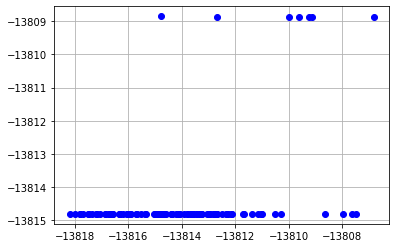

In [42]:
plt.plot(test_labels,prediction, 'o', color='blue')
plt.grid()
#plt.xlim([min(test_labels), max(test_labels)])
#plt.ylim([min(prediction), max(prediction)])
#plt.ylim([-13822,-13800])


In [43]:
print('layer 1')
print('weights')
print(net.network1.fc1.weight)
print('biases')
print(net.network1.fc1.bias)

print('layer 2')
print('weights')
print(net.network1.fc2.weight)
print('biases')
print(net.network1.fc2.bias)

layer 1
weights
Parameter containing:
tensor([[ 0.5114, -0.0084,  0.2055,  ..., -0.0778, -0.1570, -0.7521],
        [-2.1383,  0.8776, -2.2303,  ...,  0.8600, -2.9328,  0.8296],
        [ 0.0329,  0.7996,  0.3076,  ...,  0.8839,  0.4373,  1.4620],
        ...,
        [ 0.8360, -3.2474,  1.2093,  ..., -3.1777,  0.2282, -3.7737],
        [ 0.3884, -2.8405,  0.8288,  ..., -3.0384,  1.0916, -2.4513],
        [ 1.7457, -1.6008,  3.1511,  ..., -1.3706,  2.8534, -1.0687]],
       requires_grad=True)
biases
Parameter containing:
tensor([-0.7487,  1.3975,  1.4900,  2.0874,  1.6033, -1.9058, -1.3908,  0.9851,
        -0.4022,  0.3265, -0.4916, -2.3818, -0.1163,  2.2677,  0.8052,  1.7047,
        -0.5123,  1.6260, -1.0302,  0.0605,  0.6414, -2.3079, -2.8992,  0.6077,
         3.5466,  1.6224,  0.5520, -1.2787, -2.0880,  2.3660,  2.2176,  1.3036,
         0.8012,  2.1988,  1.0746, -3.1104, -0.5636, -3.6792, -2.5944, -1.0502],
       requires_grad=True)
layer 2
weights
Parameter containing:
tensor

In [ ]:
print(heta)
print(Rs)
print(zeta)
print(lambdaa)

In [ ]:
a = np.array([0.18723404, 0.17680851 ,0.32276596 ,0.2393617,  0.20808511, 0.34361702,
 0.21851064 ,0.31234043, 0.22893617, 0.07255319, 0.08297872, 0.19765957,
 0.24978723, 0.36446809, 0.10382979, 0.16638298, 0.37489362, 0.29148936,
 0.45829787, 0.28106383, 0.13510638 ,0.38531915 ,0.02042553 ,0.44787234,
 0.2706383 , 0.41659574, 0.09340426 ,0.03085106 ,0.4687234,  0.01,
 0.48957447, 0.35404255 ,0.42702128,0.47914894 ,0.5 ,       0.39574468,
 0.05170213 ,0.06212766 ,0.11425532, 0.30191489, 0.26021277, 0.0412766,
 0.15595745 ,0.12468085,0.33319149, 0.40617021 ,0.14553191, 0.43744681])

In [ ]:
b = np.array([0.44680851 ,0.76595745, 0.74468085, 0.38297872, 0.57446809, 0.61702128,
 0.53191489, 0.59574468, 0.0212766,  0.19148936, 0.70212766, 0.25531915,
 0.36170213, 0.14893617 ,0.42553191, 0.72340426, 0.04255319, 0.68085106,
 0.87234043, 0.93617021, 1.,         0.40425532, 0.46808511, 0.91489362,
 0.34042553, 0.23404255, 0.63829787, 0.65957447, 0.10638298, 0.78723404,
 0.21276596, 0.55319149, 0.5106383,  0.08510638, 0.06382979, 0.27659574,
 0.,         0.95744681, 0.80851064 ,0.12765957, 0.17021277, 0.85106383,
 0.4893617,  0.82978723, 0.29787234, 0.89361702, 0.31914894, 0.9787234 ])

In [ ]:
c = np.array([0.32978723, 0.21276596, 0.19148936, 0.25531915 ,0.4787234,  0.38297872,
 0.29787234 ,0.28723404 ,0.34042553, 0.40425532 ,0.20212766, 0.10638298,
 0.04255319 ,0.43617021, 0.30851064, 0.07446809 ,0.27659574 ,0.05319149,
 0.09574468 ,0.17021277, 0.46808511 ,0.0212766 , 0.13829787, 0.42553191,
 0.23404255 ,0.24468085 ,0.35106383, 0.4893617 , 0.45744681, 0.0106383,
 0.44680851 ,0.         ,0.26595745, 0.15957447 ,0.08510638 ,0.36170213,
 0.12765957 ,0.39361702 ,0.18085106, 0.03191489, 0.11702128 ,0.5,
 0.22340426 ,0.41489362 ,0.31914894 ,0.37234043, 0.06382979, 0.14893617])